In [1]:
# ML_in_Finance-RNNs-Bitcoin
# Author: Matthew Dixon and modified por Sergio Calderón
# Version: 1.1 (25.11.2021)
# License: MIT
# Email: matthew.dixon@iit.edu
# Notes: tested on Mac OS X running Python 3.8.5 with the following packages:
# tensorflow=2.4.1, keras=2.4.0, scikit-learn=0.22.1, numpy=1.18.1, matplotlib=3.1.3, pandas=1.0.3, statsmodels=0.10.1
# Citation: Please cite the following reference if this notebook is used for research purposes:
# Bilokon P., Dixon M.F. and Halperin I., Machine Learning in Finance: From Theory to Practice, Springer Graduate Textbook Series, 2020. 

## An Introduction to Prediction with RNNs

### Overview
- This notebook provides an example of how Keras can be used to train and test TensorFlow RNNs for time series prediction. The example dataset is for predicting from noisy, non-stationary data.
- Statistical methods used for autoregressive models shall be used to identify the sequence length needed in the RNN and to diagnose the model error.
- Plain RNNs are not suited to non-stationary time series modeling. We can use a GRU or LSTM to model non-stationary data, since these models exhibit dynamic auto-correlation structure.
- Unlike classical time series methods, e.g. ARIMA, there are no parametric assumptions on the distribution of the errors, and non-linear relationships between response and predictors can be captured. 
- The data is snapshots of the USD value of Coinbase every minute over 2018.

#### Statistician's note
- We choose to build a model which provides strong predictive power, at the expense of reduced explanatory power. 
- Our choice to use a recurrent neural network is predicated on each observation in the time series being dependent on previous observations. The ordering of the observations therefore matters and $X$ is not iid.
- Once the input data is appropriately scaled, model building starts with 'feature selection' - identifying the relevant features to include in the model. 

- In this notebook, we assume that we've already identifed the relevant set of features (i.e. there is only one time series provided).
- Our primary concern is assessing the extent to which the model is over-fitting, by comparing the in- and out-of-sample MSEs.

#### Implementation notes
- It is important to ensure that `shuffle=False` in the fit function, otherwise the ordering of sequences is not preserved. This is especially important for methods which have memory beyond the current sequence (i.e. all methods except RNNs).
- Time series cross-validation must be used for hyper-parameter tuning because the ordering of the data matters. In particular, the model must never use training data more recent than the forecasting observation date.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import tensorflow as tf
from datetime import timedelta

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, TimeSeriesSplit, GridSearchCV

import tensorflow.keras as keras

#from keras import initializers
#from tensorflow.keras.layers import Dense, Layer, LSTM, GRU, SimpleRNN, RNN
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.models import load_model
#from tensorflow.keras.regularizers import l1, l2
#from tensorflow.keras.callbacks import EarlyStopping
#from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

2024-05-31 11:48:53.365858: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
%matplotlib inline

### Example Data
- The example dataset $X$ is a chronologically ordered time series. The ordering of the observations matters and each observation is not assumed to be independent (as with cross-sectional classification data). 

- Each observation in $X$ has one variable (a.k.a. univariate time series).

In [3]:
df = pd.read_csv('coinbase.csv', index_col=1)

df.index = pd.to_datetime(df.index)

In [4]:
df

,USD
timestamp,
2018-01-01 00:00:00,13598.814422
2018-01-01 00:01:00,13596.912824
2018-01-01 00:02:00,13568.356998
2018-01-01 00:03:00,13560.425182
2018-01-01 00:04:00,13552.270931
...,...
2018-11-10 15:56:00,6347.417225
2018-11-10 15:57:00,6347.419294
2018-11-10 15:58:00,6347.418653


The dataset contains missing values; in order to prevent this causing errors, we replace these with adjacent values from the time series.

In [5]:
nof_missing_values = sum(np.isnan(df['USD']))

print(nof_missing_values, 'observations are missing.')
print('This is {:.3f}% of the total.'.format(nof_missing_values*100/len(df)))

1662 observations are missing.
This is 0.368% of the total.


In [6]:
df = df.fillna(method="backfill")

nof_missing_values = sum(np.isnan(df['USD']))

print('Now', nof_missing_values, 'observations are missing.')

Now 0 observations are missing.


/var/folders/41/k77kd32n6gl6zr9mqhf8hfzh0000gn/T/ipykernel_5873/3138141173.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method="backfill")


# RNN Regression
We consider a univariate prediction problem where the time series is given by 'USD' in the data frame, and for each input sequence we predict the value 4 time-steps into the future.

In [7]:
use_features = ['USD'] # continuous input
target = ['USD'] # continuous output
n_steps_ahead = 4 # forecasting horizon

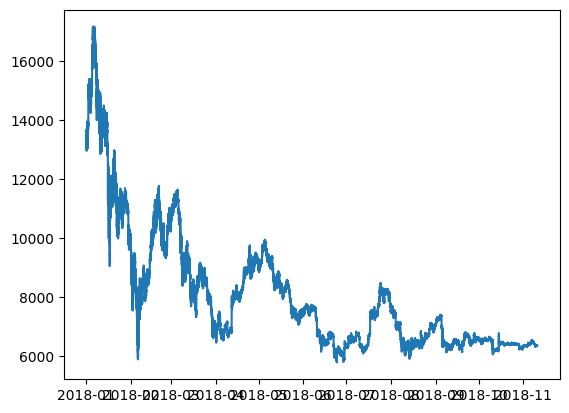

In [8]:
plt.plot(df['USD'])

### Stationarity
It is essential to determine whether the time series is "stationary". Informally, stationarity is when the auto-covariance is independent of time. Failure to establish stationarity will almost certainly lead to misinterpretation of model identification and diagnostic tests. Moreover, stationarity is decisive in characterizing the prediction problem and whether to use a more advanced architecture. In particular, we can expect a plain RNN to perform poorly if the data is non-stationary as the RNN exhibits fixed auto-covariance. 

We perform an Augmented Dickey-Fuller test to establish stationarity under the assumption that the time series has a constant bias but does not exhibit a time trend. In other words, we assume that the time series is already de-trended. 

If the stationarity test fails, even after first de-trending the time series, then one potential recourse is to simply take differences of time series and predict $\Delta y_t$.




The null hypothesis of the Augmented Dickey-Fuller is that there is a unit root, with the alternative that there is no unit root. If the p-value is above $(1-\alpha)$, then we cannot reject that there is a unit root. Note that a subset of the time series is used to reduce the memory requirements of the test. We use the first 200,000 samples to test for stationarity. While the test statistic is sensitive to the data size, the ADF test is always accepted at the 99\% level.

In [9]:
sample = df['USD'][:200000]
adf, p, usedlag, nobs, cvs, aic = sm.tsa.stattools.adfuller(sample)

In [10]:
adf_results_string = 'ADF: {}\np-value: {},\nN: {}, \ncritical values: {}'
print(adf_results_string.format(adf, p, nobs, cvs))

ADF: -2.094557163375749
p-value: 0.24670881839395753,
N: 199918, 
critical values: {'1%': -3.4303827103310676, '5%': -2.8615544575334875, '10%': -2.566777695225296}


Here we accept the null as the p-value is larger than 0.01, thus we can not reject the test at the 99% confidence level. This suggests that the time series is **non-stationary**.

#### Autoregressive Model Identification: The partial auto-correlation
It is important to determine the number of lags, the sequence length, required in the RNN by statistical analysis. A brute-force approach will in general be too time-consuming.

A partial auto-correlation at lag $h\geq 2$ is a conditional auto-correlation between a variable, $X_t$, and its $h^{th}$ lag, $X_{t-h}$ under the assumption that we control for the values of the intermediate lags, $X_{t-1},\dots, X_{t-h+1}$:

$$\begin{align}\tau_h&:=\tau(X_t, X_{t-h}; X_{t-1},\dots, X_{t-h+1})\\
&:=\frac{\gamma(X_t, X_{t-h}; X_{t-1},\dots, X_{t-h+1})}{\sqrt{\gamma(X_t |X_{t-1},\dots, X_{t-h+1})\gamma(X_{t-h} |X_{t-1},\dots, X_{t-h+1}))}},
\end{align}$$
where $\gamma_h:=\gamma(X_tX_{t-h})$ is the lag-$h$ autocovariance. The partial autocorrelation function $\tau_h:\mathbb{N} \rightarrow [-1,1]$ is a map $h:\mapsto \tau_h$.

The estimated partial auto-correlation function (PACF) can be used to identify the order of an autoregressive time series model. Values of $|\tau_h|$ greater or equal to $\frac{\Phi^{-1}(\alpha)}{\sqrt{T}}$, where $T$ is the number of observations and $\Phi(z)$ is the standard normal CDF, are significant lag $h$ partial autocorelations at the $\alpha$ confidence level.

We use the stattools package to estimate the PACF. The `nlags` parameter is the maximum number of lags used for PACF estimation.

In [11]:
pacf = sm.tsa.stattools.pacf(df[use_features], nlags=30)

In [12]:
T = len(df[use_features])

sig_test = lambda tau_h: np.abs(tau_h) > 2.58/np.sqrt(T)

We find the first lag which isn't significant at the 99% level and automatically determine the number of lags needed in our autoregressive model as one below this value.

In [13]:
for i in range(len(pacf)):
    if sig_test(pacf[i]) == False:
        n_steps = i - 1
        print('n_steps set to', n_steps)
        break

n_steps set to 4


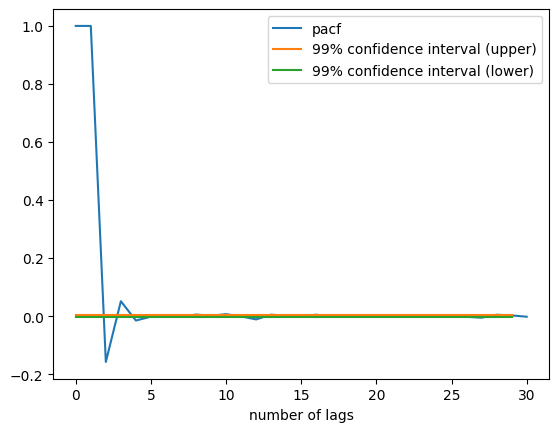

In [14]:
plt.plot(pacf, label='pacf')
plt.plot([2.58/np.sqrt(T)]*30, label='99% confidence interval (upper)')
plt.plot([-2.58/np.sqrt(T)]*30, label='99% confidence interval (lower)')
plt.xlabel('number of lags')
plt.legend();

### Splitting the time series into training and testing sets
Split the training and test set by using the first 80% of the time series and the remaining 20% for the test set. Note that the test set must be in the future of the training set to avoid look-ahead bias. Also, random sampling of the data can not be used as this would eliminate the auto-correlation structure.

In [15]:
train_weight = 0.8
split = int(len(df) * train_weight)

df_train = df[use_features].iloc[:split]
df_test = df[use_features].iloc[split:]

### Scaling
Standardization of the data is important to avoid potential scaling difficulties in the fitting of the model. When there is more than one feature (covariate), scaling avoids one feature dominating over another due to disparate scales.

To avoid introducing a look-ahead bias into the prediction, we must re-scale the training data without knowledge of the test set. Hence, we will simply standardize the training set using the mean and standard deviation of the training set and not the whole time series. Additionally, to avoid introducing a systematic bias into test set, we use the identical normalization for the test set - the mean and standard deviation of the training set are used to normalize the test set.

In [16]:
# note that for a multivariate time series, you would need to scale 
# each variable by its own mean and standard deviation in the training set
mu = float(df_train.mean())
sigma = float(df_train.std())

stdize_input = lambda x: (x - mu) / sigma

df_train = df_train.apply(stdize_input)
df_test = df_test.apply(stdize_input)

/var/folders/41/k77kd32n6gl6zr9mqhf8hfzh0000gn/T/ipykernel_5873/3456762699.py:3: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  mu = float(df_train.mean())
/var/folders/41/k77kd32n6gl6zr9mqhf8hfzh0000gn/T/ipykernel_5873/3456762699.py:4: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sigma = float(df_train.std())


### Data formatting for RNNs

TensorFlow uses tensors to represent data. To perform sequence learning, the time series of variables must be transformed to a series of over-lapping sub-sequences. 

For example, consider a univariate time series of increasing integers.

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15

Setting the sequence length to 10, for example, we move the window forward by one observation at a time and construct new sequences:

1 2 3 4 5 6 7 8 9 10

2 3 4 5 6 7 8 9 10 11

3 4 5 6 7 8 9 10 11 12

4 5 6 7 8 9 10 11 12 13

5 6 7 8 9 10 11 12 13 14

6 7 8 9 10 11 12 13 14 15


Let's define the following function for reshaping the data into one-step ahead times series prediction format. 

In [17]:
def get_lagged_features(df, n_steps, n_steps_ahead):
    """
    df: pandas DataFrame of time series to be lagged
    n_steps: number of lags, i.e. sequence length
    n_steps_ahead: forecasting horizon
    """
    lag_list = []
    
    for lag in range(n_steps + n_steps_ahead - 1, n_steps_ahead - 1, -1):
        lag_list.append(df.shift(lag))
    lag_array = np.dstack([i[n_steps+n_steps_ahead-1:] for i in lag_list])
    # We swap the last two dimensions so each slice along the first dimension
    # is the same shape as the corresponding segment of the input time series 
    lag_array = np.swapaxes(lag_array, 1, -1)
    return lag_array

In [18]:
n_steps_ahead

4

We shall first transform the training input and output data.

In [19]:
x_train = get_lagged_features(df_train, n_steps, n_steps_ahead)
y_train =  df_train.values[n_steps + n_steps_ahead - 1:]
y_train_timestamps = df_train.index[n_steps + n_steps_ahead - 1:]

x_test = get_lagged_features(df_test, n_steps, n_steps_ahead)
y_test =  df_test.values[n_steps + n_steps_ahead - 1:]
y_test_timestamps = df_test.index[n_steps + n_steps_ahead - 1:]

In [20]:
print([tensor.shape for tensor in (x_train, y_train, x_test, y_test)])

[(361337, 4, 1), (361337, 1), (90330, 4, 1), (90330, 1)]


### Model Specification


In [21]:
def SimpleRNN_(n_units, l1_reg, seed=0):
  #def SimpleRNN_(n_units = 10, seed=0):
  model = keras.models.Sequential()
  model.add(keras.layers.SimpleRNN(n_units, activation='tanh', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), recurrent_initializer=keras.initializers.orthogonal(seed), kernel_regularizer=keras.regularizers.L1(l1_reg), input_shape=(x_train.shape[1], x_train.shape[-1]), unroll=True, stateful=False))  
  model.add(keras.layers.Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), kernel_regularizer=keras.regularizers.L1(l1_reg)))
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model

def GRU_(n_units, l1_reg, seed=0):
  #def GRU_(n_units = 10, seed=0):
  model = keras.models.Sequential()
  model.add(keras.layers.GRU(n_units, activation='tanh', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), recurrent_initializer=keras.initializers.orthogonal(seed), kernel_regularizer=keras.regularizers.L1(l1_reg), input_shape=(x_train.shape[1], x_train.shape[-1]), unroll=True))  
  model.add(keras.layers.Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), kernel_regularizer=keras.regularizers.L1(l1_reg)))
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model

def LSTM_(n_units, l1_reg, seed=0):
  #def LSTM_(n_units = 10,  seed=0):
  model = keras.models.Sequential()
  model.add(keras.layers.LSTM(n_units, activation='tanh', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), recurrent_initializer=keras.initializers.orthogonal(seed), kernel_regularizer=keras.regularizers.L1(l1_reg), input_shape=(x_train.shape[1], x_train.shape[-1]), unroll=True)) 
  model.add(keras.layers.Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), kernel_regularizer=keras.regularizers.L1(l1_reg)))
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model

Use a batch size of 1000 as the dataset is reasonably large and the training time would be too long otherwise. 20 epochs have been used here, but a better approach would be to use a stopping criteria through a call back. 

In [22]:
max_epochs = 20 #Dejar mil
batch_size = 1000

In [23]:
es = keras.callbacks.EarlyStopping(monitor='loss', mode='min', verbose=1, patience=10, min_delta=1e-7, restore_best_weights=True)

In [24]:
params = {
    'rnn': {
        'model': None, 'function': SimpleRNN_, 'l1_reg': 0.0, 'H': 20, 
        'color': 'blue', 'label':'RNN'}, 
    'gru': {
        'model': None, 'function':GRU_,'l1_reg': 0.0, 'H': 10, 
        'color': 'orange', 'label': 'GRU'},
    'lstm': {
        'model': None, 'function': LSTM_,'l1_reg': 0.0, 'H': 10, 
        'color':'red', 'label': 'LSTM'}
}

In [25]:
params

{'rnn': {'model': None,
  'function': <function __main__.SimpleRNN_(n_units, l1_reg, seed=0)>,
  'l1_reg': 0.0,
  'H': 20,
  'color': 'blue',
  'label': 'RNN'},
 'gru': {'model': None,
  'function': <function __main__.GRU_(n_units, l1_reg, seed=0)>,
  'l1_reg': 0.0,
  'H': 10,
  'color': 'orange',
  'label': 'GRU'},
 'lstm': {'model': None,
  'function': <function __main__.LSTM_(n_units, l1_reg, seed=0)>,
  'l1_reg': 0.0,
  'H': 10,
  'color': 'red',
  'label': 'LSTM'}}

# Optionally, load pre-trained models
Training the models takes several hours. To save time, you may load the already fitted models instead:

In [26]:
do_training = True # Set to True if you wish to train your own models

In [27]:
params.keys()


dict_keys(['rnn', 'gru', 'lstm'])

In [28]:
#custom_objects = {'RNN':RNN,'GRU':GRU, 'LSTM':LSTM}

In [29]:
if do_training is False:
     for key in params.keys():
        params[key]['model']=keras.models.load_model('RNNs-Bitcoin-SAVED-' + key + '.hdf5')

# Cross-validation

The cell below performs a grid search to optimise the `n_units` and `l1_reg` for each of the models using the training data. 

The results are cross-validated to avoid over-fitting. Scikit-Learn's `TimeSeriesSplit` function is used to partition the data into 5 pairs of training and testing sets, where the test data is always ahead of the training data in time. 

In [30]:
from scikeras.wrappers import KerasRegressor

In [31]:
#tscv = TimeSeriesSplit(n_splits = 5)
#n_units = [5, 10, 20]
#l1_reg = [0, 0.001, 0.01, 0.1]
#param_grid = {'n_units': n_units, 'l1_reg': l1_reg}
#model = KerasRegressor(model=SimpleRNN_, epochs=max_epochs, 
#                               batch_size=batch_size, verbose=2,l1_reg=0,n_units=5)
#grid = GridSearchCV(estimator=model, param_grid=param_grid, 
#                            cv=tscv, n_jobs=1, verbose=2)
#grid_result = grid.fit(x_train, y_train, callbacks=[es])

In [32]:
#model.fit(x_train, y_train, callbacks=[es])

In [35]:
param_grid

{'n_units': [5, 10, 20], 'l1_reg': [0, 0.001, 0.01, 0.1]}

In [33]:
cross_val = True # WARNING: Changing this to True will take many hours to run

if do_training and cross_val:
    n_units = [5, 10, 20]
    l1_reg = [0, 0.001, 0.01, 0.1]
    
    # A dictionary containing a list of values to be iterated through
    # for each parameter of the model included in the search
    param_grid = {'n_units': n_units, 'l1_reg': l1_reg}
    
    # In the kth split, TimeSeriesSplit returns first k folds 
    # as training set and the (k+1)th fold as test set.
    tscv = TimeSeriesSplit(n_splits = 5)
    
    # A grid search is performed for each of the models, and the parameter set which
    # performs best over all the cross-validation splits is saved in the `params` dictionary
    for key in params.keys():
        print('Performing cross-validation. Model:', key)
        model = KerasRegressor(model=params[key]['function'], epochs=max_epochs, 
                               batch_size=batch_size, verbose=2, l1_reg=0, n_units=10)
        #from scikeras.wrappers import KerasClassifier, KerasRegressor
        grid = GridSearchCV(estimator=model, param_grid=param_grid, 
                            cv=tscv, n_jobs=1, verbose=2)
        grid_result = grid.fit(x_train, y_train, callbacks=[es])
        print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
        
        means = grid_result.cv_results_['mean_test_score']
        stds = grid_result.cv_results_['std_test_score']
        params_ = grid_result.cv_results_['params']
        for mean, stdev, param_ in zip(means, stds, params_):
            print("%f (%f) with %r" % (mean, stdev, param_))
            
        params[key]['H'] = grid_result.best_params_['n_units']
        params[key]['l1_reg']= grid_result.best_params_['l1_reg']

Performing cross-validation. Model: rnn
Fitting 5 folds for each of 12 candidates, totalling 60 fits


/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
[CV] END ................................l1_reg=0, n_units=5; total time=  18.9s
Epoch 1/20
[CV] END ................................l1_reg=0, n_units=5; total time=   0.2s


/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
[CV] END ................................l1_reg=0, n_units=5; total time=   0.2s
Epoch 1/20
[CV] END ................................l1_reg=0, n_units=5; total time=   0.2s


/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
[CV] END ................................l1_reg=0, n_units=5; total time=   0.2s
Epoch 1/20
[CV] END ...............................l1_reg=0, n_units=10; total time=   0.2s


/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
[CV] END ...............................l1_reg=0, n_units=10; total time=   0.2s
Epoch 1/20
[CV] END ...............................l1_reg=0, n_units=10; total time=   0.2s


/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
[CV] END ...............................l1_reg=0, n_units=10; total time=   0.2s
Epoch 1/20
[CV] END ...............................l1_reg=0, n_units=10; total time=   0.2s


/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
[CV] END ...............................l1_reg=0, n_units=20; total time=   0.2s
Epoch 1/20
[CV] END ...............................l1_reg=0, n_units=20; total time=   0.1s
Epoch 1/20


/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END ...............................l1_reg=0, n_units=20; total time=   0.1s
Epoch 1/20
[CV] END ...............................l1_reg=0, n_units=20; total time=   0.2s


/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
[CV] END ...............................l1_reg=0, n_units=20; total time=   0.2s
Epoch 1/20


/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


61/61 - 6s - 94ms/step - loss: 0.8833
Epoch 2/20
61/61 - 0s - 1ms/step - loss: 0.5716
Epoch 3/20
61/61 - 0s - 1ms/step - loss: 0.4035
Epoch 4/20
61/61 - 0s - 989us/step - loss: 0.2925
Epoch 5/20
61/61 - 0s - 965us/step - loss: 0.2175
Epoch 6/20
61/61 - 0s - 956us/step - loss: 0.1656
Epoch 7/20
61/61 - 0s - 958us/step - loss: 0.1287
Epoch 8/20
61/61 - 0s - 1ms/step - loss: 0.1015
Epoch 9/20
61/61 - 0s - 1ms/step - loss: 0.0806
Epoch 10/20
61/61 - 0s - 1ms/step - loss: 0.0644
Epoch 11/20
61/61 - 0s - 1ms/step - loss: 0.0522
Epoch 12/20
61/61 - 0s - 1ms/step - loss: 0.0433
Epoch 13/20
61/61 - 0s - 2ms/step - loss: 0.0366
Epoch 14/20
61/61 - 0s - 947us/step - loss: 0.0315
Epoch 15/20
61/61 - 0s - 994us/step - loss: 0.0278
Epoch 16/20
61/61 - 0s - 1ms/step - loss: 0.0251
Epoch 17/20
61/61 - 0s - 981us/step - loss: 0.0231
Epoch 18/20
61/61 - 0s - 983us/step - loss: 0.0216
Epoch 19/20
61/61 - 0s - 966us/step - loss: 0.0204
Epoch 20/20
61/61 - 0s - 998us/step - loss: 0.0193
61/61 - 0s - 4ms/st

/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


121/121 - 1s - 7ms/step - loss: 0.3863
Epoch 2/20
121/121 - 0s - 887us/step - loss: 0.1956
Epoch 3/20
121/121 - 0s - 882us/step - loss: 0.1125
Epoch 4/20
121/121 - 0s - 948us/step - loss: 0.0702
Epoch 5/20
121/121 - 0s - 881us/step - loss: 0.0458
Epoch 6/20
121/121 - 0s - 833us/step - loss: 0.0309
Epoch 7/20
121/121 - 0s - 854us/step - loss: 0.0222
Epoch 8/20
121/121 - 0s - 834us/step - loss: 0.0176
Epoch 9/20
121/121 - 0s - 876us/step - loss: 0.0154
Epoch 10/20
121/121 - 0s - 827us/step - loss: 0.0141
Epoch 11/20
121/121 - 0s - 853us/step - loss: 0.0132
Epoch 12/20
121/121 - 0s - 850us/step - loss: 0.0124
Epoch 13/20
121/121 - 0s - 851us/step - loss: 0.0118
Epoch 14/20
121/121 - 0s - 814us/step - loss: 0.0112
Epoch 15/20
121/121 - 0s - 857us/step - loss: 0.0108
Epoch 16/20
121/121 - 0s - 817us/step - loss: 0.0104
Epoch 17/20
121/121 - 0s - 849us/step - loss: 0.0101
Epoch 18/20
121/121 - 0s - 830us/step - loss: 0.0098
Epoch 19/20
121/121 - 0s - 838us/step - loss: 0.0096
Epoch 20/20
121

/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


181/181 - 5s - 29ms/step - loss: 0.2333
Epoch 2/20
181/181 - 0s - 1ms/step - loss: 0.0957
Epoch 3/20
181/181 - 0s - 837us/step - loss: 0.0458
Epoch 4/20
181/181 - 0s - 930us/step - loss: 0.0248
Epoch 5/20
181/181 - 0s - 885us/step - loss: 0.0168
Epoch 6/20
181/181 - 0s - 928us/step - loss: 0.0134
Epoch 7/20
181/181 - 0s - 901us/step - loss: 0.0120
Epoch 8/20
181/181 - 0s - 979us/step - loss: 0.0111
Epoch 9/20
181/181 - 0s - 926us/step - loss: 0.0104
Epoch 10/20
181/181 - 0s - 890us/step - loss: 0.0099
Epoch 11/20
181/181 - 0s - 896us/step - loss: 0.0095
Epoch 12/20
181/181 - 0s - 882us/step - loss: 0.0092
Epoch 13/20
181/181 - 0s - 949us/step - loss: 0.0090
Epoch 14/20
181/181 - 0s - 2ms/step - loss: 0.0088
Epoch 15/20
181/181 - 0s - 966us/step - loss: 0.0086
Epoch 16/20
181/181 - 0s - 913us/step - loss: 0.0085
Epoch 17/20
181/181 - 0s - 938us/step - loss: 0.0084
Epoch 18/20
181/181 - 0s - 801us/step - loss: 0.0083
Epoch 19/20
181/181 - 0s - 800us/step - loss: 0.0082
Epoch 20/20
181/18

/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


241/241 - 1s - 5ms/step - loss: 0.1591
Epoch 2/20
241/241 - 0s - 889us/step - loss: 0.0535
Epoch 3/20
241/241 - 0s - 931us/step - loss: 0.0226
Epoch 4/20
241/241 - 0s - 897us/step - loss: 0.0142
Epoch 5/20
241/241 - 0s - 966us/step - loss: 0.0115
Epoch 6/20
241/241 - 0s - 980us/step - loss: 0.0104
Epoch 7/20
241/241 - 0s - 935us/step - loss: 0.0097
Epoch 8/20
241/241 - 0s - 807us/step - loss: 0.0092
Epoch 9/20
241/241 - 0s - 775us/step - loss: 0.0089
Epoch 10/20
241/241 - 0s - 761us/step - loss: 0.0086
Epoch 11/20
241/241 - 0s - 976us/step - loss: 0.0084
Epoch 12/20
241/241 - 0s - 928us/step - loss: 0.0083
Epoch 13/20
241/241 - 0s - 941us/step - loss: 0.0082
Epoch 14/20
241/241 - 0s - 929us/step - loss: 0.0081
Epoch 15/20
241/241 - 0s - 944us/step - loss: 0.0080
Epoch 16/20
241/241 - 0s - 956us/step - loss: 0.0079
Epoch 17/20
241/241 - 0s - 831us/step - loss: 0.0079
Epoch 18/20
241/241 - 0s - 804us/step - loss: 0.0078
Epoch 19/20
241/241 - 0s - 958us/step - loss: 0.0077
Epoch 20/20
241

/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


302/302 - 1s - 3ms/step - loss: 0.1188
Epoch 2/20
302/302 - 0s - 782us/step - loss: 0.0319
Epoch 3/20
302/302 - 0s - 795us/step - loss: 0.0150
Epoch 4/20
302/302 - 0s - 843us/step - loss: 0.0111
Epoch 5/20
302/302 - 0s - 917us/step - loss: 0.0099
Epoch 6/20
302/302 - 0s - 792us/step - loss: 0.0092
Epoch 7/20
302/302 - 0s - 776us/step - loss: 0.0088
Epoch 8/20
302/302 - 0s - 801us/step - loss: 0.0085
Epoch 9/20
302/302 - 0s - 811us/step - loss: 0.0083
Epoch 10/20
302/302 - 0s - 778us/step - loss: 0.0081
Epoch 11/20
302/302 - 0s - 809us/step - loss: 0.0080
Epoch 12/20
302/302 - 0s - 798us/step - loss: 0.0079
Epoch 13/20
302/302 - 0s - 784us/step - loss: 0.0078
Epoch 14/20
302/302 - 0s - 798us/step - loss: 0.0078
Epoch 15/20
302/302 - 0s - 752us/step - loss: 0.0077
Epoch 16/20
302/302 - 0s - 912us/step - loss: 0.0076
Epoch 17/20
302/302 - 0s - 808us/step - loss: 0.0075
Epoch 18/20
302/302 - 0s - 751us/step - loss: 0.0074
Epoch 19/20
302/302 - 0s - 758us/step - loss: 0.0074
Epoch 20/20
302

/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


61/61 - 1s - 15ms/step - loss: 0.1222
Epoch 2/20
61/61 - 0s - 2ms/step - loss: 0.0504
Epoch 3/20
61/61 - 0s - 2ms/step - loss: 0.0292
Epoch 4/20
61/61 - 0s - 1ms/step - loss: 0.0194
Epoch 5/20
61/61 - 0s - 2ms/step - loss: 0.0150
Epoch 6/20
61/61 - 0s - 2ms/step - loss: 0.0133
Epoch 7/20
61/61 - 0s - 2ms/step - loss: 0.0126
Epoch 8/20
61/61 - 0s - 2ms/step - loss: 0.0122
Epoch 9/20
61/61 - 0s - 2ms/step - loss: 0.0120
Epoch 10/20
61/61 - 0s - 1ms/step - loss: 0.0117
Epoch 11/20
61/61 - 0s - 1ms/step - loss: 0.0115
Epoch 12/20
61/61 - 0s - 1ms/step - loss: 0.0114
Epoch 13/20
61/61 - 0s - 1ms/step - loss: 0.0112
Epoch 14/20
61/61 - 0s - 1ms/step - loss: 0.0111
Epoch 15/20
61/61 - 0s - 1ms/step - loss: 0.0110
Epoch 16/20
61/61 - 0s - 1ms/step - loss: 0.0109
Epoch 17/20
61/61 - 0s - 1ms/step - loss: 0.0108
Epoch 18/20
61/61 - 0s - 1ms/step - loss: 0.0108
Epoch 19/20
61/61 - 0s - 1ms/step - loss: 0.0107
Epoch 20/20
61/61 - 0s - 1ms/step - loss: 0.0107
61/61 - 0s - 3ms/step
[CV] END ........

/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


121/121 - 1s - 8ms/step - loss: 0.0631
Epoch 2/20
121/121 - 0s - 903us/step - loss: 0.0201
Epoch 3/20
121/121 - 0s - 1ms/step - loss: 0.0126
Epoch 4/20
121/121 - 0s - 1ms/step - loss: 0.0114
Epoch 5/20
121/121 - 0s - 1ms/step - loss: 0.0109
Epoch 6/20
121/121 - 0s - 1ms/step - loss: 0.0106
Epoch 7/20
121/121 - 0s - 1ms/step - loss: 0.0105
Epoch 8/20
121/121 - 0s - 1ms/step - loss: 0.0104
Epoch 9/20
121/121 - 0s - 1ms/step - loss: 0.0103
Epoch 10/20
121/121 - 0s - 1ms/step - loss: 0.0102
Epoch 11/20
121/121 - 0s - 1ms/step - loss: 0.0102
Epoch 12/20
121/121 - 0s - 1ms/step - loss: 0.0101
Epoch 13/20
121/121 - 0s - 1ms/step - loss: 0.0100
Epoch 14/20
121/121 - 0s - 1ms/step - loss: 0.0100
Epoch 15/20
121/121 - 0s - 1ms/step - loss: 0.0099
Epoch 16/20
121/121 - 0s - 1ms/step - loss: 0.0098
Epoch 17/20
121/121 - 0s - 1ms/step - loss: 0.0098
Epoch 18/20
121/121 - 0s - 1ms/step - loss: 0.0097
Epoch 19/20
121/121 - 0s - 1ms/step - loss: 0.0096
Epoch 20/20
121/121 - 0s - 1ms/step - loss: 0.009

/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


181/181 - 1s - 6ms/step - loss: 0.0451
Epoch 2/20
181/181 - 0s - 870us/step - loss: 0.0132
Epoch 3/20
181/181 - 0s - 974us/step - loss: 0.0110
Epoch 4/20
181/181 - 0s - 895us/step - loss: 0.0104
Epoch 5/20
181/181 - 0s - 844us/step - loss: 0.0102
Epoch 6/20
181/181 - 0s - 862us/step - loss: 0.0101
Epoch 7/20
181/181 - 0s - 867us/step - loss: 0.0100
Epoch 8/20
181/181 - 0s - 866us/step - loss: 0.0099
Epoch 9/20
181/181 - 0s - 847us/step - loss: 0.0098
Epoch 10/20
181/181 - 0s - 858us/step - loss: 0.0097
Epoch 11/20
181/181 - 0s - 893us/step - loss: 0.0096
Epoch 12/20
181/181 - 0s - 897us/step - loss: 0.0094
Epoch 13/20
181/181 - 0s - 915us/step - loss: 0.0092
Epoch 14/20
181/181 - 0s - 886us/step - loss: 0.0091
Epoch 15/20
181/181 - 0s - 878us/step - loss: 0.0090
Epoch 16/20
181/181 - 0s - 894us/step - loss: 0.0088
Epoch 17/20
181/181 - 0s - 879us/step - loss: 0.0087
Epoch 18/20
181/181 - 0s - 856us/step - loss: 0.0086
Epoch 19/20
181/181 - 0s - 855us/step - loss: 0.0085
Epoch 20/20
181

/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


241/241 - 1s - 4ms/step - loss: 0.0319
Epoch 2/20
241/241 - 0s - 874us/step - loss: 0.0110
Epoch 3/20
241/241 - 0s - 870us/step - loss: 0.0102
Epoch 4/20
241/241 - 0s - 853us/step - loss: 0.0100
Epoch 5/20
241/241 - 0s - 851us/step - loss: 0.0099
Epoch 6/20
241/241 - 0s - 899us/step - loss: 0.0097
Epoch 7/20
241/241 - 0s - 867us/step - loss: 0.0096
Epoch 8/20
241/241 - 0s - 867us/step - loss: 0.0094
Epoch 9/20
241/241 - 0s - 848us/step - loss: 0.0092
Epoch 10/20
241/241 - 0s - 845us/step - loss: 0.0090
Epoch 11/20
241/241 - 0s - 864us/step - loss: 0.0088
Epoch 12/20
241/241 - 0s - 849us/step - loss: 0.0086
Epoch 13/20
241/241 - 0s - 844us/step - loss: 0.0084
Epoch 14/20
241/241 - 0s - 851us/step - loss: 0.0082
Epoch 15/20
241/241 - 0s - 849us/step - loss: 0.0080
Epoch 16/20
241/241 - 0s - 869us/step - loss: 0.0078
Epoch 17/20
241/241 - 0s - 850us/step - loss: 0.0075
Epoch 18/20
241/241 - 0s - 854us/step - loss: 0.0073
Epoch 19/20
241/241 - 0s - 888us/step - loss: 0.0072
Epoch 20/20
241

/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


302/302 - 1s - 4ms/step - loss: 0.0264
Epoch 2/20
302/302 - 0s - 857us/step - loss: 0.0103
Epoch 3/20
302/302 - 0s - 843us/step - loss: 0.0099
Epoch 4/20
302/302 - 0s - 840us/step - loss: 0.0097
Epoch 5/20
302/302 - 0s - 826us/step - loss: 0.0095
Epoch 6/20
302/302 - 0s - 839us/step - loss: 0.0094
Epoch 7/20
302/302 - 0s - 852us/step - loss: 0.0092
Epoch 8/20
302/302 - 0s - 824us/step - loss: 0.0090
Epoch 9/20
302/302 - 0s - 854us/step - loss: 0.0088
Epoch 10/20
302/302 - 0s - 865us/step - loss: 0.0086
Epoch 11/20
302/302 - 0s - 829us/step - loss: 0.0083
Epoch 12/20
302/302 - 0s - 825us/step - loss: 0.0080
Epoch 13/20
302/302 - 0s - 868us/step - loss: 0.0077
Epoch 14/20
302/302 - 0s - 833us/step - loss: 0.0073
Epoch 15/20
302/302 - 0s - 822us/step - loss: 0.0070
Epoch 16/20
302/302 - 0s - 835us/step - loss: 0.0067
Epoch 17/20
302/302 - 0s - 908us/step - loss: 0.0064
Epoch 18/20
302/302 - 0s - 1ms/step - loss: 0.0062
Epoch 19/20
302/302 - 0s - 960us/step - loss: 0.0061
Epoch 20/20
302/3

/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


61/61 - 1s - 16ms/step - loss: 0.0647
Epoch 2/20
61/61 - 0s - 2ms/step - loss: 0.0348
Epoch 3/20
61/61 - 0s - 1ms/step - loss: 0.0250
Epoch 4/20
61/61 - 0s - 1ms/step - loss: 0.0185
Epoch 5/20
61/61 - 0s - 1ms/step - loss: 0.0144
Epoch 6/20
61/61 - 0s - 2ms/step - loss: 0.0136
Epoch 7/20
61/61 - 0s - 2ms/step - loss: 0.0134
Epoch 8/20
61/61 - 0s - 2ms/step - loss: 0.0132
Epoch 9/20
61/61 - 0s - 1ms/step - loss: 0.0130
Epoch 10/20
61/61 - 0s - 1ms/step - loss: 0.0129
Epoch 11/20
61/61 - 0s - 1ms/step - loss: 0.0128
Epoch 12/20
61/61 - 0s - 1ms/step - loss: 0.0127
Epoch 13/20
61/61 - 0s - 1ms/step - loss: 0.0126
Epoch 14/20
61/61 - 0s - 1ms/step - loss: 0.0125
Epoch 15/20
61/61 - 0s - 1ms/step - loss: 0.0125
Epoch 16/20
61/61 - 0s - 2ms/step - loss: 0.0124
Epoch 17/20
61/61 - 0s - 2ms/step - loss: 0.0123
Epoch 18/20
61/61 - 0s - 2ms/step - loss: 0.0123
Epoch 19/20
61/61 - 0s - 2ms/step - loss: 0.0122
Epoch 20/20
61/61 - 0s - 2ms/step - loss: 0.0122
61/61 - 0s - 3ms/step
[CV] END ........

/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


121/121 - 1s - 11ms/step - loss: 0.0412
Epoch 2/20
121/121 - 0s - 1ms/step - loss: 0.0210
Epoch 3/20
121/121 - 0s - 1ms/step - loss: 0.0144
Epoch 4/20
121/121 - 0s - 1ms/step - loss: 0.0127
Epoch 5/20
121/121 - 0s - 2ms/step - loss: 0.0124
Epoch 6/20
121/121 - 0s - 1ms/step - loss: 0.0122
Epoch 7/20
121/121 - 0s - 1ms/step - loss: 0.0121
Epoch 8/20
121/121 - 0s - 1ms/step - loss: 0.0119
Epoch 9/20
121/121 - 0s - 2ms/step - loss: 0.0118
Epoch 10/20
121/121 - 0s - 1ms/step - loss: 0.0117
Epoch 11/20
121/121 - 0s - 2ms/step - loss: 0.0116
Epoch 12/20
121/121 - 0s - 1ms/step - loss: 0.0115
Epoch 13/20
121/121 - 0s - 1ms/step - loss: 0.0114
Epoch 14/20
121/121 - 0s - 1ms/step - loss: 0.0113
Epoch 15/20
121/121 - 0s - 1ms/step - loss: 0.0112
Epoch 16/20
121/121 - 0s - 2ms/step - loss: 0.0111
Epoch 17/20
121/121 - 0s - 1ms/step - loss: 0.0110
Epoch 18/20
121/121 - 0s - 1ms/step - loss: 0.0109
Epoch 19/20
121/121 - 0s - 1ms/step - loss: 0.0108
Epoch 20/20
121/121 - 0s - 1ms/step - loss: 0.0108

/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


181/181 - 1s - 6ms/step - loss: 0.0318
Epoch 2/20
181/181 - 0s - 1ms/step - loss: 0.0138
Epoch 3/20
181/181 - 0s - 1ms/step - loss: 0.0124
Epoch 4/20
181/181 - 0s - 1ms/step - loss: 0.0121
Epoch 5/20
181/181 - 0s - 1ms/step - loss: 0.0118
Epoch 6/20
181/181 - 0s - 1ms/step - loss: 0.0114
Epoch 7/20
181/181 - 0s - 1ms/step - loss: 0.0111
Epoch 8/20
181/181 - 0s - 1ms/step - loss: 0.0108
Epoch 9/20
181/181 - 0s - 1ms/step - loss: 0.0105
Epoch 10/20
181/181 - 0s - 1ms/step - loss: 0.0103
Epoch 11/20
181/181 - 0s - 1ms/step - loss: 0.0100
Epoch 12/20
181/181 - 0s - 1ms/step - loss: 0.0098
Epoch 13/20
181/181 - 0s - 1ms/step - loss: 0.0096
Epoch 14/20
181/181 - 0s - 1ms/step - loss: 0.0095
Epoch 15/20
181/181 - 0s - 1ms/step - loss: 0.0093
Epoch 16/20
181/181 - 0s - 1ms/step - loss: 0.0092
Epoch 17/20
181/181 - 0s - 1ms/step - loss: 0.0091
Epoch 18/20
181/181 - 0s - 1ms/step - loss: 0.0090
Epoch 19/20
181/181 - 0s - 2ms/step - loss: 0.0088
Epoch 20/20
181/181 - 0s - 2ms/step - loss: 0.0087


/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


241/241 - 1s - 5ms/step - loss: 0.0248
Epoch 2/20
241/241 - 0s - 1ms/step - loss: 0.0123
Epoch 3/20
241/241 - 0s - 1ms/step - loss: 0.0119
Epoch 4/20
241/241 - 0s - 1ms/step - loss: 0.0114
Epoch 5/20
241/241 - 0s - 1ms/step - loss: 0.0109
Epoch 6/20
241/241 - 0s - 1ms/step - loss: 0.0105
Epoch 7/20
241/241 - 0s - 1ms/step - loss: 0.0101
Epoch 8/20
241/241 - 0s - 1ms/step - loss: 0.0098
Epoch 9/20
241/241 - 0s - 1ms/step - loss: 0.0095
Epoch 10/20
241/241 - 0s - 1ms/step - loss: 0.0093
Epoch 11/20
241/241 - 0s - 1ms/step - loss: 0.0090
Epoch 12/20
241/241 - 0s - 1ms/step - loss: 0.0089
Epoch 13/20
241/241 - 0s - 1ms/step - loss: 0.0087
Epoch 14/20
241/241 - 0s - 1ms/step - loss: 0.0085
Epoch 15/20
241/241 - 0s - 1ms/step - loss: 0.0083
Epoch 16/20
241/241 - 0s - 1ms/step - loss: 0.0082
Epoch 17/20
241/241 - 0s - 1ms/step - loss: 0.0080
Epoch 18/20
241/241 - 0s - 1ms/step - loss: 0.0078
Epoch 19/20
241/241 - 0s - 1ms/step - loss: 0.0076
Epoch 20/20
241/241 - 0s - 1ms/step - loss: 0.0074


/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


302/302 - 1s - 4ms/step - loss: 0.0212
Epoch 2/20
302/302 - 0s - 1ms/step - loss: 0.0119
Epoch 3/20
302/302 - 0s - 1ms/step - loss: 0.0115
Epoch 4/20
302/302 - 0s - 1ms/step - loss: 0.0109
Epoch 5/20
302/302 - 0s - 1ms/step - loss: 0.0104
Epoch 6/20
302/302 - 0s - 1ms/step - loss: 0.0099
Epoch 7/20
302/302 - 0s - 1ms/step - loss: 0.0095
Epoch 8/20
302/302 - 0s - 1ms/step - loss: 0.0091
Epoch 9/20
302/302 - 0s - 1ms/step - loss: 0.0088
Epoch 10/20
302/302 - 0s - 1ms/step - loss: 0.0085
Epoch 11/20
302/302 - 0s - 1ms/step - loss: 0.0083
Epoch 12/20
302/302 - 1s - 2ms/step - loss: 0.0081
Epoch 13/20
302/302 - 1s - 2ms/step - loss: 0.0079
Epoch 14/20
302/302 - 0s - 1ms/step - loss: 0.0077
Epoch 15/20
302/302 - 0s - 1ms/step - loss: 0.0075
Epoch 16/20
302/302 - 0s - 2ms/step - loss: 0.0072
Epoch 17/20
302/302 - 1s - 2ms/step - loss: 0.0070
Epoch 18/20
302/302 - 0s - 1ms/step - loss: 0.0067
Epoch 19/20
302/302 - 0s - 1ms/step - loss: 0.0064
Epoch 20/20
302/302 - 0s - 1ms/step - loss: 0.0062


/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


61/61 - 1s - 15ms/step - loss: 0.9272
Epoch 2/20
61/61 - 0s - 1ms/step - loss: 0.6203
Epoch 3/20
61/61 - 0s - 987us/step - loss: 0.4552
Epoch 4/20
61/61 - 0s - 1ms/step - loss: 0.3461
Epoch 5/20
61/61 - 0s - 1ms/step - loss: 0.2730
Epoch 6/20
61/61 - 0s - 1ms/step - loss: 0.2230
Epoch 7/20
61/61 - 0s - 1ms/step - loss: 0.1878
Epoch 8/20
61/61 - 0s - 1ms/step - loss: 0.1623
Epoch 9/20
61/61 - 0s - 1ms/step - loss: 0.1432
Epoch 10/20
61/61 - 0s - 1ms/step - loss: 0.1285
Epoch 11/20
61/61 - 0s - 988us/step - loss: 0.1168
Epoch 12/20
61/61 - 0s - 1ms/step - loss: 0.1077
Epoch 13/20
61/61 - 0s - 997us/step - loss: 0.1010
Epoch 14/20
61/61 - 0s - 1ms/step - loss: 0.0961
Epoch 15/20
61/61 - 0s - 1ms/step - loss: 0.0924
Epoch 16/20
61/61 - 0s - 981us/step - loss: 0.0896
Epoch 17/20
61/61 - 0s - 1ms/step - loss: 0.0875
Epoch 18/20
61/61 - 0s - 1ms/step - loss: 0.0859
Epoch 19/20
61/61 - 0s - 1ms/step - loss: 0.0845
Epoch 20/20
61/61 - 0s - 1ms/step - loss: 0.0834
61/61 - 0s - 3ms/step
[CV] END 

/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


121/121 - 1s - 8ms/step - loss: 0.4332
Epoch 2/20
121/121 - 0s - 907us/step - loss: 0.2478
Epoch 3/20
121/121 - 0s - 833us/step - loss: 0.1683
Epoch 4/20
121/121 - 0s - 875us/step - loss: 0.1289
Epoch 5/20
121/121 - 0s - 857us/step - loss: 0.1073
Epoch 6/20
121/121 - 0s - 933us/step - loss: 0.0942
Epoch 7/20
121/121 - 0s - 911us/step - loss: 0.0860
Epoch 8/20
121/121 - 0s - 904us/step - loss: 0.0811
Epoch 9/20
121/121 - 0s - 882us/step - loss: 0.0784
Epoch 10/20
121/121 - 0s - 864us/step - loss: 0.0767
Epoch 11/20
121/121 - 0s - 866us/step - loss: 0.0755
Epoch 12/20
121/121 - 0s - 870us/step - loss: 0.0746
Epoch 13/20
121/121 - 0s - 897us/step - loss: 0.0737
Epoch 14/20
121/121 - 0s - 884us/step - loss: 0.0729
Epoch 15/20
121/121 - 0s - 909us/step - loss: 0.0722
Epoch 16/20
121/121 - 0s - 874us/step - loss: 0.0715
Epoch 17/20
121/121 - 0s - 861us/step - loss: 0.0708
Epoch 18/20
121/121 - 0s - 859us/step - loss: 0.0702
Epoch 19/20
121/121 - 0s - 807us/step - loss: 0.0695
Epoch 20/20
121

/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


181/181 - 1s - 5ms/step - loss: 0.2816
Epoch 2/20
181/181 - 0s - 789us/step - loss: 0.1501
Epoch 3/20
181/181 - 0s - 771us/step - loss: 0.1062
Epoch 4/20
181/181 - 0s - 1ms/step - loss: 0.0871
Epoch 5/20
181/181 - 0s - 801us/step - loss: 0.0789
Epoch 6/20
181/181 - 0s - 831us/step - loss: 0.0756
Epoch 7/20
181/181 - 0s - 855us/step - loss: 0.0736
Epoch 8/20
181/181 - 0s - 889us/step - loss: 0.0721
Epoch 9/20
181/181 - 0s - 864us/step - loss: 0.0708
Epoch 10/20
181/181 - 0s - 984us/step - loss: 0.0697
Epoch 11/20
181/181 - 0s - 955us/step - loss: 0.0686
Epoch 12/20
181/181 - 0s - 821us/step - loss: 0.0673
Epoch 13/20
181/181 - 0s - 810us/step - loss: 0.0661
Epoch 14/20
181/181 - 0s - 890us/step - loss: 0.0645
Epoch 15/20
181/181 - 0s - 955us/step - loss: 0.0619
Epoch 16/20
181/181 - 0s - 800us/step - loss: 0.0597
Epoch 17/20
181/181 - 0s - 806us/step - loss: 0.0573
Epoch 18/20
181/181 - 0s - 851us/step - loss: 0.0547
Epoch 19/20
181/181 - 0s - 824us/step - loss: 0.0524
Epoch 20/20
181/1

/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


241/241 - 1s - 5ms/step - loss: 0.2068
Epoch 2/20
241/241 - 0s - 834us/step - loss: 0.1100
Epoch 3/20
241/241 - 0s - 1ms/step - loss: 0.0842
Epoch 4/20
241/241 - 0s - 1ms/step - loss: 0.0755
Epoch 5/20
241/241 - 0s - 1ms/step - loss: 0.0725
Epoch 6/20
241/241 - 0s - 895us/step - loss: 0.0705
Epoch 7/20
241/241 - 0s - 883us/step - loss: 0.0688
Epoch 8/20
241/241 - 0s - 770us/step - loss: 0.0672
Epoch 9/20
241/241 - 0s - 945us/step - loss: 0.0655
Epoch 10/20
241/241 - 0s - 1ms/step - loss: 0.0626
Epoch 11/20
241/241 - 0s - 893us/step - loss: 0.0593
Epoch 12/20
241/241 - 0s - 825us/step - loss: 0.0564
Epoch 13/20
241/241 - 0s - 814us/step - loss: 0.0530
Epoch 14/20
241/241 - 0s - 812us/step - loss: 0.0500
Epoch 15/20
241/241 - 0s - 794us/step - loss: 0.0477
Epoch 16/20
241/241 - 0s - 810us/step - loss: 0.0456
Epoch 17/20
241/241 - 0s - 788us/step - loss: 0.0435
Epoch 18/20
241/241 - 0s - 860us/step - loss: 0.0413
Epoch 19/20
241/241 - 0s - 816us/step - loss: 0.0390
Epoch 20/20
241/241 - 0

/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


302/302 - 1s - 3ms/step - loss: 0.1668
Epoch 2/20
302/302 - 0s - 786us/step - loss: 0.0913
Epoch 3/20
302/302 - 0s - 816us/step - loss: 0.0755
Epoch 4/20
302/302 - 0s - 896us/step - loss: 0.0715
Epoch 5/20
302/302 - 0s - 782us/step - loss: 0.0692
Epoch 6/20
302/302 - 0s - 762us/step - loss: 0.0672
Epoch 7/20
302/302 - 0s - 776us/step - loss: 0.0654
Epoch 8/20
302/302 - 0s - 753us/step - loss: 0.0627
Epoch 9/20
302/302 - 0s - 768us/step - loss: 0.0587
Epoch 10/20
302/302 - 0s - 767us/step - loss: 0.0543
Epoch 11/20
302/302 - 0s - 758us/step - loss: 0.0502
Epoch 12/20
302/302 - 0s - 795us/step - loss: 0.0469
Epoch 13/20
302/302 - 0s - 800us/step - loss: 0.0436
Epoch 14/20
302/302 - 0s - 787us/step - loss: 0.0402
Epoch 15/20
302/302 - 0s - 772us/step - loss: 0.0373
Epoch 16/20
302/302 - 0s - 777us/step - loss: 0.0350
Epoch 17/20
302/302 - 0s - 769us/step - loss: 0.0331
Epoch 18/20
302/302 - 0s - 800us/step - loss: 0.0316
Epoch 19/20
302/302 - 0s - 853us/step - loss: 0.0304
Epoch 20/20
302

/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


61/61 - 1s - 14ms/step - loss: 0.1915
Epoch 2/20
61/61 - 0s - 1ms/step - loss: 0.1251
Epoch 3/20
61/61 - 0s - 1ms/step - loss: 0.1072
Epoch 4/20
61/61 - 0s - 1ms/step - loss: 0.0988
Epoch 5/20
61/61 - 0s - 1ms/step - loss: 0.0935
Epoch 6/20
61/61 - 0s - 1ms/step - loss: 0.0904
Epoch 7/20
61/61 - 0s - 1ms/step - loss: 0.0880
Epoch 8/20
61/61 - 0s - 1ms/step - loss: 0.0858
Epoch 9/20
61/61 - 0s - 1ms/step - loss: 0.0840
Epoch 10/20
61/61 - 0s - 1ms/step - loss: 0.0823
Epoch 11/20
61/61 - 0s - 1ms/step - loss: 0.0808
Epoch 12/20
61/61 - 0s - 1ms/step - loss: 0.0795
Epoch 13/20
61/61 - 0s - 1ms/step - loss: 0.0787
Epoch 14/20
61/61 - 0s - 1ms/step - loss: 0.0781
Epoch 15/20
61/61 - 0s - 1ms/step - loss: 0.0774
Epoch 16/20
61/61 - 0s - 1ms/step - loss: 0.0767
Epoch 17/20
61/61 - 0s - 1ms/step - loss: 0.0760
Epoch 18/20
61/61 - 0s - 1ms/step - loss: 0.0753
Epoch 19/20
61/61 - 0s - 1ms/step - loss: 0.0744
Epoch 20/20
61/61 - 0s - 1ms/step - loss: 0.0735
61/61 - 0s - 3ms/step
[CV] END ........

/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


121/121 - 1s - 9ms/step - loss: 0.1368
Epoch 2/20
121/121 - 0s - 909us/step - loss: 0.0973
Epoch 3/20
121/121 - 0s - 886us/step - loss: 0.0881
Epoch 4/20
121/121 - 0s - 975us/step - loss: 0.0832
Epoch 5/20
121/121 - 0s - 914us/step - loss: 0.0798
Epoch 6/20
121/121 - 0s - 905us/step - loss: 0.0772
Epoch 7/20
121/121 - 0s - 928us/step - loss: 0.0749
Epoch 8/20
121/121 - 0s - 891us/step - loss: 0.0728
Epoch 9/20
121/121 - 0s - 885us/step - loss: 0.0700
Epoch 10/20
121/121 - 0s - 904us/step - loss: 0.0669
Epoch 11/20
121/121 - 0s - 909us/step - loss: 0.0636
Epoch 12/20
121/121 - 0s - 888us/step - loss: 0.0605
Epoch 13/20
121/121 - 0s - 927us/step - loss: 0.0580
Epoch 14/20
121/121 - 0s - 929us/step - loss: 0.0563
Epoch 15/20
121/121 - 0s - 925us/step - loss: 0.0549
Epoch 16/20
121/121 - 0s - 911us/step - loss: 0.0537
Epoch 17/20
121/121 - 0s - 899us/step - loss: 0.0524
Epoch 18/20
121/121 - 0s - 894us/step - loss: 0.0512
Epoch 19/20
121/121 - 0s - 912us/step - loss: 0.0500
Epoch 20/20
121

/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


181/181 - 1s - 5ms/step - loss: 0.1161
Epoch 2/20
181/181 - 0s - 881us/step - loss: 0.0867
Epoch 3/20
181/181 - 0s - 866us/step - loss: 0.0798
Epoch 4/20
181/181 - 0s - 840us/step - loss: 0.0754
Epoch 5/20
181/181 - 0s - 829us/step - loss: 0.0716
Epoch 6/20
181/181 - 0s - 821us/step - loss: 0.0667
Epoch 7/20
181/181 - 0s - 836us/step - loss: 0.0614
Epoch 8/20
181/181 - 0s - 844us/step - loss: 0.0573
Epoch 9/20
181/181 - 0s - 849us/step - loss: 0.0549
Epoch 10/20
181/181 - 0s - 869us/step - loss: 0.0530
Epoch 11/20
181/181 - 0s - 901us/step - loss: 0.0512
Epoch 12/20
181/181 - 0s - 2ms/step - loss: 0.0493
Epoch 13/20
181/181 - 0s - 859us/step - loss: 0.0473
Epoch 14/20
181/181 - 0s - 848us/step - loss: 0.0452
Epoch 15/20
181/181 - 0s - 898us/step - loss: 0.0430
Epoch 16/20
181/181 - 0s - 871us/step - loss: 0.0408
Epoch 17/20
181/181 - 0s - 948us/step - loss: 0.0387
Epoch 18/20
181/181 - 0s - 860us/step - loss: 0.0365
Epoch 19/20
181/181 - 0s - 837us/step - loss: 0.0344
Epoch 20/20
181/1

/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


241/241 - 1s - 4ms/step - loss: 0.1046
Epoch 2/20
241/241 - 0s - 842us/step - loss: 0.0810
Epoch 3/20
241/241 - 0s - 832us/step - loss: 0.0745
Epoch 4/20
241/241 - 0s - 875us/step - loss: 0.0687
Epoch 5/20
241/241 - 0s - 829us/step - loss: 0.0615
Epoch 6/20
241/241 - 0s - 841us/step - loss: 0.0558
Epoch 7/20
241/241 - 0s - 844us/step - loss: 0.0528
Epoch 8/20
241/241 - 0s - 853us/step - loss: 0.0504
Epoch 9/20
241/241 - 0s - 873us/step - loss: 0.0478
Epoch 10/20
241/241 - 0s - 839us/step - loss: 0.0448
Epoch 11/20
241/241 - 0s - 845us/step - loss: 0.0417
Epoch 12/20
241/241 - 0s - 856us/step - loss: 0.0385
Epoch 13/20
241/241 - 0s - 857us/step - loss: 0.0355
Epoch 14/20
241/241 - 0s - 908us/step - loss: 0.0331
Epoch 15/20
241/241 - 0s - 848us/step - loss: 0.0313
Epoch 16/20
241/241 - 0s - 846us/step - loss: 0.0300
Epoch 17/20
241/241 - 0s - 856us/step - loss: 0.0292
Epoch 18/20
241/241 - 0s - 855us/step - loss: 0.0286
Epoch 19/20
241/241 - 0s - 858us/step - loss: 0.0280
Epoch 20/20
241

/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


302/302 - 1s - 4ms/step - loss: 0.0990
Epoch 2/20
302/302 - 0s - 814us/step - loss: 0.0791
Epoch 3/20
302/302 - 0s - 821us/step - loss: 0.0708
Epoch 4/20
302/302 - 0s - 797us/step - loss: 0.0619
Epoch 5/20
302/302 - 0s - 817us/step - loss: 0.0541
Epoch 6/20
302/302 - 0s - 816us/step - loss: 0.0497
Epoch 7/20
302/302 - 0s - 813us/step - loss: 0.0460
Epoch 8/20
302/302 - 0s - 800us/step - loss: 0.0417
Epoch 9/20
302/302 - 0s - 847us/step - loss: 0.0373
Epoch 10/20
302/302 - 0s - 858us/step - loss: 0.0339
Epoch 11/20
302/302 - 0s - 871us/step - loss: 0.0317
Epoch 12/20
302/302 - 0s - 867us/step - loss: 0.0304
Epoch 13/20
302/302 - 0s - 973us/step - loss: 0.0296
Epoch 14/20
302/302 - 0s - 875us/step - loss: 0.0288
Epoch 15/20
302/302 - 0s - 887us/step - loss: 0.0279
Epoch 16/20
302/302 - 0s - 864us/step - loss: 0.0273
Epoch 17/20
302/302 - 0s - 897us/step - loss: 0.0269
Epoch 18/20
302/302 - 0s - 841us/step - loss: 0.0267
Epoch 19/20
302/302 - 0s - 887us/step - loss: 0.0265
Epoch 20/20
302

/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


61/61 - 1s - 15ms/step - loss: 0.1573
Epoch 2/20
61/61 - 0s - 1ms/step - loss: 0.1293
Epoch 3/20
61/61 - 0s - 1ms/step - loss: 0.1216
Epoch 4/20
61/61 - 0s - 1ms/step - loss: 0.1169
Epoch 5/20
61/61 - 0s - 1ms/step - loss: 0.1120
Epoch 6/20
61/61 - 0s - 1ms/step - loss: 0.1066
Epoch 7/20
61/61 - 0s - 1ms/step - loss: 0.1032
Epoch 8/20
61/61 - 0s - 1ms/step - loss: 0.1004
Epoch 9/20
61/61 - 0s - 1ms/step - loss: 0.0975
Epoch 10/20
61/61 - 0s - 1ms/step - loss: 0.0945
Epoch 11/20
61/61 - 0s - 1ms/step - loss: 0.0915
Epoch 12/20
61/61 - 0s - 1ms/step - loss: 0.0884
Epoch 13/20
61/61 - 0s - 1ms/step - loss: 0.0854
Epoch 14/20
61/61 - 0s - 1ms/step - loss: 0.0824
Epoch 15/20
61/61 - 0s - 1ms/step - loss: 0.0796
Epoch 16/20
61/61 - 0s - 1ms/step - loss: 0.0770
Epoch 17/20
61/61 - 0s - 1ms/step - loss: 0.0748
Epoch 18/20
61/61 - 0s - 2ms/step - loss: 0.0727
Epoch 19/20
61/61 - 0s - 1ms/step - loss: 0.0706
Epoch 20/20
61/61 - 0s - 1ms/step - loss: 0.0690
61/61 - 0s - 3ms/step
[CV] END ........

/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


121/121 - 1s - 8ms/step - loss: 0.1335
Epoch 2/20
121/121 - 0s - 1ms/step - loss: 0.1142
Epoch 3/20
121/121 - 0s - 1ms/step - loss: 0.1063
Epoch 4/20
121/121 - 0s - 1ms/step - loss: 0.0976
Epoch 5/20
121/121 - 0s - 1ms/step - loss: 0.0915
Epoch 6/20
121/121 - 0s - 1ms/step - loss: 0.0851
Epoch 7/20
121/121 - 0s - 1ms/step - loss: 0.0788
Epoch 8/20
121/121 - 0s - 1ms/step - loss: 0.0737
Epoch 9/20
121/121 - 0s - 1ms/step - loss: 0.0699
Epoch 10/20
121/121 - 0s - 1ms/step - loss: 0.0667
Epoch 11/20
121/121 - 0s - 1ms/step - loss: 0.0638
Epoch 12/20
121/121 - 0s - 1ms/step - loss: 0.0613
Epoch 13/20
121/121 - 0s - 1ms/step - loss: 0.0592
Epoch 14/20
121/121 - 0s - 1ms/step - loss: 0.0575
Epoch 15/20
121/121 - 0s - 1ms/step - loss: 0.0557
Epoch 16/20
121/121 - 0s - 1ms/step - loss: 0.0541
Epoch 17/20
121/121 - 0s - 1ms/step - loss: 0.0526
Epoch 18/20
121/121 - 0s - 1ms/step - loss: 0.0512
Epoch 19/20
121/121 - 0s - 1ms/step - loss: 0.0498
Epoch 20/20
121/121 - 0s - 1ms/step - loss: 0.0486


/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


181/181 - 1s - 5ms/step - loss: 0.1225
Epoch 2/20
181/181 - 0s - 1ms/step - loss: 0.1018
Epoch 3/20
181/181 - 0s - 1ms/step - loss: 0.0903
Epoch 4/20
181/181 - 0s - 1ms/step - loss: 0.0798
Epoch 5/20
181/181 - 0s - 1ms/step - loss: 0.0709
Epoch 6/20
181/181 - 0s - 1ms/step - loss: 0.0645
Epoch 7/20
181/181 - 0s - 1ms/step - loss: 0.0602
Epoch 8/20
181/181 - 0s - 1ms/step - loss: 0.0573
Epoch 9/20
181/181 - 0s - 1ms/step - loss: 0.0548
Epoch 10/20
181/181 - 0s - 1ms/step - loss: 0.0525
Epoch 11/20
181/181 - 0s - 1ms/step - loss: 0.0503
Epoch 12/20
181/181 - 0s - 1ms/step - loss: 0.0483
Epoch 13/20
181/181 - 0s - 1ms/step - loss: 0.0465
Epoch 14/20
181/181 - 0s - 1ms/step - loss: 0.0448
Epoch 15/20
181/181 - 0s - 1ms/step - loss: 0.0433
Epoch 16/20
181/181 - 0s - 1ms/step - loss: 0.0420
Epoch 17/20
181/181 - 0s - 1ms/step - loss: 0.0408
Epoch 18/20
181/181 - 0s - 1ms/step - loss: 0.0397
Epoch 19/20
181/181 - 0s - 1ms/step - loss: 0.0385
Epoch 20/20
181/181 - 0s - 1ms/step - loss: 0.0374


/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


241/241 - 1s - 4ms/step - loss: 0.1144
Epoch 2/20
241/241 - 0s - 1ms/step - loss: 0.0919
Epoch 3/20
241/241 - 0s - 1ms/step - loss: 0.0773
Epoch 4/20
241/241 - 0s - 1ms/step - loss: 0.0660
Epoch 5/20
241/241 - 0s - 1ms/step - loss: 0.0594
Epoch 6/20
241/241 - 0s - 1ms/step - loss: 0.0553
Epoch 7/20
241/241 - 0s - 1ms/step - loss: 0.0518
Epoch 8/20
241/241 - 0s - 1ms/step - loss: 0.0487
Epoch 9/20
241/241 - 0s - 1ms/step - loss: 0.0461
Epoch 10/20
241/241 - 0s - 1ms/step - loss: 0.0437
Epoch 11/20
241/241 - 0s - 1ms/step - loss: 0.0417
Epoch 12/20
241/241 - 0s - 1ms/step - loss: 0.0399
Epoch 13/20
241/241 - 0s - 1ms/step - loss: 0.0383
Epoch 14/20
241/241 - 0s - 1ms/step - loss: 0.0368
Epoch 15/20
241/241 - 0s - 1ms/step - loss: 0.0353
Epoch 16/20
241/241 - 0s - 1ms/step - loss: 0.0338
Epoch 17/20
241/241 - 0s - 1ms/step - loss: 0.0323
Epoch 18/20
241/241 - 0s - 1ms/step - loss: 0.0309
Epoch 19/20
241/241 - 0s - 1ms/step - loss: 0.0297
Epoch 20/20
241/241 - 0s - 1ms/step - loss: 0.0285


/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


302/302 - 1s - 4ms/step - loss: 0.1093
Epoch 2/20
302/302 - 0s - 1ms/step - loss: 0.0860
Epoch 3/20
302/302 - 0s - 1ms/step - loss: 0.0685
Epoch 4/20
302/302 - 0s - 1ms/step - loss: 0.0573
Epoch 5/20
302/302 - 0s - 1ms/step - loss: 0.0512
Epoch 6/20
302/302 - 0s - 1ms/step - loss: 0.0466
Epoch 7/20
302/302 - 0s - 1ms/step - loss: 0.0434
Epoch 8/20
302/302 - 0s - 1ms/step - loss: 0.0413
Epoch 9/20
302/302 - 0s - 1ms/step - loss: 0.0393
Epoch 10/20
302/302 - 0s - 1ms/step - loss: 0.0375
Epoch 11/20
302/302 - 0s - 1ms/step - loss: 0.0357
Epoch 12/20
302/302 - 0s - 1ms/step - loss: 0.0340
Epoch 13/20
302/302 - 0s - 1ms/step - loss: 0.0324
Epoch 14/20
302/302 - 0s - 1ms/step - loss: 0.0309
Epoch 15/20
302/302 - 0s - 1ms/step - loss: 0.0298
Epoch 16/20
302/302 - 0s - 1ms/step - loss: 0.0289
Epoch 17/20
302/302 - 0s - 1ms/step - loss: 0.0283
Epoch 18/20
302/302 - 0s - 1ms/step - loss: 0.0277
Epoch 19/20
302/302 - 0s - 1ms/step - loss: 0.0273
Epoch 20/20
302/302 - 0s - 1ms/step - loss: 0.0269


/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


61/61 - 1s - 14ms/step - loss: 1.3749
Epoch 2/20
61/61 - 0s - 965us/step - loss: 1.0943
Epoch 3/20
61/61 - 0s - 967us/step - loss: 0.9445
Epoch 4/20
61/61 - 0s - 954us/step - loss: 0.8478
Epoch 5/20
61/61 - 0s - 939us/step - loss: 0.7830
Epoch 6/20
61/61 - 0s - 973us/step - loss: 0.7376
Epoch 7/20
61/61 - 0s - 957us/step - loss: 0.7040
Epoch 8/20
61/61 - 0s - 922us/step - loss: 0.6779
Epoch 9/20
61/61 - 0s - 953us/step - loss: 0.6562
Epoch 10/20
61/61 - 0s - 933us/step - loss: 0.6370
Epoch 11/20
61/61 - 0s - 949us/step - loss: 0.6188
Epoch 12/20
61/61 - 0s - 969us/step - loss: 0.6008
Epoch 13/20
61/61 - 0s - 945us/step - loss: 0.5823
Epoch 14/20
61/61 - 0s - 968us/step - loss: 0.5605
Epoch 15/20
61/61 - 0s - 937us/step - loss: 0.5329
Epoch 16/20
61/61 - 0s - 993us/step - loss: 0.5104
Epoch 17/20
61/61 - 0s - 939us/step - loss: 0.4978
Epoch 18/20
61/61 - 0s - 975us/step - loss: 0.4881
Epoch 19/20
61/61 - 0s - 1ms/step - loss: 0.4789
Epoch 20/20
61/61 - 0s - 945us/step - loss: 0.4698
61/

/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


121/121 - 1s - 7ms/step - loss: 0.8842
Epoch 2/20
121/121 - 0s - 817us/step - loss: 0.7207
Epoch 3/20
121/121 - 0s - 798us/step - loss: 0.6470
Epoch 4/20
121/121 - 0s - 868us/step - loss: 0.6026
Epoch 5/20
121/121 - 0s - 794us/step - loss: 0.5698
Epoch 6/20
121/121 - 0s - 832us/step - loss: 0.5348
Epoch 7/20
121/121 - 0s - 831us/step - loss: 0.4899
Epoch 8/20
121/121 - 0s - 840us/step - loss: 0.4593
Epoch 9/20
121/121 - 0s - 837us/step - loss: 0.4415
Epoch 10/20
121/121 - 0s - 845us/step - loss: 0.4275
Epoch 11/20
121/121 - 0s - 845us/step - loss: 0.4151
Epoch 12/20
121/121 - 0s - 845us/step - loss: 0.4033
Epoch 13/20
121/121 - 0s - 843us/step - loss: 0.3916
Epoch 14/20
121/121 - 0s - 873us/step - loss: 0.3795
Epoch 15/20
121/121 - 0s - 825us/step - loss: 0.3673
Epoch 16/20
121/121 - 0s - 828us/step - loss: 0.3547
Epoch 17/20
121/121 - 0s - 833us/step - loss: 0.3417
Epoch 18/20
121/121 - 0s - 825us/step - loss: 0.3280
Epoch 19/20
121/121 - 0s - 829us/step - loss: 0.3136
Epoch 20/20
121

/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


181/181 - 1s - 5ms/step - loss: 0.7244
Epoch 2/20
181/181 - 0s - 768us/step - loss: 0.6054
Epoch 3/20
181/181 - 0s - 780us/step - loss: 0.5461
Epoch 4/20
181/181 - 0s - 772us/step - loss: 0.4958
Epoch 5/20
181/181 - 0s - 767us/step - loss: 0.4342
Epoch 6/20
181/181 - 0s - 805us/step - loss: 0.3869
Epoch 7/20
181/181 - 0s - 800us/step - loss: 0.3568
Epoch 8/20
181/181 - 0s - 809us/step - loss: 0.3371
Epoch 9/20
181/181 - 0s - 782us/step - loss: 0.3195
Epoch 10/20
181/181 - 0s - 953us/step - loss: 0.3025
Epoch 11/20
181/181 - 0s - 799us/step - loss: 0.2859
Epoch 12/20
181/181 - 0s - 803us/step - loss: 0.2695
Epoch 13/20
181/181 - 0s - 799us/step - loss: 0.2535
Epoch 14/20
181/181 - 0s - 815us/step - loss: 0.2388
Epoch 15/20
181/181 - 0s - 784us/step - loss: 0.2265
Epoch 16/20
181/181 - 0s - 791us/step - loss: 0.2178
Epoch 17/20
181/181 - 0s - 882us/step - loss: 0.2125
Epoch 18/20
181/181 - 0s - 959us/step - loss: 0.2095
Epoch 19/20
181/181 - 0s - 915us/step - loss: 0.2076
Epoch 20/20
181

/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


241/241 - 1s - 5ms/step - loss: 0.6473
Epoch 2/20
241/241 - 0s - 778us/step - loss: 0.5341
Epoch 3/20
241/241 - 0s - 781us/step - loss: 0.4637
Epoch 4/20
241/241 - 0s - 783us/step - loss: 0.3960
Epoch 5/20
241/241 - 0s - 788us/step - loss: 0.3494
Epoch 6/20
241/241 - 0s - 788us/step - loss: 0.3191
Epoch 7/20
241/241 - 0s - 771us/step - loss: 0.2936
Epoch 8/20
241/241 - 0s - 854us/step - loss: 0.2695
Epoch 9/20
241/241 - 0s - 783us/step - loss: 0.2473
Epoch 10/20
241/241 - 0s - 783us/step - loss: 0.2290
Epoch 11/20
241/241 - 0s - 792us/step - loss: 0.2166
Epoch 12/20
241/241 - 0s - 815us/step - loss: 0.2101
Epoch 13/20
241/241 - 0s - 812us/step - loss: 0.2067
Epoch 14/20
241/241 - 0s - 781us/step - loss: 0.2046
Epoch 15/20
241/241 - 0s - 772us/step - loss: 0.2032
Epoch 16/20
241/241 - 0s - 806us/step - loss: 0.2022
Epoch 17/20
241/241 - 0s - 905us/step - loss: 0.2014
Epoch 18/20
241/241 - 0s - 807us/step - loss: 0.2007
Epoch 19/20
241/241 - 0s - 778us/step - loss: 0.2002
Epoch 20/20
241

/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


302/302 - 1s - 3ms/step - loss: 0.6006
Epoch 2/20
302/302 - 0s - 778us/step - loss: 0.4849
Epoch 3/20
302/302 - 0s - 767us/step - loss: 0.4021
Epoch 4/20
302/302 - 0s - 766us/step - loss: 0.3373
Epoch 5/20
302/302 - 0s - 770us/step - loss: 0.2986
Epoch 6/20
302/302 - 0s - 762us/step - loss: 0.2677
Epoch 7/20
302/302 - 0s - 791us/step - loss: 0.2418
Epoch 8/20
302/302 - 0s - 775us/step - loss: 0.2244
Epoch 9/20
302/302 - 0s - 773us/step - loss: 0.2159
Epoch 10/20
302/302 - 0s - 782us/step - loss: 0.2120
Epoch 11/20
302/302 - 0s - 798us/step - loss: 0.2097
Epoch 12/20
302/302 - 0s - 779us/step - loss: 0.2083
Epoch 13/20
302/302 - 0s - 775us/step - loss: 0.2073
Epoch 14/20
302/302 - 0s - 789us/step - loss: 0.2065
Epoch 15/20
302/302 - 0s - 797us/step - loss: 0.2058
Epoch 16/20
302/302 - 0s - 775us/step - loss: 0.2051
Epoch 17/20
302/302 - 0s - 782us/step - loss: 0.2046
Epoch 18/20
302/302 - 0s - 776us/step - loss: 0.2040
Epoch 19/20
302/302 - 0s - 793us/step - loss: 0.2035
Epoch 20/20
302

/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


61/61 - 1s - 14ms/step - loss: 0.8751
Epoch 2/20
61/61 - 0s - 1ms/step - loss: 0.7961
Epoch 3/20
61/61 - 0s - 1ms/step - loss: 0.7449
Epoch 4/20
61/61 - 0s - 1ms/step - loss: 0.6994
Epoch 5/20
61/61 - 0s - 1ms/step - loss: 0.6601
Epoch 6/20
61/61 - 0s - 1ms/step - loss: 0.6259
Epoch 7/20
61/61 - 0s - 1ms/step - loss: 0.5856
Epoch 8/20
61/61 - 0s - 1ms/step - loss: 0.5422
Epoch 9/20
61/61 - 0s - 1ms/step - loss: 0.5103
Epoch 10/20
61/61 - 0s - 1ms/step - loss: 0.4917
Epoch 11/20
61/61 - 0s - 1ms/step - loss: 0.4763
Epoch 12/20
61/61 - 0s - 1ms/step - loss: 0.4591
Epoch 13/20
61/61 - 0s - 1ms/step - loss: 0.4393
Epoch 14/20
61/61 - 0s - 1ms/step - loss: 0.4189
Epoch 15/20
61/61 - 0s - 1ms/step - loss: 0.4018
Epoch 16/20
61/61 - 0s - 1ms/step - loss: 0.3885
Epoch 17/20
61/61 - 0s - 1ms/step - loss: 0.3775
Epoch 18/20
61/61 - 0s - 1ms/step - loss: 0.3680
Epoch 19/20
61/61 - 0s - 1ms/step - loss: 0.3594
Epoch 20/20
61/61 - 0s - 1ms/step - loss: 0.3512
61/61 - 0s - 3ms/step
[CV] END ........

/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


121/121 - 1s - 8ms/step - loss: 0.8000
Epoch 2/20
121/121 - 0s - 896us/step - loss: 0.7020
Epoch 3/20
121/121 - 0s - 914us/step - loss: 0.6212
Epoch 4/20
121/121 - 0s - 897us/step - loss: 0.5436
Epoch 5/20
121/121 - 0s - 918us/step - loss: 0.4673
Epoch 6/20
121/121 - 0s - 903us/step - loss: 0.4214
Epoch 7/20
121/121 - 0s - 906us/step - loss: 0.3849
Epoch 8/20
121/121 - 0s - 905us/step - loss: 0.3615
Epoch 9/20
121/121 - 0s - 907us/step - loss: 0.3436
Epoch 10/20
121/121 - 0s - 932us/step - loss: 0.3278
Epoch 11/20
121/121 - 0s - 910us/step - loss: 0.3132
Epoch 12/20
121/121 - 0s - 891us/step - loss: 0.2992
Epoch 13/20
121/121 - 0s - 907us/step - loss: 0.2859
Epoch 14/20
121/121 - 0s - 894us/step - loss: 0.2730
Epoch 15/20
121/121 - 0s - 861us/step - loss: 0.2604
Epoch 16/20
121/121 - 0s - 876us/step - loss: 0.2482
Epoch 17/20
121/121 - 0s - 880us/step - loss: 0.2366
Epoch 18/20
121/121 - 0s - 893us/step - loss: 0.2261
Epoch 19/20
121/121 - 0s - 913us/step - loss: 0.2169
Epoch 20/20
121

/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


181/181 - 1s - 5ms/step - loss: 0.7491
Epoch 2/20
181/181 - 0s - 836us/step - loss: 0.6182
Epoch 3/20
181/181 - 0s - 821us/step - loss: 0.4959
Epoch 4/20
181/181 - 0s - 853us/step - loss: 0.4035
Epoch 5/20
181/181 - 0s - 825us/step - loss: 0.3559
Epoch 6/20
181/181 - 0s - 859us/step - loss: 0.3275
Epoch 7/20
181/181 - 0s - 851us/step - loss: 0.3045
Epoch 8/20
181/181 - 0s - 875us/step - loss: 0.2836
Epoch 9/20
181/181 - 0s - 873us/step - loss: 0.2642
Epoch 10/20
181/181 - 0s - 888us/step - loss: 0.2462
Epoch 11/20
181/181 - 0s - 856us/step - loss: 0.2309
Epoch 12/20
181/181 - 0s - 883us/step - loss: 0.2198
Epoch 13/20
181/181 - 0s - 862us/step - loss: 0.2132
Epoch 14/20
181/181 - 0s - 869us/step - loss: 0.2096
Epoch 15/20
181/181 - 0s - 866us/step - loss: 0.2077
Epoch 16/20
181/181 - 0s - 869us/step - loss: 0.2065
Epoch 17/20
181/181 - 0s - 865us/step - loss: 0.2058
Epoch 18/20
181/181 - 0s - 887us/step - loss: 0.2051
Epoch 19/20
181/181 - 0s - 865us/step - loss: 0.2047
Epoch 20/20
181

/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


241/241 - 1s - 4ms/step - loss: 0.7074
Epoch 2/20
241/241 - 0s - 861us/step - loss: 0.5353
Epoch 3/20
241/241 - 0s - 872us/step - loss: 0.3912
Epoch 4/20
241/241 - 0s - 917us/step - loss: 0.3323
Epoch 5/20
241/241 - 0s - 843us/step - loss: 0.2990
Epoch 6/20
241/241 - 0s - 848us/step - loss: 0.2708
Epoch 7/20
241/241 - 0s - 845us/step - loss: 0.2457
Epoch 8/20
241/241 - 0s - 893us/step - loss: 0.2256
Epoch 9/20
241/241 - 0s - 859us/step - loss: 0.2132
Epoch 10/20
241/241 - 0s - 844us/step - loss: 0.2074
Epoch 11/20
241/241 - 0s - 975us/step - loss: 0.2048
Epoch 12/20
241/241 - 0s - 846us/step - loss: 0.2033
Epoch 13/20
241/241 - 0s - 871us/step - loss: 0.2023
Epoch 14/20
241/241 - 0s - 860us/step - loss: 0.2015
Epoch 15/20
241/241 - 0s - 852us/step - loss: 0.2009
Epoch 16/20
241/241 - 0s - 915us/step - loss: 0.2003
Epoch 17/20
241/241 - 0s - 845us/step - loss: 0.1997
Epoch 18/20
241/241 - 0s - 846us/step - loss: 0.1992
Epoch 19/20
241/241 - 0s - 852us/step - loss: 0.1987
Epoch 20/20
241

/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


302/302 - 1s - 3ms/step - loss: 0.6735
Epoch 2/20
302/302 - 0s - 835us/step - loss: 0.4583
Epoch 3/20
302/302 - 0s - 817us/step - loss: 0.3303
Epoch 4/20
302/302 - 0s - 825us/step - loss: 0.2855
Epoch 5/20
302/302 - 0s - 832us/step - loss: 0.2521
Epoch 6/20
302/302 - 0s - 846us/step - loss: 0.2282
Epoch 7/20
302/302 - 0s - 827us/step - loss: 0.2164
Epoch 8/20
302/302 - 0s - 828us/step - loss: 0.2117
Epoch 9/20
302/302 - 0s - 828us/step - loss: 0.2095
Epoch 10/20
302/302 - 0s - 848us/step - loss: 0.2082
Epoch 11/20
302/302 - 0s - 838us/step - loss: 0.2071
Epoch 12/20
302/302 - 0s - 843us/step - loss: 0.2062
Epoch 13/20
302/302 - 0s - 831us/step - loss: 0.2054
Epoch 14/20
302/302 - 0s - 845us/step - loss: 0.2046
Epoch 15/20
302/302 - 0s - 834us/step - loss: 0.2039
Epoch 16/20
302/302 - 0s - 846us/step - loss: 0.2033
Epoch 17/20
302/302 - 0s - 872us/step - loss: 0.2028
Epoch 18/20
302/302 - 0s - 992us/step - loss: 0.2025
Epoch 19/20
302/302 - 0s - 1ms/step - loss: 0.2021
Epoch 20/20
302/3

/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


61/61 - 1s - 15ms/step - loss: 1.0604
Epoch 2/20
61/61 - 0s - 1ms/step - loss: 0.9612
Epoch 3/20
61/61 - 0s - 1ms/step - loss: 0.8934
Epoch 4/20
61/61 - 0s - 1ms/step - loss: 0.8173
Epoch 5/20
61/61 - 0s - 1ms/step - loss: 0.7323
Epoch 6/20
61/61 - 0s - 1ms/step - loss: 0.6457
Epoch 7/20
61/61 - 0s - 1ms/step - loss: 0.5675
Epoch 8/20
61/61 - 0s - 2ms/step - loss: 0.5112
Epoch 9/20
61/61 - 0s - 1ms/step - loss: 0.4819
Epoch 10/20
61/61 - 0s - 1ms/step - loss: 0.4631
Epoch 11/20
61/61 - 0s - 1ms/step - loss: 0.4463
Epoch 12/20
61/61 - 0s - 1ms/step - loss: 0.4329
Epoch 13/20
61/61 - 0s - 1ms/step - loss: 0.4227
Epoch 14/20
61/61 - 0s - 1ms/step - loss: 0.4141
Epoch 15/20
61/61 - 0s - 1ms/step - loss: 0.4064
Epoch 16/20
61/61 - 0s - 1ms/step - loss: 0.3990
Epoch 17/20
61/61 - 0s - 1ms/step - loss: 0.3918
Epoch 18/20
61/61 - 0s - 1ms/step - loss: 0.3848
Epoch 19/20
61/61 - 0s - 1ms/step - loss: 0.3779
Epoch 20/20
61/61 - 0s - 1ms/step - loss: 0.3711
61/61 - 0s - 3ms/step
[CV] END ........

/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


121/121 - 1s - 8ms/step - loss: 0.9828
Epoch 2/20
121/121 - 0s - 1ms/step - loss: 0.8062
Epoch 3/20
121/121 - 0s - 1ms/step - loss: 0.6299
Epoch 4/20
121/121 - 0s - 1ms/step - loss: 0.4957
Epoch 5/20
121/121 - 0s - 1ms/step - loss: 0.4469
Epoch 6/20
121/121 - 0s - 1ms/step - loss: 0.4267
Epoch 7/20
121/121 - 0s - 1ms/step - loss: 0.4072
Epoch 8/20
121/121 - 0s - 1ms/step - loss: 0.3868
Epoch 9/20
121/121 - 0s - 1ms/step - loss: 0.3678
Epoch 10/20
121/121 - 0s - 2ms/step - loss: 0.3525
Epoch 11/20
121/121 - 0s - 1ms/step - loss: 0.3392
Epoch 12/20
121/121 - 0s - 1ms/step - loss: 0.3263
Epoch 13/20
121/121 - 0s - 1ms/step - loss: 0.3137
Epoch 14/20
121/121 - 0s - 1ms/step - loss: 0.3012
Epoch 15/20
121/121 - 0s - 1ms/step - loss: 0.2889
Epoch 16/20
121/121 - 0s - 1ms/step - loss: 0.2766
Epoch 17/20
121/121 - 0s - 1ms/step - loss: 0.2647
Epoch 18/20
121/121 - 0s - 1ms/step - loss: 0.2529
Epoch 19/20
121/121 - 0s - 1ms/step - loss: 0.2415
Epoch 20/20
121/121 - 0s - 1ms/step - loss: 0.2308


/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


181/181 - 1s - 5ms/step - loss: 0.9100
Epoch 2/20
181/181 - 0s - 1ms/step - loss: 0.6313
Epoch 3/20
181/181 - 0s - 1ms/step - loss: 0.4425
Epoch 4/20
181/181 - 0s - 1ms/step - loss: 0.3925
Epoch 5/20
181/181 - 0s - 1ms/step - loss: 0.3629
Epoch 6/20
181/181 - 0s - 1ms/step - loss: 0.3397
Epoch 7/20
181/181 - 0s - 1ms/step - loss: 0.3196
Epoch 8/20
181/181 - 0s - 1ms/step - loss: 0.3004
Epoch 9/20
181/181 - 0s - 1ms/step - loss: 0.2819
Epoch 10/20
181/181 - 0s - 1ms/step - loss: 0.2640
Epoch 11/20
181/181 - 0s - 1ms/step - loss: 0.2471
Epoch 12/20
181/181 - 0s - 1ms/step - loss: 0.2321
Epoch 13/20
181/181 - 0s - 1ms/step - loss: 0.2202
Epoch 14/20
181/181 - 0s - 1ms/step - loss: 0.2124
Epoch 15/20
181/181 - 0s - 1ms/step - loss: 0.2080
Epoch 16/20
181/181 - 0s - 1ms/step - loss: 0.2056
Epoch 17/20
181/181 - 0s - 1ms/step - loss: 0.2042
Epoch 18/20
181/181 - 0s - 1ms/step - loss: 0.2033
Epoch 19/20
181/181 - 0s - 1ms/step - loss: 0.2026
Epoch 20/20
181/181 - 0s - 1ms/step - loss: 0.2021


/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


241/241 - 1s - 4ms/step - loss: 0.8403
Epoch 2/20
241/241 - 0s - 1ms/step - loss: 0.4903
Epoch 3/20
241/241 - 0s - 1ms/step - loss: 0.3769
Epoch 4/20
241/241 - 0s - 1ms/step - loss: 0.3399
Epoch 5/20
241/241 - 0s - 1ms/step - loss: 0.3104
Epoch 6/20
241/241 - 0s - 1ms/step - loss: 0.2846
Epoch 7/20
241/241 - 0s - 1ms/step - loss: 0.2609
Epoch 8/20
241/241 - 0s - 1ms/step - loss: 0.2398
Epoch 9/20
241/241 - 0s - 1ms/step - loss: 0.2225
Epoch 10/20
241/241 - 0s - 1ms/step - loss: 0.2109
Epoch 11/20
241/241 - 0s - 1ms/step - loss: 0.2053
Epoch 12/20
241/241 - 0s - 1ms/step - loss: 0.2029
Epoch 13/20
241/241 - 0s - 1ms/step - loss: 0.2017
Epoch 14/20
241/241 - 0s - 1ms/step - loss: 0.2008
Epoch 15/20
241/241 - 0s - 1ms/step - loss: 0.2001
Epoch 16/20
241/241 - 0s - 1ms/step - loss: 0.1996
Epoch 17/20
241/241 - 0s - 1ms/step - loss: 0.1991
Epoch 18/20
241/241 - 0s - 1ms/step - loss: 0.1987
Epoch 19/20
241/241 - 0s - 1ms/step - loss: 0.1983
Epoch 20/20
241/241 - 0s - 1ms/step - loss: 0.1980


/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


302/302 - 1s - 4ms/step - loss: 0.7783
Epoch 2/20
302/302 - 0s - 1ms/step - loss: 0.4048
Epoch 3/20
302/302 - 0s - 1ms/step - loss: 0.3290
Epoch 4/20
302/302 - 0s - 1ms/step - loss: 0.2949
Epoch 5/20
302/302 - 0s - 1ms/step - loss: 0.2659
Epoch 6/20
302/302 - 0s - 1ms/step - loss: 0.2427
Epoch 7/20
302/302 - 0s - 1ms/step - loss: 0.2256
Epoch 8/20
302/302 - 0s - 1ms/step - loss: 0.2160
Epoch 9/20
302/302 - 0s - 1ms/step - loss: 0.2114
Epoch 10/20
302/302 - 0s - 1ms/step - loss: 0.2084
Epoch 11/20
302/302 - 0s - 1ms/step - loss: 0.2066
Epoch 12/20
302/302 - 0s - 1ms/step - loss: 0.2055
Epoch 13/20
302/302 - 0s - 1ms/step - loss: 0.2047
Epoch 14/20
302/302 - 0s - 1ms/step - loss: 0.2041
Epoch 15/20
302/302 - 0s - 1ms/step - loss: 0.2037
Epoch 16/20
302/302 - 0s - 1ms/step - loss: 0.2033
Epoch 17/20
302/302 - 0s - 1ms/step - loss: 0.2030
Epoch 18/20
302/302 - 0s - 1ms/step - loss: 0.2028
Epoch 19/20
302/302 - 0s - 1ms/step - loss: 0.2025
Epoch 20/20
302/302 - 0s - 1ms/step - loss: 0.2024


/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
15 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/scikeras/wrappers.py", line 770, in fit
    self._fit(
  File "/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/scikeras/wrappers.py"

362/362 - 1s - 3ms/step - loss: 0.0230
Epoch 2/20
362/362 - 0s - 825us/step - loss: 0.0100
Epoch 3/20
362/362 - 0s - 824us/step - loss: 0.0097
Epoch 4/20
362/362 - 0s - 835us/step - loss: 0.0095
Epoch 5/20
362/362 - 0s - 834us/step - loss: 0.0093
Epoch 6/20
362/362 - 0s - 826us/step - loss: 0.0091
Epoch 7/20
362/362 - 0s - 833us/step - loss: 0.0090
Epoch 8/20
362/362 - 0s - 924us/step - loss: 0.0087
Epoch 9/20
362/362 - 0s - 1ms/step - loss: 0.0084
Epoch 10/20
362/362 - 0s - 972us/step - loss: 0.0081
Epoch 11/20
362/362 - 0s - 912us/step - loss: 0.0077
Epoch 12/20
362/362 - 0s - 878us/step - loss: 0.0072
Epoch 13/20
362/362 - 0s - 855us/step - loss: 0.0068
Epoch 14/20
362/362 - 0s - 848us/step - loss: 0.0065
Epoch 15/20
362/362 - 0s - 856us/step - loss: 0.0062
Epoch 16/20
362/362 - 0s - 860us/step - loss: 0.0060
Epoch 17/20
362/362 - 0s - 848us/step - loss: 0.0059
Epoch 18/20
362/362 - 0s - 842us/step - loss: 0.0057
Epoch 19/20
362/362 - 0s - 838us/step - loss: 0.0056
Epoch 20/20
362/3

/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
[CV] END ................................l1_reg=0, n_units=5; total time=   0.2s
Epoch 1/20
[CV] END ................................l1_reg=0, n_units=5; total time=   0.2s


/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
[CV] END ................................l1_reg=0, n_units=5; total time=   0.2s
Epoch 1/20
[CV] END ................................l1_reg=0, n_units=5; total time=   0.2s


/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
[CV] END ...............................l1_reg=0, n_units=10; total time=   0.2s
Epoch 1/20
[CV] END ...............................l1_reg=0, n_units=10; total time=   0.2s


/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
[CV] END ...............................l1_reg=0, n_units=10; total time=   0.5s
Epoch 1/20


/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END ...............................l1_reg=0, n_units=10; total time=   0.2s
Epoch 1/20


/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END ...............................l1_reg=0, n_units=10; total time=   0.2s
Epoch 1/20
[CV] END ...............................l1_reg=0, n_units=20; total time=   0.2s


/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
[CV] END ...............................l1_reg=0, n_units=20; total time=   0.2s
Epoch 1/20
[CV] END ...............................l1_reg=0, n_units=20; total time=   0.2s

/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1/20


/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END ...............................l1_reg=0, n_units=20; total time=   0.2s
Epoch 1/20


/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END ...............................l1_reg=0, n_units=20; total time=   0.2s
Epoch 1/20


/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


61/61 - 2s - 30ms/step - loss: 5.3555
Epoch 2/20
61/61 - 0s - 2ms/step - loss: 3.4673
Epoch 3/20
61/61 - 0s - 2ms/step - loss: 2.3041
Epoch 4/20
61/61 - 0s - 2ms/step - loss: 1.6202
Epoch 5/20
61/61 - 0s - 2ms/step - loss: 1.2157
Epoch 6/20
61/61 - 0s - 2ms/step - loss: 0.9602
Epoch 7/20
61/61 - 0s - 2ms/step - loss: 0.7825
Epoch 8/20
61/61 - 0s - 2ms/step - loss: 0.6488
Epoch 9/20
61/61 - 0s - 2ms/step - loss: 0.5432
Epoch 10/20
61/61 - 0s - 2ms/step - loss: 0.4577
Epoch 11/20
61/61 - 0s - 2ms/step - loss: 0.3861
Epoch 12/20
61/61 - 0s - 2ms/step - loss: 0.3244
Epoch 13/20
61/61 - 0s - 2ms/step - loss: 0.2704
Epoch 14/20
61/61 - 0s - 2ms/step - loss: 0.2237
Epoch 15/20
61/61 - 0s - 2ms/step - loss: 0.1838
Epoch 16/20
61/61 - 0s - 2ms/step - loss: 0.1505
Epoch 17/20
61/61 - 0s - 2ms/step - loss: 0.1229
Epoch 18/20
61/61 - 0s - 2ms/step - loss: 0.1001
Epoch 19/20
61/61 - 0s - 2ms/step - loss: 0.0814
Epoch 20/20
61/61 - 0s - 2ms/step - loss: 0.0662
61/61 - 0s - 6ms/step
[CV] END ........

/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


121/121 - 2s - 13ms/step - loss: 2.8743
Epoch 2/20
121/121 - 0s - 1ms/step - loss: 1.1320
Epoch 3/20
121/121 - 0s - 2ms/step - loss: 0.6556
Epoch 4/20
121/121 - 0s - 2ms/step - loss: 0.4745
Epoch 5/20
121/121 - 0s - 1ms/step - loss: 0.3551
Epoch 6/20
121/121 - 0s - 2ms/step - loss: 0.2730
Epoch 7/20
121/121 - 0s - 2ms/step - loss: 0.2141
Epoch 8/20
121/121 - 0s - 2ms/step - loss: 0.1670
Epoch 9/20
121/121 - 0s - 2ms/step - loss: 0.1275
Epoch 10/20
121/121 - 0s - 2ms/step - loss: 0.0953
Epoch 11/20
121/121 - 0s - 1ms/step - loss: 0.0706
Epoch 12/20
121/121 - 0s - 2ms/step - loss: 0.0526
Epoch 13/20
121/121 - 0s - 2ms/step - loss: 0.0395
Epoch 14/20
121/121 - 0s - 1ms/step - loss: 0.0300
Epoch 15/20
121/121 - 0s - 2ms/step - loss: 0.0234
Epoch 16/20
121/121 - 0s - 1ms/step - loss: 0.0193
Epoch 17/20
121/121 - 0s - 1ms/step - loss: 0.0168
Epoch 18/20
121/121 - 0s - 1ms/step - loss: 0.0151
Epoch 19/20
121/121 - 0s - 1ms/step - loss: 0.0139
Epoch 20/20
121/121 - 0s - 2ms/step - loss: 0.0129

/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


181/181 - 2s - 9ms/step - loss: 1.6902
Epoch 2/20
181/181 - 0s - 1ms/step - loss: 0.5228
Epoch 3/20
181/181 - 0s - 1ms/step - loss: 0.3186
Epoch 4/20
181/181 - 0s - 1ms/step - loss: 0.2221
Epoch 5/20
181/181 - 0s - 2ms/step - loss: 0.1575
Epoch 6/20
181/181 - 0s - 1ms/step - loss: 0.1088
Epoch 7/20
181/181 - 0s - 1ms/step - loss: 0.0711
Epoch 8/20
181/181 - 0s - 1ms/step - loss: 0.0457
Epoch 9/20
181/181 - 0s - 1ms/step - loss: 0.0312
Epoch 10/20
181/181 - 0s - 1ms/step - loss: 0.0235
Epoch 11/20
181/181 - 0s - 2ms/step - loss: 0.0193
Epoch 12/20
181/181 - 0s - 2ms/step - loss: 0.0166
Epoch 13/20
181/181 - 0s - 1ms/step - loss: 0.0148
Epoch 14/20
181/181 - 0s - 2ms/step - loss: 0.0134
Epoch 15/20
181/181 - 0s - 2ms/step - loss: 0.0124
Epoch 16/20
181/181 - 0s - 2ms/step - loss: 0.0115
Epoch 17/20
181/181 - 0s - 2ms/step - loss: 0.0108
Epoch 18/20
181/181 - 0s - 2ms/step - loss: 0.0102
Epoch 19/20
181/181 - 0s - 2ms/step - loss: 0.0098
Epoch 20/20
181/181 - 0s - 2ms/step - loss: 0.0094


/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


241/241 - 2s - 8ms/step - loss: 1.1165
Epoch 2/20
241/241 - 0s - 1ms/step - loss: 0.3108
Epoch 3/20
241/241 - 0s - 1ms/step - loss: 0.1878
Epoch 4/20
241/241 - 0s - 1ms/step - loss: 0.1193
Epoch 5/20
241/241 - 0s - 1ms/step - loss: 0.0709
Epoch 6/20
241/241 - 0s - 1ms/step - loss: 0.0395
Epoch 7/20
241/241 - 0s - 1ms/step - loss: 0.0250
Epoch 8/20
241/241 - 0s - 1ms/step - loss: 0.0186
Epoch 9/20
241/241 - 0s - 2ms/step - loss: 0.0152
Epoch 10/20
241/241 - 0s - 1ms/step - loss: 0.0131
Epoch 11/20
241/241 - 0s - 1ms/step - loss: 0.0116
Epoch 12/20
241/241 - 0s - 1ms/step - loss: 0.0104
Epoch 13/20
241/241 - 0s - 1ms/step - loss: 0.0096
Epoch 14/20
241/241 - 0s - 2ms/step - loss: 0.0090
Epoch 15/20
241/241 - 0s - 2ms/step - loss: 0.0085
Epoch 16/20
241/241 - 0s - 2ms/step - loss: 0.0082
Epoch 17/20
241/241 - 1s - 2ms/step - loss: 0.0079
Epoch 18/20
241/241 - 1s - 2ms/step - loss: 0.0077
Epoch 19/20
241/241 - 0s - 2ms/step - loss: 0.0076
Epoch 20/20
241/241 - 0s - 2ms/step - loss: 0.0074


/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


302/302 - 2s - 7ms/step - loss: 0.7814
Epoch 2/20
302/302 - 1s - 2ms/step - loss: 0.2071
Epoch 3/20
302/302 - 0s - 2ms/step - loss: 0.1127
Epoch 4/20
302/302 - 0s - 2ms/step - loss: 0.0561
Epoch 5/20
302/302 - 0s - 2ms/step - loss: 0.0284
Epoch 6/20
302/302 - 1s - 2ms/step - loss: 0.0187
Epoch 7/20
302/302 - 1s - 2ms/step - loss: 0.0143
Epoch 8/20
302/302 - 1s - 2ms/step - loss: 0.0118
Epoch 9/20
302/302 - 0s - 2ms/step - loss: 0.0101
Epoch 10/20
302/302 - 0s - 1ms/step - loss: 0.0090
Epoch 11/20
302/302 - 0s - 2ms/step - loss: 0.0084
Epoch 12/20
302/302 - 0s - 1ms/step - loss: 0.0079
Epoch 13/20
302/302 - 0s - 1ms/step - loss: 0.0076
Epoch 14/20
302/302 - 0s - 1ms/step - loss: 0.0075
Epoch 15/20
302/302 - 0s - 1ms/step - loss: 0.0073
Epoch 16/20
302/302 - 0s - 1ms/step - loss: 0.0072
Epoch 17/20
302/302 - 0s - 1ms/step - loss: 0.0071
Epoch 18/20
302/302 - 0s - 1ms/step - loss: 0.0070
Epoch 19/20
302/302 - 0s - 1ms/step - loss: 0.0069
Epoch 20/20
302/302 - 0s - 1ms/step - loss: 0.0068


/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


61/61 - 2s - 27ms/step - loss: 6.7666
Epoch 2/20
61/61 - 0s - 3ms/step - loss: 3.0688
Epoch 3/20
61/61 - 0s - 3ms/step - loss: 1.4478
Epoch 4/20
61/61 - 0s - 3ms/step - loss: 0.9070
Epoch 5/20
61/61 - 0s - 3ms/step - loss: 0.6273
Epoch 6/20
61/61 - 0s - 3ms/step - loss: 0.4368
Epoch 7/20
61/61 - 0s - 3ms/step - loss: 0.3082
Epoch 8/20
61/61 - 0s - 3ms/step - loss: 0.2246
Epoch 9/20
61/61 - 0s - 3ms/step - loss: 0.1708
Epoch 10/20
61/61 - 0s - 3ms/step - loss: 0.1344
Epoch 11/20
61/61 - 0s - 3ms/step - loss: 0.1070
Epoch 12/20
61/61 - 0s - 3ms/step - loss: 0.0847
Epoch 13/20
61/61 - 0s - 3ms/step - loss: 0.0666
Epoch 14/20
61/61 - 0s - 3ms/step - loss: 0.0525
Epoch 15/20
61/61 - 0s - 3ms/step - loss: 0.0421
Epoch 16/20
61/61 - 0s - 3ms/step - loss: 0.0346
Epoch 17/20
61/61 - 0s - 3ms/step - loss: 0.0292
Epoch 18/20
61/61 - 0s - 3ms/step - loss: 0.0254
Epoch 19/20
61/61 - 0s - 3ms/step - loss: 0.0227
Epoch 20/20
61/61 - 0s - 3ms/step - loss: 0.0208
61/61 - 0s - 6ms/step
[CV] END ........

/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


121/121 - 2s - 14ms/step - loss: 3.2445
Epoch 2/20
121/121 - 0s - 3ms/step - loss: 0.7115
Epoch 3/20
121/121 - 0s - 3ms/step - loss: 0.3809
Epoch 4/20
121/121 - 0s - 2ms/step - loss: 0.2143
Epoch 5/20
121/121 - 0s - 2ms/step - loss: 0.1361
Epoch 6/20
121/121 - 0s - 3ms/step - loss: 0.0972
Epoch 7/20
121/121 - 0s - 2ms/step - loss: 0.0724
Epoch 8/20
121/121 - 0s - 3ms/step - loss: 0.0525
Epoch 9/20
121/121 - 0s - 3ms/step - loss: 0.0367
Epoch 10/20
121/121 - 0s - 3ms/step - loss: 0.0263
Epoch 11/20
121/121 - 0s - 3ms/step - loss: 0.0207
Epoch 12/20
121/121 - 0s - 3ms/step - loss: 0.0177
Epoch 13/20
121/121 - 0s - 3ms/step - loss: 0.0160
Epoch 14/20
121/121 - 0s - 3ms/step - loss: 0.0150
Epoch 15/20
121/121 - 0s - 3ms/step - loss: 0.0142
Epoch 16/20
121/121 - 0s - 3ms/step - loss: 0.0137
Epoch 17/20
121/121 - 0s - 3ms/step - loss: 0.0133
Epoch 18/20
121/121 - 0s - 3ms/step - loss: 0.0129
Epoch 19/20
121/121 - 0s - 3ms/step - loss: 0.0127
Epoch 20/20
121/121 - 0s - 3ms/step - loss: 0.0124

/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


181/181 - 2s - 10ms/step - loss: 1.7602
Epoch 2/20
181/181 - 0s - 2ms/step - loss: 0.3169
Epoch 3/20
181/181 - 0s - 2ms/step - loss: 0.1503
Epoch 4/20
181/181 - 0s - 2ms/step - loss: 0.0913
Epoch 5/20
181/181 - 0s - 3ms/step - loss: 0.0606
Epoch 6/20
181/181 - 1s - 3ms/step - loss: 0.0381
Epoch 7/20
181/181 - 0s - 3ms/step - loss: 0.0237
Epoch 8/20
181/181 - 0s - 3ms/step - loss: 0.0175
Epoch 9/20
181/181 - 0s - 3ms/step - loss: 0.0151
Epoch 10/20
181/181 - 0s - 3ms/step - loss: 0.0138
Epoch 11/20
181/181 - 0s - 3ms/step - loss: 0.0130
Epoch 12/20
181/181 - 0s - 3ms/step - loss: 0.0124
Epoch 13/20
181/181 - 0s - 3ms/step - loss: 0.0120
Epoch 14/20
181/181 - 0s - 3ms/step - loss: 0.0117
Epoch 15/20
181/181 - 0s - 3ms/step - loss: 0.0113
Epoch 16/20
181/181 - 0s - 3ms/step - loss: 0.0111
Epoch 17/20
181/181 - 0s - 3ms/step - loss: 0.0108
Epoch 18/20
181/181 - 0s - 3ms/step - loss: 0.0106
Epoch 19/20
181/181 - 0s - 3ms/step - loss: 0.0104
Epoch 20/20
181/181 - 0s - 3ms/step - loss: 0.0103

/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


241/241 - 2s - 8ms/step - loss: 1.1204
Epoch 2/20
241/241 - 1s - 2ms/step - loss: 0.1720
Epoch 3/20
241/241 - 1s - 2ms/step - loss: 0.0840
Epoch 4/20
241/241 - 1s - 2ms/step - loss: 0.0500
Epoch 5/20
241/241 - 1s - 2ms/step - loss: 0.0285
Epoch 6/20
241/241 - 1s - 3ms/step - loss: 0.0179
Epoch 7/20
241/241 - 1s - 2ms/step - loss: 0.0144
Epoch 8/20
241/241 - 1s - 3ms/step - loss: 0.0130
Epoch 9/20
241/241 - 1s - 3ms/step - loss: 0.0122
Epoch 10/20
241/241 - 1s - 3ms/step - loss: 0.0116
Epoch 11/20
241/241 - 1s - 3ms/step - loss: 0.0111
Epoch 12/20
241/241 - 1s - 3ms/step - loss: 0.0108
Epoch 13/20
241/241 - 1s - 3ms/step - loss: 0.0104
Epoch 14/20
241/241 - 1s - 3ms/step - loss: 0.0102
Epoch 15/20
241/241 - 1s - 3ms/step - loss: 0.0100
Epoch 16/20
241/241 - 1s - 3ms/step - loss: 0.0097
Epoch 17/20
241/241 - 1s - 3ms/step - loss: 0.0095
Epoch 18/20
241/241 - 1s - 3ms/step - loss: 0.0093
Epoch 19/20
241/241 - 1s - 3ms/step - loss: 0.0091
Epoch 20/20
241/241 - 1s - 3ms/step - loss: 0.0088


/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


302/302 - 2s - 7ms/step - loss: 0.7573
Epoch 2/20
302/302 - 1s - 2ms/step - loss: 0.1087
Epoch 3/20
302/302 - 1s - 3ms/step - loss: 0.0510
Epoch 4/20
302/302 - 1s - 3ms/step - loss: 0.0263
Epoch 5/20
302/302 - 1s - 3ms/step - loss: 0.0162
Epoch 6/20
302/302 - 1s - 3ms/step - loss: 0.0133
Epoch 7/20
302/302 - 1s - 3ms/step - loss: 0.0121
Epoch 8/20
302/302 - 1s - 3ms/step - loss: 0.0113
Epoch 9/20
302/302 - 1s - 3ms/step - loss: 0.0107
Epoch 10/20
302/302 - 1s - 3ms/step - loss: 0.0102
Epoch 11/20
302/302 - 1s - 3ms/step - loss: 0.0099
Epoch 12/20
302/302 - 1s - 3ms/step - loss: 0.0096
Epoch 13/20
302/302 - 1s - 3ms/step - loss: 0.0093
Epoch 14/20
302/302 - 1s - 3ms/step - loss: 0.0090
Epoch 15/20
302/302 - 1s - 3ms/step - loss: 0.0087
Epoch 16/20
302/302 - 1s - 3ms/step - loss: 0.0083
Epoch 17/20
302/302 - 1s - 3ms/step - loss: 0.0080
Epoch 18/20
302/302 - 1s - 3ms/step - loss: 0.0078
Epoch 19/20
302/302 - 1s - 3ms/step - loss: 0.0076
Epoch 20/20
302/302 - 1s - 3ms/step - loss: 0.0074


/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


61/61 - 2s - 28ms/step - loss: 3.0662
Epoch 2/20
61/61 - 0s - 3ms/step - loss: 0.3161
Epoch 3/20
61/61 - 0s - 3ms/step - loss: 0.1440
Epoch 4/20
61/61 - 0s - 4ms/step - loss: 0.0824
Epoch 5/20
61/61 - 0s - 4ms/step - loss: 0.0579
Epoch 6/20
61/61 - 0s - 4ms/step - loss: 0.0467
Epoch 7/20
61/61 - 0s - 4ms/step - loss: 0.0399
Epoch 8/20
61/61 - 0s - 4ms/step - loss: 0.0350
Epoch 9/20
61/61 - 0s - 5ms/step - loss: 0.0312
Epoch 10/20
61/61 - 0s - 4ms/step - loss: 0.0282
Epoch 11/20
61/61 - 0s - 4ms/step - loss: 0.0257
Epoch 12/20
61/61 - 0s - 4ms/step - loss: 0.0236
Epoch 13/20
61/61 - 0s - 4ms/step - loss: 0.0218
Epoch 14/20
61/61 - 0s - 4ms/step - loss: 0.0203
Epoch 15/20
61/61 - 0s - 4ms/step - loss: 0.0191
Epoch 16/20
61/61 - 0s - 4ms/step - loss: 0.0180
Epoch 17/20
61/61 - 0s - 4ms/step - loss: 0.0172
Epoch 18/20
61/61 - 0s - 4ms/step - loss: 0.0164
Epoch 19/20
61/61 - 0s - 4ms/step - loss: 0.0158
Epoch 20/20
61/61 - 0s - 4ms/step - loss: 0.0153
61/61 - 0s - 6ms/step
[CV] END ........

/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


121/121 - 2s - 15ms/step - loss: 1.0722
Epoch 2/20
121/121 - 0s - 3ms/step - loss: 0.0790
Epoch 3/20
121/121 - 0s - 3ms/step - loss: 0.0397
Epoch 4/20
121/121 - 0s - 3ms/step - loss: 0.0297
Epoch 5/20
121/121 - 0s - 3ms/step - loss: 0.0241
Epoch 6/20
121/121 - 0s - 3ms/step - loss: 0.0204
Epoch 7/20
121/121 - 0s - 3ms/step - loss: 0.0179
Epoch 8/20
121/121 - 0s - 3ms/step - loss: 0.0161
Epoch 9/20
121/121 - 0s - 4ms/step - loss: 0.0149
Epoch 10/20
121/121 - 0s - 4ms/step - loss: 0.0139
Epoch 11/20
121/121 - 0s - 4ms/step - loss: 0.0132
Epoch 12/20
121/121 - 0s - 4ms/step - loss: 0.0126
Epoch 13/20
121/121 - 0s - 4ms/step - loss: 0.0121
Epoch 14/20
121/121 - 0s - 4ms/step - loss: 0.0117
Epoch 15/20
121/121 - 0s - 4ms/step - loss: 0.0113
Epoch 16/20
121/121 - 0s - 4ms/step - loss: 0.0110
Epoch 17/20
121/121 - 0s - 4ms/step - loss: 0.0107
Epoch 18/20
121/121 - 0s - 4ms/step - loss: 0.0104
Epoch 19/20
121/121 - 0s - 4ms/step - loss: 0.0102
Epoch 20/20
121/121 - 0s - 4ms/step - loss: 0.0101

/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


181/181 - 2s - 11ms/step - loss: 0.5289
Epoch 2/20
181/181 - 1s - 3ms/step - loss: 0.0385
Epoch 3/20
181/181 - 1s - 3ms/step - loss: 0.0232
Epoch 4/20
181/181 - 1s - 3ms/step - loss: 0.0177
Epoch 5/20
181/181 - 1s - 3ms/step - loss: 0.0152
Epoch 6/20
181/181 - 1s - 3ms/step - loss: 0.0137
Epoch 7/20
181/181 - 1s - 3ms/step - loss: 0.0126
Epoch 8/20
181/181 - 1s - 3ms/step - loss: 0.0119
Epoch 9/20
181/181 - 1s - 3ms/step - loss: 0.0112
Epoch 10/20
181/181 - 1s - 4ms/step - loss: 0.0106
Epoch 11/20
181/181 - 1s - 4ms/step - loss: 0.0103
Epoch 12/20
181/181 - 1s - 3ms/step - loss: 0.0100
Epoch 13/20
181/181 - 1s - 3ms/step - loss: 0.0097
Epoch 14/20
181/181 - 1s - 4ms/step - loss: 0.0095
Epoch 15/20
181/181 - 1s - 4ms/step - loss: 0.0094
Epoch 16/20
181/181 - 1s - 4ms/step - loss: 0.0092
Epoch 17/20
181/181 - 1s - 3ms/step - loss: 0.0090
Epoch 18/20
181/181 - 1s - 3ms/step - loss: 0.0089
Epoch 19/20
181/181 - 1s - 3ms/step - loss: 0.0087
Epoch 20/20
181/181 - 1s - 4ms/step - loss: 0.0086

/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


241/241 - 2s - 9ms/step - loss: 0.3181
Epoch 2/20
241/241 - 1s - 3ms/step - loss: 0.0255
Epoch 3/20
241/241 - 1s - 3ms/step - loss: 0.0166
Epoch 4/20
241/241 - 1s - 3ms/step - loss: 0.0137
Epoch 5/20
241/241 - 1s - 3ms/step - loss: 0.0123
Epoch 6/20
241/241 - 1s - 3ms/step - loss: 0.0113
Epoch 7/20
241/241 - 1s - 3ms/step - loss: 0.0105
Epoch 8/20
241/241 - 1s - 3ms/step - loss: 0.0100
Epoch 9/20
241/241 - 1s - 3ms/step - loss: 0.0096
Epoch 10/20
241/241 - 1s - 3ms/step - loss: 0.0093
Epoch 11/20
241/241 - 1s - 3ms/step - loss: 0.0091
Epoch 12/20
241/241 - 1s - 3ms/step - loss: 0.0089
Epoch 13/20
241/241 - 1s - 3ms/step - loss: 0.0086
Epoch 14/20
241/241 - 1s - 3ms/step - loss: 0.0084
Epoch 15/20
241/241 - 1s - 4ms/step - loss: 0.0082
Epoch 16/20
241/241 - 1s - 3ms/step - loss: 0.0080
Epoch 17/20
241/241 - 1s - 3ms/step - loss: 0.0078
Epoch 18/20
241/241 - 1s - 3ms/step - loss: 0.0076
Epoch 19/20
241/241 - 1s - 4ms/step - loss: 0.0074
Epoch 20/20
241/241 - 1s - 4ms/step - loss: 0.0072


/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


302/302 - 2s - 8ms/step - loss: 0.2142
Epoch 2/20
302/302 - 1s - 3ms/step - loss: 0.0189
Epoch 3/20
302/302 - 1s - 3ms/step - loss: 0.0138
Epoch 4/20
302/302 - 1s - 3ms/step - loss: 0.0119
Epoch 5/20
302/302 - 1s - 4ms/step - loss: 0.0107
Epoch 6/20
302/302 - 1s - 4ms/step - loss: 0.0100
Epoch 7/20
302/302 - 1s - 4ms/step - loss: 0.0094
Epoch 8/20
302/302 - 1s - 4ms/step - loss: 0.0091
Epoch 9/20
302/302 - 1s - 3ms/step - loss: 0.0088
Epoch 10/20
302/302 - 1s - 3ms/step - loss: 0.0085
Epoch 11/20
302/302 - 1s - 3ms/step - loss: 0.0082
Epoch 12/20
302/302 - 1s - 4ms/step - loss: 0.0079
Epoch 13/20
302/302 - 1s - 3ms/step - loss: 0.0076
Epoch 14/20
302/302 - 1s - 3ms/step - loss: 0.0074
Epoch 15/20
302/302 - 1s - 3ms/step - loss: 0.0071
Epoch 16/20
302/302 - 1s - 3ms/step - loss: 0.0069
Epoch 17/20
302/302 - 1s - 3ms/step - loss: 0.0066
Epoch 18/20
302/302 - 1s - 3ms/step - loss: 0.0064
Epoch 19/20
302/302 - 1s - 3ms/step - loss: 0.0061
Epoch 20/20
302/302 - 1s - 3ms/step - loss: 0.0059


/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


61/61 - 1s - 24ms/step - loss: 5.4234
Epoch 2/20
61/61 - 0s - 1ms/step - loss: 3.5372
Epoch 3/20
61/61 - 0s - 1ms/step - loss: 2.3775
Epoch 4/20
61/61 - 0s - 1ms/step - loss: 1.6971
Epoch 5/20
61/61 - 0s - 1ms/step - loss: 1.2944
Epoch 6/20
61/61 - 0s - 1ms/step - loss: 1.0399
Epoch 7/20
61/61 - 0s - 1ms/step - loss: 0.8611
Epoch 8/20
61/61 - 0s - 1ms/step - loss: 0.7253
Epoch 9/20
61/61 - 0s - 1ms/step - loss: 0.6172
Epoch 10/20
61/61 - 0s - 1ms/step - loss: 0.5290
Epoch 11/20
61/61 - 0s - 1ms/step - loss: 0.4561
Epoch 12/20
61/61 - 0s - 1ms/step - loss: 0.3939
Epoch 13/20
61/61 - 0s - 1ms/step - loss: 0.3398
Epoch 14/20
61/61 - 0s - 1ms/step - loss: 0.2930
Epoch 15/20
61/61 - 0s - 1ms/step - loss: 0.2533
Epoch 16/20
61/61 - 0s - 1ms/step - loss: 0.2206
Epoch 17/20
61/61 - 0s - 1ms/step - loss: 0.1941
Epoch 18/20
61/61 - 0s - 1ms/step - loss: 0.1729
Epoch 19/20
61/61 - 0s - 1ms/step - loss: 0.1559
Epoch 20/20
61/61 - 0s - 2ms/step - loss: 0.1420
61/61 - 0s - 5ms/step
[CV] END ........

/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


121/121 - 2s - 13ms/step - loss: 2.9417
Epoch 2/20
121/121 - 0s - 1ms/step - loss: 1.2046
Epoch 3/20
121/121 - 0s - 1ms/step - loss: 0.7298
Epoch 4/20
121/121 - 0s - 1ms/step - loss: 0.5466
Epoch 5/20
121/121 - 0s - 1ms/step - loss: 0.4226
Epoch 6/20
121/121 - 0s - 1ms/step - loss: 0.3355
Epoch 7/20
121/121 - 0s - 1ms/step - loss: 0.2737
Epoch 8/20
121/121 - 0s - 1ms/step - loss: 0.2259
Epoch 9/20
121/121 - 0s - 1ms/step - loss: 0.1868
Epoch 10/20
121/121 - 0s - 1ms/step - loss: 0.1545
Epoch 11/20
121/121 - 0s - 1ms/step - loss: 0.1297
Epoch 12/20
121/121 - 0s - 1ms/step - loss: 0.1122
Epoch 13/20
121/121 - 0s - 1ms/step - loss: 0.1003
Epoch 14/20
121/121 - 0s - 1ms/step - loss: 0.0917
Epoch 15/20
121/121 - 0s - 1ms/step - loss: 0.0850
Epoch 16/20
121/121 - 0s - 1ms/step - loss: 0.0796
Epoch 17/20
121/121 - 0s - 1ms/step - loss: 0.0754
Epoch 18/20
121/121 - 0s - 1ms/step - loss: 0.0723
Epoch 19/20
121/121 - 0s - 1ms/step - loss: 0.0702
Epoch 20/20
121/121 - 0s - 1ms/step - loss: 0.0687

/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


181/181 - 2s - 9ms/step - loss: 1.7602
Epoch 2/20
181/181 - 0s - 1ms/step - loss: 0.5942
Epoch 3/20
181/181 - 0s - 1ms/step - loss: 0.3818
Epoch 4/20
181/181 - 0s - 1ms/step - loss: 0.2777
Epoch 5/20
181/181 - 0s - 1ms/step - loss: 0.2131
Epoch 6/20
181/181 - 0s - 1ms/step - loss: 0.1649
Epoch 7/20
181/181 - 0s - 1ms/step - loss: 0.1280
Epoch 8/20
181/181 - 0s - 1ms/step - loss: 0.1037
Epoch 9/20
181/181 - 0s - 1ms/step - loss: 0.0898
Epoch 10/20
181/181 - 0s - 1ms/step - loss: 0.0811
Epoch 11/20
181/181 - 0s - 1ms/step - loss: 0.0751
Epoch 12/20
181/181 - 0s - 1ms/step - loss: 0.0709
Epoch 13/20
181/181 - 0s - 1ms/step - loss: 0.0681
Epoch 14/20
181/181 - 0s - 1ms/step - loss: 0.0663
Epoch 15/20
181/181 - 0s - 1ms/step - loss: 0.0651
Epoch 16/20
181/181 - 0s - 1ms/step - loss: 0.0641
Epoch 17/20
181/181 - 0s - 1ms/step - loss: 0.0632
Epoch 18/20
181/181 - 0s - 1ms/step - loss: 0.0623
Epoch 19/20
181/181 - 0s - 1ms/step - loss: 0.0617
Epoch 20/20
181/181 - 0s - 1ms/step - loss: 0.0610


/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


241/241 - 2s - 7ms/step - loss: 1.1844
Epoch 2/20
241/241 - 0s - 1ms/step - loss: 0.3719
Epoch 3/20
241/241 - 0s - 1ms/step - loss: 0.2397
Epoch 4/20
241/241 - 0s - 1ms/step - loss: 0.1722
Epoch 5/20
241/241 - 0s - 1ms/step - loss: 0.1251
Epoch 6/20
241/241 - 0s - 1ms/step - loss: 0.0959
Epoch 7/20
241/241 - 0s - 1ms/step - loss: 0.0818
Epoch 8/20
241/241 - 0s - 1ms/step - loss: 0.0743
Epoch 9/20
241/241 - 0s - 1ms/step - loss: 0.0697
Epoch 10/20
241/241 - 0s - 1ms/step - loss: 0.0667
Epoch 11/20
241/241 - 0s - 1ms/step - loss: 0.0646
Epoch 12/20
241/241 - 0s - 1ms/step - loss: 0.0631
Epoch 13/20
241/241 - 0s - 1ms/step - loss: 0.0619
Epoch 14/20
241/241 - 0s - 1ms/step - loss: 0.0610
Epoch 15/20
241/241 - 0s - 1ms/step - loss: 0.0601
Epoch 16/20
241/241 - 0s - 1ms/step - loss: 0.0592
Epoch 17/20
241/241 - 0s - 1ms/step - loss: 0.0581
Epoch 18/20
241/241 - 0s - 1ms/step - loss: 0.0569
Epoch 19/20
241/241 - 0s - 1ms/step - loss: 0.0556
Epoch 20/20
241/241 - 0s - 1ms/step - loss: 0.0543


/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


302/302 - 2s - 6ms/step - loss: 0.8536
Epoch 2/20
302/302 - 0s - 1ms/step - loss: 0.2615
Epoch 3/20
302/302 - 0s - 1ms/step - loss: 0.1667
Epoch 4/20
302/302 - 0s - 1ms/step - loss: 0.1120
Epoch 5/20
302/302 - 0s - 1ms/step - loss: 0.0840
Epoch 6/20
302/302 - 0s - 1ms/step - loss: 0.0729
Epoch 7/20
302/302 - 0s - 1ms/step - loss: 0.0676
Epoch 8/20
302/302 - 0s - 1ms/step - loss: 0.0645
Epoch 9/20
302/302 - 0s - 1ms/step - loss: 0.0625
Epoch 10/20
302/302 - 0s - 1ms/step - loss: 0.0607
Epoch 11/20
302/302 - 0s - 1ms/step - loss: 0.0591
Epoch 12/20
302/302 - 0s - 1ms/step - loss: 0.0574
Epoch 13/20
302/302 - 0s - 1ms/step - loss: 0.0557
Epoch 14/20
302/302 - 0s - 1ms/step - loss: 0.0539
Epoch 15/20
302/302 - 0s - 1ms/step - loss: 0.0518
Epoch 16/20
302/302 - 1s - 2ms/step - loss: 0.0494
Epoch 17/20
302/302 - 0s - 1ms/step - loss: 0.0471
Epoch 18/20
302/302 - 0s - 1ms/step - loss: 0.0453
Epoch 19/20
302/302 - 0s - 1ms/step - loss: 0.0436
Epoch 20/20
302/302 - 0s - 1ms/step - loss: 0.0421


/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


61/61 - 2s - 25ms/step - loss: 6.8686
Epoch 2/20
61/61 - 0s - 3ms/step - loss: 3.1664
Epoch 3/20
61/61 - 0s - 2ms/step - loss: 1.5443
Epoch 4/20
61/61 - 0s - 2ms/step - loss: 1.0025
Epoch 5/20
61/61 - 0s - 2ms/step - loss: 0.7232
Epoch 6/20
61/61 - 0s - 3ms/step - loss: 0.5318
Epoch 7/20
61/61 - 0s - 3ms/step - loss: 0.4025
Epoch 8/20
61/61 - 0s - 3ms/step - loss: 0.3189
Epoch 9/20
61/61 - 0s - 3ms/step - loss: 0.2650
Epoch 10/20
61/61 - 0s - 3ms/step - loss: 0.2288
Epoch 11/20
61/61 - 0s - 3ms/step - loss: 0.2025
Epoch 12/20
61/61 - 0s - 3ms/step - loss: 0.1822
Epoch 13/20
61/61 - 0s - 3ms/step - loss: 0.1663
Epoch 14/20
61/61 - 0s - 3ms/step - loss: 0.1533
Epoch 15/20
61/61 - 0s - 3ms/step - loss: 0.1424
Epoch 16/20
61/61 - 0s - 3ms/step - loss: 0.1333
Epoch 17/20
61/61 - 0s - 3ms/step - loss: 0.1257
Epoch 18/20
61/61 - 0s - 3ms/step - loss: 0.1196
Epoch 19/20
61/61 - 0s - 3ms/step - loss: 0.1146
Epoch 20/20
61/61 - 0s - 3ms/step - loss: 0.1106
61/61 - 0s - 6ms/step
[CV] END ........

/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


121/121 - 2s - 14ms/step - loss: 3.3485
Epoch 2/20
121/121 - 0s - 2ms/step - loss: 0.8080
Epoch 3/20
121/121 - 0s - 2ms/step - loss: 0.4737
Epoch 4/20
121/121 - 0s - 2ms/step - loss: 0.3056
Epoch 5/20
121/121 - 0s - 2ms/step - loss: 0.2255
Epoch 6/20
121/121 - 0s - 2ms/step - loss: 0.1841
Epoch 7/20
121/121 - 0s - 2ms/step - loss: 0.1578
Epoch 8/20
121/121 - 0s - 2ms/step - loss: 0.1381
Epoch 9/20
121/121 - 0s - 3ms/step - loss: 0.1236
Epoch 10/20
121/121 - 0s - 2ms/step - loss: 0.1129
Epoch 11/20
121/121 - 0s - 3ms/step - loss: 0.1052
Epoch 12/20
121/121 - 0s - 3ms/step - loss: 0.1001
Epoch 13/20
121/121 - 0s - 3ms/step - loss: 0.0965
Epoch 14/20
121/121 - 0s - 3ms/step - loss: 0.0938
Epoch 15/20
121/121 - 0s - 3ms/step - loss: 0.0916
Epoch 16/20
121/121 - 0s - 3ms/step - loss: 0.0898
Epoch 17/20
121/121 - 0s - 3ms/step - loss: 0.0881
Epoch 18/20
121/121 - 0s - 3ms/step - loss: 0.0863
Epoch 19/20
121/121 - 0s - 3ms/step - loss: 0.0846
Epoch 20/20
121/121 - 0s - 3ms/step - loss: 0.0829

/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


181/181 - 2s - 9ms/step - loss: 1.8553
Epoch 2/20
181/181 - 0s - 2ms/step - loss: 0.4075
Epoch 3/20
181/181 - 0s - 3ms/step - loss: 0.2361
Epoch 4/20
181/181 - 0s - 2ms/step - loss: 0.1737
Epoch 5/20
181/181 - 0s - 2ms/step - loss: 0.1413
Epoch 6/20
181/181 - 0s - 2ms/step - loss: 0.1202
Epoch 7/20
181/181 - 1s - 3ms/step - loss: 0.1059
Epoch 8/20
181/181 - 0s - 3ms/step - loss: 0.0965
Epoch 9/20
181/181 - 0s - 3ms/step - loss: 0.0904
Epoch 10/20
181/181 - 0s - 2ms/step - loss: 0.0860
Epoch 11/20
181/181 - 0s - 2ms/step - loss: 0.0821
Epoch 12/20
181/181 - 0s - 2ms/step - loss: 0.0786
Epoch 13/20
181/181 - 0s - 2ms/step - loss: 0.0756
Epoch 14/20
181/181 - 0s - 3ms/step - loss: 0.0734
Epoch 15/20
181/181 - 1s - 3ms/step - loss: 0.0714
Epoch 16/20
181/181 - 0s - 3ms/step - loss: 0.0695
Epoch 17/20
181/181 - 0s - 2ms/step - loss: 0.0675
Epoch 18/20
181/181 - 0s - 2ms/step - loss: 0.0655
Epoch 19/20
181/181 - 0s - 2ms/step - loss: 0.0635
Epoch 20/20
181/181 - 0s - 2ms/step - loss: 0.0618


/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


241/241 - 2s - 8ms/step - loss: 1.2030
Epoch 2/20
241/241 - 1s - 2ms/step - loss: 0.2551
Epoch 3/20
241/241 - 1s - 2ms/step - loss: 0.1625
Epoch 4/20
241/241 - 1s - 2ms/step - loss: 0.1268
Epoch 5/20
241/241 - 1s - 2ms/step - loss: 0.1061
Epoch 6/20
241/241 - 1s - 2ms/step - loss: 0.0927
Epoch 7/20
241/241 - 1s - 2ms/step - loss: 0.0842
Epoch 8/20
241/241 - 1s - 2ms/step - loss: 0.0785
Epoch 9/20
241/241 - 1s - 2ms/step - loss: 0.0746
Epoch 10/20
241/241 - 1s - 3ms/step - loss: 0.0719
Epoch 11/20
241/241 - 1s - 3ms/step - loss: 0.0691
Epoch 12/20
241/241 - 1s - 2ms/step - loss: 0.0662
Epoch 13/20
241/241 - 1s - 2ms/step - loss: 0.0633
Epoch 14/20
241/241 - 1s - 2ms/step - loss: 0.0609
Epoch 15/20
241/241 - 1s - 2ms/step - loss: 0.0593
Epoch 16/20
241/241 - 1s - 2ms/step - loss: 0.0578
Epoch 17/20
241/241 - 1s - 2ms/step - loss: 0.0562
Epoch 18/20
241/241 - 1s - 2ms/step - loss: 0.0544
Epoch 19/20
241/241 - 1s - 2ms/step - loss: 0.0530
Epoch 20/20
241/241 - 1s - 2ms/step - loss: 0.0519


/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


302/302 - 2s - 6ms/step - loss: 0.8499
Epoch 2/20
302/302 - 1s - 2ms/step - loss: 0.1884
Epoch 3/20
302/302 - 1s - 2ms/step - loss: 0.1266
Epoch 4/20
302/302 - 1s - 2ms/step - loss: 0.1000
Epoch 5/20
302/302 - 1s - 2ms/step - loss: 0.0851
Epoch 6/20
302/302 - 1s - 2ms/step - loss: 0.0769
Epoch 7/20
302/302 - 1s - 2ms/step - loss: 0.0723
Epoch 8/20
302/302 - 1s - 2ms/step - loss: 0.0686
Epoch 9/20
302/302 - 1s - 2ms/step - loss: 0.0648
Epoch 10/20
302/302 - 1s - 2ms/step - loss: 0.0614
Epoch 11/20
302/302 - 1s - 2ms/step - loss: 0.0592
Epoch 12/20
302/302 - 1s - 2ms/step - loss: 0.0573
Epoch 13/20
302/302 - 1s - 2ms/step - loss: 0.0552
Epoch 14/20
302/302 - 1s - 2ms/step - loss: 0.0532
Epoch 15/20
302/302 - 1s - 2ms/step - loss: 0.0517
Epoch 16/20
302/302 - 1s - 2ms/step - loss: 0.0503
Epoch 17/20
302/302 - 1s - 2ms/step - loss: 0.0492
Epoch 18/20
302/302 - 1s - 2ms/step - loss: 0.0481
Epoch 19/20
302/302 - 1s - 2ms/step - loss: 0.0468
Epoch 20/20
302/302 - 1s - 2ms/step - loss: 0.0452


/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


61/61 - 2s - 25ms/step - loss: 3.1968
Epoch 2/20
61/61 - 0s - 3ms/step - loss: 0.4517
Epoch 3/20
61/61 - 0s - 3ms/step - loss: 0.2731
Epoch 4/20
61/61 - 0s - 3ms/step - loss: 0.2047
Epoch 5/20
61/61 - 0s - 3ms/step - loss: 0.1727
Epoch 6/20
61/61 - 0s - 3ms/step - loss: 0.1537
Epoch 7/20
61/61 - 0s - 3ms/step - loss: 0.1407
Epoch 8/20
61/61 - 0s - 3ms/step - loss: 0.1312
Epoch 9/20
61/61 - 0s - 3ms/step - loss: 0.1240
Epoch 10/20
61/61 - 0s - 3ms/step - loss: 0.1180
Epoch 11/20
61/61 - 0s - 3ms/step - loss: 0.1128
Epoch 12/20
61/61 - 0s - 3ms/step - loss: 0.1081
Epoch 13/20
61/61 - 0s - 3ms/step - loss: 0.1045
Epoch 14/20
61/61 - 0s - 3ms/step - loss: 0.1014
Epoch 15/20
61/61 - 0s - 3ms/step - loss: 0.0989
Epoch 16/20
61/61 - 0s - 3ms/step - loss: 0.0968
Epoch 17/20
61/61 - 0s - 4ms/step - loss: 0.0949
Epoch 18/20
61/61 - 0s - 4ms/step - loss: 0.0932
Epoch 19/20
61/61 - 0s - 4ms/step - loss: 0.0917
Epoch 20/20
61/61 - 0s - 4ms/step - loss: 0.0902
61/61 - 0s - 6ms/step
[CV] END ........

/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


121/121 - 2s - 14ms/step - loss: 1.2016
Epoch 2/20
121/121 - 0s - 3ms/step - loss: 0.1980
Epoch 3/20
121/121 - 0s - 4ms/step - loss: 0.1394
Epoch 4/20
121/121 - 0s - 3ms/step - loss: 0.1178
Epoch 5/20
121/121 - 0s - 3ms/step - loss: 0.1061
Epoch 6/20
121/121 - 0s - 3ms/step - loss: 0.0989
Epoch 7/20
121/121 - 0s - 3ms/step - loss: 0.0937
Epoch 8/20
121/121 - 0s - 3ms/step - loss: 0.0893
Epoch 9/20
121/121 - 0s - 3ms/step - loss: 0.0859
Epoch 10/20
121/121 - 0s - 3ms/step - loss: 0.0833
Epoch 11/20
121/121 - 0s - 3ms/step - loss: 0.0810
Epoch 12/20
121/121 - 0s - 4ms/step - loss: 0.0790
Epoch 13/20
121/121 - 0s - 3ms/step - loss: 0.0771
Epoch 14/20
121/121 - 0s - 3ms/step - loss: 0.0752
Epoch 15/20
121/121 - 0s - 4ms/step - loss: 0.0735
Epoch 16/20
121/121 - 0s - 4ms/step - loss: 0.0718
Epoch 17/20
121/121 - 0s - 4ms/step - loss: 0.0703
Epoch 18/20
121/121 - 0s - 3ms/step - loss: 0.0690
Epoch 19/20
121/121 - 0s - 3ms/step - loss: 0.0676
Epoch 20/20
121/121 - 0s - 3ms/step - loss: 0.0663

/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


181/181 - 2s - 10ms/step - loss: 0.6612
Epoch 2/20
181/181 - 1s - 3ms/step - loss: 0.1353
Epoch 3/20
181/181 - 1s - 3ms/step - loss: 0.1042
Epoch 4/20
181/181 - 1s - 3ms/step - loss: 0.0925
Epoch 5/20
181/181 - 1s - 3ms/step - loss: 0.0855
Epoch 6/20
181/181 - 1s - 3ms/step - loss: 0.0809
Epoch 7/20
181/181 - 1s - 3ms/step - loss: 0.0772
Epoch 8/20
181/181 - 1s - 3ms/step - loss: 0.0742
Epoch 9/20
181/181 - 1s - 3ms/step - loss: 0.0713
Epoch 10/20
181/181 - 1s - 3ms/step - loss: 0.0690
Epoch 11/20
181/181 - 1s - 3ms/step - loss: 0.0669
Epoch 12/20
181/181 - 1s - 3ms/step - loss: 0.0648
Epoch 13/20
181/181 - 1s - 3ms/step - loss: 0.0628
Epoch 14/20
181/181 - 1s - 3ms/step - loss: 0.0609
Epoch 15/20
181/181 - 1s - 3ms/step - loss: 0.0591
Epoch 16/20
181/181 - 1s - 4ms/step - loss: 0.0576
Epoch 17/20
181/181 - 1s - 3ms/step - loss: 0.0563
Epoch 18/20
181/181 - 1s - 4ms/step - loss: 0.0549
Epoch 19/20
181/181 - 1s - 4ms/step - loss: 0.0532
Epoch 20/20
181/181 - 1s - 3ms/step - loss: 0.0511

/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


241/241 - 2s - 9ms/step - loss: 0.4406
Epoch 2/20
241/241 - 1s - 3ms/step - loss: 0.1084
Epoch 3/20
241/241 - 1s - 3ms/step - loss: 0.0889
Epoch 4/20
241/241 - 1s - 3ms/step - loss: 0.0803
Epoch 5/20
241/241 - 1s - 3ms/step - loss: 0.0747
Epoch 6/20
241/241 - 1s - 3ms/step - loss: 0.0703
Epoch 7/20
241/241 - 1s - 3ms/step - loss: 0.0669
Epoch 8/20
241/241 - 1s - 3ms/step - loss: 0.0638
Epoch 9/20
241/241 - 1s - 3ms/step - loss: 0.0609
Epoch 10/20
241/241 - 1s - 3ms/step - loss: 0.0584
Epoch 11/20
241/241 - 1s - 4ms/step - loss: 0.0565
Epoch 12/20
241/241 - 1s - 3ms/step - loss: 0.0550
Epoch 13/20
241/241 - 1s - 3ms/step - loss: 0.0538
Epoch 14/20
241/241 - 1s - 4ms/step - loss: 0.0524
Epoch 15/20
241/241 - 1s - 3ms/step - loss: 0.0504
Epoch 16/20
241/241 - 1s - 3ms/step - loss: 0.0480
Epoch 17/20
241/241 - 1s - 3ms/step - loss: 0.0466
Epoch 18/20
241/241 - 1s - 3ms/step - loss: 0.0456
Epoch 19/20
241/241 - 1s - 3ms/step - loss: 0.0447
Epoch 20/20
241/241 - 1s - 3ms/step - loss: 0.0439


/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


302/302 - 2s - 8ms/step - loss: 0.3241
Epoch 2/20
302/302 - 1s - 3ms/step - loss: 0.0937
Epoch 3/20
302/302 - 1s - 3ms/step - loss: 0.0797
Epoch 4/20
302/302 - 1s - 3ms/step - loss: 0.0724
Epoch 5/20
302/302 - 1s - 3ms/step - loss: 0.0675
Epoch 6/20
302/302 - 1s - 3ms/step - loss: 0.0635
Epoch 7/20
302/302 - 1s - 3ms/step - loss: 0.0598
Epoch 8/20
302/302 - 1s - 3ms/step - loss: 0.0568
Epoch 9/20
302/302 - 1s - 4ms/step - loss: 0.0545
Epoch 10/20
302/302 - 1s - 4ms/step - loss: 0.0523
Epoch 11/20
302/302 - 1s - 4ms/step - loss: 0.0490
Epoch 12/20
302/302 - 1s - 4ms/step - loss: 0.0467
Epoch 13/20
302/302 - 1s - 3ms/step - loss: 0.0455
Epoch 14/20
302/302 - 1s - 3ms/step - loss: 0.0444
Epoch 15/20
302/302 - 1s - 3ms/step - loss: 0.0433
Epoch 16/20
302/302 - 1s - 3ms/step - loss: 0.0421
Epoch 17/20
302/302 - 1s - 3ms/step - loss: 0.0409
Epoch 18/20
302/302 - 1s - 3ms/step - loss: 0.0396
Epoch 19/20
302/302 - 1s - 3ms/step - loss: 0.0383
Epoch 20/20
302/302 - 1s - 4ms/step - loss: 0.0369


/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


61/61 - 1s - 24ms/step - loss: 6.0735
Epoch 2/20
61/61 - 0s - 2ms/step - loss: 4.1710
Epoch 3/20
61/61 - 0s - 1ms/step - loss: 2.9835
Epoch 4/20
61/61 - 0s - 2ms/step - loss: 2.2763
Epoch 5/20
61/61 - 0s - 1ms/step - loss: 1.8490
Epoch 6/20
61/61 - 0s - 1ms/step - loss: 1.5730
Epoch 7/20
61/61 - 0s - 1ms/step - loss: 1.3720
Epoch 8/20
61/61 - 0s - 1ms/step - loss: 1.2229
Epoch 9/20
61/61 - 0s - 2ms/step - loss: 1.1012
Epoch 10/20
61/61 - 0s - 1ms/step - loss: 1.0059
Epoch 11/20
61/61 - 0s - 1ms/step - loss: 0.9268
Epoch 12/20
61/61 - 0s - 1ms/step - loss: 0.8584
Epoch 13/20
61/61 - 0s - 1ms/step - loss: 0.7991
Epoch 14/20
61/61 - 0s - 1ms/step - loss: 0.7491
Epoch 15/20
61/61 - 0s - 1ms/step - loss: 0.7076
Epoch 16/20
61/61 - 0s - 1ms/step - loss: 0.6731
Epoch 17/20
61/61 - 0s - 1ms/step - loss: 0.6447
Epoch 18/20
61/61 - 0s - 1ms/step - loss: 0.6237
Epoch 19/20
61/61 - 0s - 1ms/step - loss: 0.6057
Epoch 20/20
61/61 - 0s - 2ms/step - loss: 0.5890
61/61 - 0s - 5ms/step
[CV] END ........

/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


121/121 - 1s - 12ms/step - loss: 3.5780
Epoch 2/20
121/121 - 0s - 1ms/step - loss: 1.7886
Epoch 3/20
121/121 - 0s - 1ms/step - loss: 1.2549
Epoch 4/20
121/121 - 0s - 1ms/step - loss: 1.0220
Epoch 5/20
121/121 - 0s - 1ms/step - loss: 0.8691
Epoch 6/20
121/121 - 0s - 1ms/step - loss: 0.7617
Epoch 7/20
121/121 - 0s - 1ms/step - loss: 0.6763
Epoch 8/20
121/121 - 0s - 1ms/step - loss: 0.6150
Epoch 9/20
121/121 - 0s - 1ms/step - loss: 0.5697
Epoch 10/20
121/121 - 0s - 1ms/step - loss: 0.5415
Epoch 11/20
121/121 - 0s - 1ms/step - loss: 0.5180
Epoch 12/20
121/121 - 0s - 1ms/step - loss: 0.4969
Epoch 13/20
121/121 - 0s - 1ms/step - loss: 0.4794
Epoch 14/20
121/121 - 0s - 1ms/step - loss: 0.4627
Epoch 15/20
121/121 - 0s - 1ms/step - loss: 0.4482
Epoch 16/20
121/121 - 0s - 1ms/step - loss: 0.4357
Epoch 17/20
121/121 - 0s - 1ms/step - loss: 0.4250
Epoch 18/20
121/121 - 0s - 1ms/step - loss: 0.4158
Epoch 19/20
121/121 - 0s - 1ms/step - loss: 0.4077
Epoch 20/20
121/121 - 0s - 1ms/step - loss: 0.4005

/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


181/181 - 2s - 9ms/step - loss: 2.3849
Epoch 2/20
181/181 - 0s - 1ms/step - loss: 1.1324
Epoch 3/20
181/181 - 0s - 1ms/step - loss: 0.8188
Epoch 4/20
181/181 - 0s - 1ms/step - loss: 0.6627
Epoch 5/20
181/181 - 0s - 1ms/step - loss: 0.5695
Epoch 6/20
181/181 - 0s - 1ms/step - loss: 0.5141
Epoch 7/20
181/181 - 0s - 1ms/step - loss: 0.4808
Epoch 8/20
181/181 - 0s - 1ms/step - loss: 0.4540
Epoch 9/20
181/181 - 0s - 1ms/step - loss: 0.4315
Epoch 10/20
181/181 - 0s - 1ms/step - loss: 0.4145
Epoch 11/20
181/181 - 0s - 1ms/step - loss: 0.4008
Epoch 12/20
181/181 - 0s - 1ms/step - loss: 0.3891
Epoch 13/20
181/181 - 0s - 1ms/step - loss: 0.3788
Epoch 14/20
181/181 - 0s - 1ms/step - loss: 0.3693
Epoch 15/20
181/181 - 0s - 1ms/step - loss: 0.3604
Epoch 16/20
181/181 - 0s - 1ms/step - loss: 0.3517
Epoch 17/20
181/181 - 0s - 1ms/step - loss: 0.3430
Epoch 18/20
181/181 - 0s - 1ms/step - loss: 0.3341
Epoch 19/20
181/181 - 0s - 1ms/step - loss: 0.3250
Epoch 20/20
181/181 - 0s - 1ms/step - loss: 0.3153


/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


241/241 - 2s - 7ms/step - loss: 1.7988
Epoch 2/20
241/241 - 0s - 1ms/step - loss: 0.8404
Epoch 3/20
241/241 - 0s - 1ms/step - loss: 0.6010
Epoch 4/20
241/241 - 0s - 1ms/step - loss: 0.5062
Epoch 5/20
241/241 - 0s - 1ms/step - loss: 0.4616
Epoch 6/20
241/241 - 0s - 1ms/step - loss: 0.4268
Epoch 7/20
241/241 - 0s - 1ms/step - loss: 0.4016
Epoch 8/20
241/241 - 0s - 1ms/step - loss: 0.3828
Epoch 9/20
241/241 - 0s - 1ms/step - loss: 0.3675
Epoch 10/20
241/241 - 0s - 1ms/step - loss: 0.3543
Epoch 11/20
241/241 - 0s - 1ms/step - loss: 0.3419
Epoch 12/20
241/241 - 0s - 1ms/step - loss: 0.3298
Epoch 13/20
241/241 - 0s - 1ms/step - loss: 0.3177
Epoch 14/20
241/241 - 0s - 1ms/step - loss: 0.3055
Epoch 15/20
241/241 - 0s - 1ms/step - loss: 0.2926
Epoch 16/20
241/241 - 0s - 1ms/step - loss: 0.2785
Epoch 17/20
241/241 - 0s - 1ms/step - loss: 0.2639
Epoch 18/20
241/241 - 0s - 1ms/step - loss: 0.2489
Epoch 19/20
241/241 - 0s - 1ms/step - loss: 0.2341
Epoch 20/20
241/241 - 0s - 1ms/step - loss: 0.2212


/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


302/302 - 2s - 6ms/step - loss: 1.4413
Epoch 2/20
302/302 - 0s - 1ms/step - loss: 0.6472
Epoch 3/20
302/302 - 0s - 1ms/step - loss: 0.4920
Epoch 4/20
302/302 - 0s - 1ms/step - loss: 0.4359
Epoch 5/20
302/302 - 0s - 1ms/step - loss: 0.3985
Epoch 6/20
302/302 - 0s - 1ms/step - loss: 0.3726
Epoch 7/20
302/302 - 0s - 1ms/step - loss: 0.3527
Epoch 8/20
302/302 - 0s - 1ms/step - loss: 0.3359
Epoch 9/20
302/302 - 0s - 1ms/step - loss: 0.3202
Epoch 10/20
302/302 - 0s - 1ms/step - loss: 0.3049
Epoch 11/20
302/302 - 0s - 1ms/step - loss: 0.2886
Epoch 12/20
302/302 - 0s - 1ms/step - loss: 0.2716
Epoch 13/20
302/302 - 0s - 1ms/step - loss: 0.2544
Epoch 14/20
302/302 - 0s - 1ms/step - loss: 0.2377
Epoch 15/20
302/302 - 0s - 1ms/step - loss: 0.2238
Epoch 16/20
302/302 - 0s - 1ms/step - loss: 0.2152
Epoch 17/20
302/302 - 0s - 1ms/step - loss: 0.2114
Epoch 18/20
302/302 - 0s - 1ms/step - loss: 0.2095
Epoch 19/20
302/302 - 0s - 1ms/step - loss: 0.2082
Epoch 20/20
302/302 - 0s - 1ms/step - loss: 0.2071


/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


61/61 - 2s - 25ms/step - loss: 7.8117
Epoch 2/20
61/61 - 0s - 2ms/step - loss: 4.0748
Epoch 3/20
61/61 - 0s - 2ms/step - loss: 2.4164
Epoch 4/20
61/61 - 0s - 2ms/step - loss: 1.8154
Epoch 5/20
61/61 - 0s - 2ms/step - loss: 1.4840
Epoch 6/20
61/61 - 0s - 2ms/step - loss: 1.2640
Epoch 7/20
61/61 - 0s - 3ms/step - loss: 1.1154
Epoch 8/20
61/61 - 0s - 2ms/step - loss: 1.0099
Epoch 9/20
61/61 - 0s - 2ms/step - loss: 0.9366
Epoch 10/20
61/61 - 0s - 3ms/step - loss: 0.8801
Epoch 11/20
61/61 - 0s - 3ms/step - loss: 0.8344
Epoch 12/20
61/61 - 0s - 3ms/step - loss: 0.7995
Epoch 13/20
61/61 - 0s - 3ms/step - loss: 0.7698
Epoch 14/20
61/61 - 0s - 3ms/step - loss: 0.7457
Epoch 15/20
61/61 - 0s - 3ms/step - loss: 0.7238
Epoch 16/20
61/61 - 0s - 3ms/step - loss: 0.7060
Epoch 17/20
61/61 - 0s - 3ms/step - loss: 0.6885
Epoch 18/20
61/61 - 0s - 3ms/step - loss: 0.6709
Epoch 19/20
61/61 - 0s - 3ms/step - loss: 0.6530
Epoch 20/20
61/61 - 0s - 3ms/step - loss: 0.6359
61/61 - 0s - 6ms/step
[CV] END ........

/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


121/121 - 2s - 18ms/step - loss: 4.2662
Epoch 2/20
121/121 - 0s - 2ms/step - loss: 1.6250
Epoch 3/20
121/121 - 0s - 2ms/step - loss: 1.1830
Epoch 4/20
121/121 - 0s - 2ms/step - loss: 0.9575
Epoch 5/20
121/121 - 0s - 2ms/step - loss: 0.8202
Epoch 6/20
121/121 - 0s - 2ms/step - loss: 0.7318
Epoch 7/20
121/121 - 0s - 2ms/step - loss: 0.6815
Epoch 8/20
121/121 - 0s - 2ms/step - loss: 0.6453
Epoch 9/20
121/121 - 0s - 2ms/step - loss: 0.6142
Epoch 10/20
121/121 - 0s - 2ms/step - loss: 0.5846
Epoch 11/20
121/121 - 0s - 2ms/step - loss: 0.5604
Epoch 12/20
121/121 - 0s - 2ms/step - loss: 0.5406
Epoch 13/20
121/121 - 0s - 2ms/step - loss: 0.5209
Epoch 14/20
121/121 - 0s - 2ms/step - loss: 0.5020
Epoch 15/20
121/121 - 0s - 2ms/step - loss: 0.4828
Epoch 16/20
121/121 - 0s - 2ms/step - loss: 0.4631
Epoch 17/20
121/121 - 0s - 2ms/step - loss: 0.4476
Epoch 18/20
121/121 - 0s - 2ms/step - loss: 0.4351
Epoch 19/20
121/121 - 0s - 2ms/step - loss: 0.4245
Epoch 20/20
121/121 - 0s - 2ms/step - loss: 0.4152

/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


181/181 - 2s - 10ms/step - loss: 2.7541
Epoch 2/20
181/181 - 0s - 2ms/step - loss: 1.1088
Epoch 3/20
181/181 - 0s - 2ms/step - loss: 0.8053
Epoch 4/20
181/181 - 0s - 2ms/step - loss: 0.6716
Epoch 5/20
181/181 - 0s - 2ms/step - loss: 0.6015
Epoch 6/20
181/181 - 0s - 2ms/step - loss: 0.5442
Epoch 7/20
181/181 - 0s - 2ms/step - loss: 0.5021
Epoch 8/20
181/181 - 0s - 2ms/step - loss: 0.4682
Epoch 9/20
181/181 - 0s - 2ms/step - loss: 0.4427
Epoch 10/20
181/181 - 0s - 2ms/step - loss: 0.4233
Epoch 11/20
181/181 - 0s - 2ms/step - loss: 0.4083
Epoch 12/20
181/181 - 0s - 2ms/step - loss: 0.3963
Epoch 13/20
181/181 - 0s - 2ms/step - loss: 0.3859
Epoch 14/20
181/181 - 0s - 2ms/step - loss: 0.3761
Epoch 15/20
181/181 - 0s - 3ms/step - loss: 0.3663
Epoch 16/20
181/181 - 0s - 3ms/step - loss: 0.3569
Epoch 17/20
181/181 - 0s - 2ms/step - loss: 0.3479
Epoch 18/20
181/181 - 0s - 2ms/step - loss: 0.3388
Epoch 19/20
181/181 - 0s - 2ms/step - loss: 0.3297
Epoch 20/20
181/181 - 0s - 2ms/step - loss: 0.3202

/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


241/241 - 2s - 8ms/step - loss: 2.0622
Epoch 2/20
241/241 - 1s - 2ms/step - loss: 0.8365
Epoch 3/20
241/241 - 1s - 2ms/step - loss: 0.6296
Epoch 4/20
241/241 - 1s - 2ms/step - loss: 0.5373
Epoch 5/20
241/241 - 1s - 2ms/step - loss: 0.4772
Epoch 6/20
241/241 - 1s - 2ms/step - loss: 0.4356
Epoch 7/20
241/241 - 1s - 2ms/step - loss: 0.4072
Epoch 8/20
241/241 - 1s - 2ms/step - loss: 0.3878
Epoch 9/20
241/241 - 1s - 2ms/step - loss: 0.3728
Epoch 10/20
241/241 - 1s - 2ms/step - loss: 0.3593
Epoch 11/20
241/241 - 1s - 2ms/step - loss: 0.3469
Epoch 12/20
241/241 - 1s - 2ms/step - loss: 0.3347
Epoch 13/20
241/241 - 1s - 2ms/step - loss: 0.3224
Epoch 14/20
241/241 - 1s - 2ms/step - loss: 0.3098
Epoch 15/20
241/241 - 1s - 2ms/step - loss: 0.2967
Epoch 16/20
241/241 - 1s - 2ms/step - loss: 0.2829
Epoch 17/20
241/241 - 1s - 2ms/step - loss: 0.2683
Epoch 18/20
241/241 - 1s - 2ms/step - loss: 0.2532
Epoch 19/20
241/241 - 1s - 2ms/step - loss: 0.2361
Epoch 20/20
241/241 - 1s - 2ms/step - loss: 0.2204


/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


302/302 - 2s - 7ms/step - loss: 1.6527
Epoch 2/20
302/302 - 1s - 2ms/step - loss: 0.6764
Epoch 3/20
302/302 - 1s - 2ms/step - loss: 0.5240
Epoch 4/20
302/302 - 1s - 2ms/step - loss: 0.4485
Epoch 5/20
302/302 - 1s - 3ms/step - loss: 0.4030
Epoch 6/20
302/302 - 1s - 2ms/step - loss: 0.3757
Epoch 7/20
302/302 - 1s - 2ms/step - loss: 0.3563
Epoch 8/20
302/302 - 1s - 2ms/step - loss: 0.3400
Epoch 9/20
302/302 - 1s - 2ms/step - loss: 0.3245
Epoch 10/20
302/302 - 1s - 2ms/step - loss: 0.3086
Epoch 11/20
302/302 - 1s - 2ms/step - loss: 0.2919
Epoch 12/20
302/302 - 1s - 2ms/step - loss: 0.2747
Epoch 13/20
302/302 - 1s - 2ms/step - loss: 0.2572
Epoch 14/20
302/302 - 1s - 2ms/step - loss: 0.2380
Epoch 15/20
302/302 - 1s - 2ms/step - loss: 0.2207
Epoch 16/20
302/302 - 1s - 2ms/step - loss: 0.2124
Epoch 17/20
302/302 - 1s - 2ms/step - loss: 0.2085
Epoch 18/20
302/302 - 1s - 2ms/step - loss: 0.2063
Epoch 19/20
302/302 - 1s - 3ms/step - loss: 0.2049
Epoch 20/20
302/302 - 1s - 2ms/step - loss: 0.2040


/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


61/61 - 2s - 25ms/step - loss: 4.5093
Epoch 2/20
61/61 - 0s - 3ms/step - loss: 1.6109
Epoch 3/20
61/61 - 0s - 3ms/step - loss: 1.2525
Epoch 4/20
61/61 - 0s - 3ms/step - loss: 1.0437
Epoch 5/20
61/61 - 0s - 3ms/step - loss: 0.9142
Epoch 6/20
61/61 - 0s - 3ms/step - loss: 0.8333
Epoch 7/20
61/61 - 0s - 3ms/step - loss: 0.7798
Epoch 8/20
61/61 - 0s - 3ms/step - loss: 0.7393
Epoch 9/20
61/61 - 0s - 3ms/step - loss: 0.7042
Epoch 10/20
61/61 - 0s - 3ms/step - loss: 0.6720
Epoch 11/20
61/61 - 0s - 3ms/step - loss: 0.6420
Epoch 12/20
61/61 - 0s - 3ms/step - loss: 0.6137
Epoch 13/20
61/61 - 0s - 3ms/step - loss: 0.5874
Epoch 14/20
61/61 - 0s - 4ms/step - loss: 0.5654
Epoch 15/20
61/61 - 0s - 3ms/step - loss: 0.5466
Epoch 16/20
61/61 - 0s - 3ms/step - loss: 0.5309
Epoch 17/20
61/61 - 0s - 3ms/step - loss: 0.5192
Epoch 18/20
61/61 - 0s - 3ms/step - loss: 0.5089
Epoch 19/20
61/61 - 0s - 4ms/step - loss: 0.4995
Epoch 20/20
61/61 - 0s - 4ms/step - loss: 0.4908
61/61 - 0s - 6ms/step
[CV] END ........

/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


121/121 - 2s - 14ms/step - loss: 2.4050
Epoch 2/20
121/121 - 0s - 3ms/step - loss: 1.0553
Epoch 3/20
121/121 - 0s - 3ms/step - loss: 0.7825
Epoch 4/20
121/121 - 0s - 3ms/step - loss: 0.6679
Epoch 5/20
121/121 - 0s - 3ms/step - loss: 0.5918
Epoch 6/20
121/121 - 0s - 3ms/step - loss: 0.5337
Epoch 7/20
121/121 - 0s - 3ms/step - loss: 0.4946
Epoch 8/20
121/121 - 0s - 3ms/step - loss: 0.4695
Epoch 9/20
121/121 - 0s - 3ms/step - loss: 0.4508
Epoch 10/20
121/121 - 0s - 3ms/step - loss: 0.4381
Epoch 11/20
121/121 - 0s - 3ms/step - loss: 0.4289
Epoch 12/20
121/121 - 0s - 3ms/step - loss: 0.4212
Epoch 13/20
121/121 - 0s - 3ms/step - loss: 0.4146
Epoch 14/20
121/121 - 0s - 3ms/step - loss: 0.4083
Epoch 15/20
121/121 - 0s - 3ms/step - loss: 0.4023
Epoch 16/20
121/121 - 0s - 3ms/step - loss: 0.3963
Epoch 17/20
121/121 - 0s - 4ms/step - loss: 0.3902
Epoch 18/20
121/121 - 0s - 4ms/step - loss: 0.3842
Epoch 19/20
121/121 - 0s - 3ms/step - loss: 0.3779
Epoch 20/20
121/121 - 0s - 3ms/step - loss: 0.3715

/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


181/181 - 2s - 10ms/step - loss: 1.7588
Epoch 2/20
181/181 - 1s - 3ms/step - loss: 0.7673
Epoch 3/20
181/181 - 1s - 4ms/step - loss: 0.5726
Epoch 4/20
181/181 - 1s - 3ms/step - loss: 0.4835
Epoch 5/20
181/181 - 1s - 3ms/step - loss: 0.4422
Epoch 6/20
181/181 - 1s - 3ms/step - loss: 0.4205
Epoch 7/20
181/181 - 1s - 3ms/step - loss: 0.4076
Epoch 8/20
181/181 - 1s - 3ms/step - loss: 0.3973
Epoch 9/20
181/181 - 1s - 3ms/step - loss: 0.3877
Epoch 10/20
181/181 - 1s - 4ms/step - loss: 0.3782
Epoch 11/20
181/181 - 1s - 4ms/step - loss: 0.3686
Epoch 12/20
181/181 - 1s - 4ms/step - loss: 0.3587
Epoch 13/20
181/181 - 1s - 4ms/step - loss: 0.3484
Epoch 14/20
181/181 - 1s - 3ms/step - loss: 0.3377
Epoch 15/20
181/181 - 1s - 3ms/step - loss: 0.3264
Epoch 16/20
181/181 - 1s - 3ms/step - loss: 0.3141
Epoch 17/20
181/181 - 1s - 3ms/step - loss: 0.2998
Epoch 18/20
181/181 - 1s - 3ms/step - loss: 0.2821
Epoch 19/20
181/181 - 1s - 3ms/step - loss: 0.2662
Epoch 20/20
181/181 - 1s - 3ms/step - loss: 0.2523

/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


241/241 - 2s - 9ms/step - loss: 1.4296
Epoch 2/20
241/241 - 1s - 3ms/step - loss: 0.5957
Epoch 3/20
241/241 - 1s - 3ms/step - loss: 0.4543
Epoch 4/20
241/241 - 1s - 3ms/step - loss: 0.4101
Epoch 5/20
241/241 - 1s - 4ms/step - loss: 0.3902
Epoch 6/20
241/241 - 1s - 4ms/step - loss: 0.3759
Epoch 7/20
241/241 - 1s - 4ms/step - loss: 0.3627
Epoch 8/20
241/241 - 1s - 4ms/step - loss: 0.3494
Epoch 9/20
241/241 - 1s - 4ms/step - loss: 0.3354
Epoch 10/20
241/241 - 1s - 4ms/step - loss: 0.3206
Epoch 11/20
241/241 - 1s - 4ms/step - loss: 0.3045
Epoch 12/20
241/241 - 1s - 4ms/step - loss: 0.2859
Epoch 13/20
241/241 - 1s - 3ms/step - loss: 0.2634
Epoch 14/20
241/241 - 1s - 3ms/step - loss: 0.2431
Epoch 15/20
241/241 - 1s - 3ms/step - loss: 0.2256
Epoch 16/20
241/241 - 1s - 3ms/step - loss: 0.2125
Epoch 17/20
241/241 - 1s - 3ms/step - loss: 0.2050
Epoch 18/20
241/241 - 1s - 3ms/step - loss: 0.2016
Epoch 19/20
241/241 - 1s - 3ms/step - loss: 0.2001
Epoch 20/20
241/241 - 1s - 3ms/step - loss: 0.1993


/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


302/302 - 2s - 7ms/step - loss: 1.2107
Epoch 2/20
302/302 - 1s - 3ms/step - loss: 0.4878
Epoch 3/20
302/302 - 1s - 3ms/step - loss: 0.4011
Epoch 4/20
302/302 - 1s - 3ms/step - loss: 0.3740
Epoch 5/20
302/302 - 1s - 3ms/step - loss: 0.3555
Epoch 6/20
302/302 - 1s - 3ms/step - loss: 0.3373
Epoch 7/20
302/302 - 1s - 3ms/step - loss: 0.3181
Epoch 8/20
302/302 - 1s - 3ms/step - loss: 0.2966
Epoch 9/20
302/302 - 1s - 4ms/step - loss: 0.2704
Epoch 10/20
302/302 - 1s - 4ms/step - loss: 0.2447
Epoch 11/20
302/302 - 1s - 4ms/step - loss: 0.2248
Epoch 12/20
302/302 - 1s - 3ms/step - loss: 0.2128
Epoch 13/20
302/302 - 1s - 3ms/step - loss: 0.2078
Epoch 14/20
302/302 - 1s - 3ms/step - loss: 0.2060
Epoch 15/20
302/302 - 1s - 3ms/step - loss: 0.2052
Epoch 16/20
302/302 - 1s - 3ms/step - loss: 0.2045
Epoch 17/20
302/302 - 1s - 3ms/step - loss: 0.2041
Epoch 18/20
302/302 - 1s - 3ms/step - loss: 0.2037
Epoch 19/20
302/302 - 1s - 3ms/step - loss: 0.2034
Epoch 20/20
302/302 - 1s - 3ms/step - loss: 0.2031


/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
15 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/scikeras/wrappers.py", line 770, in fit
    self._fit(
  File "/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/scikeras/wrappers.py"

362/362 - 2s - 6ms/step - loss: 0.5510
Epoch 2/20
362/362 - 1s - 2ms/step - loss: 0.0742
Epoch 3/20
362/362 - 1s - 2ms/step - loss: 0.0328
Epoch 4/20
362/362 - 1s - 2ms/step - loss: 0.0171
Epoch 5/20
362/362 - 1s - 2ms/step - loss: 0.0131
Epoch 6/20
362/362 - 1s - 2ms/step - loss: 0.0117
Epoch 7/20
362/362 - 1s - 2ms/step - loss: 0.0108
Epoch 8/20
362/362 - 1s - 3ms/step - loss: 0.0101
Epoch 9/20
362/362 - 1s - 2ms/step - loss: 0.0097
Epoch 10/20
362/362 - 1s - 2ms/step - loss: 0.0093
Epoch 11/20
362/362 - 1s - 2ms/step - loss: 0.0089
Epoch 12/20
362/362 - 1s - 2ms/step - loss: 0.0085
Epoch 13/20
362/362 - 1s - 2ms/step - loss: 0.0081
Epoch 14/20
362/362 - 1s - 2ms/step - loss: 0.0078
Epoch 15/20
362/362 - 1s - 2ms/step - loss: 0.0076
Epoch 16/20
362/362 - 1s - 2ms/step - loss: 0.0074
Epoch 17/20
362/362 - 1s - 2ms/step - loss: 0.0071
Epoch 18/20
362/362 - 1s - 2ms/step - loss: 0.0069
Epoch 19/20
362/362 - 1s - 2ms/step - loss: 0.0066
Epoch 20/20
362/362 - 1s - 2ms/step - loss: 0.0064


/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
[CV] END ................................l1_reg=0, n_units=5; total time=   0.2s
Epoch 1/20
[CV] END ................................l1_reg=0, n_units=5; total time=   0.2s


/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
[CV] END ................................l1_reg=0, n_units=5; total time=   0.2s
Epoch 1/20
[CV] END ................................l1_reg=0, n_units=5; total time=   0.2s


/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
[CV] END ...............................l1_reg=0, n_units=10; total time=   0.1s
Epoch 1/20
[CV] END ...............................l1_reg=0, n_units=10; total time=   0.2s


/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
[CV] END ...............................l1_reg=0, n_units=10; total time=   0.1s
Epoch 1/20
[CV] END ...............................l1_reg=0, n_units=10; total time=   0.2s
Epoch 1/20


/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END ...............................l1_reg=0, n_units=10; total time=   0.2s
Epoch 1/20
[CV] END ...............................l1_reg=0, n_units=20; total time=   0.1s
Epoch 1/20


/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END ...............................l1_reg=0, n_units=20; total time=   0.1s
Epoch 1/20
[CV] END ...............................l1_reg=0, n_units=20; total time=   0.1s
Epoch 1/20


/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END ...............................l1_reg=0, n_units=20; total time=   0.1s
Epoch 1/20
[CV] END ...............................l1_reg=0, n_units=20; total time=   0.2s
Epoch 1/20


/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


61/61 - 1s - 18ms/step - loss: 6.3689
Epoch 2/20
61/61 - 0s - 1ms/step - loss: 4.6978
Epoch 3/20
61/61 - 0s - 1ms/step - loss: 3.2177
Epoch 4/20
61/61 - 0s - 1ms/step - loss: 2.0141
Epoch 5/20
61/61 - 0s - 1ms/step - loss: 1.2004
Epoch 6/20
61/61 - 0s - 1ms/step - loss: 0.7228
Epoch 7/20
61/61 - 0s - 1ms/step - loss: 0.4605
Epoch 8/20
61/61 - 0s - 1ms/step - loss: 0.3025
Epoch 9/20
61/61 - 0s - 1ms/step - loss: 0.2006
Epoch 10/20
61/61 - 0s - 1ms/step - loss: 0.1384
Epoch 11/20
61/61 - 0s - 1ms/step - loss: 0.1003
Epoch 12/20
61/61 - 0s - 1ms/step - loss: 0.0762
Epoch 13/20
61/61 - 0s - 1ms/step - loss: 0.0606
Epoch 14/20
61/61 - 0s - 1ms/step - loss: 0.0500
Epoch 15/20
61/61 - 0s - 1ms/step - loss: 0.0427
Epoch 16/20
61/61 - 0s - 1ms/step - loss: 0.0374
Epoch 17/20
61/61 - 0s - 2ms/step - loss: 0.0334
Epoch 18/20
61/61 - 0s - 1ms/step - loss: 0.0302
Epoch 19/20
61/61 - 0s - 1ms/step - loss: 0.0276
Epoch 20/20
61/61 - 0s - 2ms/step - loss: 0.0254
61/61 - 0s - 4ms/step
[CV] END ........

/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


121/121 - 1s - 10ms/step - loss: 3.3458
Epoch 2/20
121/121 - 0s - 1ms/step - loss: 1.4481
Epoch 3/20
121/121 - 0s - 1ms/step - loss: 0.5611
Epoch 4/20
121/121 - 0s - 1ms/step - loss: 0.2480
Epoch 5/20
121/121 - 0s - 1ms/step - loss: 0.1250
Epoch 6/20
121/121 - 0s - 1ms/step - loss: 0.0690
Epoch 7/20
121/121 - 0s - 1ms/step - loss: 0.0435
Epoch 8/20
121/121 - 0s - 1ms/step - loss: 0.0314
Epoch 9/20
121/121 - 0s - 1ms/step - loss: 0.0250
Epoch 10/20
121/121 - 0s - 1ms/step - loss: 0.0212
Epoch 11/20
121/121 - 0s - 1ms/step - loss: 0.0187
Epoch 12/20
121/121 - 0s - 1ms/step - loss: 0.0169
Epoch 13/20
121/121 - 0s - 1ms/step - loss: 0.0156
Epoch 14/20
121/121 - 0s - 1ms/step - loss: 0.0146
Epoch 15/20
121/121 - 0s - 1ms/step - loss: 0.0139
Epoch 16/20
121/121 - 0s - 1ms/step - loss: 0.0133
Epoch 17/20
121/121 - 0s - 1ms/step - loss: 0.0129
Epoch 18/20
121/121 - 0s - 1ms/step - loss: 0.0126
Epoch 19/20
121/121 - 0s - 1ms/step - loss: 0.0123
Epoch 20/20
121/121 - 0s - 1ms/step - loss: 0.0120

/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


181/181 - 1s - 7ms/step - loss: 1.9461
Epoch 2/20
181/181 - 0s - 1ms/step - loss: 0.4886
Epoch 3/20
181/181 - 0s - 1ms/step - loss: 0.1473
Epoch 4/20
181/181 - 0s - 1ms/step - loss: 0.0615
Epoch 5/20
181/181 - 0s - 1ms/step - loss: 0.0332
Epoch 6/20
181/181 - 0s - 1ms/step - loss: 0.0223
Epoch 7/20
181/181 - 0s - 1ms/step - loss: 0.0174
Epoch 8/20
181/181 - 0s - 1ms/step - loss: 0.0151
Epoch 9/20
181/181 - 0s - 1ms/step - loss: 0.0138
Epoch 10/20
181/181 - 0s - 1ms/step - loss: 0.0130
Epoch 11/20
181/181 - 0s - 1ms/step - loss: 0.0124
Epoch 12/20
181/181 - 0s - 1ms/step - loss: 0.0119
Epoch 13/20
181/181 - 0s - 1ms/step - loss: 0.0115
Epoch 14/20
181/181 - 0s - 1ms/step - loss: 0.0111
Epoch 15/20
181/181 - 0s - 1ms/step - loss: 0.0107
Epoch 16/20
181/181 - 0s - 1ms/step - loss: 0.0104
Epoch 17/20
181/181 - 0s - 1ms/step - loss: 0.0100
Epoch 18/20
181/181 - 0s - 1ms/step - loss: 0.0097
Epoch 19/20
181/181 - 0s - 1ms/step - loss: 0.0094
Epoch 20/20
181/181 - 0s - 1ms/step - loss: 0.0091


/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


241/241 - 1s - 5ms/step - loss: 1.2456
Epoch 2/20
241/241 - 0s - 1ms/step - loss: 0.1999
Epoch 3/20
241/241 - 0s - 1ms/step - loss: 0.0588
Epoch 4/20
241/241 - 0s - 1ms/step - loss: 0.0270
Epoch 5/20
241/241 - 0s - 1ms/step - loss: 0.0175
Epoch 6/20
241/241 - 0s - 1ms/step - loss: 0.0143
Epoch 7/20
241/241 - 0s - 1ms/step - loss: 0.0129
Epoch 8/20
241/241 - 0s - 1ms/step - loss: 0.0120
Epoch 9/20
241/241 - 0s - 1ms/step - loss: 0.0114
Epoch 10/20
241/241 - 0s - 1ms/step - loss: 0.0108
Epoch 11/20
241/241 - 0s - 1ms/step - loss: 0.0102
Epoch 12/20
241/241 - 0s - 1ms/step - loss: 0.0097
Epoch 13/20
241/241 - 0s - 1ms/step - loss: 0.0093
Epoch 14/20
241/241 - 0s - 1ms/step - loss: 0.0088
Epoch 15/20
241/241 - 0s - 1ms/step - loss: 0.0085
Epoch 16/20
241/241 - 0s - 1ms/step - loss: 0.0082
Epoch 17/20
241/241 - 0s - 1ms/step - loss: 0.0079
Epoch 18/20
241/241 - 0s - 1ms/step - loss: 0.0076
Epoch 19/20
241/241 - 0s - 1ms/step - loss: 0.0074
Epoch 20/20
241/241 - 0s - 1ms/step - loss: 0.0073


/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


302/302 - 1s - 5ms/step - loss: 0.8598
Epoch 2/20
302/302 - 0s - 1ms/step - loss: 0.1046
Epoch 3/20
302/302 - 0s - 1ms/step - loss: 0.0309
Epoch 4/20
302/302 - 0s - 1ms/step - loss: 0.0168
Epoch 5/20
302/302 - 0s - 1ms/step - loss: 0.0138
Epoch 6/20
302/302 - 0s - 1ms/step - loss: 0.0123
Epoch 7/20
302/302 - 0s - 1ms/step - loss: 0.0112
Epoch 8/20
302/302 - 0s - 1ms/step - loss: 0.0102
Epoch 9/20
302/302 - 0s - 1ms/step - loss: 0.0094
Epoch 10/20
302/302 - 0s - 1ms/step - loss: 0.0087
Epoch 11/20
302/302 - 0s - 1ms/step - loss: 0.0082
Epoch 12/20
302/302 - 0s - 1ms/step - loss: 0.0078
Epoch 13/20
302/302 - 0s - 1ms/step - loss: 0.0074
Epoch 14/20
302/302 - 0s - 1ms/step - loss: 0.0072
Epoch 15/20
302/302 - 0s - 1ms/step - loss: 0.0070
Epoch 16/20
302/302 - 0s - 1ms/step - loss: 0.0069
Epoch 17/20
302/302 - 0s - 1ms/step - loss: 0.0068
Epoch 18/20
302/302 - 0s - 1ms/step - loss: 0.0066
Epoch 19/20
302/302 - 0s - 1ms/step - loss: 0.0065
Epoch 20/20
302/302 - 0s - 1ms/step - loss: 0.0064


/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


61/61 - 1s - 19ms/step - loss: 6.6994
Epoch 2/20
61/61 - 0s - 3ms/step - loss: 3.7714
Epoch 3/20
61/61 - 0s - 3ms/step - loss: 1.4168
Epoch 4/20
61/61 - 0s - 3ms/step - loss: 0.5146
Epoch 5/20
61/61 - 0s - 3ms/step - loss: 0.2531
Epoch 6/20
61/61 - 0s - 3ms/step - loss: 0.1345
Epoch 7/20
61/61 - 0s - 3ms/step - loss: 0.0795
Epoch 8/20
61/61 - 0s - 3ms/step - loss: 0.0550
Epoch 9/20
61/61 - 0s - 3ms/step - loss: 0.0426
Epoch 10/20
61/61 - 0s - 3ms/step - loss: 0.0354
Epoch 11/20
61/61 - 0s - 3ms/step - loss: 0.0310
Epoch 12/20
61/61 - 0s - 3ms/step - loss: 0.0280
Epoch 13/20
61/61 - 0s - 3ms/step - loss: 0.0259
Epoch 14/20
61/61 - 0s - 3ms/step - loss: 0.0242
Epoch 15/20
61/61 - 0s - 3ms/step - loss: 0.0229
Epoch 16/20
61/61 - 0s - 3ms/step - loss: 0.0218
Epoch 17/20
61/61 - 0s - 3ms/step - loss: 0.0209
Epoch 18/20
61/61 - 0s - 3ms/step - loss: 0.0200
Epoch 19/20
61/61 - 0s - 3ms/step - loss: 0.0193
Epoch 20/20
61/61 - 0s - 3ms/step - loss: 0.0186
61/61 - 0s - 4ms/step
[CV] END ........

/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


121/121 - 1s - 11ms/step - loss: 3.0536
Epoch 2/20
121/121 - 0s - 3ms/step - loss: 0.5365
Epoch 3/20
121/121 - 0s - 2ms/step - loss: 0.1130
Epoch 4/20
121/121 - 0s - 2ms/step - loss: 0.0421
Epoch 5/20
121/121 - 0s - 2ms/step - loss: 0.0271
Epoch 6/20
121/121 - 0s - 2ms/step - loss: 0.0223
Epoch 7/20
121/121 - 0s - 2ms/step - loss: 0.0200
Epoch 8/20
121/121 - 0s - 2ms/step - loss: 0.0184
Epoch 9/20
121/121 - 0s - 2ms/step - loss: 0.0170
Epoch 10/20
121/121 - 0s - 3ms/step - loss: 0.0159
Epoch 11/20
121/121 - 0s - 3ms/step - loss: 0.0150
Epoch 12/20
121/121 - 0s - 2ms/step - loss: 0.0143
Epoch 13/20
121/121 - 0s - 2ms/step - loss: 0.0138
Epoch 14/20
121/121 - 0s - 2ms/step - loss: 0.0135
Epoch 15/20
121/121 - 0s - 3ms/step - loss: 0.0132
Epoch 16/20
121/121 - 0s - 3ms/step - loss: 0.0129
Epoch 17/20
121/121 - 0s - 3ms/step - loss: 0.0127
Epoch 18/20
121/121 - 0s - 3ms/step - loss: 0.0125
Epoch 19/20
121/121 - 0s - 3ms/step - loss: 0.0123
Epoch 20/20
121/121 - 0s - 3ms/step - loss: 0.0121

/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


181/181 - 2s - 11ms/step - loss: 1.5736
Epoch 2/20
181/181 - 0s - 2ms/step - loss: 0.1221
Epoch 3/20
181/181 - 0s - 2ms/step - loss: 0.0370
Epoch 4/20
181/181 - 0s - 2ms/step - loss: 0.0249
Epoch 5/20
181/181 - 0s - 2ms/step - loss: 0.0202
Epoch 6/20
181/181 - 0s - 2ms/step - loss: 0.0163
Epoch 7/20
181/181 - 0s - 3ms/step - loss: 0.0139
Epoch 8/20
181/181 - 0s - 2ms/step - loss: 0.0131
Epoch 9/20
181/181 - 0s - 2ms/step - loss: 0.0127
Epoch 10/20
181/181 - 0s - 2ms/step - loss: 0.0123
Epoch 11/20
181/181 - 0s - 2ms/step - loss: 0.0119
Epoch 12/20
181/181 - 0s - 2ms/step - loss: 0.0116
Epoch 13/20
181/181 - 0s - 2ms/step - loss: 0.0114
Epoch 14/20
181/181 - 0s - 2ms/step - loss: 0.0111
Epoch 15/20
181/181 - 0s - 2ms/step - loss: 0.0108
Epoch 16/20
181/181 - 0s - 2ms/step - loss: 0.0105
Epoch 17/20
181/181 - 0s - 2ms/step - loss: 0.0102
Epoch 18/20
181/181 - 0s - 2ms/step - loss: 0.0099
Epoch 19/20
181/181 - 0s - 2ms/step - loss: 0.0096
Epoch 20/20
181/181 - 0s - 2ms/step - loss: 0.0093

/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


241/241 - 2s - 6ms/step - loss: 0.9442
Epoch 2/20
241/241 - 1s - 2ms/step - loss: 0.0556
Epoch 3/20
241/241 - 1s - 2ms/step - loss: 0.0264
Epoch 4/20
241/241 - 1s - 2ms/step - loss: 0.0204
Epoch 5/20
241/241 - 1s - 2ms/step - loss: 0.0164
Epoch 6/20
241/241 - 1s - 2ms/step - loss: 0.0134
Epoch 7/20
241/241 - 1s - 2ms/step - loss: 0.0122
Epoch 8/20
241/241 - 1s - 2ms/step - loss: 0.0117
Epoch 9/20
241/241 - 1s - 2ms/step - loss: 0.0113
Epoch 10/20
241/241 - 1s - 2ms/step - loss: 0.0109
Epoch 11/20
241/241 - 1s - 2ms/step - loss: 0.0104
Epoch 12/20
241/241 - 1s - 2ms/step - loss: 0.0100
Epoch 13/20
241/241 - 1s - 2ms/step - loss: 0.0095
Epoch 14/20
241/241 - 1s - 2ms/step - loss: 0.0091
Epoch 15/20
241/241 - 1s - 2ms/step - loss: 0.0088
Epoch 16/20
241/241 - 1s - 3ms/step - loss: 0.0085
Epoch 17/20
241/241 - 1s - 2ms/step - loss: 0.0082
Epoch 18/20
241/241 - 1s - 2ms/step - loss: 0.0079
Epoch 19/20
241/241 - 1s - 2ms/step - loss: 0.0076
Epoch 20/20
241/241 - 1s - 2ms/step - loss: 0.0074


/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


302/302 - 2s - 6ms/step - loss: 0.6434
Epoch 2/20
302/302 - 1s - 2ms/step - loss: 0.0397
Epoch 3/20
302/302 - 1s - 2ms/step - loss: 0.0198
Epoch 4/20
302/302 - 1s - 2ms/step - loss: 0.0138
Epoch 5/20
302/302 - 1s - 2ms/step - loss: 0.0122
Epoch 6/20
302/302 - 1s - 2ms/step - loss: 0.0112
Epoch 7/20
302/302 - 1s - 2ms/step - loss: 0.0105
Epoch 8/20
302/302 - 1s - 2ms/step - loss: 0.0099
Epoch 9/20
302/302 - 1s - 2ms/step - loss: 0.0092
Epoch 10/20
302/302 - 1s - 2ms/step - loss: 0.0087
Epoch 11/20
302/302 - 1s - 2ms/step - loss: 0.0083
Epoch 12/20
302/302 - 1s - 2ms/step - loss: 0.0079
Epoch 13/20
302/302 - 1s - 2ms/step - loss: 0.0076
Epoch 14/20
302/302 - 1s - 2ms/step - loss: 0.0073
Epoch 15/20
302/302 - 1s - 2ms/step - loss: 0.0070
Epoch 16/20
302/302 - 1s - 2ms/step - loss: 0.0067
Epoch 17/20
302/302 - 1s - 2ms/step - loss: 0.0065
Epoch 18/20
302/302 - 1s - 2ms/step - loss: 0.0063
Epoch 19/20
302/302 - 1s - 2ms/step - loss: 0.0062
Epoch 20/20
302/302 - 1s - 2ms/step - loss: 0.0060


/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


61/61 - 1s - 22ms/step - loss: 3.0036
Epoch 2/20
61/61 - 0s - 4ms/step - loss: 0.2975
Epoch 3/20
61/61 - 0s - 3ms/step - loss: 0.0918
Epoch 4/20
61/61 - 0s - 4ms/step - loss: 0.0489
Epoch 5/20
61/61 - 0s - 4ms/step - loss: 0.0371
Epoch 6/20
61/61 - 0s - 4ms/step - loss: 0.0316
Epoch 7/20
61/61 - 0s - 3ms/step - loss: 0.0284
Epoch 8/20
61/61 - 0s - 4ms/step - loss: 0.0264
Epoch 9/20
61/61 - 0s - 3ms/step - loss: 0.0250
Epoch 10/20
61/61 - 0s - 3ms/step - loss: 0.0241
Epoch 11/20
61/61 - 0s - 3ms/step - loss: 0.0234
Epoch 12/20
61/61 - 0s - 4ms/step - loss: 0.0229
Epoch 13/20
61/61 - 0s - 4ms/step - loss: 0.0224
Epoch 14/20
61/61 - 0s - 4ms/step - loss: 0.0219
Epoch 15/20
61/61 - 0s - 4ms/step - loss: 0.0215
Epoch 16/20
61/61 - 0s - 4ms/step - loss: 0.0211
Epoch 17/20
61/61 - 0s - 4ms/step - loss: 0.0207
Epoch 18/20
61/61 - 0s - 4ms/step - loss: 0.0203
Epoch 19/20
61/61 - 0s - 4ms/step - loss: 0.0199
Epoch 20/20
61/61 - 0s - 4ms/step - loss: 0.0195
61/61 - 0s - 4ms/step
[CV] END ........

/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


121/121 - 1s - 12ms/step - loss: 0.9845
Epoch 2/20
121/121 - 0s - 3ms/step - loss: 0.0469
Epoch 3/20
121/121 - 0s - 3ms/step - loss: 0.0278
Epoch 4/20
121/121 - 0s - 3ms/step - loss: 0.0231
Epoch 5/20
121/121 - 0s - 3ms/step - loss: 0.0212
Epoch 6/20
121/121 - 0s - 4ms/step - loss: 0.0200
Epoch 7/20
121/121 - 0s - 4ms/step - loss: 0.0191
Epoch 8/20
121/121 - 0s - 4ms/step - loss: 0.0183
Epoch 9/20
121/121 - 0s - 4ms/step - loss: 0.0175
Epoch 10/20
121/121 - 0s - 4ms/step - loss: 0.0168
Epoch 11/20
121/121 - 0s - 4ms/step - loss: 0.0160
Epoch 12/20
121/121 - 0s - 4ms/step - loss: 0.0153
Epoch 13/20
121/121 - 0s - 4ms/step - loss: 0.0147
Epoch 14/20
121/121 - 0s - 4ms/step - loss: 0.0141
Epoch 15/20
121/121 - 0s - 4ms/step - loss: 0.0135
Epoch 16/20
121/121 - 0s - 4ms/step - loss: 0.0130
Epoch 17/20
121/121 - 0s - 4ms/step - loss: 0.0125
Epoch 18/20
121/121 - 0s - 4ms/step - loss: 0.0121
Epoch 19/20
121/121 - 0s - 4ms/step - loss: 0.0117
Epoch 20/20
121/121 - 0s - 4ms/step - loss: 0.0114

/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


181/181 - 2s - 9ms/step - loss: 0.4741
Epoch 2/20
181/181 - 1s - 3ms/step - loss: 0.0278
Epoch 3/20
181/181 - 1s - 3ms/step - loss: 0.0222
Epoch 4/20
181/181 - 1s - 3ms/step - loss: 0.0199
Epoch 5/20
181/181 - 1s - 3ms/step - loss: 0.0179
Epoch 6/20
181/181 - 1s - 4ms/step - loss: 0.0161
Epoch 7/20
181/181 - 1s - 4ms/step - loss: 0.0147
Epoch 8/20
181/181 - 1s - 4ms/step - loss: 0.0136
Epoch 9/20
181/181 - 1s - 4ms/step - loss: 0.0127
Epoch 10/20
181/181 - 1s - 4ms/step - loss: 0.0120
Epoch 11/20
181/181 - 1s - 4ms/step - loss: 0.0114
Epoch 12/20
181/181 - 1s - 4ms/step - loss: 0.0109
Epoch 13/20
181/181 - 1s - 4ms/step - loss: 0.0105
Epoch 14/20
181/181 - 1s - 4ms/step - loss: 0.0101
Epoch 15/20
181/181 - 1s - 4ms/step - loss: 0.0098
Epoch 16/20
181/181 - 1s - 4ms/step - loss: 0.0095
Epoch 17/20
181/181 - 1s - 4ms/step - loss: 0.0092
Epoch 18/20
181/181 - 1s - 4ms/step - loss: 0.0090
Epoch 19/20
181/181 - 1s - 4ms/step - loss: 0.0087
Epoch 20/20
181/181 - 1s - 4ms/step - loss: 0.0084


/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


241/241 - 2s - 8ms/step - loss: 0.2755
Epoch 2/20
241/241 - 1s - 4ms/step - loss: 0.0229
Epoch 3/20
241/241 - 1s - 4ms/step - loss: 0.0190
Epoch 4/20
241/241 - 1s - 4ms/step - loss: 0.0162
Epoch 5/20
241/241 - 1s - 4ms/step - loss: 0.0141
Epoch 6/20
241/241 - 1s - 4ms/step - loss: 0.0126
Epoch 7/20
241/241 - 1s - 4ms/step - loss: 0.0116
Epoch 8/20
241/241 - 1s - 4ms/step - loss: 0.0109
Epoch 9/20
241/241 - 1s - 4ms/step - loss: 0.0103
Epoch 10/20
241/241 - 1s - 4ms/step - loss: 0.0098
Epoch 11/20
241/241 - 1s - 3ms/step - loss: 0.0094
Epoch 12/20
241/241 - 1s - 4ms/step - loss: 0.0089
Epoch 13/20
241/241 - 1s - 4ms/step - loss: 0.0085
Epoch 14/20
241/241 - 1s - 3ms/step - loss: 0.0082
Epoch 15/20
241/241 - 1s - 3ms/step - loss: 0.0079
Epoch 16/20
241/241 - 1s - 3ms/step - loss: 0.0076
Epoch 17/20
241/241 - 1s - 3ms/step - loss: 0.0073
Epoch 18/20
241/241 - 1s - 4ms/step - loss: 0.0071
Epoch 19/20
241/241 - 1s - 4ms/step - loss: 0.0068
Epoch 20/20
241/241 - 1s - 4ms/step - loss: 0.0066


/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


302/302 - 2s - 7ms/step - loss: 0.1918
Epoch 2/20
302/302 - 1s - 3ms/step - loss: 0.0212
Epoch 3/20
302/302 - 1s - 4ms/step - loss: 0.0161
Epoch 4/20
302/302 - 1s - 4ms/step - loss: 0.0134
Epoch 5/20
302/302 - 1s - 4ms/step - loss: 0.0119
Epoch 6/20
302/302 - 1s - 4ms/step - loss: 0.0109
Epoch 7/20
302/302 - 1s - 4ms/step - loss: 0.0101
Epoch 8/20
302/302 - 1s - 4ms/step - loss: 0.0095
Epoch 9/20
302/302 - 1s - 4ms/step - loss: 0.0089
Epoch 10/20
302/302 - 1s - 4ms/step - loss: 0.0084
Epoch 11/20
302/302 - 1s - 4ms/step - loss: 0.0080
Epoch 12/20
302/302 - 1s - 4ms/step - loss: 0.0076
Epoch 13/20
302/302 - 1s - 4ms/step - loss: 0.0072
Epoch 14/20
302/302 - 1s - 4ms/step - loss: 0.0069
Epoch 15/20
302/302 - 1s - 3ms/step - loss: 0.0066
Epoch 16/20
302/302 - 1s - 3ms/step - loss: 0.0064
Epoch 17/20
302/302 - 1s - 4ms/step - loss: 0.0062
Epoch 18/20
302/302 - 1s - 4ms/step - loss: 0.0060
Epoch 19/20
302/302 - 1s - 4ms/step - loss: 0.0059
Epoch 20/20
302/302 - 1s - 4ms/step - loss: 0.0058


/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


61/61 - 1s - 18ms/step - loss: 6.4383
Epoch 2/20
61/61 - 0s - 1ms/step - loss: 4.7672
Epoch 3/20
61/61 - 0s - 1ms/step - loss: 3.2888
Epoch 4/20
61/61 - 0s - 1ms/step - loss: 2.0887
Epoch 5/20
61/61 - 0s - 1ms/step - loss: 1.2772
Epoch 6/20
61/61 - 0s - 1ms/step - loss: 0.7998
Epoch 7/20
61/61 - 0s - 1ms/step - loss: 0.5369
Epoch 8/20
61/61 - 0s - 1ms/step - loss: 0.3789
Epoch 9/20
61/61 - 0s - 1ms/step - loss: 0.2779
Epoch 10/20
61/61 - 0s - 1ms/step - loss: 0.2166
Epoch 11/20
61/61 - 0s - 1ms/step - loss: 0.1792
Epoch 12/20
61/61 - 0s - 1ms/step - loss: 0.1556
Epoch 13/20
61/61 - 0s - 1ms/step - loss: 0.1400
Epoch 14/20
61/61 - 0s - 1ms/step - loss: 0.1295
Epoch 15/20
61/61 - 0s - 1ms/step - loss: 0.1220
Epoch 16/20
61/61 - 0s - 1ms/step - loss: 0.1164
Epoch 17/20
61/61 - 0s - 1ms/step - loss: 0.1119
Epoch 18/20
61/61 - 0s - 1ms/step - loss: 0.1082
Epoch 19/20
61/61 - 0s - 1ms/step - loss: 0.1049
Epoch 20/20
61/61 - 0s - 1ms/step - loss: 0.1020
61/61 - 0s - 4ms/step
[CV] END ........

/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


121/121 - 1s - 10ms/step - loss: 3.4123
Epoch 2/20
121/121 - 0s - 1ms/step - loss: 1.5221
Epoch 3/20
121/121 - 0s - 1ms/step - loss: 0.6351
Epoch 4/20
121/121 - 0s - 1ms/step - loss: 0.3215
Epoch 5/20
121/121 - 0s - 1ms/step - loss: 0.1986
Epoch 6/20
121/121 - 0s - 1ms/step - loss: 0.1436
Epoch 7/20
121/121 - 0s - 1ms/step - loss: 0.1182
Epoch 8/20
121/121 - 0s - 1ms/step - loss: 0.1051
Epoch 9/20
121/121 - 0s - 1ms/step - loss: 0.0969
Epoch 10/20
121/121 - 0s - 1ms/step - loss: 0.0910
Epoch 11/20
121/121 - 0s - 1ms/step - loss: 0.0867
Epoch 12/20
121/121 - 0s - 1ms/step - loss: 0.0833
Epoch 13/20
121/121 - 0s - 1ms/step - loss: 0.0804
Epoch 14/20
121/121 - 0s - 1ms/step - loss: 0.0778
Epoch 15/20
121/121 - 0s - 1ms/step - loss: 0.0753
Epoch 16/20
121/121 - 0s - 1ms/step - loss: 0.0733
Epoch 17/20
121/121 - 0s - 1ms/step - loss: 0.0715
Epoch 18/20
121/121 - 0s - 1ms/step - loss: 0.0698
Epoch 19/20
121/121 - 0s - 1ms/step - loss: 0.0681
Epoch 20/20
121/121 - 0s - 1ms/step - loss: 0.0668

/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


181/181 - 1s - 7ms/step - loss: 2.0137
Epoch 2/20
181/181 - 0s - 1ms/step - loss: 0.5600
Epoch 3/20
181/181 - 0s - 1ms/step - loss: 0.2182
Epoch 4/20
181/181 - 0s - 1ms/step - loss: 0.1323
Epoch 5/20
181/181 - 0s - 1ms/step - loss: 0.1032
Epoch 6/20
181/181 - 0s - 1ms/step - loss: 0.0899
Epoch 7/20
181/181 - 0s - 1ms/step - loss: 0.0820
Epoch 8/20
181/181 - 0s - 1ms/step - loss: 0.0762
Epoch 9/20
181/181 - 0s - 1ms/step - loss: 0.0718
Epoch 10/20
181/181 - 0s - 1ms/step - loss: 0.0687
Epoch 11/20
181/181 - 0s - 1ms/step - loss: 0.0662
Epoch 12/20
181/181 - 0s - 1ms/step - loss: 0.0645
Epoch 13/20
181/181 - 0s - 1ms/step - loss: 0.0632
Epoch 14/20
181/181 - 0s - 1ms/step - loss: 0.0619
Epoch 15/20
181/181 - 0s - 1ms/step - loss: 0.0606
Epoch 16/20
181/181 - 0s - 1ms/step - loss: 0.0593
Epoch 17/20
181/181 - 0s - 1ms/step - loss: 0.0579
Epoch 18/20
181/181 - 0s - 1ms/step - loss: 0.0563
Epoch 19/20
181/181 - 0s - 1ms/step - loss: 0.0547
Epoch 20/20
181/181 - 0s - 1ms/step - loss: 0.0535


/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


241/241 - 1s - 5ms/step - loss: 1.3203
Epoch 2/20
241/241 - 0s - 1ms/step - loss: 0.2726
Epoch 3/20
241/241 - 0s - 1ms/step - loss: 0.1269
Epoch 4/20
241/241 - 0s - 1ms/step - loss: 0.0929
Epoch 5/20
241/241 - 0s - 1ms/step - loss: 0.0796
Epoch 6/20
241/241 - 0s - 1ms/step - loss: 0.0715
Epoch 7/20
241/241 - 0s - 1ms/step - loss: 0.0667
Epoch 8/20
241/241 - 0s - 1ms/step - loss: 0.0638
Epoch 9/20
241/241 - 0s - 1ms/step - loss: 0.0618
Epoch 10/20
241/241 - 0s - 1ms/step - loss: 0.0600
Epoch 11/20
241/241 - 0s - 1ms/step - loss: 0.0580
Epoch 12/20
241/241 - 0s - 1ms/step - loss: 0.0559
Epoch 13/20
241/241 - 0s - 1ms/step - loss: 0.0538
Epoch 14/20
241/241 - 0s - 1ms/step - loss: 0.0523
Epoch 15/20
241/241 - 0s - 2ms/step - loss: 0.0509
Epoch 16/20
241/241 - 0s - 1ms/step - loss: 0.0497
Epoch 17/20
241/241 - 0s - 1ms/step - loss: 0.0487
Epoch 18/20
241/241 - 0s - 1ms/step - loss: 0.0477
Epoch 19/20
241/241 - 0s - 1ms/step - loss: 0.0468
Epoch 20/20
241/241 - 0s - 1ms/step - loss: 0.0460


/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


302/302 - 1s - 5ms/step - loss: 0.9333
Epoch 2/20
302/302 - 0s - 1ms/step - loss: 0.1713
Epoch 3/20
302/302 - 0s - 1ms/step - loss: 0.0943
Epoch 4/20
302/302 - 0s - 1ms/step - loss: 0.0739
Epoch 5/20
302/302 - 0s - 1ms/step - loss: 0.0658
Epoch 6/20
302/302 - 0s - 1ms/step - loss: 0.0625
Epoch 7/20
302/302 - 0s - 1ms/step - loss: 0.0600
Epoch 8/20
302/302 - 0s - 1ms/step - loss: 0.0575
Epoch 9/20
302/302 - 0s - 1ms/step - loss: 0.0549
Epoch 10/20
302/302 - 0s - 1ms/step - loss: 0.0528
Epoch 11/20
302/302 - 0s - 1ms/step - loss: 0.0508
Epoch 12/20
302/302 - 0s - 1ms/step - loss: 0.0491
Epoch 13/20
302/302 - 0s - 1ms/step - loss: 0.0477
Epoch 14/20
302/302 - 0s - 1ms/step - loss: 0.0464
Epoch 15/20
302/302 - 0s - 1ms/step - loss: 0.0453
Epoch 16/20
302/302 - 0s - 1ms/step - loss: 0.0442
Epoch 17/20
302/302 - 0s - 1ms/step - loss: 0.0432
Epoch 18/20
302/302 - 0s - 1ms/step - loss: 0.0421
Epoch 19/20
302/302 - 0s - 1ms/step - loss: 0.0410
Epoch 20/20
302/302 - 0s - 1ms/step - loss: 0.0398


/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


61/61 - 1s - 19ms/step - loss: 6.8056
Epoch 2/20
61/61 - 0s - 3ms/step - loss: 3.8800
Epoch 3/20
61/61 - 0s - 3ms/step - loss: 1.5295
Epoch 4/20
61/61 - 0s - 3ms/step - loss: 0.6240
Epoch 5/20
61/61 - 0s - 3ms/step - loss: 0.3579
Epoch 6/20
61/61 - 0s - 3ms/step - loss: 0.2368
Epoch 7/20
61/61 - 0s - 3ms/step - loss: 0.1817
Epoch 8/20
61/61 - 0s - 3ms/step - loss: 0.1578
Epoch 9/20
61/61 - 0s - 3ms/step - loss: 0.1454
Epoch 10/20
61/61 - 0s - 3ms/step - loss: 0.1377
Epoch 11/20
61/61 - 0s - 3ms/step - loss: 0.1323
Epoch 12/20
61/61 - 0s - 3ms/step - loss: 0.1280
Epoch 13/20
61/61 - 0s - 3ms/step - loss: 0.1244
Epoch 14/20
61/61 - 0s - 3ms/step - loss: 0.1213
Epoch 15/20
61/61 - 0s - 3ms/step - loss: 0.1184
Epoch 16/20
61/61 - 0s - 3ms/step - loss: 0.1158
Epoch 17/20
61/61 - 0s - 3ms/step - loss: 0.1132
Epoch 18/20
61/61 - 0s - 3ms/step - loss: 0.1108
Epoch 19/20
61/61 - 0s - 3ms/step - loss: 0.1086
Epoch 20/20
61/61 - 0s - 3ms/step - loss: 0.1066
61/61 - 0s - 4ms/step
[CV] END ........

/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


121/121 - 1s - 11ms/step - loss: 3.1602
Epoch 2/20
121/121 - 0s - 2ms/step - loss: 0.6438
Epoch 3/20
121/121 - 0s - 2ms/step - loss: 0.2091
Epoch 4/20
121/121 - 0s - 2ms/step - loss: 0.1416
Epoch 5/20
121/121 - 0s - 2ms/step - loss: 0.1240
Epoch 6/20
121/121 - 0s - 2ms/step - loss: 0.1144
Epoch 7/20
121/121 - 0s - 2ms/step - loss: 0.1075
Epoch 8/20
121/121 - 0s - 3ms/step - loss: 0.1022
Epoch 9/20
121/121 - 0s - 3ms/step - loss: 0.0971
Epoch 10/20
121/121 - 0s - 3ms/step - loss: 0.0922
Epoch 11/20
121/121 - 0s - 3ms/step - loss: 0.0880
Epoch 12/20
121/121 - 0s - 3ms/step - loss: 0.0843
Epoch 13/20
121/121 - 0s - 3ms/step - loss: 0.0807
Epoch 14/20
121/121 - 0s - 3ms/step - loss: 0.0777
Epoch 15/20
121/121 - 0s - 3ms/step - loss: 0.0750
Epoch 16/20
121/121 - 0s - 3ms/step - loss: 0.0729
Epoch 17/20
121/121 - 0s - 3ms/step - loss: 0.0711
Epoch 18/20
121/121 - 0s - 3ms/step - loss: 0.0694
Epoch 19/20
121/121 - 0s - 3ms/step - loss: 0.0675
Epoch 20/20
121/121 - 0s - 3ms/step - loss: 0.0656

/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


181/181 - 2s - 9ms/step - loss: 1.6732
Epoch 2/20
181/181 - 0s - 3ms/step - loss: 0.2194
Epoch 3/20
181/181 - 1s - 3ms/step - loss: 0.1291
Epoch 4/20
181/181 - 1s - 5ms/step - loss: 0.1102
Epoch 5/20
181/181 - 2s - 8ms/step - loss: 0.0990
Epoch 6/20
181/181 - 2s - 9ms/step - loss: 0.0893
Epoch 7/20
181/181 - 1s - 5ms/step - loss: 0.0816
Epoch 8/20
181/181 - 1s - 7ms/step - loss: 0.0756
Epoch 9/20
181/181 - 1s - 5ms/step - loss: 0.0716
Epoch 10/20
181/181 - 1s - 5ms/step - loss: 0.0686
Epoch 11/20
181/181 - 1s - 6ms/step - loss: 0.0656
Epoch 12/20
181/181 - 1s - 3ms/step - loss: 0.0630
Epoch 13/20
181/181 - 1s - 6ms/step - loss: 0.0610
Epoch 14/20
181/181 - 1s - 7ms/step - loss: 0.0592
Epoch 15/20
181/181 - 1s - 5ms/step - loss: 0.0575
Epoch 16/20
181/181 - 1s - 5ms/step - loss: 0.0557
Epoch 17/20
181/181 - 1s - 5ms/step - loss: 0.0541
Epoch 18/20
181/181 - 1s - 5ms/step - loss: 0.0527
Epoch 19/20
181/181 - 1s - 5ms/step - loss: 0.0516
Epoch 20/20
181/181 - 1s - 5ms/step - loss: 0.0506


/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


241/241 - 3s - 12ms/step - loss: 1.0474
Epoch 2/20
241/241 - 1s - 4ms/step - loss: 0.1480
Epoch 3/20
241/241 - 1s - 4ms/step - loss: 0.1072
Epoch 4/20
241/241 - 1s - 4ms/step - loss: 0.0910
Epoch 5/20
241/241 - 1s - 5ms/step - loss: 0.0805
Epoch 6/20
241/241 - 1s - 5ms/step - loss: 0.0728
Epoch 7/20
241/241 - 1s - 4ms/step - loss: 0.0674
Epoch 8/20
241/241 - 1s - 4ms/step - loss: 0.0632
Epoch 9/20
241/241 - 1s - 3ms/step - loss: 0.0604
Epoch 10/20
241/241 - 1s - 3ms/step - loss: 0.0580
Epoch 11/20
241/241 - 1s - 3ms/step - loss: 0.0557
Epoch 12/20
241/241 - 1s - 3ms/step - loss: 0.0537
Epoch 13/20
241/241 - 1s - 3ms/step - loss: 0.0519
Epoch 14/20
241/241 - 1s - 2ms/step - loss: 0.0505
Epoch 15/20
241/241 - 1s - 3ms/step - loss: 0.0494
Epoch 16/20
241/241 - 1s - 2ms/step - loss: 0.0485
Epoch 17/20
241/241 - 1s - 2ms/step - loss: 0.0476
Epoch 18/20
241/241 - 1s - 2ms/step - loss: 0.0468
Epoch 19/20
241/241 - 1s - 2ms/step - loss: 0.0460
Epoch 20/20
241/241 - 1s - 2ms/step - loss: 0.0452

/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


302/302 - 2s - 6ms/step - loss: 0.7407
Epoch 2/20
302/302 - 1s - 2ms/step - loss: 0.1241
Epoch 3/20
302/302 - 1s - 2ms/step - loss: 0.0909
Epoch 4/20
302/302 - 1s - 2ms/step - loss: 0.0758
Epoch 5/20
302/302 - 1s - 2ms/step - loss: 0.0674
Epoch 6/20
302/302 - 1s - 3ms/step - loss: 0.0616
Epoch 7/20
302/302 - 1s - 3ms/step - loss: 0.0576
Epoch 8/20
302/302 - 1s - 2ms/step - loss: 0.0542
Epoch 9/20
302/302 - 1s - 3ms/step - loss: 0.0514
Epoch 10/20
302/302 - 1s - 2ms/step - loss: 0.0492
Epoch 11/20
302/302 - 1s - 2ms/step - loss: 0.0477
Epoch 12/20
302/302 - 1s - 3ms/step - loss: 0.0465
Epoch 13/20
302/302 - 1s - 2ms/step - loss: 0.0456
Epoch 14/20
302/302 - 1s - 2ms/step - loss: 0.0447
Epoch 15/20
302/302 - 1s - 2ms/step - loss: 0.0438
Epoch 16/20
302/302 - 1s - 2ms/step - loss: 0.0428
Epoch 17/20
302/302 - 1s - 2ms/step - loss: 0.0418
Epoch 18/20
302/302 - 1s - 2ms/step - loss: 0.0407
Epoch 19/20
302/302 - 1s - 2ms/step - loss: 0.0395
Epoch 20/20
302/302 - 1s - 2ms/step - loss: 0.0382


/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


61/61 - 1s - 21ms/step - loss: 3.1638
Epoch 2/20
61/61 - 0s - 4ms/step - loss: 0.4571
Epoch 3/20
61/61 - 0s - 4ms/step - loss: 0.2435
Epoch 4/20
61/61 - 0s - 4ms/step - loss: 0.1942
Epoch 5/20
61/61 - 0s - 4ms/step - loss: 0.1762
Epoch 6/20
61/61 - 0s - 4ms/step - loss: 0.1644
Epoch 7/20
61/61 - 0s - 4ms/step - loss: 0.1548
Epoch 8/20
61/61 - 0s - 4ms/step - loss: 0.1465
Epoch 9/20
61/61 - 0s - 4ms/step - loss: 0.1392
Epoch 10/20
61/61 - 0s - 4ms/step - loss: 0.1330
Epoch 11/20
61/61 - 0s - 4ms/step - loss: 0.1280
Epoch 12/20
61/61 - 0s - 4ms/step - loss: 0.1232
Epoch 13/20
61/61 - 0s - 4ms/step - loss: 0.1186
Epoch 14/20
61/61 - 0s - 4ms/step - loss: 0.1144
Epoch 15/20
61/61 - 0s - 4ms/step - loss: 0.1104
Epoch 16/20
61/61 - 0s - 4ms/step - loss: 0.1068
Epoch 17/20
61/61 - 0s - 4ms/step - loss: 0.1034
Epoch 18/20
61/61 - 0s - 4ms/step - loss: 0.1005
Epoch 19/20
61/61 - 0s - 4ms/step - loss: 0.0982
Epoch 20/20
61/61 - 0s - 4ms/step - loss: 0.0961
61/61 - 0s - 4ms/step
[CV] END ........

/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


121/121 - 1s - 12ms/step - loss: 1.1340
Epoch 2/20
121/121 - 0s - 3ms/step - loss: 0.1880
Epoch 3/20
121/121 - 0s - 4ms/step - loss: 0.1506
Epoch 4/20
121/121 - 0s - 4ms/step - loss: 0.1302
Epoch 5/20
121/121 - 0s - 4ms/step - loss: 0.1161
Epoch 6/20
121/121 - 0s - 4ms/step - loss: 0.1052
Epoch 7/20
121/121 - 0s - 4ms/step - loss: 0.0971
Epoch 8/20
121/121 - 0s - 4ms/step - loss: 0.0919
Epoch 9/20
121/121 - 0s - 4ms/step - loss: 0.0877
Epoch 10/20
121/121 - 0s - 4ms/step - loss: 0.0841
Epoch 11/20
121/121 - 0s - 4ms/step - loss: 0.0807
Epoch 12/20
121/121 - 0s - 4ms/step - loss: 0.0777
Epoch 13/20
121/121 - 0s - 4ms/step - loss: 0.0754
Epoch 14/20
121/121 - 0s - 4ms/step - loss: 0.0731
Epoch 15/20
121/121 - 0s - 4ms/step - loss: 0.0708
Epoch 16/20
121/121 - 0s - 4ms/step - loss: 0.0684
Epoch 17/20
121/121 - 0s - 4ms/step - loss: 0.0659
Epoch 18/20
121/121 - 0s - 4ms/step - loss: 0.0634
Epoch 19/20
121/121 - 0s - 4ms/step - loss: 0.0613
Epoch 20/20
121/121 - 0s - 4ms/step - loss: 0.0596

/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


181/181 - 2s - 9ms/step - loss: 0.6221
Epoch 2/20
181/181 - 1s - 3ms/step - loss: 0.1457
Epoch 3/20
181/181 - 1s - 4ms/step - loss: 0.1149
Epoch 4/20
181/181 - 1s - 4ms/step - loss: 0.0978
Epoch 5/20
181/181 - 1s - 4ms/step - loss: 0.0888
Epoch 6/20
181/181 - 1s - 4ms/step - loss: 0.0822
Epoch 7/20
181/181 - 1s - 4ms/step - loss: 0.0776
Epoch 8/20
181/181 - 1s - 4ms/step - loss: 0.0739
Epoch 9/20
181/181 - 1s - 4ms/step - loss: 0.0702
Epoch 10/20
181/181 - 1s - 4ms/step - loss: 0.0659
Epoch 11/20
181/181 - 1s - 4ms/step - loss: 0.0617
Epoch 12/20
181/181 - 1s - 4ms/step - loss: 0.0585
Epoch 13/20
181/181 - 1s - 4ms/step - loss: 0.0559
Epoch 14/20
181/181 - 1s - 4ms/step - loss: 0.0537
Epoch 15/20
181/181 - 1s - 4ms/step - loss: 0.0520
Epoch 16/20
181/181 - 1s - 4ms/step - loss: 0.0508
Epoch 17/20
181/181 - 1s - 4ms/step - loss: 0.0499
Epoch 18/20
181/181 - 1s - 4ms/step - loss: 0.0491
Epoch 19/20
181/181 - 1s - 4ms/step - loss: 0.0486
Epoch 20/20
181/181 - 1s - 4ms/step - loss: 0.0480


/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


241/241 - 2s - 8ms/step - loss: 0.4191
Epoch 2/20
241/241 - 1s - 3ms/step - loss: 0.1190
Epoch 3/20
241/241 - 1s - 3ms/step - loss: 0.0933
Epoch 4/20
241/241 - 1s - 4ms/step - loss: 0.0818
Epoch 5/20
241/241 - 1s - 4ms/step - loss: 0.0753
Epoch 6/20
241/241 - 1s - 4ms/step - loss: 0.0702
Epoch 7/20
241/241 - 1s - 4ms/step - loss: 0.0647
Epoch 8/20
241/241 - 1s - 4ms/step - loss: 0.0590
Epoch 9/20
241/241 - 1s - 4ms/step - loss: 0.0550
Epoch 10/20
241/241 - 1s - 4ms/step - loss: 0.0522
Epoch 11/20
241/241 - 1s - 3ms/step - loss: 0.0503
Epoch 12/20
241/241 - 1s - 4ms/step - loss: 0.0490
Epoch 13/20
241/241 - 1s - 4ms/step - loss: 0.0480
Epoch 14/20
241/241 - 1s - 4ms/step - loss: 0.0473
Epoch 15/20
241/241 - 1s - 4ms/step - loss: 0.0466
Epoch 16/20
241/241 - 1s - 4ms/step - loss: 0.0460
Epoch 17/20
241/241 - 1s - 4ms/step - loss: 0.0453
Epoch 18/20
241/241 - 1s - 4ms/step - loss: 0.0445
Epoch 19/20
241/241 - 1s - 4ms/step - loss: 0.0437
Epoch 20/20
241/241 - 1s - 6ms/step - loss: 0.0428


/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
302/302 - 2s - 7ms/step - loss: 0.3206
Epoch 2/20
302/302 - 1s - 4ms/step - loss: 0.1031
Epoch 3/20
302/302 - 1s - 4ms/step - loss: 0.0832
Epoch 4/20
302/302 - 1s - 3ms/step - loss: 0.0738
Epoch 5/20
302/302 - 1s - 4ms/step - loss: 0.0653
Epoch 6/20
302/302 - 1s - 4ms/step - loss: 0.0572
Epoch 7/20
302/302 - 1s - 3ms/step - loss: 0.0527
Epoch 8/20
302/302 - 1s - 3ms/step - loss: 0.0499
Epoch 9/20
302/302 - 1s - 3ms/step - loss: 0.0483
Epoch 10/20
302/302 - 1s - 3ms/step - loss: 0.0472
Epoch 11/20
302/302 - 1s - 3ms/step - loss: 0.0462
Epoch 12/20
302/302 - 1s - 3ms/step - loss: 0.0453
Epoch 13/20
302/302 - 2s - 6ms/step - loss: 0.0442
Epoch 14/20
302/302 - 2s - 6ms/step - loss: 0.0431
Epoch 15/20
302/302 - 2s - 5ms/step - loss: 0.0419
Epoch 16/20
302/302 - 1s - 5ms/step - loss: 0.0406
Epoch 17/20
302/302 - 1s - 5ms/step - loss: 0.0392
Epoch 18/20
302/302 - 1s - 5ms/step - loss: 0.0377
Epoch 19/20
302/302 - 1s - 5ms/step - loss: 0.0362
Epoch 20/20
302/302 - 1s - 5ms/step - lo

/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


61/61 - 1s - 24ms/step - loss: 7.1299
Epoch 2/20
61/61 - 0s - 2ms/step - loss: 5.4547
Epoch 3/20
61/61 - 0s - 2ms/step - loss: 3.9778
Epoch 4/20
61/61 - 0s - 2ms/step - loss: 2.7733
Epoch 5/20
61/61 - 0s - 2ms/step - loss: 1.9267
Epoch 6/20
61/61 - 0s - 2ms/step - loss: 1.4056
Epoch 7/20
61/61 - 0s - 2ms/step - loss: 1.0964
Epoch 8/20
61/61 - 0s - 2ms/step - loss: 0.9093
Epoch 9/20
61/61 - 0s - 2ms/step - loss: 0.7975
Epoch 10/20
61/61 - 0s - 2ms/step - loss: 0.7279
Epoch 11/20
61/61 - 0s - 2ms/step - loss: 0.6825
Epoch 12/20
61/61 - 0s - 2ms/step - loss: 0.6496
Epoch 13/20
61/61 - 0s - 2ms/step - loss: 0.6232
Epoch 14/20
61/61 - 0s - 2ms/step - loss: 0.6031
Epoch 15/20
61/61 - 0s - 2ms/step - loss: 0.5893
Epoch 16/20
61/61 - 0s - 2ms/step - loss: 0.5782
Epoch 17/20
61/61 - 0s - 2ms/step - loss: 0.5683
Epoch 18/20
61/61 - 0s - 2ms/step - loss: 0.5592
Epoch 19/20
61/61 - 0s - 2ms/step - loss: 0.5507
Epoch 20/20
61/61 - 0s - 2ms/step - loss: 0.5427
61/61 - 0s - 5ms/step
[CV] END ........

/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


121/121 - 4s - 35ms/step - loss: 4.0920
Epoch 2/20
121/121 - 0s - 2ms/step - loss: 2.1711
Epoch 3/20
121/121 - 0s - 2ms/step - loss: 1.1831
Epoch 4/20
121/121 - 0s - 2ms/step - loss: 0.7928
Epoch 5/20
121/121 - 0s - 2ms/step - loss: 0.6535
Epoch 6/20
121/121 - 0s - 2ms/step - loss: 0.5932
Epoch 7/20
121/121 - 0s - 2ms/step - loss: 0.5566
Epoch 8/20
121/121 - 0s - 2ms/step - loss: 0.5294
Epoch 9/20
121/121 - 0s - 2ms/step - loss: 0.5085
Epoch 10/20
121/121 - 0s - 2ms/step - loss: 0.4899
Epoch 11/20
121/121 - 0s - 2ms/step - loss: 0.4717
Epoch 12/20
121/121 - 0s - 2ms/step - loss: 0.4563
Epoch 13/20
121/121 - 0s - 2ms/step - loss: 0.4447
Epoch 14/20
121/121 - 0s - 2ms/step - loss: 0.4344
Epoch 15/20
121/121 - 0s - 2ms/step - loss: 0.4249
Epoch 16/20
121/121 - 0s - 2ms/step - loss: 0.4161
Epoch 17/20
121/121 - 0s - 2ms/step - loss: 0.4082
Epoch 18/20
121/121 - 0s - 2ms/step - loss: 0.4013
Epoch 19/20
121/121 - 0s - 2ms/step - loss: 0.3953
Epoch 20/20
121/121 - 0s - 2ms/step - loss: 0.3898

/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


181/181 - 2s - 9ms/step - loss: 2.6798
Epoch 2/20
181/181 - 0s - 2ms/step - loss: 1.0863
Epoch 3/20
181/181 - 0s - 2ms/step - loss: 0.6424
Epoch 4/20
181/181 - 0s - 2ms/step - loss: 0.5488
Epoch 5/20
181/181 - 0s - 2ms/step - loss: 0.5010
Epoch 6/20
181/181 - 0s - 2ms/step - loss: 0.4681
Epoch 7/20
181/181 - 0s - 2ms/step - loss: 0.4447
Epoch 8/20
181/181 - 0s - 2ms/step - loss: 0.4246
Epoch 9/20
181/181 - 0s - 2ms/step - loss: 0.4071
Epoch 10/20
181/181 - 0s - 2ms/step - loss: 0.3922
Epoch 11/20
181/181 - 0s - 2ms/step - loss: 0.3796
Epoch 12/20
181/181 - 0s - 2ms/step - loss: 0.3699
Epoch 13/20
181/181 - 0s - 2ms/step - loss: 0.3613
Epoch 14/20
181/181 - 0s - 2ms/step - loss: 0.3530
Epoch 15/20
181/181 - 0s - 2ms/step - loss: 0.3446
Epoch 16/20
181/181 - 0s - 2ms/step - loss: 0.3361
Epoch 17/20
181/181 - 0s - 2ms/step - loss: 0.3272
Epoch 18/20
181/181 - 0s - 2ms/step - loss: 0.3180
Epoch 19/20
181/181 - 0s - 2ms/step - loss: 0.3083
Epoch 20/20
181/181 - 0s - 2ms/step - loss: 0.2982


/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


241/241 - 2s - 7ms/step - loss: 1.9536
Epoch 2/20
241/241 - 0s - 2ms/step - loss: 0.7062
Epoch 3/20
241/241 - 0s - 2ms/step - loss: 0.5185
Epoch 4/20
241/241 - 0s - 2ms/step - loss: 0.4574
Epoch 5/20
241/241 - 0s - 2ms/step - loss: 0.4249
Epoch 6/20
241/241 - 0s - 2ms/step - loss: 0.3982
Epoch 7/20
241/241 - 1419s - 6s/step - loss: 0.3764
Epoch 8/20
241/241 - 0s - 1ms/step - loss: 0.3596
Epoch 9/20
241/241 - 1s - 3ms/step - loss: 0.3464
Epoch 10/20
241/241 - 0s - 1ms/step - loss: 0.3339
Epoch 11/20
241/241 - 0s - 1ms/step - loss: 0.3214
Epoch 12/20
241/241 - 0s - 1ms/step - loss: 0.3083
Epoch 13/20
241/241 - 0s - 1ms/step - loss: 0.2946
Epoch 14/20
241/241 - 0s - 1ms/step - loss: 0.2802
Epoch 15/20
241/241 - 0s - 2ms/step - loss: 0.2655
Epoch 16/20
241/241 - 0s - 1ms/step - loss: 0.2524
Epoch 17/20
241/241 - 0s - 1ms/step - loss: 0.2412
Epoch 18/20
241/241 - 0s - 1ms/step - loss: 0.2325
Epoch 19/20
241/241 - 0s - 1ms/step - loss: 0.2261
Epoch 20/20
241/241 - 0s - 1ms/step - loss: 0.221

/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


302/302 - 1s - 5ms/step - loss: 1.5274
Epoch 2/20
302/302 - 0s - 1ms/step - loss: 0.5595
Epoch 3/20
302/302 - 0s - 1ms/step - loss: 0.4468
Epoch 4/20
302/302 - 0s - 1ms/step - loss: 0.4076
Epoch 5/20
302/302 - 0s - 1ms/step - loss: 0.3785
Epoch 6/20
302/302 - 0s - 1ms/step - loss: 0.3530
Epoch 7/20
302/302 - 0s - 1ms/step - loss: 0.3328
Epoch 8/20
302/302 - 0s - 1ms/step - loss: 0.3142
Epoch 9/20
302/302 - 0s - 1ms/step - loss: 0.2956
Epoch 10/20
302/302 - 0s - 1ms/step - loss: 0.2766
Epoch 11/20
302/302 - 0s - 1ms/step - loss: 0.2589
Epoch 12/20
302/302 - 0s - 1ms/step - loss: 0.2455
Epoch 13/20
302/302 - 0s - 1ms/step - loss: 0.2364
Epoch 14/20
302/302 - 0s - 1ms/step - loss: 0.2304
Epoch 15/20
302/302 - 0s - 1ms/step - loss: 0.2263
Epoch 16/20
302/302 - 0s - 1ms/step - loss: 0.2230
Epoch 17/20
302/302 - 0s - 1ms/step - loss: 0.2205
Epoch 18/20
302/302 - 0s - 1ms/step - loss: 0.2189
Epoch 19/20
302/302 - 0s - 1ms/step - loss: 0.2177
Epoch 20/20
302/302 - 0s - 1ms/step - loss: 0.2167


/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


61/61 - 2s - 28ms/step - loss: 7.8321
Epoch 2/20
61/61 - 0s - 4ms/step - loss: 4.8821
Epoch 3/20
61/61 - 0s - 4ms/step - loss: 2.5336
Epoch 4/20
61/61 - 0s - 4ms/step - loss: 1.5402
Epoch 5/20
61/61 - 0s - 3ms/step - loss: 1.1740
Epoch 6/20
61/61 - 0s - 3ms/step - loss: 0.9874
Epoch 7/20
61/61 - 0s - 4ms/step - loss: 0.8785
Epoch 8/20
61/61 - 0s - 4ms/step - loss: 0.8063
Epoch 9/20
61/61 - 0s - 4ms/step - loss: 0.7510
Epoch 10/20
61/61 - 0s - 3ms/step - loss: 0.7084
Epoch 11/20
61/61 - 0s - 3ms/step - loss: 0.6782
Epoch 12/20
61/61 - 0s - 4ms/step - loss: 0.6545
Epoch 13/20
61/61 - 0s - 3ms/step - loss: 0.6325
Epoch 14/20
61/61 - 0s - 3ms/step - loss: 0.6115
Epoch 15/20
61/61 - 0s - 4ms/step - loss: 0.5915
Epoch 16/20
61/61 - 0s - 4ms/step - loss: 0.5728
Epoch 17/20
61/61 - 0s - 3ms/step - loss: 0.5571
Epoch 18/20
61/61 - 0s - 3ms/step - loss: 0.5449
Epoch 19/20
61/61 - 0s - 4ms/step - loss: 0.5335
Epoch 20/20
61/61 - 0s - 3ms/step - loss: 0.5226
61/61 - 0s - 5ms/step
[CV] END ........

/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


121/121 - 2s - 14ms/step - loss: 4.1707
Epoch 2/20
121/121 - 0s - 3ms/step - loss: 1.5160
Epoch 3/20
121/121 - 0s - 3ms/step - loss: 0.8826
Epoch 4/20
121/121 - 0s - 3ms/step - loss: 0.7005
Epoch 5/20
121/121 - 0s - 3ms/step - loss: 0.6222
Epoch 6/20
121/121 - 0s - 3ms/step - loss: 0.5710
Epoch 7/20
121/121 - 0s - 3ms/step - loss: 0.5350
Epoch 8/20
121/121 - 0s - 3ms/step - loss: 0.5077
Epoch 9/20
121/121 - 0s - 3ms/step - loss: 0.4847
Epoch 10/20
121/121 - 0s - 3ms/step - loss: 0.4644
Epoch 11/20
121/121 - 0s - 3ms/step - loss: 0.4498
Epoch 12/20
121/121 - 0s - 3ms/step - loss: 0.4382
Epoch 13/20
121/121 - 0s - 3ms/step - loss: 0.4284
Epoch 14/20
121/121 - 0s - 3ms/step - loss: 0.4202
Epoch 15/20
121/121 - 0s - 3ms/step - loss: 0.4128
Epoch 16/20
121/121 - 0s - 3ms/step - loss: 0.4062
Epoch 17/20
121/121 - 0s - 3ms/step - loss: 0.4005
Epoch 18/20
121/121 - 0s - 3ms/step - loss: 0.3952
Epoch 19/20
121/121 - 0s - 3ms/step - loss: 0.3902
Epoch 20/20
121/121 - 0s - 3ms/step - loss: 0.3851

/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


181/181 - 2s - 10ms/step - loss: 2.6398
Epoch 2/20
181/181 - 1s - 3ms/step - loss: 0.8678
Epoch 3/20
181/181 - 1s - 3ms/step - loss: 0.6070
Epoch 4/20
181/181 - 1s - 3ms/step - loss: 0.5238
Epoch 5/20
181/181 - 1s - 3ms/step - loss: 0.4766
Epoch 6/20
181/181 - 1s - 3ms/step - loss: 0.4464
Epoch 7/20
181/181 - 1s - 3ms/step - loss: 0.4235
Epoch 8/20
181/181 - 1s - 3ms/step - loss: 0.4061
Epoch 9/20
181/181 - 1s - 3ms/step - loss: 0.3928
Epoch 10/20
181/181 - 1s - 3ms/step - loss: 0.3816
Epoch 11/20
181/181 - 1s - 3ms/step - loss: 0.3723
Epoch 12/20
181/181 - 1s - 3ms/step - loss: 0.3635
Epoch 13/20
181/181 - 1s - 3ms/step - loss: 0.3548
Epoch 14/20
181/181 - 1s - 3ms/step - loss: 0.3458
Epoch 15/20
181/181 - 1s - 3ms/step - loss: 0.3365
Epoch 16/20
181/181 - 1s - 3ms/step - loss: 0.3268
Epoch 17/20
181/181 - 1s - 3ms/step - loss: 0.3166
Epoch 18/20
181/181 - 1s - 3ms/step - loss: 0.3059
Epoch 19/20
181/181 - 1s - 3ms/step - loss: 0.2948
Epoch 20/20
181/181 - 1s - 3ms/step - loss: 0.2834

/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


241/241 - 2s - 8ms/step - loss: 1.9162
Epoch 2/20
241/241 - 1s - 3ms/step - loss: 0.6437
Epoch 3/20
241/241 - 1s - 3ms/step - loss: 0.4928
Epoch 4/20
241/241 - 1s - 3ms/step - loss: 0.4367
Epoch 5/20
241/241 - 1s - 3ms/step - loss: 0.4067
Epoch 6/20
241/241 - 1s - 3ms/step - loss: 0.3827
Epoch 7/20
241/241 - 1s - 3ms/step - loss: 0.3649
Epoch 8/20
241/241 - 1s - 3ms/step - loss: 0.3507
Epoch 9/20
241/241 - 905s - 4s/step - loss: 0.3374
Epoch 10/20
241/241 - 1s - 2ms/step - loss: 0.3239
Epoch 11/20
241/241 - 1s - 2ms/step - loss: 0.3097
Epoch 12/20
241/241 - 1s - 2ms/step - loss: 0.2946
Epoch 13/20
241/241 - 1s - 2ms/step - loss: 0.2788
Epoch 14/20
241/241 - 1s - 3ms/step - loss: 0.2626
Epoch 15/20
241/241 - 1s - 2ms/step - loss: 0.2476
Epoch 16/20
241/241 - 1s - 2ms/step - loss: 0.2352
Epoch 17/20
241/241 - 1s - 2ms/step - loss: 0.2260
Epoch 18/20
241/241 - 1s - 2ms/step - loss: 0.2198
Epoch 19/20
241/241 - 1s - 2ms/step - loss: 0.2154
Epoch 20/20
241/241 - 1s - 2ms/step - loss: 0.2127

/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


302/302 - 2s - 8ms/step - loss: 1.5327
Epoch 2/20
302/302 - 1s - 2ms/step - loss: 0.5395
Epoch 3/20
302/302 - 1s - 2ms/step - loss: 0.4260
Epoch 4/20
302/302 - 1s - 2ms/step - loss: 0.3874
Epoch 5/20
302/302 - 1s - 2ms/step - loss: 0.3605
Epoch 6/20
302/302 - 1s - 2ms/step - loss: 0.3382
Epoch 7/20
302/302 - 1s - 2ms/step - loss: 0.3177
Epoch 8/20
302/302 - 1s - 2ms/step - loss: 0.2972
Epoch 9/20
302/302 - 1s - 3ms/step - loss: 0.2763
Epoch 10/20
302/302 - 1s - 4ms/step - loss: 0.2561
Epoch 11/20
302/302 - 1s - 4ms/step - loss: 0.2404
Epoch 12/20
302/302 - 1s - 3ms/step - loss: 0.2302
Epoch 13/20
302/302 - 1s - 3ms/step - loss: 0.2235
Epoch 14/20
302/302 - 1s - 3ms/step - loss: 0.2192
Epoch 15/20
302/302 - 1s - 3ms/step - loss: 0.2171
Epoch 16/20
302/302 - 1s - 3ms/step - loss: 0.2157
Epoch 17/20
302/302 - 1s - 3ms/step - loss: 0.2148
Epoch 18/20
302/302 - 1s - 3ms/step - loss: 0.2141
Epoch 19/20
302/302 - 1s - 3ms/step - loss: 0.2136
Epoch 20/20
302/302 - 1s - 3ms/step - loss: 0.2131


/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


61/61 - 2s - 28ms/step - loss: 4.6440
Epoch 2/20
61/61 - 0s - 5ms/step - loss: 1.8069
Epoch 3/20
61/61 - 0s - 5ms/step - loss: 1.3437
Epoch 4/20
61/61 - 0s - 5ms/step - loss: 1.0929
Epoch 5/20
61/61 - 0s - 4ms/step - loss: 0.9399
Epoch 6/20
61/61 - 0s - 4ms/step - loss: 0.8391
Epoch 7/20
61/61 - 0s - 5ms/step - loss: 0.7670
Epoch 8/20
61/61 - 0s - 5ms/step - loss: 0.7151
Epoch 9/20
61/61 - 0s - 4ms/step - loss: 0.6794
Epoch 10/20
61/61 - 0s - 4ms/step - loss: 0.6507
Epoch 11/20
61/61 - 0s - 4ms/step - loss: 0.6264
Epoch 12/20
61/61 - 0s - 4ms/step - loss: 0.6035
Epoch 13/20
61/61 - 0s - 4ms/step - loss: 0.5809
Epoch 14/20
61/61 - 0s - 4ms/step - loss: 0.5587
Epoch 15/20
61/61 - 0s - 4ms/step - loss: 0.5392
Epoch 16/20
61/61 - 0s - 4ms/step - loss: 0.5220
Epoch 17/20
61/61 - 0s - 4ms/step - loss: 0.5071
Epoch 18/20
61/61 - 0s - 5ms/step - loss: 0.4939
Epoch 19/20
61/61 - 0s - 5ms/step - loss: 0.4825
Epoch 20/20
61/61 - 0s - 4ms/step - loss: 0.4733
61/61 - 0s - 5ms/step
[CV] END ........

/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


121/121 - 2s - 15ms/step - loss: 2.4847
Epoch 2/20
121/121 - 1s - 5ms/step - loss: 1.0516
Epoch 3/20
121/121 - 1s - 5ms/step - loss: 0.7435
Epoch 4/20
121/121 - 1s - 4ms/step - loss: 0.6332
Epoch 5/20
121/121 - 1s - 5ms/step - loss: 0.5716
Epoch 6/20
121/121 - 1s - 4ms/step - loss: 0.5231
Epoch 7/20
121/121 - 1s - 4ms/step - loss: 0.4811
Epoch 8/20
121/121 - 1s - 4ms/step - loss: 0.4560
Epoch 9/20
121/121 - 1s - 4ms/step - loss: 0.4397
Epoch 10/20
121/121 - 1s - 5ms/step - loss: 0.4279
Epoch 11/20
121/121 - 1s - 5ms/step - loss: 0.4186
Epoch 12/20
121/121 - 1s - 5ms/step - loss: 0.4106
Epoch 13/20
121/121 - 1s - 5ms/step - loss: 0.4033
Epoch 14/20
121/121 - 1s - 5ms/step - loss: 0.3964
Epoch 15/20
121/121 - 1s - 5ms/step - loss: 0.3896
Epoch 16/20
121/121 - 1s - 5ms/step - loss: 0.3829
Epoch 17/20
121/121 - 1s - 5ms/step - loss: 0.3763
Epoch 18/20
121/121 - 1s - 5ms/step - loss: 0.3696
Epoch 19/20
121/121 - 1s - 5ms/step - loss: 0.3627
Epoch 20/20
121/121 - 1s - 5ms/step - loss: 0.3558

/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


181/181 - 2s - 12ms/step - loss: 1.7935
Epoch 2/20
181/181 - 1s - 4ms/step - loss: 0.7176
Epoch 3/20
181/181 - 1s - 4ms/step - loss: 0.5521
Epoch 4/20
181/181 - 1s - 4ms/step - loss: 0.4781
Epoch 5/20
181/181 - 1s - 5ms/step - loss: 0.4326
Epoch 6/20
181/181 - 1s - 5ms/step - loss: 0.4086
Epoch 7/20
181/181 - 1s - 4ms/step - loss: 0.3929
Epoch 8/20
181/181 - 1s - 5ms/step - loss: 0.3809
Epoch 9/20
181/181 - 1s - 5ms/step - loss: 0.3698
Epoch 10/20
181/181 - 1s - 5ms/step - loss: 0.3587
Epoch 11/20
181/181 - 1s - 5ms/step - loss: 0.3475
Epoch 12/20
181/181 - 1s - 5ms/step - loss: 0.3360
Epoch 13/20
181/181 - 1s - 5ms/step - loss: 0.3240
Epoch 14/20
181/181 - 1s - 5ms/step - loss: 0.3116
Epoch 15/20
181/181 - 1s - 5ms/step - loss: 0.2987
Epoch 16/20
181/181 - 1s - 5ms/step - loss: 0.2857
Epoch 17/20
181/181 - 1s - 5ms/step - loss: 0.2726
Epoch 18/20
181/181 - 1s - 5ms/step - loss: 0.2593
Epoch 19/20
181/181 - 1s - 5ms/step - loss: 0.2467
Epoch 20/20
181/181 - 1s - 5ms/step - loss: 0.2356

/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


241/241 - 3s - 11ms/step - loss: 1.4187
Epoch 2/20
241/241 - 1s - 5ms/step - loss: 0.5597
Epoch 3/20
241/241 - 1s - 5ms/step - loss: 0.4468
Epoch 4/20
241/241 - 1s - 5ms/step - loss: 0.3987
Epoch 5/20
241/241 - 1s - 5ms/step - loss: 0.3749
Epoch 6/20
241/241 - 1s - 5ms/step - loss: 0.3577
Epoch 7/20
241/241 - 1s - 5ms/step - loss: 0.3415
Epoch 8/20
241/241 - 1s - 5ms/step - loss: 0.3248
Epoch 9/20
241/241 - 1s - 5ms/step - loss: 0.3077
Epoch 10/20
241/241 - 1s - 5ms/step - loss: 0.2900
Epoch 11/20
241/241 - 1s - 5ms/step - loss: 0.2720
Epoch 12/20
241/241 - 1s - 5ms/step - loss: 0.2545
Epoch 13/20
241/241 - 1s - 5ms/step - loss: 0.2384
Epoch 14/20
241/241 - 1s - 5ms/step - loss: 0.2258
Epoch 15/20
241/241 - 1s - 5ms/step - loss: 0.2180
Epoch 16/20
241/241 - 1s - 5ms/step - loss: 0.2140
Epoch 17/20
241/241 - 1s - 5ms/step - loss: 0.2115
Epoch 18/20
241/241 - 1s - 4ms/step - loss: 0.2099
Epoch 19/20
241/241 - 1s - 5ms/step - loss: 0.2087
Epoch 20/20
241/241 - 1s - 5ms/step - loss: 0.2076

/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


302/302 - 3s - 9ms/step - loss: 1.1916
Epoch 2/20
302/302 - 1s - 4ms/step - loss: 0.4749
Epoch 3/20
302/302 - 1s - 4ms/step - loss: 0.4018
Epoch 4/20
302/302 - 1s - 5ms/step - loss: 0.3628
Epoch 5/20
302/302 - 1s - 4ms/step - loss: 0.3342
Epoch 6/20
302/302 - 1s - 4ms/step - loss: 0.3096
Epoch 7/20
302/302 - 1s - 5ms/step - loss: 0.2857
Epoch 8/20
302/302 - 1s - 5ms/step - loss: 0.2625
Epoch 9/20
302/302 - 1s - 5ms/step - loss: 0.2427
Epoch 10/20
302/302 - 1s - 5ms/step - loss: 0.2281
Epoch 11/20
302/302 - 1s - 5ms/step - loss: 0.2196
Epoch 12/20
302/302 - 1s - 5ms/step - loss: 0.2153
Epoch 13/20
302/302 - 1s - 5ms/step - loss: 0.2128
Epoch 14/20
302/302 - 1s - 5ms/step - loss: 0.2111
Epoch 15/20
302/302 - 2s - 5ms/step - loss: 0.2100
Epoch 16/20
302/302 - 1s - 5ms/step - loss: 0.2092
Epoch 17/20
302/302 - 1s - 5ms/step - loss: 0.2087
Epoch 18/20
302/302 - 1s - 5ms/step - loss: 0.2082
Epoch 19/20
302/302 - 1s - 5ms/step - loss: 0.2077
Epoch 20/20
302/302 - 1s - 5ms/step - loss: 0.2074


/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
15 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/scikeras/wrappers.py", line 770, in fit
    self._fit(
  File "/Users/sergiocalderon/anaconda3/envs/Python311/lib/python3.11/site-packages/scikeras/wrappers.py"

362/362 - 3s - 7ms/step - loss: 0.4635
Epoch 2/20
362/362 - 1s - 3ms/step - loss: 0.0290
Epoch 3/20
362/362 - 1s - 3ms/step - loss: 0.0148
Epoch 4/20
362/362 - 1s - 3ms/step - loss: 0.0120
Epoch 5/20
362/362 - 1s - 3ms/step - loss: 0.0109
Epoch 6/20
362/362 - 1s - 3ms/step - loss: 0.0100
Epoch 7/20
362/362 - 1s - 3ms/step - loss: 0.0093
Epoch 8/20
362/362 - 1s - 3ms/step - loss: 0.0087
Epoch 9/20
362/362 - 1s - 3ms/step - loss: 0.0082
Epoch 10/20
362/362 - 1s - 3ms/step - loss: 0.0077
Epoch 11/20
362/362 - 1s - 3ms/step - loss: 0.0073
Epoch 12/20
362/362 - 1s - 3ms/step - loss: 0.0069
Epoch 13/20
362/362 - 1s - 3ms/step - loss: 0.0067
Epoch 14/20
362/362 - 1s - 3ms/step - loss: 0.0064
Epoch 15/20
362/362 - 1s - 4ms/step - loss: 0.0062
Epoch 16/20
362/362 - 1s - 4ms/step - loss: 0.0060
Epoch 17/20
362/362 - 1s - 4ms/step - loss: 0.0058
Epoch 18/20
362/362 - 1s - 4ms/step - loss: 0.0057
Epoch 19/20
362/362 - 1s - 4ms/step - loss: 0.0056
Epoch 20/20
362/362 - 1s - 4ms/step - loss: 0.0055


In [30]:
cross_val = True # WARNING: Changing this to True will take many hours to run

if do_training and cross_val:
    n_units = [5, 10, 20]
    l1_reg = [0, 0.001, 0.01, 0.1]
    
    # A dictionary containing a list of values to be iterated through
    # for each parameter of the model included in the search
    param_grid = {'n_units': n_units, 'l1_reg': l1_reg}
    
    # In the kth split, TimeSeriesSplit returns first k folds 
    # as training set and the (k+1)th fold as test set.
    tscv = TimeSeriesSplit(n_splits = 5)
    
    # A grid search is performed for each of the models, and the parameter set which
    # performs best over all the cross-validation splits is saved in the `params` dictionary
    for key in params.keys():
        print('Performing cross-validation. Model:', key)
        model = keras.wrappers.scikit_learn.KerasRegressor(build_fn=params[key]['function'], epochs=max_epochs, 
                               batch_size=batch_size, verbose=2)
        #from scikeras.wrappers import KerasClassifier, KerasRegressor
        grid = GridSearchCV(estimator=model, param_grid=param_grid, 
                            cv=tscv, n_jobs=1, verbose=2)
        grid_result = grid.fit(x_train, y_train, callbacks=[es])
        print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
        
        means = grid_result.cv_results_['mean_test_score']
        stds = grid_result.cv_results_['std_test_score']
        params_ = grid_result.cv_results_['params']
        for mean, stdev, param_ in zip(means, stds, params_):
            print("%f (%f) with %r" % (mean, stdev, param_))
            
        params[key]['H'] = grid_result.best_params_['n_units']
        params[key]['l1_reg']= grid_result.best_params_['l1_reg']

Performing cross-validation. Model: rnn
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Metal device set to: Apple M1


/var/folders/mk/ddcwt6qx1zs7k1kft5fdrnf40000gn/T/ipykernel_4227/2450181547.py:19: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = keras.wrappers.scikit_learn.KerasRegressor(build_fn=params[key]['function'], epochs=max_epochs,
2022-10-22 14:33:48.526946: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-10-22 14:33:48.527812: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/20


2022-10-22 14:33:49.551750: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-10-22 14:33:49.914504: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 3s - loss: 1.0249 - 3s/epoch - 45ms/step
Epoch 2/20
61/61 - 0s - loss: 0.6694 - 342ms/epoch - 6ms/step
Epoch 3/20
61/61 - 0s - loss: 0.4398 - 349ms/epoch - 6ms/step
Epoch 4/20
61/61 - 0s - loss: 0.2903 - 314ms/epoch - 5ms/step
Epoch 5/20
61/61 - 0s - loss: 0.2043 - 310ms/epoch - 5ms/step
Epoch 6/20
61/61 - 0s - loss: 0.1518 - 341ms/epoch - 6ms/step
Epoch 7/20
61/61 - 0s - loss: 0.1158 - 308ms/epoch - 5ms/step
Epoch 8/20
61/61 - 0s - loss: 0.0895 - 302ms/epoch - 5ms/step
Epoch 9/20
61/61 - 0s - loss: 0.0697 - 305ms/epoch - 5ms/step
Epoch 10/20
61/61 - 0s - loss: 0.0548 - 303ms/epoch - 5ms/step
Epoch 11/20
61/61 - 0s - loss: 0.0438 - 305ms/epoch - 5ms/step
Epoch 12/20
61/61 - 0s - loss: 0.0358 - 303ms/epoch - 5ms/step
Epoch 13/20
61/61 - 0s - loss: 0.0298 - 308ms/epoch - 5ms/step
Epoch 14/20
61/61 - 0s - loss: 0.0253 - 307ms/epoch - 5ms/step
Epoch 15/20
61/61 - 0s - loss: 0.0217 - 305ms/epoch - 5ms/step
Epoch 16/20
61/61 - 0s - loss: 0.0185 - 305ms/epoch - 5ms/step
Epoch 17/20
61

2022-10-22 14:33:58.337167: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 0s - loss: 4.2056e-04 - 303ms/epoch - 5ms/step
[CV] END ................................l1_reg=0, n_units=5; total time=  10.1s
Epoch 1/20


2022-10-22 14:33:58.812718: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


121/121 - 1s - loss: 0.2782 - 927ms/epoch - 8ms/step
Epoch 2/20
121/121 - 1s - loss: 0.1188 - 601ms/epoch - 5ms/step
Epoch 3/20
121/121 - 1s - loss: 0.0507 - 597ms/epoch - 5ms/step
Epoch 4/20
121/121 - 1s - loss: 0.0261 - 594ms/epoch - 5ms/step
Epoch 5/20
121/121 - 1s - loss: 0.0167 - 597ms/epoch - 5ms/step
Epoch 6/20
121/121 - 1s - loss: 0.0125 - 593ms/epoch - 5ms/step
Epoch 7/20
121/121 - 1s - loss: 0.0102 - 648ms/epoch - 5ms/step
Epoch 8/20
121/121 - 1s - loss: 0.0087 - 662ms/epoch - 5ms/step
Epoch 9/20
121/121 - 1s - loss: 0.0075 - 602ms/epoch - 5ms/step
Epoch 10/20
121/121 - 1s - loss: 0.0065 - 697ms/epoch - 6ms/step
Epoch 11/20
121/121 - 1s - loss: 0.0057 - 597ms/epoch - 5ms/step
Epoch 12/20
121/121 - 1s - loss: 0.0050 - 595ms/epoch - 5ms/step
Epoch 13/20
121/121 - 1s - loss: 0.0044 - 594ms/epoch - 5ms/step
Epoch 14/20
121/121 - 1s - loss: 0.0039 - 598ms/epoch - 5ms/step
Epoch 15/20
121/121 - 1s - loss: 0.0035 - 594ms/epoch - 5ms/step
Epoch 16/20
121/121 - 1s - loss: 0.0031 - 596

2022-10-22 14:34:11.229958: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 0s - loss: 0.0017 - 287ms/epoch - 5ms/step
[CV] END ................................l1_reg=0, n_units=5; total time=  12.9s
Epoch 1/20


2022-10-22 14:34:11.836171: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


181/181 - 1s - loss: 0.1922 - 1s/epoch - 7ms/step
Epoch 2/20
181/181 - 1s - loss: 0.0590 - 927ms/epoch - 5ms/step
Epoch 3/20
181/181 - 1s - loss: 0.0223 - 950ms/epoch - 5ms/step
Epoch 4/20
181/181 - 1s - loss: 0.0138 - 890ms/epoch - 5ms/step
Epoch 5/20
181/181 - 1s - loss: 0.0101 - 940ms/epoch - 5ms/step
Epoch 6/20
181/181 - 1s - loss: 0.0077 - 944ms/epoch - 5ms/step
Epoch 7/20
181/181 - 1s - loss: 0.0060 - 933ms/epoch - 5ms/step
Epoch 8/20
181/181 - 1s - loss: 0.0048 - 923ms/epoch - 5ms/step
Epoch 9/20
181/181 - 1s - loss: 0.0039 - 977ms/epoch - 5ms/step
Epoch 10/20
181/181 - 1s - loss: 0.0032 - 999ms/epoch - 6ms/step
Epoch 11/20
181/181 - 1s - loss: 0.0027 - 979ms/epoch - 5ms/step
Epoch 12/20
181/181 - 1s - loss: 0.0023 - 898ms/epoch - 5ms/step
Epoch 13/20
181/181 - 1s - loss: 0.0019 - 891ms/epoch - 5ms/step
Epoch 14/20
181/181 - 1s - loss: 0.0017 - 936ms/epoch - 5ms/step
Epoch 15/20
181/181 - 1s - loss: 0.0014 - 896ms/epoch - 5ms/step
Epoch 16/20
181/181 - 1s - loss: 0.0012 - 893ms/

2022-10-22 14:34:30.470337: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 0s - loss: 9.3660e-05 - 311ms/epoch - 5ms/step
[CV] END ................................l1_reg=0, n_units=5; total time=  19.3s
Epoch 1/20


2022-10-22 14:34:30.974741: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


241/241 - 2s - loss: 0.1408 - 2s/epoch - 6ms/step
Epoch 2/20
241/241 - 1s - loss: 0.0331 - 1s/epoch - 5ms/step
Epoch 3/20
241/241 - 1s - loss: 0.0137 - 1s/epoch - 5ms/step
Epoch 4/20
241/241 - 1s - loss: 0.0089 - 1s/epoch - 5ms/step
Epoch 5/20
241/241 - 1s - loss: 0.0062 - 1s/epoch - 5ms/step
Epoch 6/20
241/241 - 1s - loss: 0.0045 - 1s/epoch - 5ms/step
Epoch 7/20
241/241 - 1s - loss: 0.0034 - 1s/epoch - 5ms/step
Epoch 8/20
241/241 - 1s - loss: 0.0026 - 1s/epoch - 5ms/step
Epoch 9/20
241/241 - 1s - loss: 0.0020 - 1s/epoch - 5ms/step
Epoch 10/20
241/241 - 1s - loss: 0.0016 - 1s/epoch - 5ms/step
Epoch 11/20
241/241 - 1s - loss: 0.0013 - 1s/epoch - 5ms/step
Epoch 12/20
241/241 - 1s - loss: 0.0010 - 1s/epoch - 5ms/step
Epoch 13/20
241/241 - 1s - loss: 8.4618e-04 - 1s/epoch - 5ms/step
Epoch 14/20
241/241 - 1s - loss: 6.9728e-04 - 1s/epoch - 5ms/step
Epoch 15/20
241/241 - 1s - loss: 5.9678e-04 - 1s/epoch - 5ms/step
Epoch 16/20
241/241 - 1s - loss: 5.2931e-04 - 1s/epoch - 5ms/step
Epoch 17/20


2022-10-22 14:34:55.124144: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 0s - loss: 3.9183e-04 - 288ms/epoch - 5ms/step
[CV] END ................................l1_reg=0, n_units=5; total time=  24.6s
Epoch 1/20


2022-10-22 14:34:55.600516: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


302/302 - 2s - loss: 0.1026 - 2s/epoch - 6ms/step
Epoch 2/20
302/302 - 1s - loss: 0.0190 - 1s/epoch - 5ms/step
Epoch 3/20
302/302 - 1s - loss: 0.0092 - 1s/epoch - 5ms/step
Epoch 4/20
302/302 - 1s - loss: 0.0056 - 1s/epoch - 5ms/step
Epoch 5/20
302/302 - 1s - loss: 0.0037 - 1s/epoch - 5ms/step
Epoch 6/20
302/302 - 1s - loss: 0.0025 - 1s/epoch - 5ms/step
Epoch 7/20
302/302 - 1s - loss: 0.0018 - 1s/epoch - 5ms/step
Epoch 8/20
302/302 - 1s - loss: 0.0013 - 1s/epoch - 5ms/step
Epoch 9/20
302/302 - 2s - loss: 9.8193e-04 - 2s/epoch - 5ms/step
Epoch 10/20
302/302 - 1s - loss: 7.7812e-04 - 1s/epoch - 5ms/step
Epoch 11/20
302/302 - 1s - loss: 6.4809e-04 - 1s/epoch - 5ms/step
Epoch 12/20
302/302 - 1s - loss: 5.5597e-04 - 1s/epoch - 5ms/step
Epoch 13/20
302/302 - 1s - loss: 4.8317e-04 - 1s/epoch - 5ms/step
Epoch 14/20
302/302 - 1s - loss: 4.2510e-04 - 1s/epoch - 5ms/step
Epoch 15/20
302/302 - 1s - loss: 3.7554e-04 - 1s/epoch - 5ms/step
Epoch 16/20
302/302 - 1s - loss: 3.3523e-04 - 1s/epoch - 5ms/s

2022-10-22 14:35:25.348903: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 0s - loss: 4.5559e-05 - 289ms/epoch - 5ms/step
[CV] END ................................l1_reg=0, n_units=5; total time=  30.2s
Epoch 1/20


2022-10-22 14:35:25.831681: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 1s - loss: 0.3261 - 1s/epoch - 20ms/step
Epoch 2/20
61/61 - 0s - loss: 0.1335 - 286ms/epoch - 5ms/step
Epoch 3/20
61/61 - 0s - loss: 0.0654 - 283ms/epoch - 5ms/step
Epoch 4/20
61/61 - 0s - loss: 0.0306 - 283ms/epoch - 5ms/step
Epoch 5/20
61/61 - 0s - loss: 0.0175 - 286ms/epoch - 5ms/step
Epoch 6/20
61/61 - 0s - loss: 0.0121 - 285ms/epoch - 5ms/step
Epoch 7/20
61/61 - 0s - loss: 0.0091 - 286ms/epoch - 5ms/step
Epoch 8/20
61/61 - 0s - loss: 0.0071 - 284ms/epoch - 5ms/step
Epoch 9/20
61/61 - 0s - loss: 0.0057 - 284ms/epoch - 5ms/step
Epoch 10/20
61/61 - 0s - loss: 0.0048 - 285ms/epoch - 5ms/step
Epoch 11/20
61/61 - 0s - loss: 0.0041 - 287ms/epoch - 5ms/step
Epoch 12/20
61/61 - 0s - loss: 0.0035 - 286ms/epoch - 5ms/step
Epoch 13/20
61/61 - 0s - loss: 0.0030 - 284ms/epoch - 5ms/step
Epoch 14/20
61/61 - 0s - loss: 0.0026 - 285ms/epoch - 5ms/step
Epoch 15/20
61/61 - 0s - loss: 0.0022 - 283ms/epoch - 5ms/step
Epoch 16/20
61/61 - 0s - loss: 0.0020 - 287ms/epoch - 5ms/step
Epoch 17/20
61

2022-10-22 14:35:32.394004: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 0s - loss: 3.5005e-04 - 283ms/epoch - 5ms/step
[CV] END ...............................l1_reg=0, n_units=10; total time=   7.0s
Epoch 1/20


2022-10-22 14:35:32.856109: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


121/121 - 1s - loss: 0.2476 - 927ms/epoch - 8ms/step
Epoch 2/20
121/121 - 1s - loss: 0.0543 - 601ms/epoch - 5ms/step
Epoch 3/20
121/121 - 1s - loss: 0.0194 - 561ms/epoch - 5ms/step
Epoch 4/20
121/121 - 1s - loss: 0.0104 - 591ms/epoch - 5ms/step
Epoch 5/20
121/121 - 1s - loss: 0.0064 - 595ms/epoch - 5ms/step
Epoch 6/20
121/121 - 1s - loss: 0.0043 - 559ms/epoch - 5ms/step
Epoch 7/20
121/121 - 1s - loss: 0.0032 - 558ms/epoch - 5ms/step
Epoch 8/20
121/121 - 1s - loss: 0.0026 - 603ms/epoch - 5ms/step
Epoch 9/20
121/121 - 1s - loss: 0.0021 - 634ms/epoch - 5ms/step
Epoch 10/20
121/121 - 1s - loss: 0.0017 - 560ms/epoch - 5ms/step
Epoch 11/20
121/121 - 1s - loss: 0.0015 - 588ms/epoch - 5ms/step
Epoch 12/20
121/121 - 1s - loss: 0.0013 - 638ms/epoch - 5ms/step
Epoch 13/20
121/121 - 1s - loss: 0.0011 - 660ms/epoch - 5ms/step
Epoch 14/20
121/121 - 1s - loss: 9.9388e-04 - 628ms/epoch - 5ms/step
Epoch 15/20
121/121 - 1s - loss: 8.9488e-04 - 572ms/epoch - 5ms/step
Epoch 16/20
121/121 - 1s - loss: 8.11

2022-10-22 14:35:45.060920: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 0s - loss: 1.1966e-04 - 274ms/epoch - 4ms/step
[CV] END ...............................l1_reg=0, n_units=10; total time=  12.7s
Epoch 1/20


2022-10-22 14:35:45.518747: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


181/181 - 1s - loss: 0.1568 - 1s/epoch - 6ms/step
Epoch 2/20
181/181 - 1s - loss: 0.0214 - 834ms/epoch - 5ms/step
Epoch 3/20
181/181 - 1s - loss: 0.0075 - 830ms/epoch - 5ms/step
Epoch 4/20
181/181 - 1s - loss: 0.0044 - 933ms/epoch - 5ms/step
Epoch 5/20
181/181 - 1s - loss: 0.0028 - 916ms/epoch - 5ms/step
Epoch 6/20
181/181 - 1s - loss: 0.0017 - 951ms/epoch - 5ms/step
Epoch 7/20
181/181 - 1s - loss: 0.0013 - 839ms/epoch - 5ms/step
Epoch 8/20
181/181 - 1s - loss: 0.0011 - 831ms/epoch - 5ms/step
Epoch 9/20
181/181 - 1s - loss: 9.3857e-04 - 829ms/epoch - 5ms/step
Epoch 10/20
181/181 - 1s - loss: 8.0273e-04 - 834ms/epoch - 5ms/step
Epoch 11/20
181/181 - 1s - loss: 6.9463e-04 - 929ms/epoch - 5ms/step
Epoch 12/20
181/181 - 1s - loss: 6.0865e-04 - 875ms/epoch - 5ms/step
Epoch 13/20
181/181 - 1s - loss: 5.3894e-04 - 880ms/epoch - 5ms/step
Epoch 14/20
181/181 - 1s - loss: 4.8139e-04 - 960ms/epoch - 5ms/step
Epoch 15/20
181/181 - 1s - loss: 4.3417e-04 - 881ms/epoch - 5ms/step
Epoch 16/20
181/181 

2022-10-22 14:36:03.107081: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 0s - loss: 4.9001e-05 - 279ms/epoch - 5ms/step
[CV] END ...............................l1_reg=0, n_units=10; total time=  18.0s
Epoch 1/20


2022-10-22 14:36:03.570200: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


241/241 - 1s - loss: 0.1067 - 1s/epoch - 6ms/step
Epoch 2/20
241/241 - 1s - loss: 0.0100 - 1s/epoch - 5ms/step
Epoch 3/20
241/241 - 1s - loss: 0.0042 - 1s/epoch - 5ms/step
Epoch 4/20
241/241 - 1s - loss: 0.0024 - 1s/epoch - 5ms/step
Epoch 5/20
241/241 - 1s - loss: 0.0013 - 1s/epoch - 5ms/step
Epoch 6/20
241/241 - 1s - loss: 9.7825e-04 - 1s/epoch - 5ms/step
Epoch 7/20
241/241 - 1s - loss: 7.9018e-04 - 1s/epoch - 5ms/step
Epoch 8/20
241/241 - 1s - loss: 6.5011e-04 - 1s/epoch - 6ms/step
Epoch 9/20
241/241 - 1s - loss: 5.4616e-04 - 1s/epoch - 6ms/step
Epoch 10/20
241/241 - 1s - loss: 4.6783e-04 - 1s/epoch - 5ms/step
Epoch 11/20
241/241 - 1s - loss: 4.0689e-04 - 1s/epoch - 6ms/step
Epoch 12/20
241/241 - 1s - loss: 3.5768e-04 - 1s/epoch - 5ms/step
Epoch 13/20
241/241 - 1s - loss: 3.1840e-04 - 1s/epoch - 5ms/step
Epoch 14/20
241/241 - 1s - loss: 2.8951e-04 - 1s/epoch - 5ms/step
Epoch 15/20
241/241 - 1s - loss: 2.7224e-04 - 1s/epoch - 5ms/step
Epoch 16/20
241/241 - 1s - loss: 2.6370e-04 - 1s/e

2022-10-22 14:36:27.422078: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 0s - loss: 3.3391e-05 - 278ms/epoch - 5ms/step
[CV] END ...............................l1_reg=0, n_units=10; total time=  24.3s
Epoch 1/20


2022-10-22 14:36:27.883960: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


302/302 - 2s - loss: 0.0737 - 2s/epoch - 6ms/step
Epoch 2/20
302/302 - 1s - loss: 0.0057 - 1s/epoch - 5ms/step
Epoch 3/20
302/302 - 1s - loss: 0.0026 - 1s/epoch - 5ms/step
Epoch 4/20
302/302 - 1s - loss: 0.0011 - 1s/epoch - 5ms/step
Epoch 5/20
302/302 - 1s - loss: 7.8778e-04 - 1s/epoch - 5ms/step
Epoch 6/20
302/302 - 1s - loss: 6.0831e-04 - 1s/epoch - 5ms/step
Epoch 7/20
302/302 - 1s - loss: 4.8371e-04 - 1s/epoch - 5ms/step
Epoch 8/20
302/302 - 1s - loss: 3.9699e-04 - 1s/epoch - 5ms/step
Epoch 9/20
302/302 - 1s - loss: 3.3369e-04 - 1s/epoch - 5ms/step
Epoch 10/20
302/302 - 1s - loss: 2.8566e-04 - 1s/epoch - 5ms/step
Epoch 11/20
302/302 - 1s - loss: 2.4960e-04 - 1s/epoch - 5ms/step
Epoch 12/20
302/302 - 1s - loss: 2.2762e-04 - 1s/epoch - 5ms/step
Epoch 13/20
302/302 - 1s - loss: 2.1741e-04 - 1s/epoch - 5ms/step
Epoch 14/20
302/302 - 1s - loss: 2.1306e-04 - 1s/epoch - 5ms/step
Epoch 15/20
302/302 - 1s - loss: 2.1111e-04 - 1s/epoch - 5ms/step
Epoch 16/20
302/302 - 1s - loss: 2.0979e-04 - 

2022-10-22 14:36:55.920092: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 0s - loss: 4.1103e-05 - 277ms/epoch - 5ms/step
[CV] END ...............................l1_reg=0, n_units=10; total time=  28.5s
Epoch 1/20


2022-10-22 14:36:56.392511: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 1s - loss: 0.1342 - 893ms/epoch - 15ms/step
Epoch 2/20
61/61 - 0s - loss: 0.0349 - 302ms/epoch - 5ms/step
Epoch 3/20
61/61 - 0s - loss: 0.0085 - 297ms/epoch - 5ms/step
Epoch 4/20
61/61 - 0s - loss: 0.0038 - 296ms/epoch - 5ms/step
Epoch 5/20
61/61 - 0s - loss: 0.0024 - 298ms/epoch - 5ms/step
Epoch 6/20
61/61 - 0s - loss: 0.0018 - 300ms/epoch - 5ms/step
Epoch 7/20
61/61 - 0s - loss: 0.0014 - 298ms/epoch - 5ms/step
Epoch 8/20
61/61 - 0s - loss: 0.0012 - 299ms/epoch - 5ms/step
Epoch 9/20
61/61 - 0s - loss: 0.0010 - 298ms/epoch - 5ms/step
Epoch 10/20
61/61 - 0s - loss: 9.2411e-04 - 298ms/epoch - 5ms/step
Epoch 11/20
61/61 - 0s - loss: 8.5902e-04 - 300ms/epoch - 5ms/step
Epoch 12/20
61/61 - 0s - loss: 8.0754e-04 - 304ms/epoch - 5ms/step
Epoch 13/20
61/61 - 0s - loss: 7.6657e-04 - 312ms/epoch - 5ms/step
Epoch 14/20
61/61 - 0s - loss: 7.3068e-04 - 307ms/epoch - 5ms/step
Epoch 15/20
61/61 - 0s - loss: 7.0357e-04 - 303ms/epoch - 5ms/step
Epoch 16/20
61/61 - 0s - loss: 6.8049e-04 - 296ms/

2022-10-22 14:37:02.884515: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 0s - loss: 1.9945e-04 - 286ms/epoch - 5ms/step
[CV] END ...............................l1_reg=0, n_units=20; total time=   7.0s
Epoch 1/20


2022-10-22 14:37:03.517947: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


121/121 - 1s - loss: 0.0828 - 1s/epoch - 9ms/step
Epoch 2/20
121/121 - 1s - loss: 0.0082 - 593ms/epoch - 5ms/step
Epoch 3/20
121/121 - 1s - loss: 0.0023 - 592ms/epoch - 5ms/step
Epoch 4/20
121/121 - 1s - loss: 0.0014 - 593ms/epoch - 5ms/step
Epoch 5/20
121/121 - 1s - loss: 9.8573e-04 - 574ms/epoch - 5ms/step
Epoch 6/20
121/121 - 1s - loss: 7.5506e-04 - 578ms/epoch - 5ms/step
Epoch 7/20
121/121 - 1s - loss: 6.3278e-04 - 590ms/epoch - 5ms/step
Epoch 8/20
121/121 - 1s - loss: 5.6079e-04 - 591ms/epoch - 5ms/step
Epoch 9/20
121/121 - 1s - loss: 5.1161e-04 - 592ms/epoch - 5ms/step
Epoch 10/20
121/121 - 1s - loss: 4.7657e-04 - 595ms/epoch - 5ms/step
Epoch 11/20
121/121 - 1s - loss: 4.5121e-04 - 594ms/epoch - 5ms/step
Epoch 12/20
121/121 - 1s - loss: 4.3066e-04 - 590ms/epoch - 5ms/step
Epoch 13/20
121/121 - 1s - loss: 4.1538e-04 - 596ms/epoch - 5ms/step
Epoch 14/20
121/121 - 1s - loss: 4.0450e-04 - 606ms/epoch - 5ms/step
Epoch 15/20
121/121 - 1s - loss: 3.9606e-04 - 587ms/epoch - 5ms/step
Epoc

2022-10-22 14:37:15.545018: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 0s - loss: 9.5685e-05 - 282ms/epoch - 5ms/step
[CV] END ...............................l1_reg=0, n_units=20; total time=  12.7s
Epoch 1/20


2022-10-22 14:37:16.006252: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


181/181 - 1s - loss: 0.0481 - 1s/epoch - 7ms/step
Epoch 2/20
181/181 - 1s - loss: 0.0024 - 893ms/epoch - 5ms/step
Epoch 3/20
181/181 - 1s - loss: 0.0011 - 885ms/epoch - 5ms/step
Epoch 4/20
181/181 - 1s - loss: 6.1013e-04 - 889ms/epoch - 5ms/step
Epoch 5/20
181/181 - 1s - loss: 4.7674e-04 - 884ms/epoch - 5ms/step
Epoch 6/20
181/181 - 1s - loss: 4.0440e-04 - 917ms/epoch - 5ms/step
Epoch 7/20
181/181 - 1s - loss: 3.5988e-04 - 909ms/epoch - 5ms/step
Epoch 8/20
181/181 - 1s - loss: 3.3354e-04 - 907ms/epoch - 5ms/step
Epoch 9/20
181/181 - 1s - loss: 3.1501e-04 - 886ms/epoch - 5ms/step
Epoch 10/20
181/181 - 1s - loss: 3.0325e-04 - 886ms/epoch - 5ms/step
Epoch 11/20
181/181 - 1s - loss: 2.9422e-04 - 901ms/epoch - 5ms/step
Epoch 12/20
181/181 - 1s - loss: 2.8831e-04 - 889ms/epoch - 5ms/step
Epoch 13/20
181/181 - 1s - loss: 2.8339e-04 - 970ms/epoch - 5ms/step
Epoch 14/20
181/181 - 1s - loss: 2.8009e-04 - 918ms/epoch - 5ms/step
Epoch 15/20
181/181 - 1s - loss: 2.7688e-04 - 887ms/epoch - 5ms/step


2022-10-22 14:37:34.232270: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 0s - loss: 4.9333e-05 - 285ms/epoch - 5ms/step
[CV] END ...............................l1_reg=0, n_units=20; total time=  18.7s
Epoch 1/20


2022-10-22 14:37:34.716324: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


241/241 - 2s - loss: 0.0307 - 2s/epoch - 6ms/step
Epoch 2/20
241/241 - 1s - loss: 0.0013 - 1s/epoch - 6ms/step
Epoch 3/20
241/241 - 1s - loss: 5.6346e-04 - 1s/epoch - 5ms/step
Epoch 4/20
241/241 - 1s - loss: 3.7955e-04 - 1s/epoch - 5ms/step
Epoch 5/20
241/241 - 1s - loss: 3.1158e-04 - 1s/epoch - 5ms/step
Epoch 6/20
241/241 - 1s - loss: 2.7679e-04 - 1s/epoch - 5ms/step
Epoch 7/20
241/241 - 1s - loss: 2.5562e-04 - 1s/epoch - 5ms/step
Epoch 8/20
241/241 - 1s - loss: 2.4317e-04 - 1s/epoch - 5ms/step
Epoch 9/20
241/241 - 1s - loss: 2.3509e-04 - 1s/epoch - 5ms/step
Epoch 10/20
241/241 - 1s - loss: 2.2757e-04 - 1s/epoch - 5ms/step
Epoch 11/20
241/241 - 1s - loss: 2.2314e-04 - 1s/epoch - 5ms/step
Epoch 12/20
241/241 - 1s - loss: 2.2044e-04 - 1s/epoch - 5ms/step
Epoch 13/20
241/241 - 1s - loss: 2.1708e-04 - 1s/epoch - 5ms/step
Epoch 14/20
241/241 - 1s - loss: 2.1482e-04 - 1s/epoch - 5ms/step
Epoch 15/20
241/241 - 1s - loss: 2.1276e-04 - 1s/epoch - 5ms/step
Epoch 16/20
241/241 - 1s - loss: 2.112

2022-10-22 14:37:59.532055: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 0s - loss: 3.9927e-05 - 288ms/epoch - 5ms/step
[CV] END ...............................l1_reg=0, n_units=20; total time=  25.3s
Epoch 1/20


2022-10-22 14:38:00.004815: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


302/302 - 2s - loss: 0.0205 - 2s/epoch - 6ms/step
Epoch 2/20
302/302 - 1s - loss: 7.5924e-04 - 1s/epoch - 5ms/step
Epoch 3/20
302/302 - 1s - loss: 3.5338e-04 - 1s/epoch - 5ms/step
Epoch 4/20
302/302 - 1s - loss: 2.6984e-04 - 1s/epoch - 5ms/step
Epoch 5/20
302/302 - 1s - loss: 2.3162e-04 - 1s/epoch - 5ms/step
Epoch 6/20
302/302 - 1s - loss: 2.1145e-04 - 1s/epoch - 5ms/step
Epoch 7/20
302/302 - 1s - loss: 1.9868e-04 - 1s/epoch - 5ms/step
Epoch 8/20
302/302 - 1s - loss: 1.9095e-04 - 1s/epoch - 5ms/step
Epoch 9/20
302/302 - 1s - loss: 1.8497e-04 - 1s/epoch - 5ms/step
Epoch 10/20
302/302 - 1s - loss: 1.8196e-04 - 1s/epoch - 5ms/step
Epoch 11/20
302/302 - 1s - loss: 1.7839e-04 - 1s/epoch - 5ms/step
Epoch 12/20
302/302 - 1s - loss: 1.7720e-04 - 1s/epoch - 5ms/step
Epoch 13/20
302/302 - 1s - loss: 1.7559e-04 - 1s/epoch - 5ms/step
Epoch 14/20
302/302 - 2s - loss: 1.7380e-04 - 2s/epoch - 5ms/step
Epoch 15/20
302/302 - 1s - loss: 1.7172e-04 - 1s/epoch - 5ms/step
Epoch 16/20
302/302 - 1s - loss: 1

2022-10-22 14:38:29.797882: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 0s - loss: 3.2216e-05 - 294ms/epoch - 5ms/step
[CV] END ...............................l1_reg=0, n_units=20; total time=  30.3s
Epoch 1/20


2022-10-22 14:38:30.268750: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 1s - loss: 0.3810 - 919ms/epoch - 15ms/step
Epoch 2/20
61/61 - 0s - loss: 0.2260 - 313ms/epoch - 5ms/step
Epoch 3/20
61/61 - 0s - loss: 0.1283 - 315ms/epoch - 5ms/step
Epoch 4/20
61/61 - 0s - loss: 0.0677 - 314ms/epoch - 5ms/step
Epoch 5/20
61/61 - 0s - loss: 0.0414 - 313ms/epoch - 5ms/step
Epoch 6/20
61/61 - 0s - loss: 0.0328 - 311ms/epoch - 5ms/step
Epoch 7/20
61/61 - 0s - loss: 0.0285 - 312ms/epoch - 5ms/step
Epoch 8/20
61/61 - 0s - loss: 0.0257 - 311ms/epoch - 5ms/step
Epoch 9/20
61/61 - 0s - loss: 0.0234 - 310ms/epoch - 5ms/step
Epoch 10/20
61/61 - 0s - loss: 0.0216 - 313ms/epoch - 5ms/step
Epoch 11/20
61/61 - 0s - loss: 0.0199 - 312ms/epoch - 5ms/step
Epoch 12/20
61/61 - 0s - loss: 0.0185 - 313ms/epoch - 5ms/step
Epoch 13/20
61/61 - 0s - loss: 0.0173 - 313ms/epoch - 5ms/step
Epoch 14/20
61/61 - 0s - loss: 0.0162 - 312ms/epoch - 5ms/step
Epoch 15/20
61/61 - 0s - loss: 0.0153 - 313ms/epoch - 5ms/step
Epoch 16/20
61/61 - 0s - loss: 0.0144 - 313ms/epoch - 5ms/step
Epoch 17/20

2022-10-22 14:38:37.204101: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 0s - loss: 0.0082 - 320ms/epoch - 5ms/step
[CV] END ............................l1_reg=0.001, n_units=5; total time=   7.4s
Epoch 1/20


2022-10-22 14:38:37.703074: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


121/121 - 1s - loss: 0.2838 - 931ms/epoch - 8ms/step
Epoch 2/20
121/121 - 1s - loss: 0.1250 - 618ms/epoch - 5ms/step
Epoch 3/20
121/121 - 1s - loss: 0.0571 - 616ms/epoch - 5ms/step
Epoch 4/20
121/121 - 1s - loss: 0.0328 - 616ms/epoch - 5ms/step
Epoch 5/20
121/121 - 1s - loss: 0.0235 - 614ms/epoch - 5ms/step
Epoch 6/20
121/121 - 1s - loss: 0.0193 - 615ms/epoch - 5ms/step
Epoch 7/20
121/121 - 1s - loss: 0.0171 - 614ms/epoch - 5ms/step
Epoch 8/20
121/121 - 1s - loss: 0.0156 - 618ms/epoch - 5ms/step
Epoch 9/20
121/121 - 1s - loss: 0.0144 - 616ms/epoch - 5ms/step
Epoch 10/20
121/121 - 1s - loss: 0.0134 - 613ms/epoch - 5ms/step
Epoch 11/20
121/121 - 1s - loss: 0.0126 - 620ms/epoch - 5ms/step
Epoch 12/20
121/121 - 1s - loss: 0.0119 - 615ms/epoch - 5ms/step
Epoch 13/20
121/121 - 1s - loss: 0.0114 - 611ms/epoch - 5ms/step
Epoch 14/20
121/121 - 1s - loss: 0.0109 - 614ms/epoch - 5ms/step
Epoch 15/20
121/121 - 1s - loss: 0.0106 - 614ms/epoch - 5ms/step
Epoch 16/20
121/121 - 1s - loss: 0.0102 - 618

2022-10-22 14:38:50.309807: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 0s - loss: 0.0089 - 330ms/epoch - 5ms/step
[CV] END ............................l1_reg=0.001, n_units=5; total time=  13.1s
Epoch 1/20


2022-10-22 14:38:50.833690: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


181/181 - 1s - loss: 0.1978 - 1s/epoch - 7ms/step
Epoch 2/20
181/181 - 1s - loss: 0.0653 - 956ms/epoch - 5ms/step
Epoch 3/20
181/181 - 1s - loss: 0.0290 - 925ms/epoch - 5ms/step
Epoch 4/20
181/181 - 1s - loss: 0.0204 - 924ms/epoch - 5ms/step
Epoch 5/20
181/181 - 1s - loss: 0.0168 - 923ms/epoch - 5ms/step
Epoch 6/20
181/181 - 1s - loss: 0.0144 - 928ms/epoch - 5ms/step
Epoch 7/20
181/181 - 1s - loss: 0.0128 - 935ms/epoch - 5ms/step
Epoch 8/20
181/181 - 1s - loss: 0.0117 - 930ms/epoch - 5ms/step
Epoch 9/20
181/181 - 1s - loss: 0.0108 - 929ms/epoch - 5ms/step
Epoch 10/20
181/181 - 1s - loss: 0.0102 - 930ms/epoch - 5ms/step
Epoch 11/20
181/181 - 1s - loss: 0.0098 - 940ms/epoch - 5ms/step
Epoch 12/20
181/181 - 1s - loss: 0.0094 - 928ms/epoch - 5ms/step
Epoch 13/20
181/181 - 1s - loss: 0.0091 - 924ms/epoch - 5ms/step
Epoch 14/20
181/181 - 1s - loss: 0.0089 - 917ms/epoch - 5ms/step
Epoch 15/20
181/181 - 1s - loss: 0.0087 - 927ms/epoch - 5ms/step
Epoch 16/20
181/181 - 1s - loss: 0.0085 - 933ms/

2022-10-22 14:39:09.646716: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 0s - loss: 0.0073 - 318ms/epoch - 5ms/step
[CV] END ............................l1_reg=0.001, n_units=5; total time=  19.3s
Epoch 1/20


2022-10-22 14:39:10.148041: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


241/241 - 2s - loss: 0.1469 - 2s/epoch - 6ms/step
Epoch 2/20
241/241 - 1s - loss: 0.0400 - 1s/epoch - 5ms/step
Epoch 3/20
241/241 - 1s - loss: 0.0205 - 1s/epoch - 5ms/step
Epoch 4/20
241/241 - 1s - loss: 0.0157 - 1s/epoch - 5ms/step
Epoch 5/20
241/241 - 1s - loss: 0.0130 - 1s/epoch - 5ms/step
Epoch 6/20
241/241 - 1s - loss: 0.0114 - 1s/epoch - 5ms/step
Epoch 7/20
241/241 - 1s - loss: 0.0103 - 1s/epoch - 5ms/step
Epoch 8/20
241/241 - 1s - loss: 0.0096 - 1s/epoch - 5ms/step
Epoch 9/20
241/241 - 1s - loss: 0.0092 - 1s/epoch - 5ms/step
Epoch 10/20
241/241 - 1s - loss: 0.0088 - 1s/epoch - 5ms/step
Epoch 11/20
241/241 - 1s - loss: 0.0085 - 1s/epoch - 5ms/step
Epoch 12/20
241/241 - 1s - loss: 0.0083 - 1s/epoch - 5ms/step
Epoch 13/20
241/241 - 1s - loss: 0.0082 - 1s/epoch - 5ms/step
Epoch 14/20
241/241 - 1s - loss: 0.0081 - 1s/epoch - 5ms/step
Epoch 15/20
241/241 - 1s - loss: 0.0080 - 1s/epoch - 5ms/step
Epoch 16/20
241/241 - 1s - loss: 0.0079 - 1s/epoch - 5ms/step
Epoch 17/20
241/241 - 1s - l

2022-10-22 14:39:34.752169: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 0s - loss: 0.0076 - 317ms/epoch - 5ms/step
[CV] END ............................l1_reg=0.001, n_units=5; total time=  25.1s
Epoch 1/20


2022-10-22 14:39:35.252964: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


302/302 - 2s - loss: 0.1088 - 2s/epoch - 6ms/step
Epoch 2/20
302/302 - 2s - loss: 0.0259 - 2s/epoch - 5ms/step
Epoch 3/20
302/302 - 2s - loss: 0.0159 - 2s/epoch - 5ms/step
Epoch 4/20
302/302 - 2s - loss: 0.0124 - 2s/epoch - 5ms/step
Epoch 5/20
302/302 - 2s - loss: 0.0106 - 2s/epoch - 5ms/step
Epoch 6/20
302/302 - 2s - loss: 0.0095 - 2s/epoch - 5ms/step
Epoch 7/20
302/302 - 2s - loss: 0.0089 - 2s/epoch - 5ms/step
Epoch 8/20
302/302 - 2s - loss: 0.0085 - 2s/epoch - 5ms/step
Epoch 9/20
302/302 - 2s - loss: 0.0082 - 2s/epoch - 5ms/step
Epoch 10/20
302/302 - 2s - loss: 0.0080 - 2s/epoch - 5ms/step
Epoch 11/20
302/302 - 2s - loss: 0.0079 - 2s/epoch - 5ms/step
Epoch 12/20
302/302 - 2s - loss: 0.0078 - 2s/epoch - 5ms/step
Epoch 13/20
302/302 - 2s - loss: 0.0078 - 2s/epoch - 5ms/step
Epoch 14/20
302/302 - 2s - loss: 0.0077 - 2s/epoch - 5ms/step
Epoch 15/20
302/302 - 2s - loss: 0.0077 - 2s/epoch - 5ms/step
Epoch 16/20
302/302 - 2s - loss: 0.0077 - 2s/epoch - 5ms/step
Epoch 17/20
302/302 - 2s - l

2022-10-22 14:40:06.214750: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 0s - loss: 0.0071 - 323ms/epoch - 5ms/step
[CV] END ............................l1_reg=0.001, n_units=5; total time=  31.5s
Epoch 1/20


2022-10-22 14:40:06.896710: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 1s - loss: 0.3359 - 791ms/epoch - 13ms/step
Epoch 2/20
61/61 - 0s - loss: 0.1419 - 295ms/epoch - 5ms/step
Epoch 3/20
61/61 - 0s - loss: 0.0747 - 294ms/epoch - 5ms/step
Epoch 4/20
61/61 - 0s - loss: 0.0400 - 295ms/epoch - 5ms/step
Epoch 5/20
61/61 - 0s - loss: 0.0266 - 293ms/epoch - 5ms/step
Epoch 6/20
61/61 - 0s - loss: 0.0213 - 293ms/epoch - 5ms/step
Epoch 7/20
61/61 - 0s - loss: 0.0183 - 294ms/epoch - 5ms/step
Epoch 8/20
61/61 - 0s - loss: 0.0164 - 292ms/epoch - 5ms/step
Epoch 9/20
61/61 - 0s - loss: 0.0151 - 293ms/epoch - 5ms/step
Epoch 10/20
61/61 - 0s - loss: 0.0142 - 293ms/epoch - 5ms/step
Epoch 11/20
61/61 - 0s - loss: 0.0136 - 292ms/epoch - 5ms/step
Epoch 12/20
61/61 - 0s - loss: 0.0131 - 292ms/epoch - 5ms/step
Epoch 13/20
61/61 - 0s - loss: 0.0126 - 292ms/epoch - 5ms/step
Epoch 14/20
61/61 - 0s - loss: 0.0123 - 292ms/epoch - 5ms/step
Epoch 15/20
61/61 - 0s - loss: 0.0119 - 291ms/epoch - 5ms/step
Epoch 16/20
61/61 - 0s - loss: 0.0117 - 292ms/epoch - 5ms/step
Epoch 17/20

2022-10-22 14:40:12.985521: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 0s - loss: 0.0099 - 302ms/epoch - 5ms/step
[CV] END ...........................l1_reg=0.001, n_units=10; total time=   6.7s
Epoch 1/20


2022-10-22 14:40:13.465658: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


121/121 - 1s - loss: 0.2561 - 892ms/epoch - 7ms/step
Epoch 2/20
121/121 - 1s - loss: 0.0632 - 579ms/epoch - 5ms/step
Epoch 3/20
121/121 - 1s - loss: 0.0283 - 579ms/epoch - 5ms/step
Epoch 4/20
121/121 - 1s - loss: 0.0194 - 581ms/epoch - 5ms/step
Epoch 5/20
121/121 - 1s - loss: 0.0156 - 585ms/epoch - 5ms/step
Epoch 6/20
121/121 - 1s - loss: 0.0136 - 583ms/epoch - 5ms/step
Epoch 7/20
121/121 - 1s - loss: 0.0126 - 586ms/epoch - 5ms/step
Epoch 8/20
121/121 - 1s - loss: 0.0120 - 582ms/epoch - 5ms/step
Epoch 9/20
121/121 - 1s - loss: 0.0116 - 579ms/epoch - 5ms/step
Epoch 10/20
121/121 - 1s - loss: 0.0113 - 584ms/epoch - 5ms/step
Epoch 11/20
121/121 - 1s - loss: 0.0111 - 579ms/epoch - 5ms/step
Epoch 12/20
121/121 - 1s - loss: 0.0109 - 582ms/epoch - 5ms/step
Epoch 13/20
121/121 - 1s - loss: 0.0108 - 579ms/epoch - 5ms/step
Epoch 14/20
121/121 - 1s - loss: 0.0107 - 579ms/epoch - 5ms/step
Epoch 15/20
121/121 - 1s - loss: 0.0106 - 581ms/epoch - 5ms/step
Epoch 16/20
121/121 - 1s - loss: 0.0105 - 583

2022-10-22 14:40:25.309419: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 0s - loss: 0.0096 - 309ms/epoch - 5ms/step
[CV] END ...........................l1_reg=0.001, n_units=10; total time=  12.3s
Epoch 1/20


2022-10-22 14:40:25.797906: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


181/181 - 1s - loss: 0.1652 - 1s/epoch - 7ms/step
Epoch 2/20
181/181 - 1s - loss: 0.0303 - 862ms/epoch - 5ms/step
Epoch 3/20
181/181 - 1s - loss: 0.0165 - 864ms/epoch - 5ms/step
Epoch 4/20
181/181 - 1s - loss: 0.0136 - 886ms/epoch - 5ms/step
Epoch 5/20
181/181 - 1s - loss: 0.0123 - 864ms/epoch - 5ms/step
Epoch 6/20
181/181 - 1s - loss: 0.0113 - 852ms/epoch - 5ms/step
Epoch 7/20
181/181 - 1s - loss: 0.0108 - 856ms/epoch - 5ms/step
Epoch 8/20
181/181 - 1s - loss: 0.0106 - 866ms/epoch - 5ms/step
Epoch 9/20
181/181 - 1s - loss: 0.0105 - 862ms/epoch - 5ms/step
Epoch 10/20
181/181 - 1s - loss: 0.0104 - 856ms/epoch - 5ms/step
Epoch 11/20
181/181 - 1s - loss: 0.0103 - 856ms/epoch - 5ms/step
Epoch 12/20
181/181 - 1s - loss: 0.0102 - 859ms/epoch - 5ms/step
Epoch 13/20
181/181 - 1s - loss: 0.0101 - 872ms/epoch - 5ms/step
Epoch 14/20
181/181 - 1s - loss: 0.0101 - 862ms/epoch - 5ms/step
Epoch 15/20
181/181 - 1s - loss: 0.0100 - 856ms/epoch - 5ms/step
Epoch 16/20
181/181 - 1s - loss: 0.0099 - 853ms/

2022-10-22 14:40:43.238105: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 0s - loss: 0.0091 - 308ms/epoch - 5ms/step
[CV] END ...........................l1_reg=0.001, n_units=10; total time=  17.9s
Epoch 1/20


2022-10-22 14:40:43.728914: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


241/241 - 2s - loss: 0.1148 - 2s/epoch - 6ms/step
Epoch 2/20
241/241 - 1s - loss: 0.0190 - 1s/epoch - 5ms/step
Epoch 3/20
241/241 - 1s - loss: 0.0134 - 1s/epoch - 5ms/step
Epoch 4/20
241/241 - 1s - loss: 0.0118 - 1s/epoch - 5ms/step
Epoch 5/20
241/241 - 1s - loss: 0.0108 - 1s/epoch - 5ms/step
Epoch 6/20
241/241 - 1s - loss: 0.0104 - 1s/epoch - 5ms/step
Epoch 7/20
241/241 - 1s - loss: 0.0103 - 1s/epoch - 5ms/step
Epoch 8/20
241/241 - 1s - loss: 0.0101 - 1s/epoch - 5ms/step
Epoch 9/20
241/241 - 1s - loss: 0.0100 - 1s/epoch - 5ms/step
Epoch 10/20
241/241 - 1s - loss: 0.0099 - 1s/epoch - 5ms/step
Epoch 11/20
241/241 - 1s - loss: 0.0098 - 1s/epoch - 5ms/step
Epoch 12/20
241/241 - 1s - loss: 0.0098 - 1s/epoch - 5ms/step
Epoch 13/20
241/241 - 1s - loss: 0.0097 - 1s/epoch - 5ms/step
Epoch 14/20
241/241 - 1s - loss: 0.0096 - 1s/epoch - 5ms/step
Epoch 15/20
241/241 - 1s - loss: 0.0096 - 1s/epoch - 5ms/step
Epoch 16/20
241/241 - 1s - loss: 0.0095 - 1s/epoch - 5ms/step
Epoch 17/20
241/241 - 1s - l

2022-10-22 14:41:06.898562: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 0s - loss: 0.0085 - 306ms/epoch - 5ms/step
[CV] END ...........................l1_reg=0.001, n_units=10; total time=  23.7s
Epoch 1/20


2022-10-22 14:41:07.545293: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


302/302 - 2s - loss: 0.0823 - 2s/epoch - 6ms/step
Epoch 2/20
302/302 - 1s - loss: 0.0147 - 1s/epoch - 5ms/step
Epoch 3/20
302/302 - 1s - loss: 0.0119 - 1s/epoch - 5ms/step
Epoch 4/20
302/302 - 1s - loss: 0.0106 - 1s/epoch - 5ms/step
Epoch 5/20
302/302 - 1s - loss: 0.0102 - 1s/epoch - 5ms/step
Epoch 6/20
302/302 - 1s - loss: 0.0100 - 1s/epoch - 5ms/step
Epoch 7/20
302/302 - 1s - loss: 0.0099 - 1s/epoch - 5ms/step
Epoch 8/20
302/302 - 1s - loss: 0.0098 - 1s/epoch - 5ms/step
Epoch 9/20
302/302 - 1s - loss: 0.0096 - 1s/epoch - 5ms/step
Epoch 10/20
302/302 - 1s - loss: 0.0095 - 1s/epoch - 5ms/step
Epoch 11/20
302/302 - 1s - loss: 0.0094 - 1s/epoch - 5ms/step
Epoch 12/20
302/302 - 1s - loss: 0.0093 - 1s/epoch - 5ms/step
Epoch 13/20
302/302 - 1s - loss: 0.0092 - 1s/epoch - 5ms/step
Epoch 14/20
302/302 - 1s - loss: 0.0090 - 1s/epoch - 5ms/step
Epoch 15/20
302/302 - 1s - loss: 0.0087 - 1s/epoch - 5ms/step
Epoch 16/20
302/302 - 1s - loss: 0.0084 - 1s/epoch - 5ms/step
Epoch 17/20
302/302 - 1s - l

2022-10-22 14:41:36.224504: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 0s - loss: 0.0069 - 309ms/epoch - 5ms/step
[CV] END ...........................l1_reg=0.001, n_units=10; total time=  29.3s
Epoch 1/20


2022-10-22 14:41:36.711569: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 1s - loss: 0.1430 - 643ms/epoch - 11ms/step
Epoch 2/20
61/61 - 0s - loss: 0.0448 - 313ms/epoch - 5ms/step
Epoch 3/20
61/61 - 0s - loss: 0.0188 - 308ms/epoch - 5ms/step
Epoch 4/20
61/61 - 0s - loss: 0.0147 - 311ms/epoch - 5ms/step
Epoch 5/20
61/61 - 0s - loss: 0.0134 - 312ms/epoch - 5ms/step
Epoch 6/20
61/61 - 0s - loss: 0.0128 - 311ms/epoch - 5ms/step
Epoch 7/20
61/61 - 0s - loss: 0.0124 - 310ms/epoch - 5ms/step
Epoch 8/20
61/61 - 0s - loss: 0.0121 - 308ms/epoch - 5ms/step
Epoch 9/20
61/61 - 0s - loss: 0.0120 - 313ms/epoch - 5ms/step
Epoch 10/20
61/61 - 0s - loss: 0.0118 - 308ms/epoch - 5ms/step
Epoch 11/20
61/61 - 0s - loss: 0.0117 - 310ms/epoch - 5ms/step
Epoch 12/20
61/61 - 0s - loss: 0.0116 - 305ms/epoch - 5ms/step
Epoch 13/20
61/61 - 0s - loss: 0.0116 - 310ms/epoch - 5ms/step
Epoch 14/20
61/61 - 0s - loss: 0.0115 - 309ms/epoch - 5ms/step
Epoch 15/20
61/61 - 0s - loss: 0.0114 - 310ms/epoch - 5ms/step
Epoch 16/20
61/61 - 0s - loss: 0.0114 - 308ms/epoch - 5ms/step
Epoch 17/20

2022-10-22 14:41:43.135591: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 0s - loss: 0.0105 - 312ms/epoch - 5ms/step
[CV] END ...........................l1_reg=0.001, n_units=20; total time=   6.9s
Epoch 1/20


2022-10-22 14:41:43.625917: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


121/121 - 1s - loss: 0.0923 - 932ms/epoch - 8ms/step
Epoch 2/20
121/121 - 1s - loss: 0.0185 - 613ms/epoch - 5ms/step
Epoch 3/20
121/121 - 1s - loss: 0.0130 - 617ms/epoch - 5ms/step
Epoch 4/20
121/121 - 1s - loss: 0.0121 - 614ms/epoch - 5ms/step
Epoch 5/20
121/121 - 1s - loss: 0.0116 - 614ms/epoch - 5ms/step
Epoch 6/20
121/121 - 1s - loss: 0.0114 - 613ms/epoch - 5ms/step
Epoch 7/20
121/121 - 1s - loss: 0.0112 - 615ms/epoch - 5ms/step
Epoch 8/20
121/121 - 1s - loss: 0.0111 - 635ms/epoch - 5ms/step
Epoch 9/20
121/121 - 1s - loss: 0.0109 - 630ms/epoch - 5ms/step
Epoch 10/20
121/121 - 1s - loss: 0.0108 - 623ms/epoch - 5ms/step
Epoch 11/20
121/121 - 1s - loss: 0.0107 - 611ms/epoch - 5ms/step
Epoch 12/20
121/121 - 1s - loss: 0.0106 - 612ms/epoch - 5ms/step
Epoch 13/20
121/121 - 1s - loss: 0.0105 - 618ms/epoch - 5ms/step
Epoch 14/20
121/121 - 1s - loss: 0.0104 - 620ms/epoch - 5ms/step
Epoch 15/20
121/121 - 1s - loss: 0.0103 - 618ms/epoch - 5ms/step
Epoch 16/20
121/121 - 1s - loss: 0.0102 - 616

2022-10-22 14:41:56.189621: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 0s - loss: 0.0093 - 324ms/epoch - 5ms/step
[CV] END ...........................l1_reg=0.001, n_units=20; total time=  13.1s
Epoch 1/20


2022-10-22 14:41:56.694897: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


181/181 - 1s - loss: 0.0577 - 1s/epoch - 7ms/step
Epoch 2/20
181/181 - 1s - loss: 0.0126 - 916ms/epoch - 5ms/step
Epoch 3/20
181/181 - 1s - loss: 0.0113 - 921ms/epoch - 5ms/step
Epoch 4/20
181/181 - 1s - loss: 0.0110 - 912ms/epoch - 5ms/step
Epoch 5/20
181/181 - 1s - loss: 0.0108 - 912ms/epoch - 5ms/step
Epoch 6/20
181/181 - 1s - loss: 0.0106 - 909ms/epoch - 5ms/step
Epoch 7/20
181/181 - 1s - loss: 0.0105 - 914ms/epoch - 5ms/step
Epoch 8/20
181/181 - 1s - loss: 0.0103 - 916ms/epoch - 5ms/step
Epoch 9/20
181/181 - 1s - loss: 0.0102 - 935ms/epoch - 5ms/step
Epoch 10/20
181/181 - 1s - loss: 0.0100 - 914ms/epoch - 5ms/step
Epoch 11/20
181/181 - 1s - loss: 0.0098 - 928ms/epoch - 5ms/step
Epoch 12/20
181/181 - 1s - loss: 0.0096 - 911ms/epoch - 5ms/step
Epoch 13/20
181/181 - 1s - loss: 0.0094 - 911ms/epoch - 5ms/step
Epoch 14/20
181/181 - 1s - loss: 0.0093 - 908ms/epoch - 5ms/step
Epoch 15/20
181/181 - 1s - loss: 0.0091 - 917ms/epoch - 5ms/step
Epoch 16/20
181/181 - 1s - loss: 0.0089 - 911ms/

2022-10-22 14:42:15.237542: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 0s - loss: 0.0080 - 335ms/epoch - 5ms/step
[CV] END ...........................l1_reg=0.001, n_units=20; total time=  19.1s
Epoch 1/20


2022-10-22 14:42:15.754736: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


241/241 - 2s - loss: 0.0402 - 2s/epoch - 6ms/step
Epoch 2/20
241/241 - 1s - loss: 0.0114 - 1s/epoch - 5ms/step
Epoch 3/20
241/241 - 1s - loss: 0.0108 - 1s/epoch - 5ms/step
Epoch 4/20
241/241 - 1s - loss: 0.0105 - 1s/epoch - 5ms/step
Epoch 5/20
241/241 - 1s - loss: 0.0103 - 1s/epoch - 5ms/step
Epoch 6/20
241/241 - 1s - loss: 0.0100 - 1s/epoch - 5ms/step
Epoch 7/20
241/241 - 1s - loss: 0.0097 - 1s/epoch - 5ms/step
Epoch 8/20
241/241 - 1s - loss: 0.0095 - 1s/epoch - 5ms/step
Epoch 9/20
241/241 - 1s - loss: 0.0092 - 1s/epoch - 5ms/step
Epoch 10/20
241/241 - 1s - loss: 0.0089 - 1s/epoch - 5ms/step
Epoch 11/20
241/241 - 1s - loss: 0.0087 - 1s/epoch - 5ms/step
Epoch 12/20
241/241 - 1s - loss: 0.0085 - 1s/epoch - 5ms/step
Epoch 13/20
241/241 - 1s - loss: 0.0083 - 1s/epoch - 5ms/step
Epoch 14/20
241/241 - 1s - loss: 0.0081 - 1s/epoch - 5ms/step
Epoch 15/20
241/241 - 1s - loss: 0.0079 - 1s/epoch - 5ms/step
Epoch 16/20
241/241 - 1s - loss: 0.0077 - 1s/epoch - 5ms/step
Epoch 17/20
241/241 - 1s - l

2022-10-22 14:42:40.329148: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 0s - loss: 0.0065 - 469ms/epoch - 8ms/step
[CV] END ...........................l1_reg=0.001, n_units=20; total time=  25.1s
Epoch 1/20


2022-10-22 14:42:40.828955: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


302/302 - 2s - loss: 0.0300 - 2s/epoch - 6ms/step
Epoch 2/20
302/302 - 2s - loss: 0.0108 - 2s/epoch - 5ms/step
Epoch 3/20
302/302 - 2s - loss: 0.0103 - 2s/epoch - 5ms/step
Epoch 4/20
302/302 - 2s - loss: 0.0099 - 2s/epoch - 5ms/step
Epoch 5/20
302/302 - 2s - loss: 0.0095 - 2s/epoch - 5ms/step
Epoch 6/20
302/302 - 2s - loss: 0.0091 - 2s/epoch - 5ms/step
Epoch 7/20
302/302 - 2s - loss: 0.0087 - 2s/epoch - 5ms/step
Epoch 8/20
302/302 - 2s - loss: 0.0084 - 2s/epoch - 5ms/step
Epoch 9/20
302/302 - 2s - loss: 0.0080 - 2s/epoch - 5ms/step
Epoch 10/20
302/302 - 2s - loss: 0.0078 - 2s/epoch - 5ms/step
Epoch 11/20
302/302 - 2s - loss: 0.0075 - 2s/epoch - 5ms/step
Epoch 12/20
302/302 - 2s - loss: 0.0073 - 2s/epoch - 5ms/step
Epoch 13/20
302/302 - 2s - loss: 0.0071 - 2s/epoch - 5ms/step
Epoch 14/20
302/302 - 2s - loss: 0.0069 - 2s/epoch - 5ms/step
Epoch 15/20
302/302 - 2s - loss: 0.0068 - 2s/epoch - 5ms/step
Epoch 16/20
302/302 - 2s - loss: 0.0066 - 2s/epoch - 5ms/step
Epoch 17/20
302/302 - 1s - l

2022-10-22 14:43:11.708521: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 0s - loss: 0.0055 - 334ms/epoch - 5ms/step
[CV] END ...........................l1_reg=0.001, n_units=20; total time=  31.4s
Epoch 1/20


2022-10-22 14:43:12.218677: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 1s - loss: 0.4360 - 684ms/epoch - 11ms/step
Epoch 2/20
61/61 - 0s - loss: 0.2845 - 311ms/epoch - 5ms/step
Epoch 3/20
61/61 - 0s - loss: 0.1897 - 312ms/epoch - 5ms/step
Epoch 4/20
61/61 - 0s - loss: 0.1311 - 312ms/epoch - 5ms/step
Epoch 5/20
61/61 - 0s - loss: 0.1043 - 311ms/epoch - 5ms/step
Epoch 6/20
61/61 - 0s - loss: 0.0953 - 309ms/epoch - 5ms/step
Epoch 7/20
61/61 - 0s - loss: 0.0909 - 311ms/epoch - 5ms/step
Epoch 8/20
61/61 - 0s - loss: 0.0881 - 313ms/epoch - 5ms/step
Epoch 9/20
61/61 - 0s - loss: 0.0860 - 310ms/epoch - 5ms/step
Epoch 10/20
61/61 - 0s - loss: 0.0842 - 313ms/epoch - 5ms/step
Epoch 11/20
61/61 - 0s - loss: 0.0827 - 315ms/epoch - 5ms/step
Epoch 12/20
61/61 - 0s - loss: 0.0814 - 311ms/epoch - 5ms/step
Epoch 13/20
61/61 - 0s - loss: 0.0803 - 311ms/epoch - 5ms/step
Epoch 14/20
61/61 - 0s - loss: 0.0793 - 311ms/epoch - 5ms/step
Epoch 15/20
61/61 - 0s - loss: 0.0784 - 308ms/epoch - 5ms/step
Epoch 16/20
61/61 - 0s - loss: 0.0777 - 310ms/epoch - 5ms/step
Epoch 17/20

2022-10-22 14:43:18.708447: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 0s - loss: 0.0700 - 344ms/epoch - 6ms/step
[CV] END .............................l1_reg=0.01, n_units=5; total time=   7.0s
Epoch 1/20


2022-10-22 14:43:19.230985: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


121/121 - 1s - loss: 0.3362 - 1s/epoch - 8ms/step
Epoch 2/20
121/121 - 1s - loss: 0.1832 - 625ms/epoch - 5ms/step
Epoch 3/20
121/121 - 1s - loss: 0.1184 - 625ms/epoch - 5ms/step
Epoch 4/20
121/121 - 1s - loss: 0.0941 - 629ms/epoch - 5ms/step
Epoch 5/20
121/121 - 1s - loss: 0.0846 - 627ms/epoch - 5ms/step
Epoch 6/20
121/121 - 1s - loss: 0.0803 - 630ms/epoch - 5ms/step
Epoch 7/20
121/121 - 1s - loss: 0.0781 - 623ms/epoch - 5ms/step
Epoch 8/20
121/121 - 1s - loss: 0.0767 - 632ms/epoch - 5ms/step
Epoch 9/20
121/121 - 1s - loss: 0.0756 - 656ms/epoch - 5ms/step
Epoch 10/20
121/121 - 1s - loss: 0.0748 - 625ms/epoch - 5ms/step
Epoch 11/20
121/121 - 1s - loss: 0.0741 - 626ms/epoch - 5ms/step
Epoch 12/20
121/121 - 1s - loss: 0.0735 - 625ms/epoch - 5ms/step
Epoch 13/20
121/121 - 1s - loss: 0.0730 - 620ms/epoch - 5ms/step
Epoch 14/20
121/121 - 1s - loss: 0.0726 - 621ms/epoch - 5ms/step
Epoch 15/20
121/121 - 1s - loss: 0.0722 - 625ms/epoch - 5ms/step
Epoch 16/20
121/121 - 1s - loss: 0.0719 - 628ms/

2022-10-22 14:43:32.067675: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 0s - loss: 0.0681 - 350ms/epoch - 6ms/step
[CV] END .............................l1_reg=0.01, n_units=5; total time=  13.4s
Epoch 1/20


2022-10-22 14:43:32.599255: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


181/181 - 1s - loss: 0.2518 - 1s/epoch - 7ms/step
Epoch 2/20
181/181 - 1s - loss: 0.1257 - 926ms/epoch - 5ms/step
Epoch 3/20
181/181 - 1s - loss: 0.0901 - 973ms/epoch - 5ms/step
Epoch 4/20
181/181 - 1s - loss: 0.0808 - 938ms/epoch - 5ms/step
Epoch 5/20
181/181 - 1s - loss: 0.0771 - 934ms/epoch - 5ms/step
Epoch 6/20
181/181 - 1s - loss: 0.0750 - 924ms/epoch - 5ms/step
Epoch 7/20
181/181 - 1s - loss: 0.0735 - 924ms/epoch - 5ms/step
Epoch 8/20
181/181 - 1s - loss: 0.0726 - 918ms/epoch - 5ms/step
Epoch 9/20
181/181 - 1s - loss: 0.0719 - 940ms/epoch - 5ms/step
Epoch 10/20
181/181 - 1s - loss: 0.0713 - 925ms/epoch - 5ms/step
Epoch 11/20
181/181 - 1s - loss: 0.0709 - 924ms/epoch - 5ms/step
Epoch 12/20
181/181 - 1s - loss: 0.0704 - 927ms/epoch - 5ms/step
Epoch 13/20
181/181 - 1s - loss: 0.0700 - 926ms/epoch - 5ms/step
Epoch 14/20
181/181 - 1s - loss: 0.0695 - 923ms/epoch - 5ms/step
Epoch 15/20
181/181 - 1s - loss: 0.0690 - 919ms/epoch - 5ms/step
Epoch 16/20
181/181 - 1s - loss: 0.0683 - 924ms/

2022-10-22 14:43:51.457216: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 0s - loss: 0.0559 - 350ms/epoch - 6ms/step
[CV] END .............................l1_reg=0.01, n_units=5; total time=  19.4s
Epoch 1/20


2022-10-22 14:43:52.170895: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


241/241 - 2s - loss: 0.2006 - 2s/epoch - 7ms/step
Epoch 2/20
241/241 - 1s - loss: 0.1000 - 1s/epoch - 5ms/step
Epoch 3/20
241/241 - 1s - loss: 0.0803 - 1s/epoch - 5ms/step
Epoch 4/20
241/241 - 1s - loss: 0.0753 - 1s/epoch - 5ms/step
Epoch 5/20
241/241 - 1s - loss: 0.0730 - 1s/epoch - 5ms/step
Epoch 6/20
241/241 - 1s - loss: 0.0717 - 1s/epoch - 5ms/step
Epoch 7/20
241/241 - 1s - loss: 0.0708 - 1s/epoch - 5ms/step
Epoch 8/20
241/241 - 1s - loss: 0.0702 - 1s/epoch - 5ms/step
Epoch 9/20
241/241 - 1s - loss: 0.0696 - 1s/epoch - 5ms/step
Epoch 10/20
241/241 - 1s - loss: 0.0689 - 1s/epoch - 5ms/step
Epoch 11/20
241/241 - 1s - loss: 0.0682 - 1s/epoch - 5ms/step
Epoch 12/20
241/241 - 1s - loss: 0.0670 - 1s/epoch - 5ms/step
Epoch 13/20
241/241 - 1s - loss: 0.0646 - 1s/epoch - 5ms/step
Epoch 14/20
241/241 - 1s - loss: 0.0608 - 1s/epoch - 5ms/step
Epoch 15/20
241/241 - 1s - loss: 0.0571 - 1s/epoch - 5ms/step
Epoch 16/20
241/241 - 1s - loss: 0.0526 - 1s/epoch - 5ms/step
Epoch 17/20
241/241 - 1s - l

2022-10-22 14:44:17.085395: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 0s - loss: 0.0357 - 349ms/epoch - 6ms/step
[CV] END .............................l1_reg=0.01, n_units=5; total time=  25.6s
Epoch 1/20


2022-10-22 14:44:17.618148: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


302/302 - 2s - loss: 0.1628 - 2s/epoch - 6ms/step
Epoch 2/20
302/302 - 2s - loss: 0.0857 - 2s/epoch - 5ms/step
Epoch 3/20
302/302 - 2s - loss: 0.0751 - 2s/epoch - 5ms/step
Epoch 4/20
302/302 - 2s - loss: 0.0719 - 2s/epoch - 5ms/step
Epoch 5/20
302/302 - 2s - loss: 0.0703 - 2s/epoch - 5ms/step
Epoch 6/20
302/302 - 2s - loss: 0.0693 - 2s/epoch - 5ms/step
Epoch 7/20
302/302 - 2s - loss: 0.0684 - 2s/epoch - 5ms/step
Epoch 8/20
302/302 - 2s - loss: 0.0672 - 2s/epoch - 5ms/step
Epoch 9/20
302/302 - 2s - loss: 0.0650 - 2s/epoch - 5ms/step
Epoch 10/20
302/302 - 2s - loss: 0.0609 - 2s/epoch - 5ms/step
Epoch 11/20
302/302 - 2s - loss: 0.0563 - 2s/epoch - 5ms/step
Epoch 12/20
302/302 - 2s - loss: 0.0506 - 2s/epoch - 5ms/step
Epoch 13/20
302/302 - 2s - loss: 0.0451 - 2s/epoch - 5ms/step
Epoch 14/20
302/302 - 2s - loss: 0.0407 - 2s/epoch - 5ms/step
Epoch 15/20
302/302 - 2s - loss: 0.0375 - 2s/epoch - 5ms/step
Epoch 16/20
302/302 - 2s - loss: 0.0353 - 2s/epoch - 5ms/step
Epoch 17/20
302/302 - 2s - l

2022-10-22 14:44:48.818232: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 0s - loss: 0.0285 - 353ms/epoch - 6ms/step
[CV] END .............................l1_reg=0.01, n_units=5; total time=  31.7s
Epoch 1/20


2022-10-22 14:44:49.348488: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 1s - loss: 0.4063 - 671ms/epoch - 11ms/step
Epoch 2/20
61/61 - 0s - loss: 0.2153 - 295ms/epoch - 5ms/step
Epoch 3/20
61/61 - 0s - loss: 0.1524 - 291ms/epoch - 5ms/step
Epoch 4/20
61/61 - 0s - loss: 0.1190 - 294ms/epoch - 5ms/step
Epoch 5/20
61/61 - 0s - loss: 0.1061 - 292ms/epoch - 5ms/step
Epoch 6/20
61/61 - 0s - loss: 0.1010 - 297ms/epoch - 5ms/step
Epoch 7/20
61/61 - 0s - loss: 0.0983 - 298ms/epoch - 5ms/step
Epoch 8/20
61/61 - 0s - loss: 0.0965 - 293ms/epoch - 5ms/step
Epoch 9/20
61/61 - 0s - loss: 0.0951 - 298ms/epoch - 5ms/step
Epoch 10/20
61/61 - 0s - loss: 0.0941 - 295ms/epoch - 5ms/step
Epoch 11/20
61/61 - 0s - loss: 0.0932 - 292ms/epoch - 5ms/step
Epoch 12/20
61/61 - 0s - loss: 0.0924 - 291ms/epoch - 5ms/step
Epoch 13/20
61/61 - 0s - loss: 0.0917 - 294ms/epoch - 5ms/step
Epoch 14/20
61/61 - 0s - loss: 0.0911 - 292ms/epoch - 5ms/step
Epoch 15/20
61/61 - 0s - loss: 0.0904 - 293ms/epoch - 5ms/step
Epoch 16/20
61/61 - 0s - loss: 0.0898 - 295ms/epoch - 5ms/step
Epoch 17/20

2022-10-22 14:44:55.506785: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 0s - loss: 0.0832 - 336ms/epoch - 6ms/step
[CV] END ............................l1_reg=0.01, n_units=10; total time=   6.7s
Epoch 1/20


2022-10-22 14:44:56.021170: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


121/121 - 1s - loss: 0.3256 - 966ms/epoch - 8ms/step
Epoch 2/20
121/121 - 1s - loss: 0.1402 - 588ms/epoch - 5ms/step
Epoch 3/20
121/121 - 1s - loss: 0.1078 - 580ms/epoch - 5ms/step
Epoch 4/20
121/121 - 1s - loss: 0.0981 - 583ms/epoch - 5ms/step
Epoch 5/20
121/121 - 1s - loss: 0.0943 - 583ms/epoch - 5ms/step
Epoch 6/20
121/121 - 1s - loss: 0.0920 - 586ms/epoch - 5ms/step
Epoch 7/20
121/121 - 1s - loss: 0.0903 - 584ms/epoch - 5ms/step
Epoch 8/20
121/121 - 1s - loss: 0.0890 - 604ms/epoch - 5ms/step
Epoch 9/20
121/121 - 1s - loss: 0.0880 - 580ms/epoch - 5ms/step
Epoch 10/20
121/121 - 1s - loss: 0.0872 - 583ms/epoch - 5ms/step
Epoch 11/20
121/121 - 1s - loss: 0.0864 - 588ms/epoch - 5ms/step
Epoch 12/20
121/121 - 1s - loss: 0.0856 - 581ms/epoch - 5ms/step
Epoch 13/20
121/121 - 1s - loss: 0.0846 - 578ms/epoch - 5ms/step
Epoch 14/20
121/121 - 1s - loss: 0.0832 - 573ms/epoch - 5ms/step
Epoch 15/20
121/121 - 1s - loss: 0.0816 - 588ms/epoch - 5ms/step
Epoch 16/20
121/121 - 1s - loss: 0.0798 - 590

2022-10-22 14:45:07.956141: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 0s - loss: 0.0679 - 334ms/epoch - 5ms/step
[CV] END ............................l1_reg=0.01, n_units=10; total time=  12.4s
Epoch 1/20


2022-10-22 14:45:08.470457: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


181/181 - 1s - loss: 0.2361 - 1s/epoch - 7ms/step
Epoch 2/20
181/181 - 1s - loss: 0.1092 - 866ms/epoch - 5ms/step
Epoch 3/20
181/181 - 1s - loss: 0.0933 - 868ms/epoch - 5ms/step
Epoch 4/20
181/181 - 1s - loss: 0.0884 - 869ms/epoch - 5ms/step
Epoch 5/20
181/181 - 1s - loss: 0.0853 - 865ms/epoch - 5ms/step
Epoch 6/20
181/181 - 1s - loss: 0.0823 - 868ms/epoch - 5ms/step
Epoch 7/20
181/181 - 1s - loss: 0.0791 - 874ms/epoch - 5ms/step
Epoch 8/20
181/181 - 1s - loss: 0.0758 - 869ms/epoch - 5ms/step
Epoch 9/20
181/181 - 1s - loss: 0.0725 - 868ms/epoch - 5ms/step
Epoch 10/20
181/181 - 1s - loss: 0.0692 - 885ms/epoch - 5ms/step
Epoch 11/20
181/181 - 1s - loss: 0.0661 - 874ms/epoch - 5ms/step
Epoch 12/20
181/181 - 1s - loss: 0.0632 - 868ms/epoch - 5ms/step
Epoch 13/20
181/181 - 1s - loss: 0.0606 - 866ms/epoch - 5ms/step
Epoch 14/20
181/181 - 1s - loss: 0.0584 - 866ms/epoch - 5ms/step
Epoch 15/20
181/181 - 1s - loss: 0.0563 - 869ms/epoch - 5ms/step
Epoch 16/20
181/181 - 1s - loss: 0.0544 - 866ms/

2022-10-22 14:45:26.284105: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 0s - loss: 0.0431 - 492ms/epoch - 8ms/step
[CV] END ............................l1_reg=0.01, n_units=10; total time=  18.3s
Epoch 1/20


2022-10-22 14:45:26.806152: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


241/241 - 2s - loss: 0.1871 - 2s/epoch - 6ms/step
Epoch 2/20
241/241 - 1s - loss: 0.0943 - 1s/epoch - 5ms/step
Epoch 3/20
241/241 - 1s - loss: 0.0859 - 1s/epoch - 5ms/step
Epoch 4/20
241/241 - 1s - loss: 0.0811 - 1s/epoch - 5ms/step
Epoch 5/20
241/241 - 1s - loss: 0.0763 - 1s/epoch - 5ms/step
Epoch 6/20
241/241 - 1s - loss: 0.0715 - 1s/epoch - 5ms/step
Epoch 7/20
241/241 - 1s - loss: 0.0672 - 1s/epoch - 5ms/step
Epoch 8/20
241/241 - 1s - loss: 0.0637 - 1s/epoch - 5ms/step
Epoch 9/20
241/241 - 1s - loss: 0.0606 - 1s/epoch - 5ms/step
Epoch 10/20
241/241 - 1s - loss: 0.0578 - 1s/epoch - 5ms/step
Epoch 11/20
241/241 - 1s - loss: 0.0552 - 1s/epoch - 5ms/step
Epoch 12/20
241/241 - 1s - loss: 0.0526 - 1s/epoch - 5ms/step
Epoch 13/20
241/241 - 1s - loss: 0.0499 - 1s/epoch - 5ms/step
Epoch 14/20
241/241 - 1s - loss: 0.0472 - 1s/epoch - 5ms/step
Epoch 15/20
241/241 - 1s - loss: 0.0451 - 1s/epoch - 5ms/step
Epoch 16/20
241/241 - 1s - loss: 0.0434 - 1s/epoch - 5ms/step
Epoch 17/20
241/241 - 1s - l

2022-10-22 14:45:50.153033: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 0s - loss: 0.0360 - 336ms/epoch - 6ms/step
[CV] END ............................l1_reg=0.01, n_units=10; total time=  23.9s
Epoch 1/20


2022-10-22 14:45:50.675235: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


302/302 - 2s - loss: 0.1542 - 2s/epoch - 6ms/step
Epoch 2/20
302/302 - 1s - loss: 0.0874 - 1s/epoch - 5ms/step
Epoch 3/20
302/302 - 1s - loss: 0.0804 - 1s/epoch - 5ms/step
Epoch 4/20
302/302 - 1s - loss: 0.0740 - 1s/epoch - 5ms/step
Epoch 5/20
302/302 - 1s - loss: 0.0679 - 1s/epoch - 5ms/step
Epoch 6/20
302/302 - 1s - loss: 0.0628 - 1s/epoch - 5ms/step
Epoch 7/20
302/302 - 1s - loss: 0.0583 - 1s/epoch - 5ms/step
Epoch 8/20
302/302 - 1s - loss: 0.0542 - 1s/epoch - 5ms/step
Epoch 9/20
302/302 - 1s - loss: 0.0500 - 1s/epoch - 5ms/step
Epoch 10/20
302/302 - 1s - loss: 0.0461 - 1s/epoch - 5ms/step
Epoch 11/20
302/302 - 1s - loss: 0.0435 - 1s/epoch - 5ms/step
Epoch 12/20
302/302 - 1s - loss: 0.0417 - 1s/epoch - 5ms/step
Epoch 13/20
302/302 - 1s - loss: 0.0402 - 1s/epoch - 5ms/step
Epoch 14/20
302/302 - 1s - loss: 0.0388 - 1s/epoch - 5ms/step
Epoch 15/20
302/302 - 1s - loss: 0.0375 - 1s/epoch - 5ms/step
Epoch 16/20
302/302 - 1s - loss: 0.0361 - 1s/epoch - 5ms/step
Epoch 17/20
302/302 - 1s - l

2022-10-22 14:46:20.024545: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 0s - loss: 0.0288 - 341ms/epoch - 6ms/step
[CV] END ............................l1_reg=0.01, n_units=10; total time=  29.9s
Epoch 1/20


2022-10-22 14:46:20.549369: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 1s - loss: 0.2265 - 729ms/epoch - 12ms/step
Epoch 2/20
61/61 - 0s - loss: 0.1268 - 320ms/epoch - 5ms/step
Epoch 3/20
61/61 - 0s - loss: 0.1061 - 308ms/epoch - 5ms/step
Epoch 4/20
61/61 - 0s - loss: 0.1019 - 315ms/epoch - 5ms/step
Epoch 5/20
61/61 - 0s - loss: 0.0992 - 314ms/epoch - 5ms/step
Epoch 6/20
61/61 - 0s - loss: 0.0972 - 309ms/epoch - 5ms/step
Epoch 7/20
61/61 - 0s - loss: 0.0954 - 313ms/epoch - 5ms/step
Epoch 8/20
61/61 - 0s - loss: 0.0936 - 313ms/epoch - 5ms/step
Epoch 9/20
61/61 - 0s - loss: 0.0916 - 313ms/epoch - 5ms/step
Epoch 10/20
61/61 - 0s - loss: 0.0896 - 312ms/epoch - 5ms/step
Epoch 11/20
61/61 - 0s - loss: 0.0876 - 309ms/epoch - 5ms/step
Epoch 12/20
61/61 - 0s - loss: 0.0856 - 309ms/epoch - 5ms/step
Epoch 13/20
61/61 - 0s - loss: 0.0836 - 309ms/epoch - 5ms/step
Epoch 14/20
61/61 - 0s - loss: 0.0816 - 329ms/epoch - 5ms/step
Epoch 15/20
61/61 - 0s - loss: 0.0795 - 317ms/epoch - 5ms/step
Epoch 16/20
61/61 - 0s - loss: 0.0775 - 311ms/epoch - 5ms/step
Epoch 17/20

2022-10-22 14:46:27.130754: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 0s - loss: 0.0657 - 352ms/epoch - 6ms/step
[CV] END ............................l1_reg=0.01, n_units=20; total time=   7.1s
Epoch 1/20


2022-10-22 14:46:27.661388: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


121/121 - 1s - loss: 0.1729 - 991ms/epoch - 8ms/step
Epoch 2/20
121/121 - 1s - loss: 0.1012 - 610ms/epoch - 5ms/step
Epoch 3/20
121/121 - 1s - loss: 0.0953 - 609ms/epoch - 5ms/step
Epoch 4/20
121/121 - 1s - loss: 0.0915 - 611ms/epoch - 5ms/step
Epoch 5/20
121/121 - 1s - loss: 0.0875 - 661ms/epoch - 5ms/step
Epoch 6/20
121/121 - 1s - loss: 0.0835 - 623ms/epoch - 5ms/step
Epoch 7/20
121/121 - 1s - loss: 0.0794 - 608ms/epoch - 5ms/step
Epoch 8/20
121/121 - 1s - loss: 0.0751 - 609ms/epoch - 5ms/step
Epoch 9/20
121/121 - 1s - loss: 0.0712 - 608ms/epoch - 5ms/step
Epoch 10/20
121/121 - 1s - loss: 0.0676 - 607ms/epoch - 5ms/step
Epoch 11/20
121/121 - 1s - loss: 0.0642 - 613ms/epoch - 5ms/step
Epoch 12/20
121/121 - 1s - loss: 0.0609 - 610ms/epoch - 5ms/step
Epoch 13/20
121/121 - 1s - loss: 0.0578 - 618ms/epoch - 5ms/step
Epoch 14/20
121/121 - 1s - loss: 0.0551 - 607ms/epoch - 5ms/step
Epoch 15/20
121/121 - 1s - loss: 0.0529 - 613ms/epoch - 5ms/step
Epoch 16/20
121/121 - 1s - loss: 0.0510 - 615

2022-10-22 14:46:40.271729: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 0s - loss: 0.0438 - 339ms/epoch - 6ms/step
[CV] END ............................l1_reg=0.01, n_units=20; total time=  13.1s
Epoch 1/20


2022-10-22 14:46:40.980517: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


181/181 - 1s - loss: 0.1373 - 1s/epoch - 8ms/step
Epoch 2/20
181/181 - 1s - loss: 0.0933 - 938ms/epoch - 5ms/step
Epoch 3/20
181/181 - 1s - loss: 0.0861 - 927ms/epoch - 5ms/step
Epoch 4/20
181/181 - 1s - loss: 0.0790 - 921ms/epoch - 5ms/step
Epoch 5/20
181/181 - 1s - loss: 0.0720 - 925ms/epoch - 5ms/step
Epoch 6/20
181/181 - 1s - loss: 0.0658 - 924ms/epoch - 5ms/step
Epoch 7/20
181/181 - 1s - loss: 0.0603 - 925ms/epoch - 5ms/step
Epoch 8/20
181/181 - 1s - loss: 0.0553 - 921ms/epoch - 5ms/step
Epoch 9/20
181/181 - 1s - loss: 0.0516 - 927ms/epoch - 5ms/step
Epoch 10/20
181/181 - 1s - loss: 0.0487 - 920ms/epoch - 5ms/step
Epoch 11/20
181/181 - 1s - loss: 0.0469 - 928ms/epoch - 5ms/step
Epoch 12/20
181/181 - 1s - loss: 0.0459 - 923ms/epoch - 5ms/step
Epoch 13/20
181/181 - 1s - loss: 0.0450 - 931ms/epoch - 5ms/step
Epoch 14/20
181/181 - 1s - loss: 0.0442 - 944ms/epoch - 5ms/step
Epoch 15/20
181/181 - 1s - loss: 0.0435 - 961ms/epoch - 5ms/step
Epoch 16/20
181/181 - 1s - loss: 0.0427 - 927ms/

2022-10-22 14:46:59.847979: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 0s - loss: 0.0367 - 342ms/epoch - 6ms/step
[CV] END ............................l1_reg=0.01, n_units=20; total time=  19.6s
Epoch 1/20


2022-10-22 14:47:00.372238: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


241/241 - 2s - loss: 0.1205 - 2s/epoch - 7ms/step
Epoch 2/20
241/241 - 1s - loss: 0.0867 - 1s/epoch - 5ms/step
Epoch 3/20
241/241 - 1s - loss: 0.0757 - 1s/epoch - 5ms/step
Epoch 4/20
241/241 - 1s - loss: 0.0656 - 1s/epoch - 5ms/step
Epoch 5/20
241/241 - 1s - loss: 0.0573 - 1s/epoch - 5ms/step
Epoch 6/20
241/241 - 1s - loss: 0.0512 - 1s/epoch - 5ms/step
Epoch 7/20
241/241 - 1s - loss: 0.0474 - 1s/epoch - 5ms/step
Epoch 8/20
241/241 - 1s - loss: 0.0456 - 1s/epoch - 5ms/step
Epoch 9/20
241/241 - 1s - loss: 0.0445 - 1s/epoch - 5ms/step
Epoch 10/20
241/241 - 1s - loss: 0.0435 - 1s/epoch - 5ms/step
Epoch 11/20
241/241 - 1s - loss: 0.0425 - 1s/epoch - 5ms/step
Epoch 12/20
241/241 - 1s - loss: 0.0415 - 1s/epoch - 5ms/step
Epoch 13/20
241/241 - 1s - loss: 0.0405 - 1s/epoch - 5ms/step
Epoch 14/20
241/241 - 1s - loss: 0.0394 - 1s/epoch - 5ms/step
Epoch 15/20
241/241 - 1s - loss: 0.0384 - 1s/epoch - 5ms/step
Epoch 16/20
241/241 - 1s - loss: 0.0373 - 1s/epoch - 5ms/step
Epoch 17/20
241/241 - 1s - l

2022-10-22 14:47:25.446094: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 0s - loss: 0.0313 - 343ms/epoch - 6ms/step
[CV] END ............................l1_reg=0.01, n_units=20; total time=  25.6s
Epoch 1/20


2022-10-22 14:47:25.975610: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


302/302 - 2s - loss: 0.1092 - 2s/epoch - 6ms/step
Epoch 2/20
302/302 - 2s - loss: 0.0792 - 2s/epoch - 5ms/step
Epoch 3/20
302/302 - 2s - loss: 0.0652 - 2s/epoch - 5ms/step
Epoch 4/20
302/302 - 2s - loss: 0.0544 - 2s/epoch - 5ms/step
Epoch 5/20
302/302 - 2s - loss: 0.0477 - 2s/epoch - 5ms/step
Epoch 6/20
302/302 - 2s - loss: 0.0447 - 2s/epoch - 5ms/step
Epoch 7/20
302/302 - 2s - loss: 0.0432 - 2s/epoch - 5ms/step
Epoch 8/20
302/302 - 2s - loss: 0.0419 - 2s/epoch - 5ms/step
Epoch 9/20
302/302 - 2s - loss: 0.0406 - 2s/epoch - 5ms/step
Epoch 10/20
302/302 - 2s - loss: 0.0393 - 2s/epoch - 6ms/step
Epoch 11/20
302/302 - 2s - loss: 0.0380 - 2s/epoch - 6ms/step
Epoch 12/20
302/302 - 2s - loss: 0.0366 - 2s/epoch - 5ms/step
Epoch 13/20
302/302 - 2s - loss: 0.0351 - 2s/epoch - 5ms/step
Epoch 14/20
302/302 - 2s - loss: 0.0336 - 2s/epoch - 6ms/step
Epoch 15/20
302/302 - 2s - loss: 0.0321 - 2s/epoch - 5ms/step
Epoch 16/20
302/302 - 2s - loss: 0.0307 - 2s/epoch - 5ms/step
Epoch 17/20
302/302 - 2s - l

2022-10-22 14:47:57.635921: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 0s - loss: 0.0259 - 344ms/epoch - 6ms/step
[CV] END ............................l1_reg=0.01, n_units=20; total time=  32.2s
Epoch 1/20


2022-10-22 14:47:58.159214: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 1s - loss: 0.9737 - 707ms/epoch - 12ms/step
Epoch 2/20
61/61 - 0s - loss: 0.8445 - 318ms/epoch - 5ms/step
Epoch 3/20
61/61 - 0s - loss: 0.7665 - 315ms/epoch - 5ms/step
Epoch 4/20
61/61 - 0s - loss: 0.7194 - 318ms/epoch - 5ms/step
Epoch 5/20
61/61 - 0s - loss: 0.6880 - 317ms/epoch - 5ms/step
Epoch 6/20
61/61 - 0s - loss: 0.6649 - 316ms/epoch - 5ms/step
Epoch 7/20
61/61 - 0s - loss: 0.6458 - 313ms/epoch - 5ms/step
Epoch 8/20
61/61 - 0s - loss: 0.6269 - 313ms/epoch - 5ms/step
Epoch 9/20
61/61 - 0s - loss: 0.6051 - 314ms/epoch - 5ms/step
Epoch 10/20
61/61 - 0s - loss: 0.5796 - 314ms/epoch - 5ms/step
Epoch 11/20
61/61 - 0s - loss: 0.5522 - 314ms/epoch - 5ms/step
Epoch 12/20
61/61 - 0s - loss: 0.5244 - 316ms/epoch - 5ms/step
Epoch 13/20
61/61 - 0s - loss: 0.4976 - 318ms/epoch - 5ms/step
Epoch 14/20
61/61 - 0s - loss: 0.4723 - 315ms/epoch - 5ms/step
Epoch 15/20
61/61 - 0s - loss: 0.4488 - 313ms/epoch - 5ms/step
Epoch 16/20
61/61 - 0s - loss: 0.4271 - 314ms/epoch - 5ms/step
Epoch 17/20

2022-10-22 14:48:04.759847: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 0s - loss: 0.3092 - 356ms/epoch - 6ms/step
[CV] END ..............................l1_reg=0.1, n_units=5; total time=   7.1s
Epoch 1/20


2022-10-22 14:48:05.294881: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


121/121 - 1s - loss: 0.8523 - 1s/epoch - 8ms/step
Epoch 2/20
121/121 - 1s - loss: 0.7276 - 619ms/epoch - 5ms/step
Epoch 3/20
121/121 - 1s - loss: 0.6690 - 622ms/epoch - 5ms/step
Epoch 4/20
121/121 - 1s - loss: 0.6356 - 622ms/epoch - 5ms/step
Epoch 5/20
121/121 - 1s - loss: 0.6121 - 618ms/epoch - 5ms/step
Epoch 6/20
121/121 - 1s - loss: 0.5853 - 624ms/epoch - 5ms/step
Epoch 7/20
121/121 - 1s - loss: 0.5505 - 623ms/epoch - 5ms/step
Epoch 8/20
121/121 - 1s - loss: 0.5112 - 622ms/epoch - 5ms/step
Epoch 9/20
121/121 - 1s - loss: 0.4710 - 652ms/epoch - 5ms/step
Epoch 10/20
121/121 - 1s - loss: 0.4319 - 632ms/epoch - 5ms/step
Epoch 11/20
121/121 - 1s - loss: 0.3952 - 650ms/epoch - 5ms/step
Epoch 12/20
121/121 - 1s - loss: 0.3632 - 709ms/epoch - 6ms/step
Epoch 13/20
121/121 - 1s - loss: 0.3364 - 618ms/epoch - 5ms/step
Epoch 14/20
121/121 - 1s - loss: 0.3138 - 622ms/epoch - 5ms/step
Epoch 15/20
121/121 - 1s - loss: 0.2970 - 620ms/epoch - 5ms/step
Epoch 16/20
121/121 - 1s - loss: 0.2832 - 623ms/

2022-10-22 14:48:18.311743: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 1s - loss: 0.2452 - 559ms/epoch - 9ms/step
[CV] END ..............................l1_reg=0.1, n_units=5; total time=  13.6s
Epoch 1/20


2022-10-22 14:48:18.885735: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


181/181 - 1s - loss: 0.7627 - 1s/epoch - 7ms/step
Epoch 2/20
181/181 - 1s - loss: 0.6535 - 926ms/epoch - 5ms/step
Epoch 3/20
181/181 - 1s - loss: 0.6058 - 925ms/epoch - 5ms/step
Epoch 4/20
181/181 - 1s - loss: 0.5683 - 929ms/epoch - 5ms/step
Epoch 5/20
181/181 - 1s - loss: 0.5235 - 928ms/epoch - 5ms/step
Epoch 6/20
181/181 - 1s - loss: 0.4704 - 927ms/epoch - 5ms/step
Epoch 7/20
181/181 - 1s - loss: 0.4162 - 926ms/epoch - 5ms/step
Epoch 8/20
181/181 - 1s - loss: 0.3661 - 933ms/epoch - 5ms/step
Epoch 9/20
181/181 - 1s - loss: 0.3267 - 926ms/epoch - 5ms/step
Epoch 10/20
181/181 - 1s - loss: 0.2999 - 926ms/epoch - 5ms/step
Epoch 11/20
181/181 - 1s - loss: 0.2801 - 958ms/epoch - 5ms/step
Epoch 12/20
181/181 - 1s - loss: 0.2636 - 939ms/epoch - 5ms/step
Epoch 13/20
181/181 - 1s - loss: 0.2498 - 925ms/epoch - 5ms/step
Epoch 14/20
181/181 - 1s - loss: 0.2391 - 922ms/epoch - 5ms/step
Epoch 15/20
181/181 - 1s - loss: 0.2316 - 932ms/epoch - 5ms/step
Epoch 16/20
181/181 - 1s - loss: 0.2265 - 931ms/

2022-10-22 14:48:37.753355: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 0s - loss: 0.2129 - 351ms/epoch - 6ms/step
[CV] END ..............................l1_reg=0.1, n_units=5; total time=  19.4s
Epoch 1/20


2022-10-22 14:48:38.287348: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


241/241 - 2s - loss: 0.7054 - 2s/epoch - 7ms/step
Epoch 2/20
241/241 - 1s - loss: 0.6046 - 1s/epoch - 5ms/step
Epoch 3/20
241/241 - 1s - loss: 0.5506 - 1s/epoch - 5ms/step
Epoch 4/20
241/241 - 1s - loss: 0.4976 - 1s/epoch - 5ms/step
Epoch 5/20
241/241 - 1s - loss: 0.4416 - 1s/epoch - 5ms/step
Epoch 6/20
241/241 - 1s - loss: 0.3753 - 1s/epoch - 5ms/step
Epoch 7/20
241/241 - 1s - loss: 0.3214 - 1s/epoch - 6ms/step
Epoch 8/20
241/241 - 1s - loss: 0.2849 - 1s/epoch - 5ms/step
Epoch 9/20
241/241 - 1s - loss: 0.2593 - 1s/epoch - 5ms/step
Epoch 10/20
241/241 - 1s - loss: 0.2410 - 1s/epoch - 6ms/step
Epoch 11/20
241/241 - 1s - loss: 0.2297 - 1s/epoch - 5ms/step
Epoch 12/20
241/241 - 1s - loss: 0.2238 - 1s/epoch - 5ms/step
Epoch 13/20
241/241 - 1s - loss: 0.2207 - 1s/epoch - 5ms/step
Epoch 14/20
241/241 - 1s - loss: 0.2185 - 1s/epoch - 5ms/step
Epoch 15/20
241/241 - 1s - loss: 0.2164 - 1s/epoch - 5ms/step
Epoch 16/20
241/241 - 1s - loss: 0.2141 - 1s/epoch - 5ms/step
Epoch 17/20
241/241 - 1s - l

2022-10-22 14:49:03.904257: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 0s - loss: 0.2838 - 347ms/epoch - 6ms/step
[CV] END ..............................l1_reg=0.1, n_units=5; total time=  26.1s
Epoch 1/20


2022-10-22 14:49:04.435019: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


302/302 - 2s - loss: 0.6596 - 2s/epoch - 6ms/step
Epoch 2/20
302/302 - 2s - loss: 0.5553 - 2s/epoch - 5ms/step
Epoch 3/20
302/302 - 2s - loss: 0.4766 - 2s/epoch - 5ms/step
Epoch 4/20
302/302 - 2s - loss: 0.4124 - 2s/epoch - 5ms/step
Epoch 5/20
302/302 - 2s - loss: 0.3559 - 2s/epoch - 5ms/step
Epoch 6/20
302/302 - 2s - loss: 0.3112 - 2s/epoch - 5ms/step
Epoch 7/20
302/302 - 2s - loss: 0.2703 - 2s/epoch - 5ms/step
Epoch 8/20
302/302 - 2s - loss: 0.2454 - 2s/epoch - 5ms/step
Epoch 9/20
302/302 - 2s - loss: 0.2348 - 2s/epoch - 5ms/step
Epoch 10/20
302/302 - 2s - loss: 0.2252 - 2s/epoch - 5ms/step
Epoch 11/20
302/302 - 2s - loss: 0.2181 - 2s/epoch - 5ms/step
Epoch 12/20
302/302 - 2s - loss: 0.2146 - 2s/epoch - 5ms/step
Epoch 13/20
302/302 - 2s - loss: 0.2122 - 2s/epoch - 5ms/step
Epoch 14/20
302/302 - 2s - loss: 0.2104 - 2s/epoch - 5ms/step
Epoch 15/20
302/302 - 2s - loss: 0.2091 - 2s/epoch - 5ms/step
Epoch 16/20
302/302 - 2s - loss: 0.2081 - 2s/epoch - 5ms/step
Epoch 17/20
302/302 - 2s - l

2022-10-22 14:49:35.574302: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 0s - loss: 0.1932 - 348ms/epoch - 6ms/step
[CV] END ..............................l1_reg=0.1, n_units=5; total time=  31.7s
Epoch 1/20


2022-10-22 14:49:36.100884: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 1s - loss: 1.1100 - 677ms/epoch - 11ms/step
Epoch 2/20
61/61 - 0s - loss: 0.8982 - 297ms/epoch - 5ms/step
Epoch 3/20
61/61 - 0s - loss: 0.8444 - 296ms/epoch - 5ms/step
Epoch 4/20
61/61 - 0s - loss: 0.8042 - 294ms/epoch - 5ms/step
Epoch 5/20
61/61 - 0s - loss: 0.7674 - 293ms/epoch - 5ms/step
Epoch 6/20
61/61 - 0s - loss: 0.7299 - 293ms/epoch - 5ms/step
Epoch 7/20
61/61 - 0s - loss: 0.6950 - 295ms/epoch - 5ms/step
Epoch 8/20
61/61 - 0s - loss: 0.6600 - 293ms/epoch - 5ms/step
Epoch 9/20
61/61 - 0s - loss: 0.6246 - 293ms/epoch - 5ms/step
Epoch 10/20
61/61 - 0s - loss: 0.5921 - 293ms/epoch - 5ms/step
Epoch 11/20
61/61 - 0s - loss: 0.5647 - 292ms/epoch - 5ms/step
Epoch 12/20
61/61 - 0s - loss: 0.5399 - 292ms/epoch - 5ms/step
Epoch 13/20
61/61 - 0s - loss: 0.5166 - 293ms/epoch - 5ms/step
Epoch 14/20
61/61 - 0s - loss: 0.4953 - 294ms/epoch - 5ms/step
Epoch 15/20
61/61 - 0s - loss: 0.4764 - 293ms/epoch - 5ms/step
Epoch 16/20
61/61 - 0s - loss: 0.4597 - 293ms/epoch - 5ms/step
Epoch 17/20

2022-10-22 14:49:42.256691: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 0s - loss: 0.3555 - 340ms/epoch - 6ms/step
[CV] END .............................l1_reg=0.1, n_units=10; total time=   6.7s
Epoch 1/20


2022-10-22 14:49:42.949660: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


121/121 - 1s - loss: 1.0006 - 1s/epoch - 9ms/step
Epoch 2/20
121/121 - 1s - loss: 0.7899 - 577ms/epoch - 5ms/step
Epoch 3/20
121/121 - 1s - loss: 0.7281 - 576ms/epoch - 5ms/step
Epoch 4/20
121/121 - 1s - loss: 0.6681 - 575ms/epoch - 5ms/step
Epoch 5/20
121/121 - 1s - loss: 0.6070 - 579ms/epoch - 5ms/step
Epoch 6/20
121/121 - 1s - loss: 0.5529 - 577ms/epoch - 5ms/step
Epoch 7/20
121/121 - 1s - loss: 0.5080 - 579ms/epoch - 5ms/step
Epoch 8/20
121/121 - 1s - loss: 0.4670 - 572ms/epoch - 5ms/step
Epoch 9/20
121/121 - 1s - loss: 0.4303 - 578ms/epoch - 5ms/step
Epoch 10/20
121/121 - 1s - loss: 0.3974 - 598ms/epoch - 5ms/step
Epoch 11/20
121/121 - 1s - loss: 0.3753 - 580ms/epoch - 5ms/step
Epoch 12/20
121/121 - 1s - loss: 0.3636 - 575ms/epoch - 5ms/step
Epoch 13/20
121/121 - 1s - loss: 0.3535 - 576ms/epoch - 5ms/step
Epoch 14/20
121/121 - 1s - loss: 0.3439 - 578ms/epoch - 5ms/step
Epoch 15/20
121/121 - 1s - loss: 0.3344 - 577ms/epoch - 5ms/step
Epoch 16/20
121/121 - 1s - loss: 0.3250 - 575ms/

2022-10-22 14:49:54.789241: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 0s - loss: 0.2570 - 346ms/epoch - 6ms/step
[CV] END .............................l1_reg=0.1, n_units=10; total time=  12.5s
Epoch 1/20


2022-10-22 14:49:55.315334: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


181/181 - 1s - loss: 0.8920 - 1s/epoch - 7ms/step
Epoch 2/20
181/181 - 1s - loss: 0.7055 - 868ms/epoch - 5ms/step
Epoch 3/20
181/181 - 1s - loss: 0.6081 - 871ms/epoch - 5ms/step
Epoch 4/20
181/181 - 1s - loss: 0.5216 - 868ms/epoch - 5ms/step
Epoch 5/20
181/181 - 1s - loss: 0.4556 - 873ms/epoch - 5ms/step
Epoch 6/20
181/181 - 1s - loss: 0.4009 - 872ms/epoch - 5ms/step
Epoch 7/20
181/181 - 1s - loss: 0.3632 - 867ms/epoch - 5ms/step
Epoch 8/20
181/181 - 1s - loss: 0.3450 - 872ms/epoch - 5ms/step
Epoch 9/20
181/181 - 1s - loss: 0.3300 - 869ms/epoch - 5ms/step
Epoch 10/20
181/181 - 1s - loss: 0.3157 - 866ms/epoch - 5ms/step
Epoch 11/20
181/181 - 1s - loss: 0.3018 - 912ms/epoch - 5ms/step
Epoch 12/20
181/181 - 1s - loss: 0.2879 - 872ms/epoch - 5ms/step
Epoch 13/20
181/181 - 1s - loss: 0.2744 - 874ms/epoch - 5ms/step
Epoch 14/20
181/181 - 1s - loss: 0.2613 - 869ms/epoch - 5ms/step
Epoch 15/20
181/181 - 1s - loss: 0.2486 - 873ms/epoch - 5ms/step
Epoch 16/20
181/181 - 1s - loss: 0.2369 - 871ms/

2022-10-22 14:50:13.042518: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 0s - loss: 0.2026 - 340ms/epoch - 6ms/step
[CV] END .............................l1_reg=0.1, n_units=10; total time=  18.2s
Epoch 1/20


2022-10-22 14:50:13.565380: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


241/241 - 2s - loss: 0.8230 - 2s/epoch - 6ms/step
Epoch 2/20
241/241 - 1s - loss: 0.6236 - 1s/epoch - 5ms/step
Epoch 3/20
241/241 - 1s - loss: 0.5011 - 1s/epoch - 5ms/step
Epoch 4/20
241/241 - 1s - loss: 0.4134 - 1s/epoch - 5ms/step
Epoch 5/20
241/241 - 1s - loss: 0.3531 - 1s/epoch - 5ms/step
Epoch 6/20
241/241 - 1s - loss: 0.3282 - 1s/epoch - 5ms/step
Epoch 7/20
241/241 - 1s - loss: 0.3094 - 1s/epoch - 5ms/step
Epoch 8/20
241/241 - 1s - loss: 0.2911 - 1s/epoch - 5ms/step
Epoch 9/20
241/241 - 1s - loss: 0.2732 - 1s/epoch - 5ms/step
Epoch 10/20
241/241 - 1s - loss: 0.2557 - 1s/epoch - 5ms/step
Epoch 11/20
241/241 - 1s - loss: 0.2396 - 1s/epoch - 5ms/step
Epoch 12/20
241/241 - 1s - loss: 0.2260 - 1s/epoch - 5ms/step
Epoch 13/20
241/241 - 1s - loss: 0.2156 - 1s/epoch - 5ms/step
Epoch 14/20
241/241 - 1s - loss: 0.2093 - 1s/epoch - 5ms/step
Epoch 15/20
241/241 - 1s - loss: 0.2060 - 1s/epoch - 5ms/step
Epoch 16/20
241/241 - 1s - loss: 0.2040 - 1s/epoch - 5ms/step
Epoch 17/20
241/241 - 1s - l

2022-10-22 14:50:37.170643: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 0s - loss: 0.2789 - 337ms/epoch - 6ms/step
[CV] END .............................l1_reg=0.1, n_units=10; total time=  24.1s
Epoch 1/20


2022-10-22 14:50:37.693297: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


302/302 - 2s - loss: 0.7665 - 2s/epoch - 6ms/step
Epoch 2/20
302/302 - 1s - loss: 0.5443 - 1s/epoch - 5ms/step
Epoch 3/20
302/302 - 1s - loss: 0.4150 - 1s/epoch - 5ms/step
Epoch 4/20
302/302 - 1s - loss: 0.3346 - 1s/epoch - 5ms/step
Epoch 5/20
302/302 - 1s - loss: 0.3034 - 1s/epoch - 5ms/step
Epoch 6/20
302/302 - 1s - loss: 0.2800 - 1s/epoch - 5ms/step
Epoch 7/20
302/302 - 1s - loss: 0.2585 - 1s/epoch - 5ms/step
Epoch 8/20
302/302 - 1s - loss: 0.2395 - 1s/epoch - 5ms/step
Epoch 9/20
302/302 - 1s - loss: 0.2243 - 1s/epoch - 5ms/step
Epoch 10/20
302/302 - 1s - loss: 0.2156 - 1s/epoch - 5ms/step
Epoch 11/20
302/302 - 1s - loss: 0.2113 - 1s/epoch - 5ms/step
Epoch 12/20
302/302 - 1s - loss: 0.2091 - 1s/epoch - 5ms/step
Epoch 13/20
302/302 - 1s - loss: 0.2077 - 1s/epoch - 5ms/step
Epoch 14/20
302/302 - 1s - loss: 0.2067 - 1s/epoch - 5ms/step
Epoch 15/20
302/302 - 2s - loss: 0.2060 - 2s/epoch - 5ms/step
Epoch 16/20
302/302 - 1s - loss: 0.2054 - 1s/epoch - 5ms/step
Epoch 17/20
302/302 - 1s - l

2022-10-22 14:51:07.003234: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 0s - loss: 0.1918 - 365ms/epoch - 6ms/step
[CV] END .............................l1_reg=0.1, n_units=10; total time=  29.9s
Epoch 1/20


2022-10-22 14:51:07.562531: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 1s - loss: 1.0290 - 755ms/epoch - 12ms/step
Epoch 2/20
61/61 - 0s - loss: 0.8967 - 319ms/epoch - 5ms/step
Epoch 3/20
61/61 - 0s - loss: 0.8259 - 315ms/epoch - 5ms/step
Epoch 4/20
61/61 - 0s - loss: 0.7595 - 319ms/epoch - 5ms/step
Epoch 5/20
61/61 - 0s - loss: 0.6926 - 311ms/epoch - 5ms/step
Epoch 6/20
61/61 - 0s - loss: 0.6300 - 309ms/epoch - 5ms/step
Epoch 7/20
61/61 - 0s - loss: 0.5741 - 309ms/epoch - 5ms/step
Epoch 8/20
61/61 - 0s - loss: 0.5249 - 309ms/epoch - 5ms/step
Epoch 9/20
61/61 - 0s - loss: 0.4841 - 310ms/epoch - 5ms/step
Epoch 10/20
61/61 - 0s - loss: 0.4541 - 310ms/epoch - 5ms/step
Epoch 11/20
61/61 - 0s - loss: 0.4334 - 311ms/epoch - 5ms/step
Epoch 12/20
61/61 - 0s - loss: 0.4156 - 307ms/epoch - 5ms/step
Epoch 13/20
61/61 - 0s - loss: 0.4012 - 312ms/epoch - 5ms/step
Epoch 14/20
61/61 - 0s - loss: 0.3926 - 307ms/epoch - 5ms/step
Epoch 15/20
61/61 - 0s - loss: 0.3855 - 306ms/epoch - 5ms/step
Epoch 16/20
61/61 - 0s - loss: 0.3787 - 309ms/epoch - 5ms/step
Epoch 17/20

2022-10-22 14:51:14.305130: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 1s - loss: 0.3170 - 508ms/epoch - 8ms/step
[CV] END .............................l1_reg=0.1, n_units=20; total time=   7.3s
Epoch 1/20


2022-10-22 14:51:14.837782: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


121/121 - 1s - loss: 0.9400 - 1s/epoch - 9ms/step
Epoch 2/20
121/121 - 1s - loss: 0.7619 - 647ms/epoch - 5ms/step
Epoch 3/20
121/121 - 1s - loss: 0.6341 - 713ms/epoch - 6ms/step
Epoch 4/20
121/121 - 1s - loss: 0.5269 - 696ms/epoch - 6ms/step
Epoch 5/20
121/121 - 1s - loss: 0.4483 - 658ms/epoch - 5ms/step
Epoch 6/20
121/121 - 1s - loss: 0.4046 - 627ms/epoch - 5ms/step
Epoch 7/20
121/121 - 1s - loss: 0.3765 - 622ms/epoch - 5ms/step
Epoch 8/20
121/121 - 1s - loss: 0.3623 - 675ms/epoch - 6ms/step
Epoch 9/20
121/121 - 1s - loss: 0.3504 - 678ms/epoch - 6ms/step
Epoch 10/20
121/121 - 1s - loss: 0.3392 - 629ms/epoch - 5ms/step
Epoch 11/20
121/121 - 1s - loss: 0.3282 - 673ms/epoch - 6ms/step
Epoch 12/20
121/121 - 1s - loss: 0.3173 - 622ms/epoch - 5ms/step
Epoch 13/20
121/121 - 1s - loss: 0.3066 - 618ms/epoch - 5ms/step
Epoch 14/20
121/121 - 1s - loss: 0.2959 - 627ms/epoch - 5ms/step
Epoch 15/20
121/121 - 1s - loss: 0.2852 - 632ms/epoch - 5ms/step
Epoch 16/20
121/121 - 1s - loss: 0.2745 - 633ms/

2022-10-22 14:51:28.011028: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 0s - loss: 0.2092 - 383ms/epoch - 6ms/step
[CV] END .............................l1_reg=0.1, n_units=20; total time=  13.7s
Epoch 1/20


2022-10-22 14:51:28.574917: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


181/181 - 1s - loss: 0.8591 - 1s/epoch - 8ms/step
Epoch 2/20
181/181 - 1s - loss: 0.6199 - 923ms/epoch - 5ms/step
Epoch 3/20
181/181 - 1s - loss: 0.4597 - 919ms/epoch - 5ms/step
Epoch 4/20
181/181 - 1s - loss: 0.3811 - 968ms/epoch - 5ms/step
Epoch 5/20
181/181 - 1s - loss: 0.3486 - 957ms/epoch - 5ms/step
Epoch 6/20
181/181 - 1s - loss: 0.3291 - 931ms/epoch - 5ms/step
Epoch 7/20
181/181 - 1s - loss: 0.3119 - 925ms/epoch - 5ms/step
Epoch 8/20
181/181 - 1s - loss: 0.2957 - 922ms/epoch - 5ms/step
Epoch 9/20
181/181 - 1s - loss: 0.2796 - 1s/epoch - 6ms/step
Epoch 10/20
181/181 - 1s - loss: 0.2635 - 976ms/epoch - 5ms/step
Epoch 11/20
181/181 - 1s - loss: 0.2478 - 930ms/epoch - 5ms/step
Epoch 12/20
181/181 - 1s - loss: 0.2332 - 922ms/epoch - 5ms/step
Epoch 13/20
181/181 - 1s - loss: 0.2212 - 940ms/epoch - 5ms/step
Epoch 14/20
181/181 - 1s - loss: 0.2129 - 930ms/epoch - 5ms/step
Epoch 15/20
181/181 - 1s - loss: 0.2078 - 931ms/epoch - 5ms/step
Epoch 16/20
181/181 - 1s - loss: 0.2043 - 935ms/epo

2022-10-22 14:51:47.712824: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 0s - loss: 0.1966 - 368ms/epoch - 6ms/step
[CV] END .............................l1_reg=0.1, n_units=20; total time=  19.7s
Epoch 1/20


2022-10-22 14:51:48.263336: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


241/241 - 2s - loss: 0.7893 - 2s/epoch - 7ms/step
Epoch 2/20
241/241 - 1s - loss: 0.4939 - 1s/epoch - 6ms/step
Epoch 3/20
241/241 - 1s - loss: 0.3629 - 1s/epoch - 5ms/step
Epoch 4/20
241/241 - 1s - loss: 0.3281 - 1s/epoch - 5ms/step
Epoch 5/20
241/241 - 1s - loss: 0.3047 - 1s/epoch - 5ms/step
Epoch 6/20
241/241 - 1s - loss: 0.2820 - 1s/epoch - 5ms/step
Epoch 7/20
241/241 - 1s - loss: 0.2600 - 1s/epoch - 5ms/step
Epoch 8/20
241/241 - 1s - loss: 0.2390 - 1s/epoch - 5ms/step
Epoch 9/20
241/241 - 1s - loss: 0.2213 - 1s/epoch - 5ms/step
Epoch 10/20
241/241 - 1s - loss: 0.2102 - 1s/epoch - 5ms/step
Epoch 11/20
241/241 - 1s - loss: 0.2047 - 1s/epoch - 5ms/step
Epoch 12/20
241/241 - 1s - loss: 0.2013 - 1s/epoch - 5ms/step
Epoch 13/20
241/241 - 1s - loss: 0.1993 - 1s/epoch - 5ms/step
Epoch 14/20
241/241 - 1s - loss: 0.1984 - 1s/epoch - 5ms/step
Epoch 15/20
241/241 - 1s - loss: 0.1979 - 1s/epoch - 5ms/step
Epoch 16/20
241/241 - 1s - loss: 0.1975 - 1s/epoch - 5ms/step
Epoch 17/20
241/241 - 1s - l

2022-10-22 14:52:13.663540: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 0s - loss: 0.2756 - 360ms/epoch - 6ms/step
[CV] END .............................l1_reg=0.1, n_units=20; total time=  25.9s
Epoch 1/20


2022-10-22 14:52:14.209906: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


302/302 - 2s - loss: 0.7246 - 2s/epoch - 7ms/step
Epoch 2/20
302/302 - 2s - loss: 0.4049 - 2s/epoch - 5ms/step
Epoch 3/20
302/302 - 2s - loss: 0.3184 - 2s/epoch - 5ms/step
Epoch 4/20
302/302 - 2s - loss: 0.2872 - 2s/epoch - 5ms/step
Epoch 5/20
302/302 - 2s - loss: 0.2584 - 2s/epoch - 5ms/step
Epoch 6/20
302/302 - 2s - loss: 0.2334 - 2s/epoch - 6ms/step
Epoch 7/20
302/302 - 2s - loss: 0.2178 - 2s/epoch - 6ms/step
Epoch 8/20
302/302 - 2s - loss: 0.2101 - 2s/epoch - 5ms/step
Epoch 9/20
302/302 - 2s - loss: 0.2059 - 2s/epoch - 5ms/step
Epoch 10/20
302/302 - 2s - loss: 0.2043 - 2s/epoch - 5ms/step
Epoch 11/20
302/302 - 2s - loss: 0.2036 - 2s/epoch - 5ms/step
Epoch 12/20
302/302 - 2s - loss: 0.2031 - 2s/epoch - 5ms/step
Epoch 13/20
302/302 - 2s - loss: 0.2027 - 2s/epoch - 5ms/step
Epoch 14/20
302/302 - 2s - loss: 0.2024 - 2s/epoch - 5ms/step
Epoch 15/20
302/302 - 2s - loss: 0.2021 - 2s/epoch - 5ms/step
Epoch 16/20
302/302 - 2s - loss: 0.2019 - 2s/epoch - 5ms/step
Epoch 17/20
302/302 - 2s - l

2022-10-22 14:52:46.113698: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 0s - loss: 0.1877 - 355ms/epoch - 6ms/step
[CV] END .............................l1_reg=0.1, n_units=20; total time=  32.4s
Epoch 1/20


2022-10-22 14:52:46.839818: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


362/362 - 2s - loss: 0.0147 - 2s/epoch - 7ms/step
Epoch 2/20
362/362 - 2s - loss: 4.6155e-04 - 2s/epoch - 5ms/step
Epoch 3/20
362/362 - 2s - loss: 2.6174e-04 - 2s/epoch - 5ms/step
Epoch 4/20
362/362 - 2s - loss: 2.0696e-04 - 2s/epoch - 5ms/step
Epoch 5/20
362/362 - 2s - loss: 1.8357e-04 - 2s/epoch - 5ms/step
Epoch 6/20
362/362 - 2s - loss: 1.6921e-04 - 2s/epoch - 5ms/step
Epoch 7/20
362/362 - 2s - loss: 1.6188e-04 - 2s/epoch - 5ms/step
Epoch 8/20
362/362 - 2s - loss: 1.5709e-04 - 2s/epoch - 5ms/step
Epoch 9/20
362/362 - 2s - loss: 1.5422e-04 - 2s/epoch - 5ms/step
Epoch 10/20
362/362 - 2s - loss: 1.5160e-04 - 2s/epoch - 5ms/step
Epoch 11/20
362/362 - 2s - loss: 1.5109e-04 - 2s/epoch - 5ms/step
Epoch 12/20
362/362 - 2s - loss: 1.4910e-04 - 2s/epoch - 5ms/step
Epoch 13/20
362/362 - 2s - loss: 1.4788e-04 - 2s/epoch - 5ms/step
Epoch 14/20
362/362 - 2s - loss: 1.4706e-04 - 2s/epoch - 5ms/step
Epoch 15/20
362/362 - 2s - loss: 1.4808e-04 - 2s/epoch - 5ms/step
Epoch 16/20
362/362 - 2s - loss: 1

/var/folders/mk/ddcwt6qx1zs7k1kft5fdrnf40000gn/T/ipykernel_4227/2450181547.py:19: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = keras.wrappers.scikit_learn.KerasRegressor(build_fn=params[key]['function'], epochs=max_epochs,
2022-10-22 14:53:23.245669: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 2s - loss: 4.9526 - 2s/epoch - 37ms/step
Epoch 2/20
61/61 - 1s - loss: 2.4524 - 573ms/epoch - 9ms/step
Epoch 3/20
61/61 - 1s - loss: 1.3389 - 564ms/epoch - 9ms/step
Epoch 4/20
61/61 - 1s - loss: 0.9217 - 545ms/epoch - 9ms/step
Epoch 5/20
61/61 - 1s - loss: 0.7009 - 554ms/epoch - 9ms/step
Epoch 6/20
61/61 - 1s - loss: 0.5440 - 571ms/epoch - 9ms/step
Epoch 7/20
61/61 - 1s - loss: 0.4240 - 586ms/epoch - 10ms/step
Epoch 8/20
61/61 - 1s - loss: 0.3312 - 575ms/epoch - 9ms/step
Epoch 9/20
61/61 - 1s - loss: 0.2598 - 556ms/epoch - 9ms/step
Epoch 10/20
61/61 - 1s - loss: 0.2054 - 558ms/epoch - 9ms/step
Epoch 11/20
61/61 - 1s - loss: 0.1646 - 578ms/epoch - 9ms/step
Epoch 12/20
61/61 - 1s - loss: 0.1341 - 555ms/epoch - 9ms/step
Epoch 13/20
61/61 - 1s - loss: 0.1111 - 582ms/epoch - 10ms/step
Epoch 14/20
61/61 - 1s - loss: 0.0934 - 649ms/epoch - 11ms/step
Epoch 15/20
61/61 - 1s - loss: 0.0794 - 608ms/epoch - 10ms/step
Epoch 16/20
61/61 - 1s - loss: 0.0681 - 602ms/epoch - 10ms/step
Epoch 17/

2022-10-22 14:53:36.252787: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 1s - loss: 0.0053 - 768ms/epoch - 13ms/step
[CV] END ................................l1_reg=0, n_units=5; total time=  14.2s
Epoch 1/20


2022-10-22 14:53:37.365740: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


121/121 - 2s - loss: 2.2429 - 2s/epoch - 21ms/step
Epoch 2/20
121/121 - 1s - loss: 0.6818 - 1s/epoch - 10ms/step
Epoch 3/20
121/121 - 1s - loss: 0.4059 - 1s/epoch - 10ms/step
Epoch 4/20
121/121 - 1s - loss: 0.2517 - 1s/epoch - 9ms/step
Epoch 5/20
121/121 - 1s - loss: 0.1620 - 1s/epoch - 9ms/step
Epoch 6/20
121/121 - 1s - loss: 0.1113 - 1s/epoch - 10ms/step
Epoch 7/20
121/121 - 1s - loss: 0.0801 - 1s/epoch - 9ms/step
Epoch 8/20
121/121 - 1s - loss: 0.0588 - 1s/epoch - 9ms/step
Epoch 9/20
121/121 - 1s - loss: 0.0436 - 1s/epoch - 9ms/step
Epoch 10/20
121/121 - 1s - loss: 0.0327 - 1s/epoch - 9ms/step
Epoch 11/20
121/121 - 1s - loss: 0.0247 - 1s/epoch - 9ms/step
Epoch 12/20
121/121 - 1s - loss: 0.0190 - 1s/epoch - 9ms/step
Epoch 13/20
121/121 - 1s - loss: 0.0149 - 1s/epoch - 9ms/step
Epoch 14/20
121/121 - 1s - loss: 0.0119 - 1s/epoch - 9ms/step
Epoch 15/20
121/121 - 1s - loss: 0.0098 - 1s/epoch - 9ms/step
Epoch 16/20
121/121 - 1s - loss: 0.0082 - 1s/epoch - 9ms/step
Epoch 17/20
121/121 - 1s

2022-10-22 14:54:00.601168: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 1s - loss: 0.0036 - 998ms/epoch - 16ms/step
[CV] END ................................l1_reg=0, n_units=5; total time=  24.4s
Epoch 1/20


2022-10-22 14:54:01.810147: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


181/181 - 3s - loss: 1.2457 - 3s/epoch - 16ms/step
Epoch 2/20
181/181 - 2s - loss: 0.3063 - 2s/epoch - 9ms/step
Epoch 3/20
181/181 - 2s - loss: 0.1377 - 2s/epoch - 9ms/step
Epoch 4/20
181/181 - 2s - loss: 0.0835 - 2s/epoch - 9ms/step
Epoch 5/20
181/181 - 2s - loss: 0.0530 - 2s/epoch - 9ms/step
Epoch 6/20
181/181 - 2s - loss: 0.0335 - 2s/epoch - 9ms/step
Epoch 7/20
181/181 - 2s - loss: 0.0215 - 2s/epoch - 9ms/step
Epoch 8/20
181/181 - 2s - loss: 0.0145 - 2s/epoch - 9ms/step
Epoch 9/20
181/181 - 2s - loss: 0.0104 - 2s/epoch - 9ms/step
Epoch 10/20
181/181 - 2s - loss: 0.0078 - 2s/epoch - 9ms/step
Epoch 11/20
181/181 - 2s - loss: 0.0060 - 2s/epoch - 9ms/step
Epoch 12/20
181/181 - 2s - loss: 0.0046 - 2s/epoch - 9ms/step
Epoch 13/20
181/181 - 2s - loss: 0.0036 - 2s/epoch - 9ms/step
Epoch 14/20
181/181 - 2s - loss: 0.0028 - 2s/epoch - 9ms/step
Epoch 15/20
181/181 - 2s - loss: 0.0022 - 2s/epoch - 9ms/step
Epoch 16/20
181/181 - 2s - loss: 0.0018 - 2s/epoch - 9ms/step
Epoch 17/20
181/181 - 2s - 

2022-10-22 14:54:35.296330: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 1s - loss: 6.0569e-05 - 830ms/epoch - 14ms/step
[CV] END ................................l1_reg=0, n_units=5; total time=  34.7s
Epoch 1/20


2022-10-22 14:54:36.558783: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


241/241 - 4s - loss: 0.8131 - 4s/epoch - 15ms/step
Epoch 2/20
241/241 - 2s - loss: 0.1433 - 2s/epoch - 9ms/step
Epoch 3/20
241/241 - 2s - loss: 0.0688 - 2s/epoch - 9ms/step
Epoch 4/20
241/241 - 2s - loss: 0.0377 - 2s/epoch - 10ms/step
Epoch 5/20
241/241 - 2s - loss: 0.0209 - 2s/epoch - 10ms/step
Epoch 6/20
241/241 - 2s - loss: 0.0123 - 2s/epoch - 10ms/step
Epoch 7/20
241/241 - 2s - loss: 0.0078 - 2s/epoch - 10ms/step
Epoch 8/20
241/241 - 3s - loss: 0.0053 - 3s/epoch - 10ms/step
Epoch 9/20
241/241 - 2s - loss: 0.0037 - 2s/epoch - 9ms/step
Epoch 10/20
241/241 - 2s - loss: 0.0026 - 2s/epoch - 9ms/step
Epoch 11/20
241/241 - 2s - loss: 0.0018 - 2s/epoch - 9ms/step
Epoch 12/20
241/241 - 2s - loss: 0.0013 - 2s/epoch - 9ms/step
Epoch 13/20
241/241 - 2s - loss: 0.0010 - 2s/epoch - 9ms/step
Epoch 14/20
241/241 - 2s - loss: 7.9299e-04 - 2s/epoch - 9ms/step
Epoch 15/20
241/241 - 2s - loss: 6.4644e-04 - 2s/epoch - 9ms/step
Epoch 16/20
241/241 - 2s - loss: 5.3844e-04 - 2s/epoch - 9ms/step
Epoch 17/2

2022-10-22 14:55:21.316377: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 1s - loss: 3.1288e-04 - 824ms/epoch - 14ms/step
[CV] END ................................l1_reg=0, n_units=5; total time=  46.0s
Epoch 1/20


2022-10-22 14:55:22.973191: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


302/302 - 5s - loss: 0.5741 - 5s/epoch - 15ms/step
Epoch 2/20
302/302 - 3s - loss: 0.0811 - 3s/epoch - 9ms/step
Epoch 3/20
302/302 - 3s - loss: 0.0371 - 3s/epoch - 9ms/step
Epoch 4/20
302/302 - 3s - loss: 0.0185 - 3s/epoch - 9ms/step
Epoch 5/20
302/302 - 3s - loss: 0.0098 - 3s/epoch - 9ms/step
Epoch 6/20
302/302 - 3s - loss: 0.0054 - 3s/epoch - 9ms/step
Epoch 7/20
302/302 - 3s - loss: 0.0030 - 3s/epoch - 9ms/step
Epoch 8/20
302/302 - 3s - loss: 0.0018 - 3s/epoch - 9ms/step
Epoch 9/20
302/302 - 3s - loss: 0.0012 - 3s/epoch - 9ms/step
Epoch 10/20
302/302 - 3s - loss: 8.8595e-04 - 3s/epoch - 9ms/step
Epoch 11/20
302/302 - 3s - loss: 6.9616e-04 - 3s/epoch - 11ms/step
Epoch 12/20
302/302 - 3s - loss: 5.5687e-04 - 3s/epoch - 9ms/step
Epoch 13/20
302/302 - 3s - loss: 4.5331e-04 - 3s/epoch - 9ms/step
Epoch 14/20
302/302 - 3s - loss: 3.7745e-04 - 3s/epoch - 9ms/step
Epoch 15/20
302/302 - 3s - loss: 3.2285e-04 - 3s/epoch - 9ms/step
Epoch 16/20
302/302 - 3s - loss: 2.8358e-04 - 3s/epoch - 9ms/ste

2022-10-22 14:56:18.832948: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 1s - loss: 4.5315e-05 - 885ms/epoch - 15ms/step
[CV] END ................................l1_reg=0, n_units=5; total time=  57.6s
Epoch 1/20


2022-10-22 14:56:20.097903: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 2s - loss: 8.9759 - 2s/epoch - 36ms/step
Epoch 2/20
61/61 - 1s - loss: 4.5583 - 558ms/epoch - 9ms/step
Epoch 3/20
61/61 - 1s - loss: 1.5337 - 577ms/epoch - 9ms/step
Epoch 4/20
61/61 - 1s - loss: 0.6275 - 582ms/epoch - 10ms/step
Epoch 5/20
61/61 - 1s - loss: 0.3507 - 549ms/epoch - 9ms/step
Epoch 6/20
61/61 - 1s - loss: 0.2038 - 585ms/epoch - 10ms/step
Epoch 7/20
61/61 - 1s - loss: 0.1275 - 577ms/epoch - 9ms/step
Epoch 8/20
61/61 - 1s - loss: 0.0883 - 590ms/epoch - 10ms/step
Epoch 9/20
61/61 - 1s - loss: 0.0674 - 628ms/epoch - 10ms/step
Epoch 10/20
61/61 - 1s - loss: 0.0551 - 581ms/epoch - 10ms/step
Epoch 11/20
61/61 - 1s - loss: 0.0468 - 691ms/epoch - 11ms/step
Epoch 12/20
61/61 - 1s - loss: 0.0405 - 596ms/epoch - 10ms/step
Epoch 13/20
61/61 - 1s - loss: 0.0353 - 573ms/epoch - 9ms/step
Epoch 14/20
61/61 - 1s - loss: 0.0309 - 640ms/epoch - 10ms/step
Epoch 15/20
61/61 - 1s - loss: 0.0270 - 570ms/epoch - 9ms/step
Epoch 16/20
61/61 - 1s - loss: 0.0235 - 717ms/epoch - 12ms/step
Epoch

2022-10-22 14:56:33.697942: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 1s - loss: 0.0035 - 850ms/epoch - 14ms/step
[CV] END ...............................l1_reg=0, n_units=10; total time=  14.8s
Epoch 1/20


2022-10-22 14:56:35.280152: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


121/121 - 3s - loss: 4.3372 - 3s/epoch - 26ms/step
Epoch 2/20
121/121 - 1s - loss: 0.6754 - 1s/epoch - 9ms/step
Epoch 3/20
121/121 - 1s - loss: 0.1969 - 1s/epoch - 10ms/step
Epoch 4/20
121/121 - 1s - loss: 0.0729 - 1s/epoch - 9ms/step
Epoch 5/20
121/121 - 1s - loss: 0.0432 - 1s/epoch - 9ms/step
Epoch 6/20
121/121 - 1s - loss: 0.0319 - 1s/epoch - 9ms/step
Epoch 7/20
121/121 - 1s - loss: 0.0246 - 1s/epoch - 9ms/step
Epoch 8/20
121/121 - 1s - loss: 0.0193 - 1s/epoch - 10ms/step
Epoch 9/20
121/121 - 1s - loss: 0.0151 - 1s/epoch - 9ms/step
Epoch 10/20
121/121 - 1s - loss: 0.0119 - 1s/epoch - 9ms/step
Epoch 11/20
121/121 - 1s - loss: 0.0094 - 1s/epoch - 9ms/step
Epoch 12/20
121/121 - 1s - loss: 0.0075 - 1s/epoch - 9ms/step
Epoch 13/20
121/121 - 1s - loss: 0.0060 - 1s/epoch - 9ms/step
Epoch 14/20
121/121 - 1s - loss: 0.0050 - 1s/epoch - 9ms/step
Epoch 15/20
121/121 - 1s - loss: 0.0042 - 1s/epoch - 9ms/step
Epoch 16/20
121/121 - 1s - loss: 0.0035 - 1s/epoch - 9ms/step
Epoch 17/20
121/121 - 1s 

2022-10-22 14:56:59.101004: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 1s - loss: 0.0034 - 873ms/epoch - 14ms/step
[CV] END ...............................l1_reg=0, n_units=10; total time=  25.4s
Epoch 1/20


2022-10-22 14:57:00.338347: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


181/181 - 3s - loss: 2.2621 - 3s/epoch - 17ms/step
Epoch 2/20
181/181 - 2s - loss: 0.1789 - 2s/epoch - 9ms/step
Epoch 3/20
181/181 - 2s - loss: 0.0457 - 2s/epoch - 9ms/step
Epoch 4/20
181/181 - 2s - loss: 0.0261 - 2s/epoch - 9ms/step
Epoch 5/20
181/181 - 2s - loss: 0.0168 - 2s/epoch - 9ms/step
Epoch 6/20
181/181 - 2s - loss: 0.0113 - 2s/epoch - 9ms/step
Epoch 7/20
181/181 - 2s - loss: 0.0079 - 2s/epoch - 9ms/step
Epoch 8/20
181/181 - 2s - loss: 0.0059 - 2s/epoch - 9ms/step
Epoch 9/20
181/181 - 2s - loss: 0.0046 - 2s/epoch - 9ms/step
Epoch 10/20
181/181 - 2s - loss: 0.0038 - 2s/epoch - 9ms/step
Epoch 11/20
181/181 - 2s - loss: 0.0031 - 2s/epoch - 9ms/step
Epoch 12/20
181/181 - 2s - loss: 0.0026 - 2s/epoch - 9ms/step
Epoch 13/20
181/181 - 2s - loss: 0.0021 - 2s/epoch - 9ms/step
Epoch 14/20
181/181 - 2s - loss: 0.0017 - 2s/epoch - 9ms/step
Epoch 15/20
181/181 - 2s - loss: 0.0013 - 2s/epoch - 9ms/step
Epoch 16/20
181/181 - 2s - loss: 9.3457e-04 - 2s/epoch - 9ms/step
Epoch 17/20
181/181 - 2

2022-10-22 14:57:34.489080: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 1s - loss: 1.0012e-04 - 795ms/epoch - 13ms/step
[CV] END ...............................l1_reg=0, n_units=10; total time=  35.3s
Epoch 1/20


2022-10-22 14:57:35.653339: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


241/241 - 4s - loss: 1.3651 - 4s/epoch - 15ms/step
Epoch 2/20
241/241 - 3s - loss: 0.0605 - 3s/epoch - 12ms/step
Epoch 3/20
241/241 - 2s - loss: 0.0227 - 2s/epoch - 9ms/step
Epoch 4/20
241/241 - 2s - loss: 0.0122 - 2s/epoch - 9ms/step
Epoch 5/20
241/241 - 2s - loss: 0.0074 - 2s/epoch - 9ms/step
Epoch 6/20
241/241 - 2s - loss: 0.0051 - 2s/epoch - 9ms/step
Epoch 7/20
241/241 - 2s - loss: 0.0038 - 2s/epoch - 9ms/step
Epoch 8/20
241/241 - 2s - loss: 0.0029 - 2s/epoch - 9ms/step
Epoch 9/20
241/241 - 2s - loss: 0.0023 - 2s/epoch - 9ms/step
Epoch 10/20
241/241 - 2s - loss: 0.0017 - 2s/epoch - 9ms/step
Epoch 11/20
241/241 - 2s - loss: 0.0012 - 2s/epoch - 10ms/step
Epoch 12/20
241/241 - 2s - loss: 8.0589e-04 - 2s/epoch - 9ms/step
Epoch 13/20
241/241 - 2s - loss: 5.1474e-04 - 2s/epoch - 10ms/step
Epoch 14/20
241/241 - 2s - loss: 3.4402e-04 - 2s/epoch - 10ms/step
Epoch 15/20
241/241 - 2s - loss: 2.6827e-04 - 2s/epoch - 9ms/step
Epoch 16/20
241/241 - 2s - loss: 2.4247e-04 - 2s/epoch - 9ms/step
Epo

2022-10-22 14:58:21.980555: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 1s - loss: 2.2230e-04 - 980ms/epoch - 16ms/step
[CV] END ...............................l1_reg=0, n_units=10; total time=  47.7s
Epoch 1/20


2022-10-22 14:58:23.764501: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


302/302 - 4s - loss: 0.9047 - 4s/epoch - 15ms/step
Epoch 2/20
302/302 - 3s - loss: 0.0323 - 3s/epoch - 9ms/step
Epoch 3/20
302/302 - 3s - loss: 0.0125 - 3s/epoch - 9ms/step
Epoch 4/20
302/302 - 3s - loss: 0.0070 - 3s/epoch - 9ms/step
Epoch 5/20
302/302 - 3s - loss: 0.0046 - 3s/epoch - 9ms/step
Epoch 6/20
302/302 - 3s - loss: 0.0032 - 3s/epoch - 9ms/step
Epoch 7/20
302/302 - 3s - loss: 0.0022 - 3s/epoch - 9ms/step
Epoch 8/20
302/302 - 3s - loss: 0.0013 - 3s/epoch - 9ms/step
Epoch 9/20
302/302 - 3s - loss: 7.3152e-04 - 3s/epoch - 9ms/step
Epoch 10/20
302/302 - 3s - loss: 3.7093e-04 - 3s/epoch - 9ms/step
Epoch 11/20
302/302 - 3s - loss: 2.4320e-04 - 3s/epoch - 9ms/step
Epoch 12/20
302/302 - 3s - loss: 2.1531e-04 - 3s/epoch - 9ms/step
Epoch 13/20
302/302 - 3s - loss: 2.0685e-04 - 3s/epoch - 9ms/step
Epoch 14/20
302/302 - 3s - loss: 2.0170e-04 - 3s/epoch - 9ms/step
Epoch 15/20
302/302 - 3s - loss: 1.9765e-04 - 3s/epoch - 9ms/step
Epoch 16/20
302/302 - 3s - loss: 1.9420e-04 - 3s/epoch - 9ms/

2022-10-22 14:59:19.717906: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 1s - loss: 4.3003e-05 - 940ms/epoch - 15ms/step
[CV] END ...............................l1_reg=0, n_units=10; total time=  57.7s
Epoch 1/20


2022-10-22 14:59:21.032198: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 2s - loss: 0.8567 - 2s/epoch - 39ms/step
Epoch 2/20
61/61 - 1s - loss: 0.1401 - 609ms/epoch - 10ms/step
Epoch 3/20
61/61 - 1s - loss: 0.0291 - 583ms/epoch - 10ms/step
Epoch 4/20
61/61 - 1s - loss: 0.0149 - 601ms/epoch - 10ms/step
Epoch 5/20
61/61 - 1s - loss: 0.0082 - 616ms/epoch - 10ms/step
Epoch 6/20
61/61 - 1s - loss: 0.0045 - 599ms/epoch - 10ms/step
Epoch 7/20
61/61 - 1s - loss: 0.0026 - 605ms/epoch - 10ms/step
Epoch 8/20
61/61 - 1s - loss: 0.0017 - 556ms/epoch - 9ms/step
Epoch 9/20
61/61 - 1s - loss: 0.0012 - 553ms/epoch - 9ms/step
Epoch 10/20
61/61 - 1s - loss: 9.7504e-04 - 601ms/epoch - 10ms/step
Epoch 11/20
61/61 - 1s - loss: 8.2187e-04 - 579ms/epoch - 9ms/step
Epoch 12/20
61/61 - 1s - loss: 7.3583e-04 - 553ms/epoch - 9ms/step
Epoch 13/20
61/61 - 1s - loss: 6.8576e-04 - 579ms/epoch - 9ms/step
Epoch 14/20
61/61 - 1s - loss: 6.5744e-04 - 552ms/epoch - 9ms/step
Epoch 15/20
61/61 - 1s - loss: 6.4105e-04 - 556ms/epoch - 9ms/step
Epoch 16/20
61/61 - 1s - loss: 6.3082e-04 - 55

2022-10-22 14:59:34.067596: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 1s - loss: 1.8755e-04 - 914ms/epoch - 15ms/step
[CV] END ...............................l1_reg=0, n_units=20; total time=  14.3s
Epoch 1/20


2022-10-22 14:59:35.744699: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


121/121 - 3s - loss: 0.2843 - 3s/epoch - 27ms/step
Epoch 2/20
121/121 - 1s - loss: 0.0135 - 1s/epoch - 10ms/step
Epoch 3/20
121/121 - 1s - loss: 0.0042 - 1s/epoch - 10ms/step
Epoch 4/20
121/121 - 1s - loss: 0.0015 - 1s/epoch - 10ms/step
Epoch 5/20
121/121 - 1s - loss: 8.2246e-04 - 1s/epoch - 9ms/step
Epoch 6/20
121/121 - 1s - loss: 5.5317e-04 - 1s/epoch - 9ms/step
Epoch 7/20
121/121 - 1s - loss: 4.5090e-04 - 1s/epoch - 9ms/step
Epoch 8/20
121/121 - 1s - loss: 4.1622e-04 - 1s/epoch - 9ms/step
Epoch 9/20
121/121 - 1s - loss: 4.0504e-04 - 1s/epoch - 9ms/step
Epoch 10/20
121/121 - 1s - loss: 3.9942e-04 - 1s/epoch - 10ms/step
Epoch 11/20
121/121 - 1s - loss: 3.9598e-04 - 1s/epoch - 10ms/step
Epoch 12/20
121/121 - 1s - loss: 3.9129e-04 - 1s/epoch - 9ms/step
Epoch 13/20
121/121 - 1s - loss: 3.8880e-04 - 1s/epoch - 9ms/step
Epoch 14/20
121/121 - 1s - loss: 3.8605e-04 - 1s/epoch - 9ms/step
Epoch 15/20
121/121 - 1s - loss: 3.8413e-04 - 1s/epoch - 9ms/step
Epoch 16/20
121/121 - 1s - loss: 3.8333e

2022-10-22 14:59:59.944278: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 1s - loss: 7.5493e-05 - 1s/epoch - 18ms/step
[CV] END ...............................l1_reg=0, n_units=20; total time=  26.1s
Epoch 1/20


2022-10-22 15:00:01.394076: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


181/181 - 4s - loss: 0.1381 - 4s/epoch - 20ms/step
Epoch 2/20
181/181 - 2s - loss: 0.0044 - 2s/epoch - 9ms/step
Epoch 3/20
181/181 - 2s - loss: 9.9488e-04 - 2s/epoch - 9ms/step
Epoch 4/20
181/181 - 2s - loss: 4.1814e-04 - 2s/epoch - 9ms/step
Epoch 5/20
181/181 - 2s - loss: 3.0774e-04 - 2s/epoch - 9ms/step
Epoch 6/20
181/181 - 2s - loss: 2.9043e-04 - 2s/epoch - 9ms/step
Epoch 7/20
181/181 - 2s - loss: 2.8463e-04 - 2s/epoch - 9ms/step
Epoch 8/20
181/181 - 2s - loss: 2.8111e-04 - 2s/epoch - 9ms/step
Epoch 9/20
181/181 - 2s - loss: 2.7917e-04 - 2s/epoch - 9ms/step
Epoch 10/20
181/181 - 2s - loss: 2.7710e-04 - 2s/epoch - 9ms/step
Epoch 11/20
181/181 - 2s - loss: 2.7605e-04 - 2s/epoch - 9ms/step
Epoch 12/20
181/181 - 2s - loss: 2.7542e-04 - 2s/epoch - 9ms/step
Epoch 13/20
181/181 - 2s - loss: 2.7289e-04 - 2s/epoch - 9ms/step
Epoch 14/20
181/181 - 2s - loss: 2.7145e-04 - 2s/epoch - 9ms/step
Epoch 15/20
181/181 - 2s - loss: 2.7138e-04 - 2s/epoch - 9ms/step
Epoch 16/20
181/181 - 2s - loss: 2.71

2022-10-22 15:00:36.554233: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 1s - loss: 3.9654e-05 - 1s/epoch - 17ms/step
[CV] END ...............................l1_reg=0, n_units=20; total time=  36.5s
Epoch 1/20


2022-10-22 15:00:37.933994: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


241/241 - 4s - loss: 0.0815 - 4s/epoch - 17ms/step
Epoch 2/20
241/241 - 2s - loss: 0.0018 - 2s/epoch - 9ms/step
Epoch 3/20
241/241 - 2s - loss: 4.4806e-04 - 2s/epoch - 9ms/step
Epoch 4/20
241/241 - 2s - loss: 2.4621e-04 - 2s/epoch - 9ms/step
Epoch 5/20
241/241 - 2s - loss: 2.3047e-04 - 2s/epoch - 9ms/step
Epoch 6/20
241/241 - 2s - loss: 2.2561e-04 - 2s/epoch - 9ms/step
Epoch 7/20
241/241 - 2s - loss: 2.2278e-04 - 2s/epoch - 9ms/step
Epoch 8/20
241/241 - 2s - loss: 2.2072e-04 - 2s/epoch - 9ms/step
Epoch 9/20
241/241 - 2s - loss: 2.1897e-04 - 2s/epoch - 9ms/step
Epoch 10/20
241/241 - 2s - loss: 2.1716e-04 - 2s/epoch - 9ms/step
Epoch 11/20
241/241 - 2s - loss: 2.1594e-04 - 2s/epoch - 9ms/step
Epoch 12/20
241/241 - 2s - loss: 2.1434e-04 - 2s/epoch - 9ms/step
Epoch 13/20
241/241 - 2s - loss: 2.1456e-04 - 2s/epoch - 9ms/step
Epoch 14/20
241/241 - 2s - loss: 2.1296e-04 - 2s/epoch - 9ms/step
Epoch 15/20
241/241 - 2s - loss: 2.1260e-04 - 2s/epoch - 9ms/step
Epoch 16/20
241/241 - 2s - loss: 2.12

2022-10-22 15:01:24.214453: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 1s - loss: 3.6055e-05 - 1s/epoch - 17ms/step
[CV] END ...............................l1_reg=0, n_units=20; total time=  47.7s
Epoch 1/20


2022-10-22 15:01:25.636799: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


302/302 - 5s - loss: 0.0552 - 5s/epoch - 16ms/step
Epoch 2/20
302/302 - 3s - loss: 0.0011 - 3s/epoch - 10ms/step
Epoch 3/20
302/302 - 3s - loss: 2.4773e-04 - 3s/epoch - 9ms/step
Epoch 4/20
302/302 - 3s - loss: 2.0241e-04 - 3s/epoch - 9ms/step
Epoch 5/20
302/302 - 3s - loss: 1.9689e-04 - 3s/epoch - 9ms/step
Epoch 6/20
302/302 - 3s - loss: 1.9230e-04 - 3s/epoch - 9ms/step
Epoch 7/20
302/302 - 3s - loss: 1.8808e-04 - 3s/epoch - 9ms/step
Epoch 8/20
302/302 - 3s - loss: 1.8531e-04 - 3s/epoch - 9ms/step
Epoch 9/20
302/302 - 3s - loss: 1.8255e-04 - 3s/epoch - 9ms/step
Epoch 10/20
302/302 - 3s - loss: 1.8031e-04 - 3s/epoch - 9ms/step
Epoch 11/20
302/302 - 3s - loss: 1.8020e-04 - 3s/epoch - 9ms/step
Epoch 12/20
302/302 - 3s - loss: 1.7871e-04 - 3s/epoch - 9ms/step
Epoch 13/20
302/302 - 3s - loss: 1.7810e-04 - 3s/epoch - 9ms/step
Epoch 14/20
302/302 - 3s - loss: 1.7777e-04 - 3s/epoch - 9ms/step
Epoch 15/20
302/302 - 3s - loss: 1.7693e-04 - 3s/epoch - 9ms/step
Epoch 16/20
302/302 - 3s - loss: 1.7

2022-10-22 15:02:23.349866: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 1s - loss: 3.2484e-05 - 1s/epoch - 20ms/step
[CV] END ...............................l1_reg=0, n_units=20; total time=  59.3s
Epoch 1/20


2022-10-22 15:02:24.892674: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 3s - loss: 4.9640 - 3s/epoch - 44ms/step
Epoch 2/20
61/61 - 1s - loss: 2.4651 - 636ms/epoch - 10ms/step
Epoch 3/20
61/61 - 1s - loss: 1.3478 - 584ms/epoch - 10ms/step
Epoch 4/20
61/61 - 1s - loss: 0.9312 - 616ms/epoch - 10ms/step
Epoch 5/20
61/61 - 1s - loss: 0.7107 - 616ms/epoch - 10ms/step
Epoch 6/20
61/61 - 1s - loss: 0.5539 - 586ms/epoch - 10ms/step
Epoch 7/20
61/61 - 1s - loss: 0.4339 - 561ms/epoch - 9ms/step
Epoch 8/20
61/61 - 1s - loss: 0.3410 - 615ms/epoch - 10ms/step
Epoch 9/20
61/61 - 1s - loss: 0.2693 - 609ms/epoch - 10ms/step
Epoch 10/20
61/61 - 1s - loss: 0.2150 - 565ms/epoch - 9ms/step
Epoch 11/20
61/61 - 1s - loss: 0.1742 - 554ms/epoch - 9ms/step
Epoch 12/20
61/61 - 1s - loss: 0.1436 - 557ms/epoch - 9ms/step
Epoch 13/20
61/61 - 1s - loss: 0.1207 - 553ms/epoch - 9ms/step
Epoch 14/20
61/61 - 1s - loss: 0.1031 - 552ms/epoch - 9ms/step
Epoch 15/20
61/61 - 1s - loss: 0.0892 - 556ms/epoch - 9ms/step
Epoch 16/20
61/61 - 1s - loss: 0.0779 - 555ms/epoch - 9ms/step
Epoch 1

2022-10-22 15:02:38.308545: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 1s - loss: 0.0154 - 1s/epoch - 18ms/step
[CV] END ............................l1_reg=0.001, n_units=5; total time=  14.9s
Epoch 1/20


2022-10-22 15:02:40.149930: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


121/121 - 4s - loss: 2.2506 - 4s/epoch - 29ms/step
Epoch 2/20
121/121 - 1s - loss: 0.6909 - 1s/epoch - 10ms/step
Epoch 3/20
121/121 - 1s - loss: 0.4153 - 1s/epoch - 10ms/step
Epoch 4/20
121/121 - 1s - loss: 0.2613 - 1s/epoch - 10ms/step
Epoch 5/20
121/121 - 1s - loss: 0.1715 - 1s/epoch - 9ms/step
Epoch 6/20
121/121 - 1s - loss: 0.1207 - 1s/epoch - 9ms/step
Epoch 7/20
121/121 - 1s - loss: 0.0896 - 1s/epoch - 9ms/step
Epoch 8/20
121/121 - 1s - loss: 0.0684 - 1s/epoch - 9ms/step
Epoch 9/20
121/121 - 1s - loss: 0.0534 - 1s/epoch - 9ms/step
Epoch 10/20
121/121 - 1s - loss: 0.0426 - 1s/epoch - 10ms/step
Epoch 11/20
121/121 - 1s - loss: 0.0348 - 1s/epoch - 9ms/step
Epoch 12/20
121/121 - 1s - loss: 0.0291 - 1s/epoch - 10ms/step
Epoch 13/20
121/121 - 1s - loss: 0.0250 - 1s/epoch - 9ms/step
Epoch 14/20
121/121 - 1s - loss: 0.0221 - 1s/epoch - 9ms/step
Epoch 15/20
121/121 - 1s - loss: 0.0199 - 1s/epoch - 9ms/step
Epoch 16/20
121/121 - 1s - loss: 0.0183 - 1s/epoch - 9ms/step
Epoch 17/20
121/121 - 

2022-10-22 15:03:04.535429: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 1s - loss: 0.0131 - 1s/epoch - 20ms/step
[CV] END ............................l1_reg=0.001, n_units=5; total time=  26.3s
Epoch 1/20


2022-10-22 15:03:06.108387: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


181/181 - 4s - loss: 1.2609 - 4s/epoch - 21ms/step
Epoch 2/20
181/181 - 2s - loss: 0.3176 - 2s/epoch - 9ms/step
Epoch 3/20
181/181 - 2s - loss: 0.1479 - 2s/epoch - 9ms/step
Epoch 4/20
181/181 - 2s - loss: 0.0933 - 2s/epoch - 9ms/step
Epoch 5/20
181/181 - 2s - loss: 0.0627 - 2s/epoch - 9ms/step
Epoch 6/20
181/181 - 2s - loss: 0.0431 - 2s/epoch - 9ms/step
Epoch 7/20
181/181 - 2s - loss: 0.0312 - 2s/epoch - 9ms/step
Epoch 8/20
181/181 - 2s - loss: 0.0243 - 2s/epoch - 9ms/step
Epoch 9/20
181/181 - 2s - loss: 0.0202 - 2s/epoch - 9ms/step
Epoch 10/20
181/181 - 2s - loss: 0.0175 - 2s/epoch - 9ms/step
Epoch 11/20
181/181 - 2s - loss: 0.0156 - 2s/epoch - 9ms/step
Epoch 12/20
181/181 - 2s - loss: 0.0142 - 2s/epoch - 9ms/step
Epoch 13/20
181/181 - 2s - loss: 0.0131 - 2s/epoch - 9ms/step
Epoch 14/20
181/181 - 2s - loss: 0.0121 - 2s/epoch - 9ms/step
Epoch 15/20
181/181 - 2s - loss: 0.0114 - 2s/epoch - 9ms/step
Epoch 16/20
181/181 - 2s - loss: 0.0107 - 2s/epoch - 9ms/step
Epoch 17/20
181/181 - 2s - 

2022-10-22 15:03:41.243122: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 1s - loss: 0.0084 - 1s/epoch - 20ms/step
[CV] END ............................l1_reg=0.001, n_units=5; total time=  36.7s
Epoch 1/20


2022-10-22 15:03:43.185491: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


241/241 - 5s - loss: 0.8225 - 5s/epoch - 20ms/step
Epoch 2/20
241/241 - 2s - loss: 0.1536 - 2s/epoch - 10ms/step
Epoch 3/20
241/241 - 2s - loss: 0.0786 - 2s/epoch - 10ms/step
Epoch 4/20
241/241 - 2s - loss: 0.0472 - 2s/epoch - 9ms/step
Epoch 5/20
241/241 - 2s - loss: 0.0303 - 2s/epoch - 9ms/step
Epoch 6/20
241/241 - 2s - loss: 0.0218 - 2s/epoch - 10ms/step
Epoch 7/20
241/241 - 2s - loss: 0.0173 - 2s/epoch - 9ms/step
Epoch 8/20
241/241 - 2s - loss: 0.0147 - 2s/epoch - 9ms/step
Epoch 9/20
241/241 - 2s - loss: 0.0130 - 2s/epoch - 9ms/step
Epoch 10/20
241/241 - 2s - loss: 0.0117 - 2s/epoch - 9ms/step
Epoch 11/20
241/241 - 2s - loss: 0.0107 - 2s/epoch - 9ms/step
Epoch 12/20
241/241 - 2s - loss: 0.0100 - 2s/epoch - 9ms/step
Epoch 13/20
241/241 - 2s - loss: 0.0095 - 2s/epoch - 9ms/step
Epoch 14/20
241/241 - 2s - loss: 0.0091 - 2s/epoch - 9ms/step
Epoch 15/20
241/241 - 2s - loss: 0.0089 - 2s/epoch - 9ms/step
Epoch 16/20
241/241 - 2s - loss: 0.0086 - 2s/epoch - 9ms/step
Epoch 17/20
241/241 - 2s

2022-10-22 15:04:30.097964: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 1s - loss: 0.0078 - 1s/epoch - 20ms/step
[CV] END ............................l1_reg=0.001, n_units=5; total time=  48.9s
Epoch 1/20


2022-10-22 15:04:31.707628: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


302/302 - 5s - loss: 0.5834 - 5s/epoch - 16ms/step
Epoch 2/20
302/302 - 3s - loss: 0.0902 - 3s/epoch - 9ms/step
Epoch 3/20
302/302 - 3s - loss: 0.0463 - 3s/epoch - 9ms/step
Epoch 4/20
302/302 - 3s - loss: 0.0277 - 3s/epoch - 9ms/step
Epoch 5/20
302/302 - 3s - loss: 0.0190 - 3s/epoch - 9ms/step
Epoch 6/20
302/302 - 3s - loss: 0.0147 - 3s/epoch - 9ms/step
Epoch 7/20
302/302 - 3s - loss: 0.0122 - 3s/epoch - 9ms/step
Epoch 8/20
302/302 - 3s - loss: 0.0107 - 3s/epoch - 9ms/step
Epoch 9/20
302/302 - 3s - loss: 0.0098 - 3s/epoch - 9ms/step
Epoch 10/20
302/302 - 3s - loss: 0.0092 - 3s/epoch - 9ms/step
Epoch 11/20
302/302 - 3s - loss: 0.0088 - 3s/epoch - 9ms/step
Epoch 12/20
302/302 - 3s - loss: 0.0085 - 3s/epoch - 9ms/step
Epoch 13/20
302/302 - 3s - loss: 0.0083 - 3s/epoch - 9ms/step
Epoch 14/20
302/302 - 3s - loss: 0.0080 - 3s/epoch - 9ms/step
Epoch 15/20
302/302 - 3s - loss: 0.0078 - 3s/epoch - 9ms/step
Epoch 16/20
302/302 - 3s - loss: 0.0077 - 3s/epoch - 9ms/step
Epoch 17/20
302/302 - 3s - 

2022-10-22 15:05:28.881717: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 1s - loss: 0.0067 - 1s/epoch - 20ms/step
[CV] END ............................l1_reg=0.001, n_units=5; total time=  58.8s
Epoch 1/20


2022-10-22 15:05:30.470021: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 3s - loss: 8.9901 - 3s/epoch - 46ms/step
Epoch 2/20
61/61 - 1s - loss: 4.5716 - 651ms/epoch - 11ms/step
Epoch 3/20
61/61 - 1s - loss: 1.5450 - 651ms/epoch - 11ms/step
Epoch 4/20
61/61 - 1s - loss: 0.6395 - 627ms/epoch - 10ms/step
Epoch 5/20
61/61 - 1s - loss: 0.3632 - 633ms/epoch - 10ms/step
Epoch 6/20
61/61 - 1s - loss: 0.2162 - 593ms/epoch - 10ms/step
Epoch 7/20
61/61 - 1s - loss: 0.1395 - 571ms/epoch - 9ms/step
Epoch 8/20
61/61 - 1s - loss: 0.1000 - 572ms/epoch - 9ms/step
Epoch 9/20
61/61 - 1s - loss: 0.0790 - 579ms/epoch - 9ms/step
Epoch 10/20
61/61 - 1s - loss: 0.0668 - 612ms/epoch - 10ms/step
Epoch 11/20
61/61 - 1s - loss: 0.0585 - 568ms/epoch - 9ms/step
Epoch 12/20
61/61 - 1s - loss: 0.0522 - 619ms/epoch - 10ms/step
Epoch 13/20
61/61 - 1s - loss: 0.0469 - 572ms/epoch - 9ms/step
Epoch 14/20
61/61 - 1s - loss: 0.0425 - 576ms/epoch - 9ms/step
Epoch 15/20
61/61 - 1s - loss: 0.0385 - 583ms/epoch - 10ms/step
Epoch 16/20
61/61 - 1s - loss: 0.0351 - 570ms/epoch - 9ms/step
Epoch 

2022-10-22 15:05:44.277509: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 1s - loss: 0.0149 - 1s/epoch - 20ms/step
[CV] END ...........................l1_reg=0.001, n_units=10; total time=  15.4s
Epoch 1/20


2022-10-22 15:05:46.329386: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


121/121 - 4s - loss: 4.3473 - 4s/epoch - 32ms/step
Epoch 2/20
121/121 - 1s - loss: 0.6833 - 1s/epoch - 10ms/step
Epoch 3/20
121/121 - 1s - loss: 0.2079 - 1s/epoch - 10ms/step
Epoch 4/20
121/121 - 1s - loss: 0.0845 - 1s/epoch - 10ms/step
Epoch 5/20
121/121 - 1s - loss: 0.0547 - 1s/epoch - 10ms/step
Epoch 6/20
121/121 - 1s - loss: 0.0433 - 1s/epoch - 10ms/step
Epoch 7/20
121/121 - 1s - loss: 0.0360 - 1s/epoch - 10ms/step
Epoch 8/20
121/121 - 1s - loss: 0.0306 - 1s/epoch - 10ms/step
Epoch 9/20
121/121 - 1s - loss: 0.0264 - 1s/epoch - 10ms/step
Epoch 10/20
121/121 - 1s - loss: 0.0232 - 1s/epoch - 10ms/step
Epoch 11/20
121/121 - 1s - loss: 0.0207 - 1s/epoch - 10ms/step
Epoch 12/20
121/121 - 1s - loss: 0.0188 - 1s/epoch - 10ms/step
Epoch 13/20
121/121 - 1s - loss: 0.0173 - 1s/epoch - 10ms/step
Epoch 14/20
121/121 - 1s - loss: 0.0162 - 1s/epoch - 10ms/step
Epoch 15/20
121/121 - 1s - loss: 0.0153 - 1s/epoch - 9ms/step
Epoch 16/20
121/121 - 1s - loss: 0.0146 - 1s/epoch - 9ms/step
Epoch 17/20
12

2022-10-22 15:06:11.911326: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 1s - loss: 0.0139 - 1s/epoch - 21ms/step
[CV] END ...........................l1_reg=0.001, n_units=10; total time=  27.7s
Epoch 1/20


2022-10-22 15:06:13.540672: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


181/181 - 4s - loss: 2.2699 - 4s/epoch - 22ms/step
Epoch 2/20
181/181 - 2s - loss: 0.1894 - 2s/epoch - 10ms/step
Epoch 3/20
181/181 - 2s - loss: 0.0572 - 2s/epoch - 10ms/step
Epoch 4/20
181/181 - 2s - loss: 0.0375 - 2s/epoch - 10ms/step
Epoch 5/20
181/181 - 2s - loss: 0.0280 - 2s/epoch - 9ms/step
Epoch 6/20
181/181 - 2s - loss: 0.0224 - 2s/epoch - 10ms/step
Epoch 7/20
181/181 - 2s - loss: 0.0189 - 2s/epoch - 9ms/step
Epoch 8/20
181/181 - 2s - loss: 0.0168 - 2s/epoch - 10ms/step
Epoch 9/20
181/181 - 2s - loss: 0.0154 - 2s/epoch - 9ms/step
Epoch 10/20
181/181 - 2s - loss: 0.0144 - 2s/epoch - 9ms/step
Epoch 11/20
181/181 - 2s - loss: 0.0136 - 2s/epoch - 9ms/step
Epoch 12/20
181/181 - 2s - loss: 0.0130 - 2s/epoch - 9ms/step
Epoch 13/20
181/181 - 2s - loss: 0.0124 - 2s/epoch - 9ms/step
Epoch 14/20
181/181 - 2s - loss: 0.0119 - 2s/epoch - 9ms/step
Epoch 15/20
181/181 - 2s - loss: 0.0115 - 2s/epoch - 9ms/step
Epoch 16/20
181/181 - 2s - loss: 0.0111 - 2s/epoch - 9ms/step
Epoch 17/20
181/181 - 

2022-10-22 15:06:49.602530: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 1s - loss: 0.0092 - 1s/epoch - 20ms/step
[CV] END ...........................l1_reg=0.001, n_units=10; total time=  37.7s
Epoch 1/20


2022-10-22 15:06:51.625278: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


241/241 - 5s - loss: 1.3769 - 5s/epoch - 21ms/step
Epoch 2/20
241/241 - 2s - loss: 0.0720 - 2s/epoch - 10ms/step
Epoch 3/20
241/241 - 2s - loss: 0.0339 - 2s/epoch - 10ms/step
Epoch 4/20
241/241 - 2s - loss: 0.0233 - 2s/epoch - 10ms/step
Epoch 5/20
241/241 - 2s - loss: 0.0182 - 2s/epoch - 10ms/step
Epoch 6/20
241/241 - 2s - loss: 0.0156 - 2s/epoch - 9ms/step
Epoch 7/20
241/241 - 2s - loss: 0.0141 - 2s/epoch - 9ms/step
Epoch 8/20
241/241 - 2s - loss: 0.0131 - 2s/epoch - 9ms/step
Epoch 9/20
241/241 - 2s - loss: 0.0122 - 2s/epoch - 9ms/step
Epoch 10/20
241/241 - 2s - loss: 0.0115 - 2s/epoch - 9ms/step
Epoch 11/20
241/241 - 2s - loss: 0.0110 - 2s/epoch - 9ms/step
Epoch 12/20
241/241 - 2s - loss: 0.0106 - 2s/epoch - 9ms/step
Epoch 13/20
241/241 - 2s - loss: 0.0102 - 2s/epoch - 9ms/step
Epoch 14/20
241/241 - 2s - loss: 0.0098 - 2s/epoch - 10ms/step
Epoch 15/20
241/241 - 2s - loss: 0.0094 - 2s/epoch - 9ms/step
Epoch 16/20
241/241 - 2s - loss: 0.0091 - 2s/epoch - 9ms/step
Epoch 17/20
241/241 - 

2022-10-22 15:07:38.988288: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 1s - loss: 0.0078 - 1s/epoch - 21ms/step
[CV] END ...........................l1_reg=0.001, n_units=10; total time=  49.4s
Epoch 1/20


2022-10-22 15:07:40.653009: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


302/302 - 5s - loss: 0.9201 - 5s/epoch - 17ms/step
Epoch 2/20
302/302 - 3s - loss: 0.0440 - 3s/epoch - 10ms/step
Epoch 3/20
302/302 - 3s - loss: 0.0236 - 3s/epoch - 9ms/step
Epoch 4/20
302/302 - 3s - loss: 0.0176 - 3s/epoch - 9ms/step
Epoch 5/20
302/302 - 3s - loss: 0.0149 - 3s/epoch - 9ms/step
Epoch 6/20
302/302 - 3s - loss: 0.0132 - 3s/epoch - 9ms/step
Epoch 7/20
302/302 - 3s - loss: 0.0120 - 3s/epoch - 9ms/step
Epoch 8/20
302/302 - 3s - loss: 0.0111 - 3s/epoch - 9ms/step
Epoch 9/20
302/302 - 3s - loss: 0.0105 - 3s/epoch - 9ms/step
Epoch 10/20
302/302 - 3s - loss: 0.0099 - 3s/epoch - 9ms/step
Epoch 11/20
302/302 - 3s - loss: 0.0093 - 3s/epoch - 9ms/step
Epoch 12/20
302/302 - 3s - loss: 0.0088 - 3s/epoch - 9ms/step
Epoch 13/20
302/302 - 3s - loss: 0.0084 - 3s/epoch - 9ms/step
Epoch 14/20
302/302 - 3s - loss: 0.0081 - 3s/epoch - 9ms/step
Epoch 15/20
302/302 - 3s - loss: 0.0078 - 3s/epoch - 9ms/step
Epoch 16/20
302/302 - 3s - loss: 0.0076 - 3s/epoch - 9ms/step
Epoch 17/20
302/302 - 3s -

2022-10-22 15:08:38.792959: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 1s - loss: 0.0064 - 1s/epoch - 21ms/step
[CV] END ...........................l1_reg=0.001, n_units=10; total time=  59.8s
Epoch 1/20


2022-10-22 15:08:40.399801: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 3s - loss: 0.8721 - 3s/epoch - 47ms/step
Epoch 2/20
61/61 - 1s - loss: 0.1566 - 646ms/epoch - 11ms/step
Epoch 3/20
61/61 - 1s - loss: 0.0449 - 652ms/epoch - 11ms/step
Epoch 4/20
61/61 - 1s - loss: 0.0310 - 612ms/epoch - 10ms/step
Epoch 5/20
61/61 - 1s - loss: 0.0242 - 627ms/epoch - 10ms/step
Epoch 6/20
61/61 - 1s - loss: 0.0202 - 638ms/epoch - 10ms/step
Epoch 7/20
61/61 - 1s - loss: 0.0180 - 638ms/epoch - 10ms/step
Epoch 8/20
61/61 - 1s - loss: 0.0167 - 633ms/epoch - 10ms/step
Epoch 9/20
61/61 - 1s - loss: 0.0159 - 581ms/epoch - 10ms/step
Epoch 10/20
61/61 - 1s - loss: 0.0153 - 583ms/epoch - 10ms/step
Epoch 11/20
61/61 - 1s - loss: 0.0147 - 582ms/epoch - 10ms/step
Epoch 12/20
61/61 - 1s - loss: 0.0142 - 583ms/epoch - 10ms/step
Epoch 13/20
61/61 - 1s - loss: 0.0138 - 643ms/epoch - 11ms/step
Epoch 14/20
61/61 - 1s - loss: 0.0133 - 579ms/epoch - 9ms/step
Epoch 15/20
61/61 - 1s - loss: 0.0130 - 595ms/epoch - 10ms/step
Epoch 16/20
61/61 - 1s - loss: 0.0126 - 582ms/epoch - 10ms/step


2022-10-22 15:08:55.008693: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 1s - loss: 0.0111 - 1s/epoch - 22ms/step
[CV] END ...........................l1_reg=0.001, n_units=20; total time=  16.3s
Epoch 1/20


2022-10-22 15:08:56.674996: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


121/121 - 3s - loss: 0.2996 - 3s/epoch - 27ms/step
Epoch 2/20
121/121 - 1s - loss: 0.0292 - 1s/epoch - 10ms/step
Epoch 3/20
121/121 - 1s - loss: 0.0192 - 1s/epoch - 10ms/step
Epoch 4/20
121/121 - 1s - loss: 0.0157 - 1s/epoch - 10ms/step
Epoch 5/20
121/121 - 1s - loss: 0.0140 - 1s/epoch - 10ms/step
Epoch 6/20
121/121 - 1s - loss: 0.0127 - 1s/epoch - 9ms/step
Epoch 7/20
121/121 - 1s - loss: 0.0119 - 1s/epoch - 10ms/step
Epoch 8/20
121/121 - 1s - loss: 0.0114 - 1s/epoch - 10ms/step
Epoch 9/20
121/121 - 1s - loss: 0.0109 - 1s/epoch - 10ms/step
Epoch 10/20
121/121 - 1s - loss: 0.0105 - 1s/epoch - 10ms/step
Epoch 11/20
121/121 - 1s - loss: 0.0102 - 1s/epoch - 10ms/step
Epoch 12/20
121/121 - 1s - loss: 0.0100 - 1s/epoch - 10ms/step
Epoch 13/20
121/121 - 1s - loss: 0.0098 - 1s/epoch - 10ms/step
Epoch 14/20
121/121 - 1s - loss: 0.0096 - 1s/epoch - 10ms/step
Epoch 15/20
121/121 - 1s - loss: 0.0094 - 1s/epoch - 10ms/step
Epoch 16/20
121/121 - 1s - loss: 0.0092 - 1s/epoch - 10ms/step
Epoch 17/20
1

2022-10-22 15:09:22.162729: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 1s - loss: 0.0083 - 1s/epoch - 21ms/step
[CV] END ...........................l1_reg=0.001, n_units=20; total time=  27.1s
Epoch 1/20


2022-10-22 15:09:23.783723: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


181/181 - 4s - loss: 0.1522 - 4s/epoch - 21ms/step
Epoch 2/20
181/181 - 2s - loss: 0.0192 - 2s/epoch - 10ms/step
Epoch 3/20
181/181 - 2s - loss: 0.0141 - 2s/epoch - 10ms/step
Epoch 4/20
181/181 - 2s - loss: 0.0121 - 2s/epoch - 10ms/step
Epoch 5/20
181/181 - 2s - loss: 0.0109 - 2s/epoch - 10ms/step
Epoch 6/20
181/181 - 2s - loss: 0.0102 - 2s/epoch - 10ms/step
Epoch 7/20
181/181 - 2s - loss: 0.0098 - 2s/epoch - 9ms/step
Epoch 8/20
181/181 - 2s - loss: 0.0094 - 2s/epoch - 9ms/step
Epoch 9/20
181/181 - 2s - loss: 0.0092 - 2s/epoch - 9ms/step
Epoch 10/20
181/181 - 2s - loss: 0.0089 - 2s/epoch - 9ms/step
Epoch 11/20
181/181 - 2s - loss: 0.0087 - 2s/epoch - 9ms/step
Epoch 12/20
181/181 - 2s - loss: 0.0084 - 2s/epoch - 9ms/step
Epoch 13/20
181/181 - 2s - loss: 0.0082 - 2s/epoch - 10ms/step
Epoch 14/20
181/181 - 2s - loss: 0.0080 - 2s/epoch - 9ms/step
Epoch 15/20
181/181 - 2s - loss: 0.0077 - 2s/epoch - 9ms/step
Epoch 16/20
181/181 - 2s - loss: 0.0075 - 2s/epoch - 10ms/step
Epoch 17/20
181/181 

2022-10-22 15:10:00.185153: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 1s - loss: 0.0065 - 1s/epoch - 22ms/step
[CV] END ...........................l1_reg=0.001, n_units=20; total time=  38.1s
Epoch 1/20


2022-10-22 15:10:02.439607: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


241/241 - 5s - loss: 0.0939 - 5s/epoch - 21ms/step
Epoch 2/20
241/241 - 3s - loss: 0.0150 - 3s/epoch - 11ms/step
Epoch 3/20
241/241 - 2s - loss: 0.0117 - 2s/epoch - 10ms/step
Epoch 4/20
241/241 - 2s - loss: 0.0102 - 2s/epoch - 10ms/step
Epoch 5/20
241/241 - 2s - loss: 0.0095 - 2s/epoch - 10ms/step
Epoch 6/20
241/241 - 2s - loss: 0.0091 - 2s/epoch - 10ms/step
Epoch 7/20
241/241 - 2s - loss: 0.0087 - 2s/epoch - 10ms/step
Epoch 8/20
241/241 - 2s - loss: 0.0084 - 2s/epoch - 10ms/step
Epoch 9/20
241/241 - 2s - loss: 0.0080 - 2s/epoch - 9ms/step
Epoch 10/20
241/241 - 2s - loss: 0.0077 - 2s/epoch - 9ms/step
Epoch 11/20
241/241 - 2s - loss: 0.0074 - 2s/epoch - 10ms/step
Epoch 12/20
241/241 - 2s - loss: 0.0071 - 2s/epoch - 10ms/step
Epoch 13/20
241/241 - 2s - loss: 0.0069 - 2s/epoch - 10ms/step
Epoch 14/20
241/241 - 2s - loss: 0.0067 - 2s/epoch - 10ms/step
Epoch 15/20
241/241 - 2s - loss: 0.0065 - 2s/epoch - 10ms/step
Epoch 16/20
241/241 - 2s - loss: 0.0063 - 2s/epoch - 10ms/step
Epoch 17/20
24

2022-10-22 15:10:51.197880: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 1s - loss: 0.0055 - 1s/epoch - 21ms/step
[CV] END ...........................l1_reg=0.001, n_units=20; total time=  51.0s
Epoch 1/20


2022-10-22 15:10:52.916859: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


302/302 - 5s - loss: 0.0702 - 5s/epoch - 18ms/step
Epoch 2/20
302/302 - 3s - loss: 0.0130 - 3s/epoch - 10ms/step
Epoch 3/20
302/302 - 3s - loss: 0.0104 - 3s/epoch - 10ms/step
Epoch 4/20
302/302 - 3s - loss: 0.0094 - 3s/epoch - 10ms/step
Epoch 5/20
302/302 - 3s - loss: 0.0089 - 3s/epoch - 10ms/step
Epoch 6/20
302/302 - 3s - loss: 0.0084 - 3s/epoch - 9ms/step
Epoch 7/20
302/302 - 3s - loss: 0.0080 - 3s/epoch - 10ms/step
Epoch 8/20
302/302 - 3s - loss: 0.0075 - 3s/epoch - 10ms/step
Epoch 9/20
302/302 - 3s - loss: 0.0071 - 3s/epoch - 9ms/step
Epoch 10/20
302/302 - 3s - loss: 0.0068 - 3s/epoch - 9ms/step
Epoch 11/20
302/302 - 3s - loss: 0.0066 - 3s/epoch - 9ms/step
Epoch 12/20
302/302 - 3s - loss: 0.0063 - 3s/epoch - 9ms/step
Epoch 13/20
302/302 - 3s - loss: 0.0061 - 3s/epoch - 10ms/step
Epoch 14/20
302/302 - 3s - loss: 0.0059 - 3s/epoch - 10ms/step
Epoch 15/20
302/302 - 3s - loss: 0.0057 - 3s/epoch - 9ms/step
Epoch 16/20
302/302 - 3s - loss: 0.0055 - 3s/epoch - 10ms/step
Epoch 17/20
302/30

2022-10-22 15:11:54.455049: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 2s - loss: 0.0047 - 2s/epoch - 28ms/step
[CV] END ...........................l1_reg=0.001, n_units=20; total time= 1.1min
Epoch 1/20


2022-10-22 15:11:56.967547: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 3s - loss: 5.0350 - 3s/epoch - 56ms/step
Epoch 2/20
61/61 - 1s - loss: 2.5408 - 641ms/epoch - 11ms/step
Epoch 3/20
61/61 - 1s - loss: 1.4274 - 665ms/epoch - 11ms/step
Epoch 4/20
61/61 - 1s - loss: 1.0122 - 582ms/epoch - 10ms/step
Epoch 5/20
61/61 - 1s - loss: 0.7928 - 641ms/epoch - 11ms/step
Epoch 6/20
61/61 - 1s - loss: 0.6364 - 625ms/epoch - 10ms/step
Epoch 7/20
61/61 - 1s - loss: 0.5154 - 590ms/epoch - 10ms/step
Epoch 8/20
61/61 - 1s - loss: 0.4215 - 612ms/epoch - 10ms/step
Epoch 9/20
61/61 - 1s - loss: 0.3494 - 761ms/epoch - 12ms/step
Epoch 10/20
61/61 - 1s - loss: 0.2946 - 669ms/epoch - 11ms/step
Epoch 11/20
61/61 - 1s - loss: 0.2536 - 688ms/epoch - 11ms/step
Epoch 12/20
61/61 - 1s - loss: 0.2228 - 594ms/epoch - 10ms/step
Epoch 13/20
61/61 - 1s - loss: 0.1994 - 658ms/epoch - 11ms/step
Epoch 14/20
61/61 - 1s - loss: 0.1812 - 591ms/epoch - 10ms/step
Epoch 15/20
61/61 - 1s - loss: 0.1665 - 637ms/epoch - 10ms/step
Epoch 16/20
61/61 - 1s - loss: 0.1544 - 573ms/epoch - 9ms/step


2022-10-22 15:12:11.868198: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 1s - loss: 0.0836 - 1s/epoch - 21ms/step
[CV] END .............................l1_reg=0.01, n_units=5; total time=  17.0s
Epoch 1/20


2022-10-22 15:12:13.510381: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


121/121 - 4s - loss: 2.3207 - 4s/epoch - 31ms/step
Epoch 2/20
121/121 - 1s - loss: 0.7675 - 1s/epoch - 10ms/step
Epoch 3/20
121/121 - 1s - loss: 0.4955 - 1s/epoch - 10ms/step
Epoch 4/20
121/121 - 1s - loss: 0.3414 - 1s/epoch - 9ms/step
Epoch 5/20
121/121 - 1s - loss: 0.2497 - 1s/epoch - 10ms/step
Epoch 6/20
121/121 - 1s - loss: 0.1969 - 1s/epoch - 9ms/step
Epoch 7/20
121/121 - 1s - loss: 0.1639 - 1s/epoch - 9ms/step
Epoch 8/20
121/121 - 1s - loss: 0.1407 - 1s/epoch - 9ms/step
Epoch 9/20
121/121 - 1s - loss: 0.1239 - 1s/epoch - 10ms/step
Epoch 10/20
121/121 - 1s - loss: 0.1121 - 1s/epoch - 10ms/step
Epoch 11/20
121/121 - 1s - loss: 0.1028 - 1s/epoch - 9ms/step
Epoch 12/20
121/121 - 1s - loss: 0.0954 - 1s/epoch - 9ms/step
Epoch 13/20
121/121 - 1s - loss: 0.0897 - 1s/epoch - 9ms/step
Epoch 14/20
121/121 - 1s - loss: 0.0853 - 1s/epoch - 9ms/step
Epoch 15/20
121/121 - 1s - loss: 0.0819 - 1s/epoch - 9ms/step
Epoch 16/20
121/121 - 1s - loss: 0.0790 - 1s/epoch - 9ms/step
Epoch 17/20
121/121 - 

2022-10-22 15:12:38.527459: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 1s - loss: 0.0694 - 1s/epoch - 23ms/step
[CV] END .............................l1_reg=0.01, n_units=5; total time=  26.8s
Epoch 1/20


2022-10-22 15:12:40.311047: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


181/181 - 4s - loss: 1.3333 - 4s/epoch - 23ms/step
Epoch 2/20
181/181 - 2s - loss: 0.3964 - 2s/epoch - 10ms/step
Epoch 3/20
181/181 - 2s - loss: 0.2240 - 2s/epoch - 9ms/step
Epoch 4/20
181/181 - 2s - loss: 0.1665 - 2s/epoch - 9ms/step
Epoch 5/20
181/181 - 2s - loss: 0.1323 - 2s/epoch - 9ms/step
Epoch 6/20
181/181 - 2s - loss: 0.1098 - 2s/epoch - 9ms/step
Epoch 7/20
181/181 - 2s - loss: 0.0954 - 2s/epoch - 9ms/step
Epoch 8/20
181/181 - 2s - loss: 0.0861 - 2s/epoch - 10ms/step
Epoch 9/20
181/181 - 2s - loss: 0.0800 - 2s/epoch - 9ms/step
Epoch 10/20
181/181 - 2s - loss: 0.0756 - 2s/epoch - 9ms/step
Epoch 11/20
181/181 - 2s - loss: 0.0724 - 2s/epoch - 10ms/step
Epoch 12/20
181/181 - 2s - loss: 0.0703 - 2s/epoch - 9ms/step
Epoch 13/20
181/181 - 2s - loss: 0.0683 - 2s/epoch - 9ms/step
Epoch 14/20
181/181 - 2s - loss: 0.0666 - 2s/epoch - 11ms/step
Epoch 15/20
181/181 - 2s - loss: 0.0653 - 2s/epoch - 10ms/step
Epoch 16/20
181/181 - 2s - loss: 0.0640 - 2s/epoch - 9ms/step
Epoch 17/20
181/181 - 

2022-10-22 15:13:16.898820: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 2s - loss: 0.0540 - 2s/epoch - 33ms/step
[CV] END .............................l1_reg=0.01, n_units=5; total time=  38.5s
Epoch 1/20


2022-10-22 15:13:18.799651: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


241/241 - 5s - loss: 0.8960 - 5s/epoch - 21ms/step
Epoch 2/20
241/241 - 2s - loss: 0.2292 - 2s/epoch - 10ms/step
Epoch 3/20
241/241 - 2s - loss: 0.1494 - 2s/epoch - 10ms/step
Epoch 4/20
241/241 - 2s - loss: 0.1133 - 2s/epoch - 10ms/step
Epoch 5/20
241/241 - 2s - loss: 0.0924 - 2s/epoch - 9ms/step
Epoch 6/20
241/241 - 2s - loss: 0.0809 - 2s/epoch - 9ms/step
Epoch 7/20
241/241 - 2s - loss: 0.0741 - 2s/epoch - 9ms/step
Epoch 8/20
241/241 - 2s - loss: 0.0698 - 2s/epoch - 9ms/step
Epoch 9/20
241/241 - 2s - loss: 0.0668 - 2s/epoch - 9ms/step
Epoch 10/20
241/241 - 2s - loss: 0.0642 - 2s/epoch - 9ms/step
Epoch 11/20
241/241 - 2s - loss: 0.0622 - 2s/epoch - 9ms/step
Epoch 12/20
241/241 - 2s - loss: 0.0604 - 2s/epoch - 9ms/step
Epoch 13/20
241/241 - 2s - loss: 0.0584 - 2s/epoch - 9ms/step
Epoch 14/20
241/241 - 2s - loss: 0.0562 - 2s/epoch - 9ms/step
Epoch 15/20
241/241 - 2s - loss: 0.0535 - 2s/epoch - 9ms/step
Epoch 16/20
241/241 - 2s - loss: 0.0514 - 2s/epoch - 9ms/step
Epoch 17/20
241/241 - 2s

2022-10-22 15:14:06.318009: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 1s - loss: 0.0479 - 1s/epoch - 24ms/step
[CV] END .............................l1_reg=0.01, n_units=5; total time=  49.3s
Epoch 1/20


2022-10-22 15:14:08.133710: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


302/302 - 5s - loss: 0.6636 - 5s/epoch - 17ms/step
Epoch 2/20
302/302 - 3s - loss: 0.1618 - 3s/epoch - 9ms/step
Epoch 3/20
302/302 - 3s - loss: 0.1099 - 3s/epoch - 9ms/step
Epoch 4/20
302/302 - 3s - loss: 0.0868 - 3s/epoch - 9ms/step
Epoch 5/20
302/302 - 3s - loss: 0.0758 - 3s/epoch - 9ms/step
Epoch 6/20
302/302 - 3s - loss: 0.0697 - 3s/epoch - 9ms/step
Epoch 7/20
302/302 - 3s - loss: 0.0658 - 3s/epoch - 9ms/step
Epoch 8/20
302/302 - 3s - loss: 0.0624 - 3s/epoch - 9ms/step
Epoch 9/20
302/302 - 3s - loss: 0.0597 - 3s/epoch - 9ms/step
Epoch 10/20
302/302 - 3s - loss: 0.0567 - 3s/epoch - 9ms/step
Epoch 11/20
302/302 - 3s - loss: 0.0529 - 3s/epoch - 9ms/step
Epoch 12/20
302/302 - 3s - loss: 0.0496 - 3s/epoch - 9ms/step
Epoch 13/20
302/302 - 3s - loss: 0.0475 - 3s/epoch - 9ms/step
Epoch 14/20
302/302 - 3s - loss: 0.0458 - 3s/epoch - 9ms/step
Epoch 15/20
302/302 - 3s - loss: 0.0443 - 3s/epoch - 9ms/step
Epoch 16/20
302/302 - 3s - loss: 0.0428 - 3s/epoch - 9ms/step
Epoch 17/20
302/302 - 3s - 

2022-10-22 15:15:05.811464: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 1s - loss: 0.0344 - 1s/epoch - 24ms/step
[CV] END .............................l1_reg=0.01, n_units=5; total time=  59.5s
Epoch 1/20


2022-10-22 15:15:08.070251: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 4s - loss: 9.0688 - 4s/epoch - 61ms/step
Epoch 2/20
61/61 - 1s - loss: 4.6566 - 650ms/epoch - 11ms/step
Epoch 3/20
61/61 - 1s - loss: 1.6397 - 622ms/epoch - 10ms/step
Epoch 4/20
61/61 - 1s - loss: 0.7365 - 631ms/epoch - 10ms/step
Epoch 5/20
61/61 - 1s - loss: 0.4610 - 668ms/epoch - 11ms/step
Epoch 6/20
61/61 - 1s - loss: 0.3137 - 618ms/epoch - 10ms/step
Epoch 7/20
61/61 - 1s - loss: 0.2356 - 648ms/epoch - 11ms/step
Epoch 8/20
61/61 - 1s - loss: 0.1944 - 671ms/epoch - 11ms/step
Epoch 9/20
61/61 - 1s - loss: 0.1717 - 575ms/epoch - 9ms/step
Epoch 10/20
61/61 - 1s - loss: 0.1575 - 573ms/epoch - 9ms/step
Epoch 11/20
61/61 - 1s - loss: 0.1476 - 570ms/epoch - 9ms/step
Epoch 12/20
61/61 - 1s - loss: 0.1397 - 576ms/epoch - 9ms/step
Epoch 13/20
61/61 - 1s - loss: 0.1331 - 607ms/epoch - 10ms/step
Epoch 14/20
61/61 - 1s - loss: 0.1276 - 660ms/epoch - 11ms/step
Epoch 15/20
61/61 - 1s - loss: 0.1229 - 585ms/epoch - 10ms/step
Epoch 16/20
61/61 - 1s - loss: 0.1188 - 567ms/epoch - 9ms/step
Epoc

2022-10-22 15:15:22.602876: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 1s - loss: 0.0909 - 1s/epoch - 24ms/step
[CV] END ............................l1_reg=0.01, n_units=10; total time=  16.8s
Epoch 1/20


2022-10-22 15:15:24.428438: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


121/121 - 4s - loss: 4.4358 - 4s/epoch - 34ms/step
Epoch 2/20
121/121 - 1s - loss: 0.7800 - 1s/epoch - 10ms/step
Epoch 3/20
121/121 - 1s - loss: 0.3039 - 1s/epoch - 10ms/step
Epoch 4/20
121/121 - 1s - loss: 0.1764 - 1s/epoch - 9ms/step
Epoch 5/20
121/121 - 1s - loss: 0.1415 - 1s/epoch - 10ms/step
Epoch 6/20
121/121 - 1s - loss: 0.1254 - 1s/epoch - 10ms/step
Epoch 7/20
121/121 - 1s - loss: 0.1148 - 1s/epoch - 10ms/step
Epoch 8/20
121/121 - 1s - loss: 0.1068 - 1s/epoch - 9ms/step
Epoch 9/20
121/121 - 1s - loss: 0.1007 - 1s/epoch - 10ms/step
Epoch 10/20
121/121 - 1s - loss: 0.0954 - 1s/epoch - 9ms/step
Epoch 11/20
121/121 - 1s - loss: 0.0911 - 1s/epoch - 9ms/step
Epoch 12/20
121/121 - 1s - loss: 0.0877 - 1s/epoch - 9ms/step
Epoch 13/20
121/121 - 1s - loss: 0.0846 - 1s/epoch - 10ms/step
Epoch 14/20
121/121 - 1s - loss: 0.0817 - 1s/epoch - 9ms/step
Epoch 15/20
121/121 - 1s - loss: 0.0790 - 1s/epoch - 9ms/step
Epoch 16/20
121/121 - 1s - loss: 0.0765 - 1s/epoch - 9ms/step
Epoch 17/20
121/121 

2022-10-22 15:15:50.309143: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 1s - loss: 0.0694 - 1s/epoch - 24ms/step
[CV] END ............................l1_reg=0.01, n_units=10; total time=  27.7s
Epoch 1/20


2022-10-22 15:15:52.543864: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


181/181 - 5s - loss: 2.3720 - 5s/epoch - 27ms/step
Epoch 2/20
181/181 - 2s - loss: 0.2860 - 2s/epoch - 10ms/step
Epoch 3/20
181/181 - 2s - loss: 0.1428 - 2s/epoch - 10ms/step
Epoch 4/20
181/181 - 2s - loss: 0.1151 - 2s/epoch - 10ms/step
Epoch 5/20
181/181 - 2s - loss: 0.1005 - 2s/epoch - 10ms/step
Epoch 6/20
181/181 - 2s - loss: 0.0914 - 2s/epoch - 10ms/step
Epoch 7/20
181/181 - 2s - loss: 0.0855 - 2s/epoch - 9ms/step
Epoch 8/20
181/181 - 2s - loss: 0.0805 - 2s/epoch - 10ms/step
Epoch 9/20
181/181 - 2s - loss: 0.0760 - 2s/epoch - 10ms/step
Epoch 10/20
181/181 - 2s - loss: 0.0726 - 2s/epoch - 9ms/step
Epoch 11/20
181/181 - 2s - loss: 0.0704 - 2s/epoch - 9ms/step
Epoch 12/20
181/181 - 2s - loss: 0.0686 - 2s/epoch - 9ms/step
Epoch 13/20
181/181 - 2s - loss: 0.0668 - 2s/epoch - 9ms/step
Epoch 14/20
181/181 - 2s - loss: 0.0650 - 2s/epoch - 10ms/step
Epoch 15/20
181/181 - 2s - loss: 0.0632 - 2s/epoch - 9ms/step
Epoch 16/20
181/181 - 2s - loss: 0.0616 - 2s/epoch - 9ms/step
Epoch 17/20
181/181

2022-10-22 15:16:29.512490: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 1s - loss: 0.0542 - 1s/epoch - 24ms/step
[CV] END ............................l1_reg=0.01, n_units=10; total time=  39.2s
Epoch 1/20


2022-10-22 15:16:31.356770: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


241/241 - 5s - loss: 1.4831 - 5s/epoch - 20ms/step
Epoch 2/20
241/241 - 2s - loss: 0.1597 - 2s/epoch - 10ms/step
Epoch 3/20
241/241 - 2s - loss: 0.1086 - 2s/epoch - 10ms/step
Epoch 4/20
241/241 - 2s - loss: 0.0915 - 2s/epoch - 10ms/step
Epoch 5/20
241/241 - 2s - loss: 0.0826 - 2s/epoch - 9ms/step
Epoch 6/20
241/241 - 2s - loss: 0.0756 - 2s/epoch - 9ms/step
Epoch 7/20
241/241 - 2s - loss: 0.0709 - 2s/epoch - 10ms/step
Epoch 8/20
241/241 - 2s - loss: 0.0679 - 2s/epoch - 9ms/step
Epoch 9/20
241/241 - 2s - loss: 0.0652 - 2s/epoch - 9ms/step
Epoch 10/20
241/241 - 2s - loss: 0.0626 - 2s/epoch - 10ms/step
Epoch 11/20
241/241 - 2s - loss: 0.0606 - 2s/epoch - 9ms/step
Epoch 12/20
241/241 - 2s - loss: 0.0591 - 2s/epoch - 9ms/step
Epoch 13/20
241/241 - 2s - loss: 0.0576 - 2s/epoch - 9ms/step
Epoch 14/20
241/241 - 2s - loss: 0.0561 - 2s/epoch - 9ms/step
Epoch 15/20
241/241 - 2s - loss: 0.0545 - 2s/epoch - 10ms/step
Epoch 16/20
241/241 - 2s - loss: 0.0530 - 2s/epoch - 9ms/step
Epoch 17/20
241/241 -

2022-10-22 15:17:19.097040: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 1s - loss: 0.0454 - 1s/epoch - 24ms/step
[CV] END ............................l1_reg=0.01, n_units=10; total time=  49.6s
Epoch 1/20


2022-10-22 15:17:20.950783: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


302/302 - 6s - loss: 1.0101 - 6s/epoch - 19ms/step
Epoch 2/20
302/302 - 3s - loss: 0.1222 - 3s/epoch - 10ms/step
Epoch 3/20
302/302 - 3s - loss: 0.0909 - 3s/epoch - 10ms/step
Epoch 4/20
302/302 - 3s - loss: 0.0793 - 3s/epoch - 9ms/step
Epoch 5/20
302/302 - 3s - loss: 0.0718 - 3s/epoch - 9ms/step
Epoch 6/20
302/302 - 3s - loss: 0.0676 - 3s/epoch - 9ms/step
Epoch 7/20
302/302 - 3s - loss: 0.0640 - 3s/epoch - 9ms/step
Epoch 8/20
302/302 - 3s - loss: 0.0610 - 3s/epoch - 9ms/step
Epoch 9/20
302/302 - 3s - loss: 0.0590 - 3s/epoch - 9ms/step
Epoch 10/20
302/302 - 3s - loss: 0.0571 - 3s/epoch - 9ms/step
Epoch 11/20
302/302 - 3s - loss: 0.0550 - 3s/epoch - 9ms/step
Epoch 12/20
302/302 - 3s - loss: 0.0527 - 3s/epoch - 9ms/step
Epoch 13/20
302/302 - 3s - loss: 0.0504 - 3s/epoch - 9ms/step
Epoch 14/20
302/302 - 3s - loss: 0.0481 - 3s/epoch - 9ms/step
Epoch 15/20
302/302 - 3s - loss: 0.0457 - 3s/epoch - 9ms/step
Epoch 16/20
302/302 - 3s - loss: 0.0438 - 3s/epoch - 9ms/step
Epoch 17/20
302/302 - 3s 

2022-10-22 15:18:20.417362: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 2s - loss: 0.0357 - 2s/epoch - 37ms/step
[CV] END ............................l1_reg=0.01, n_units=10; total time= 1.0min
Epoch 1/20


2022-10-22 15:18:22.567341: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 4s - loss: 1.0046 - 4s/epoch - 59ms/step
Epoch 2/20
61/61 - 1s - loss: 0.2878 - 652ms/epoch - 11ms/step
Epoch 3/20
61/61 - 1s - loss: 0.1643 - 704ms/epoch - 12ms/step
Epoch 4/20
61/61 - 1s - loss: 0.1373 - 713ms/epoch - 12ms/step
Epoch 5/20
61/61 - 1s - loss: 0.1203 - 705ms/epoch - 12ms/step
Epoch 6/20
61/61 - 1s - loss: 0.1091 - 595ms/epoch - 10ms/step
Epoch 7/20
61/61 - 1s - loss: 0.1015 - 652ms/epoch - 11ms/step
Epoch 8/20
61/61 - 1s - loss: 0.0969 - 580ms/epoch - 10ms/step
Epoch 9/20
61/61 - 1s - loss: 0.0939 - 591ms/epoch - 10ms/step
Epoch 10/20
61/61 - 1s - loss: 0.0913 - 585ms/epoch - 10ms/step
Epoch 11/20
61/61 - 1s - loss: 0.0890 - 665ms/epoch - 11ms/step
Epoch 12/20
61/61 - 1s - loss: 0.0869 - 591ms/epoch - 10ms/step
Epoch 13/20
61/61 - 1s - loss: 0.0850 - 653ms/epoch - 11ms/step
Epoch 14/20
61/61 - 1s - loss: 0.0832 - 586ms/epoch - 10ms/step
Epoch 15/20
61/61 - 1s - loss: 0.0816 - 593ms/epoch - 10ms/step
Epoch 16/20
61/61 - 1s - loss: 0.0801 - 594ms/epoch - 10ms/step

2022-10-22 15:18:37.713695: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 2s - loss: 0.0716 - 2s/epoch - 28ms/step
[CV] END ............................l1_reg=0.01, n_units=20; total time=  17.2s
Epoch 1/20


2022-10-22 15:18:39.775288: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


121/121 - 4s - loss: 0.4266 - 4s/epoch - 35ms/step
Epoch 2/20
121/121 - 1s - loss: 0.1304 - 1s/epoch - 11ms/step
Epoch 3/20
121/121 - 1s - loss: 0.1010 - 1s/epoch - 10ms/step
Epoch 4/20
121/121 - 1s - loss: 0.0900 - 1s/epoch - 10ms/step
Epoch 5/20
121/121 - 1s - loss: 0.0838 - 1s/epoch - 10ms/step
Epoch 6/20
121/121 - 1s - loss: 0.0790 - 1s/epoch - 9ms/step
Epoch 7/20
121/121 - 1s - loss: 0.0750 - 1s/epoch - 9ms/step
Epoch 8/20
121/121 - 1s - loss: 0.0716 - 1s/epoch - 10ms/step
Epoch 9/20
121/121 - 1s - loss: 0.0691 - 1s/epoch - 10ms/step
Epoch 10/20
121/121 - 1s - loss: 0.0668 - 1s/epoch - 10ms/step
Epoch 11/20
121/121 - 1s - loss: 0.0649 - 1s/epoch - 9ms/step
Epoch 12/20
121/121 - 1s - loss: 0.0631 - 1s/epoch - 10ms/step
Epoch 13/20
121/121 - 1s - loss: 0.0616 - 1s/epoch - 10ms/step
Epoch 14/20
121/121 - 1s - loss: 0.0602 - 1s/epoch - 9ms/step
Epoch 15/20
121/121 - 1s - loss: 0.0588 - 1s/epoch - 9ms/step
Epoch 16/20
121/121 - 1s - loss: 0.0574 - 1s/epoch - 10ms/step
Epoch 17/20
121/1

2022-10-22 15:19:06.131220: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 2s - loss: 0.0502 - 2s/epoch - 29ms/step
[CV] END ............................l1_reg=0.01, n_units=20; total time=  28.5s
Epoch 1/20


2022-10-22 15:19:08.783145: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


181/181 - 6s - loss: 0.2680 - 6s/epoch - 31ms/step
Epoch 2/20
181/181 - 2s - loss: 0.0999 - 2s/epoch - 11ms/step
Epoch 3/20
181/181 - 2s - loss: 0.0835 - 2s/epoch - 10ms/step
Epoch 4/20
181/181 - 2s - loss: 0.0753 - 2s/epoch - 10ms/step
Epoch 5/20
181/181 - 2s - loss: 0.0695 - 2s/epoch - 10ms/step
Epoch 6/20
181/181 - 2s - loss: 0.0655 - 2s/epoch - 10ms/step
Epoch 7/20
181/181 - 2s - loss: 0.0625 - 2s/epoch - 10ms/step
Epoch 8/20
181/181 - 2s - loss: 0.0600 - 2s/epoch - 10ms/step
Epoch 9/20
181/181 - 2s - loss: 0.0573 - 2s/epoch - 10ms/step
Epoch 10/20
181/181 - 2s - loss: 0.0542 - 2s/epoch - 10ms/step
Epoch 11/20
181/181 - 2s - loss: 0.0512 - 2s/epoch - 10ms/step
Epoch 12/20
181/181 - 2s - loss: 0.0486 - 2s/epoch - 10ms/step
Epoch 13/20
181/181 - 2s - loss: 0.0463 - 2s/epoch - 10ms/step
Epoch 14/20
181/181 - 2s - loss: 0.0443 - 2s/epoch - 10ms/step
Epoch 15/20
181/181 - 2s - loss: 0.0431 - 2s/epoch - 10ms/step
Epoch 16/20
181/181 - 2s - loss: 0.0423 - 2s/epoch - 10ms/step
Epoch 17/20


2022-10-22 15:19:47.541409: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 2s - loss: 0.0366 - 2s/epoch - 30ms/step
[CV] END ............................l1_reg=0.01, n_units=20; total time=  41.5s
Epoch 1/20


2022-10-22 15:19:49.727985: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


241/241 - 6s - loss: 0.2014 - 6s/epoch - 23ms/step
Epoch 2/20
241/241 - 3s - loss: 0.0858 - 3s/epoch - 10ms/step
Epoch 3/20
241/241 - 2s - loss: 0.0725 - 2s/epoch - 10ms/step
Epoch 4/20
241/241 - 2s - loss: 0.0648 - 2s/epoch - 10ms/step
Epoch 5/20
241/241 - 2s - loss: 0.0604 - 2s/epoch - 10ms/step
Epoch 6/20
241/241 - 2s - loss: 0.0567 - 2s/epoch - 10ms/step
Epoch 7/20
241/241 - 2s - loss: 0.0526 - 2s/epoch - 10ms/step
Epoch 8/20
241/241 - 2s - loss: 0.0487 - 2s/epoch - 10ms/step
Epoch 9/20
241/241 - 2s - loss: 0.0455 - 2s/epoch - 10ms/step
Epoch 10/20
241/241 - 2s - loss: 0.0428 - 2s/epoch - 10ms/step
Epoch 11/20
241/241 - 2s - loss: 0.0410 - 2s/epoch - 10ms/step
Epoch 12/20
241/241 - 2s - loss: 0.0395 - 2s/epoch - 10ms/step
Epoch 13/20
241/241 - 2s - loss: 0.0381 - 2s/epoch - 10ms/step
Epoch 14/20
241/241 - 2s - loss: 0.0368 - 2s/epoch - 10ms/step
Epoch 15/20
241/241 - 2s - loss: 0.0356 - 2s/epoch - 9ms/step
Epoch 16/20
241/241 - 2s - loss: 0.0342 - 2s/epoch - 10ms/step
Epoch 17/20
2

2022-10-22 15:20:39.727381: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 2s - loss: 0.0317 - 2s/epoch - 29ms/step
[CV] END ............................l1_reg=0.01, n_units=20; total time=  52.1s
Epoch 1/20


2022-10-22 15:20:42.241532: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


302/302 - 7s - loss: 0.1668 - 7s/epoch - 22ms/step
Epoch 2/20
302/302 - 3s - loss: 0.0775 - 3s/epoch - 10ms/step
Epoch 3/20
302/302 - 3s - loss: 0.0652 - 3s/epoch - 10ms/step
Epoch 4/20
302/302 - 3s - loss: 0.0586 - 3s/epoch - 10ms/step
Epoch 5/20
302/302 - 3s - loss: 0.0526 - 3s/epoch - 10ms/step
Epoch 6/20
302/302 - 3s - loss: 0.0474 - 3s/epoch - 10ms/step
Epoch 7/20
302/302 - 3s - loss: 0.0432 - 3s/epoch - 10ms/step
Epoch 8/20
302/302 - 3s - loss: 0.0400 - 3s/epoch - 10ms/step
Epoch 9/20
302/302 - 3s - loss: 0.0376 - 3s/epoch - 10ms/step
Epoch 10/20
302/302 - 3s - loss: 0.0357 - 3s/epoch - 10ms/step
Epoch 11/20
302/302 - 3s - loss: 0.0340 - 3s/epoch - 10ms/step
Epoch 12/20
302/302 - 3s - loss: 0.0324 - 3s/epoch - 10ms/step
Epoch 13/20
302/302 - 3s - loss: 0.0310 - 3s/epoch - 10ms/step
Epoch 14/20
302/302 - 3s - loss: 0.0297 - 3s/epoch - 10ms/step
Epoch 15/20
302/302 - 3s - loss: 0.0286 - 3s/epoch - 10ms/step
Epoch 16/20
302/302 - 3s - loss: 0.0278 - 3s/epoch - 10ms/step
Epoch 17/20


2022-10-22 15:21:44.507299: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 2s - loss: 0.0254 - 2s/epoch - 29ms/step
[CV] END ............................l1_reg=0.01, n_units=20; total time= 1.1min
Epoch 1/20


2022-10-22 15:21:46.638603: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 4s - loss: 5.7392 - 4s/epoch - 63ms/step
Epoch 2/20
61/61 - 1s - loss: 3.2574 - 698ms/epoch - 11ms/step
Epoch 3/20
61/61 - 1s - loss: 2.1270 - 694ms/epoch - 11ms/step
Epoch 4/20
61/61 - 1s - loss: 1.6809 - 618ms/epoch - 10ms/step
Epoch 5/20
61/61 - 1s - loss: 1.4327 - 671ms/epoch - 11ms/step
Epoch 6/20
61/61 - 1s - loss: 1.2480 - 615ms/epoch - 10ms/step
Epoch 7/20
61/61 - 1s - loss: 1.0951 - 579ms/epoch - 9ms/step
Epoch 8/20
61/61 - 1s - loss: 0.9669 - 654ms/epoch - 11ms/step
Epoch 9/20
61/61 - 1s - loss: 0.8601 - 664ms/epoch - 11ms/step
Epoch 10/20
61/61 - 1s - loss: 0.7773 - 569ms/epoch - 9ms/step
Epoch 11/20
61/61 - 1s - loss: 0.7194 - 637ms/epoch - 10ms/step
Epoch 12/20
61/61 - 1s - loss: 0.6824 - 584ms/epoch - 10ms/step
Epoch 13/20
61/61 - 1s - loss: 0.6586 - 586ms/epoch - 10ms/step
Epoch 14/20
61/61 - 1s - loss: 0.6425 - 586ms/epoch - 10ms/step
Epoch 15/20
61/61 - 1s - loss: 0.6286 - 568ms/epoch - 9ms/step
Epoch 16/20
61/61 - 1s - loss: 0.6155 - 580ms/epoch - 10ms/step
Ep

2022-10-22 15:22:01.800182: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 2s - loss: 0.5009 - 2s/epoch - 29ms/step
[CV] END ..............................l1_reg=0.1, n_units=5; total time=  17.3s
Epoch 1/20


2022-10-22 15:22:03.953122: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


121/121 - 4s - loss: 3.0299 - 4s/epoch - 37ms/step
Epoch 2/20
121/121 - 1s - loss: 1.4288 - 1s/epoch - 10ms/step
Epoch 3/20
121/121 - 1s - loss: 1.0886 - 1s/epoch - 10ms/step
Epoch 4/20
121/121 - 1s - loss: 0.8663 - 1s/epoch - 10ms/step
Epoch 5/20
121/121 - 1s - loss: 0.7200 - 1s/epoch - 10ms/step
Epoch 6/20
121/121 - 1s - loss: 0.6389 - 1s/epoch - 9ms/step
Epoch 7/20
121/121 - 1s - loss: 0.5978 - 1s/epoch - 9ms/step
Epoch 8/20
121/121 - 1s - loss: 0.5733 - 1s/epoch - 9ms/step
Epoch 9/20
121/121 - 1s - loss: 0.5497 - 1s/epoch - 10ms/step
Epoch 10/20
121/121 - 1s - loss: 0.5256 - 1s/epoch - 10ms/step
Epoch 11/20
121/121 - 1s - loss: 0.5013 - 1s/epoch - 10ms/step
Epoch 12/20
121/121 - 1s - loss: 0.4859 - 1s/epoch - 9ms/step
Epoch 13/20
121/121 - 1s - loss: 0.4749 - 1s/epoch - 10ms/step
Epoch 14/20
121/121 - 1s - loss: 0.4638 - 1s/epoch - 9ms/step
Epoch 15/20
121/121 - 1s - loss: 0.4523 - 1s/epoch - 9ms/step
Epoch 16/20
121/121 - 1s - loss: 0.4392 - 1s/epoch - 9ms/step
Epoch 17/20
121/121

2022-10-22 15:22:30.573894: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 2s - loss: 0.3546 - 2s/epoch - 38ms/step
[CV] END ..............................l1_reg=0.1, n_units=5; total time=  28.9s
Epoch 1/20


2022-10-22 15:22:32.806830: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


181/181 - 5s - loss: 2.0293 - 5s/epoch - 28ms/step
Epoch 2/20
181/181 - 2s - loss: 0.9902 - 2s/epoch - 10ms/step
Epoch 3/20
181/181 - 2s - loss: 0.7107 - 2s/epoch - 10ms/step
Epoch 4/20
181/181 - 2s - loss: 0.5852 - 2s/epoch - 10ms/step
Epoch 5/20
181/181 - 2s - loss: 0.5284 - 2s/epoch - 9ms/step
Epoch 6/20
181/181 - 2s - loss: 0.4820 - 2s/epoch - 10ms/step
Epoch 7/20
181/181 - 2s - loss: 0.4486 - 2s/epoch - 9ms/step
Epoch 8/20
181/181 - 2s - loss: 0.4226 - 2s/epoch - 10ms/step
Epoch 9/20
181/181 - 2s - loss: 0.4008 - 2s/epoch - 9ms/step
Epoch 10/20
181/181 - 2s - loss: 0.3823 - 2s/epoch - 10ms/step
Epoch 11/20
181/181 - 2s - loss: 0.3672 - 2s/epoch - 9ms/step
Epoch 12/20
181/181 - 2s - loss: 0.3535 - 2s/epoch - 9ms/step
Epoch 13/20
181/181 - 2s - loss: 0.3408 - 2s/epoch - 9ms/step
Epoch 14/20
181/181 - 2s - loss: 0.3298 - 2s/epoch - 9ms/step
Epoch 15/20
181/181 - 2s - loss: 0.3195 - 2s/epoch - 9ms/step
Epoch 16/20
181/181 - 2s - loss: 0.3098 - 2s/epoch - 9ms/step
Epoch 17/20
181/181 -

2022-10-22 15:23:09.916616: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 2s - loss: 0.2368 - 2s/epoch - 29ms/step
[CV] END ..............................l1_reg=0.1, n_units=5; total time=  39.2s
Epoch 1/20


2022-10-22 15:23:12.046724: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


241/241 - 6s - loss: 1.5667 - 6s/epoch - 23ms/step
Epoch 2/20
241/241 - 2s - loss: 0.7524 - 2s/epoch - 10ms/step
Epoch 3/20
241/241 - 2s - loss: 0.5541 - 2s/epoch - 10ms/step
Epoch 4/20
241/241 - 2s - loss: 0.4669 - 2s/epoch - 10ms/step
Epoch 5/20
241/241 - 2s - loss: 0.4196 - 2s/epoch - 9ms/step
Epoch 6/20
241/241 - 2s - loss: 0.3850 - 2s/epoch - 10ms/step
Epoch 7/20
241/241 - 2s - loss: 0.3595 - 2s/epoch - 10ms/step
Epoch 8/20
241/241 - 2s - loss: 0.3394 - 2s/epoch - 9ms/step
Epoch 9/20
241/241 - 2s - loss: 0.3217 - 2s/epoch - 9ms/step
Epoch 10/20
241/241 - 2s - loss: 0.3068 - 2s/epoch - 9ms/step
Epoch 11/20
241/241 - 2s - loss: 0.2928 - 2s/epoch - 9ms/step
Epoch 12/20
241/241 - 2s - loss: 0.2789 - 2s/epoch - 9ms/step
Epoch 13/20
241/241 - 2s - loss: 0.2653 - 2s/epoch - 9ms/step
Epoch 14/20
241/241 - 2s - loss: 0.2530 - 2s/epoch - 9ms/step
Epoch 15/20
241/241 - 2s - loss: 0.2427 - 2s/epoch - 9ms/step
Epoch 16/20
241/241 - 2s - loss: 0.2348 - 2s/epoch - 9ms/step
Epoch 17/20
241/241 - 

2022-10-22 15:23:59.965884: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 2s - loss: 0.3026 - 2s/epoch - 31ms/step
[CV] END ..............................l1_reg=0.1, n_units=5; total time=  50.2s
Epoch 1/20


2022-10-22 15:24:02.889738: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


302/302 - 8s - loss: 1.3020 - 8s/epoch - 27ms/step
Epoch 2/20
302/302 - 3s - loss: 0.6207 - 3s/epoch - 10ms/step
Epoch 3/20
302/302 - 3s - loss: 0.4505 - 3s/epoch - 9ms/step
Epoch 4/20
302/302 - 3s - loss: 0.3890 - 3s/epoch - 10ms/step
Epoch 5/20
302/302 - 3s - loss: 0.3479 - 3s/epoch - 10ms/step
Epoch 6/20
302/302 - 3s - loss: 0.3214 - 3s/epoch - 9ms/step
Epoch 7/20
302/302 - 3s - loss: 0.2988 - 3s/epoch - 10ms/step
Epoch 8/20
302/302 - 3s - loss: 0.2796 - 3s/epoch - 9ms/step
Epoch 9/20
302/302 - 3s - loss: 0.2634 - 3s/epoch - 9ms/step
Epoch 10/20
302/302 - 3s - loss: 0.2505 - 3s/epoch - 9ms/step
Epoch 11/20
302/302 - 3s - loss: 0.2408 - 3s/epoch - 9ms/step
Epoch 12/20
302/302 - 3s - loss: 0.2324 - 3s/epoch - 9ms/step
Epoch 13/20
302/302 - 3s - loss: 0.2237 - 3s/epoch - 9ms/step
Epoch 14/20
302/302 - 3s - loss: 0.2170 - 3s/epoch - 9ms/step
Epoch 15/20
302/302 - 3s - loss: 0.2135 - 3s/epoch - 9ms/step
Epoch 16/20
302/302 - 3s - loss: 0.2117 - 3s/epoch - 9ms/step
Epoch 17/20
302/302 - 3

2022-10-22 15:25:04.287486: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 2s - loss: 0.1950 - 2s/epoch - 31ms/step
[CV] END ..............................l1_reg=0.1, n_units=5; total time= 1.1min
Epoch 1/20


2022-10-22 15:25:06.503497: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 4s - loss: 9.9684 - 4s/epoch - 64ms/step
Epoch 2/20
61/61 - 1s - loss: 5.5665 - 702ms/epoch - 12ms/step
Epoch 3/20
61/61 - 1s - loss: 2.5280 - 705ms/epoch - 12ms/step
Epoch 4/20
61/61 - 1s - loss: 1.5528 - 666ms/epoch - 11ms/step
Epoch 5/20
61/61 - 1s - loss: 1.2179 - 569ms/epoch - 9ms/step
Epoch 6/20
61/61 - 1s - loss: 1.0232 - 638ms/epoch - 10ms/step
Epoch 7/20
61/61 - 1s - loss: 0.9054 - 681ms/epoch - 11ms/step
Epoch 8/20
61/61 - 1s - loss: 0.8277 - 581ms/epoch - 10ms/step
Epoch 9/20
61/61 - 1s - loss: 0.7755 - 589ms/epoch - 10ms/step
Epoch 10/20
61/61 - 1s - loss: 0.7398 - 637ms/epoch - 10ms/step
Epoch 11/20
61/61 - 1s - loss: 0.7123 - 630ms/epoch - 10ms/step
Epoch 12/20
61/61 - 1s - loss: 0.6903 - 580ms/epoch - 10ms/step
Epoch 13/20
61/61 - 1s - loss: 0.6711 - 585ms/epoch - 10ms/step
Epoch 14/20
61/61 - 1s - loss: 0.6526 - 576ms/epoch - 9ms/step
Epoch 15/20
61/61 - 1s - loss: 0.6338 - 585ms/epoch - 10ms/step
Epoch 16/20
61/61 - 1s - loss: 0.6155 - 573ms/epoch - 9ms/step
Ep

2022-10-22 15:25:21.795865: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 2s - loss: 0.4980 - 2s/epoch - 31ms/step
[CV] END .............................l1_reg=0.1, n_units=10; total time=  17.5s
Epoch 1/20


2022-10-22 15:25:24.473677: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


121/121 - 5s - loss: 5.3132 - 5s/epoch - 42ms/step
Epoch 2/20
121/121 - 1s - loss: 1.5791 - 1s/epoch - 10ms/step
Epoch 3/20
121/121 - 1s - loss: 0.9760 - 1s/epoch - 10ms/step
Epoch 4/20
121/121 - 1s - loss: 0.7636 - 1s/epoch - 10ms/step
Epoch 5/20
121/121 - 1s - loss: 0.6784 - 1s/epoch - 10ms/step
Epoch 6/20
121/121 - 1s - loss: 0.6245 - 1s/epoch - 10ms/step
Epoch 7/20
121/121 - 1s - loss: 0.5758 - 1s/epoch - 10ms/step
Epoch 8/20
121/121 - 1s - loss: 0.5323 - 1s/epoch - 9ms/step
Epoch 9/20
121/121 - 1s - loss: 0.5014 - 1s/epoch - 9ms/step
Epoch 10/20
121/121 - 1s - loss: 0.4767 - 1s/epoch - 10ms/step
Epoch 11/20
121/121 - 1s - loss: 0.4578 - 1s/epoch - 9ms/step
Epoch 12/20
121/121 - 1s - loss: 0.4429 - 1s/epoch - 10ms/step
Epoch 13/20
121/121 - 1s - loss: 0.4310 - 1s/epoch - 10ms/step
Epoch 14/20
121/121 - 1s - loss: 0.4209 - 1s/epoch - 9ms/step
Epoch 15/20
121/121 - 1s - loss: 0.4119 - 1s/epoch - 10ms/step
Epoch 16/20
121/121 - 1s - loss: 0.4038 - 1s/epoch - 9ms/step
Epoch 17/20
121/1

2022-10-22 15:25:51.204424: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 2s - loss: 0.3526 - 2s/epoch - 31ms/step
[CV] END .............................l1_reg=0.1, n_units=10; total time=  29.4s
Epoch 1/20


2022-10-22 15:25:53.435274: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


181/181 - 5s - loss: 3.2157 - 5s/epoch - 29ms/step
Epoch 2/20
181/181 - 2s - loss: 0.9466 - 2s/epoch - 10ms/step
Epoch 3/20
181/181 - 2s - loss: 0.6717 - 2s/epoch - 10ms/step
Epoch 4/20
181/181 - 2s - loss: 0.5683 - 2s/epoch - 9ms/step
Epoch 5/20
181/181 - 2s - loss: 0.4976 - 2s/epoch - 10ms/step
Epoch 6/20
181/181 - 2s - loss: 0.4532 - 2s/epoch - 9ms/step
Epoch 7/20
181/181 - 2s - loss: 0.4255 - 2s/epoch - 10ms/step
Epoch 8/20
181/181 - 2s - loss: 0.4077 - 2s/epoch - 10ms/step
Epoch 9/20
181/181 - 2s - loss: 0.3939 - 2s/epoch - 9ms/step
Epoch 10/20
181/181 - 2s - loss: 0.3826 - 2s/epoch - 10ms/step
Epoch 11/20
181/181 - 2s - loss: 0.3730 - 2s/epoch - 9ms/step
Epoch 12/20
181/181 - 2s - loss: 0.3643 - 2s/epoch - 9ms/step
Epoch 13/20
181/181 - 2s - loss: 0.3560 - 2s/epoch - 9ms/step
Epoch 14/20
181/181 - 2s - loss: 0.3480 - 2s/epoch - 10ms/step
Epoch 15/20
181/181 - 2s - loss: 0.3400 - 2s/epoch - 9ms/step
Epoch 16/20
181/181 - 2s - loss: 0.3320 - 2s/epoch - 9ms/step
Epoch 17/20
181/181 

2022-10-22 15:26:31.100871: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 2s - loss: 0.2514 - 2s/epoch - 30ms/step
[CV] END .............................l1_reg=0.1, n_units=10; total time=  39.9s
Epoch 1/20


2022-10-22 15:26:33.319362: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


241/241 - 6s - loss: 2.2686 - 6s/epoch - 24ms/step
Epoch 2/20
241/241 - 2s - loss: 0.7129 - 2s/epoch - 10ms/step
Epoch 3/20
241/241 - 2s - loss: 0.5331 - 2s/epoch - 9ms/step
Epoch 4/20
241/241 - 2s - loss: 0.4468 - 2s/epoch - 10ms/step
Epoch 5/20
241/241 - 2s - loss: 0.4053 - 2s/epoch - 9ms/step
Epoch 6/20
241/241 - 2s - loss: 0.3829 - 2s/epoch - 10ms/step
Epoch 7/20
241/241 - 2s - loss: 0.3665 - 2s/epoch - 10ms/step
Epoch 8/20
241/241 - 3s - loss: 0.3532 - 3s/epoch - 11ms/step
Epoch 9/20
241/241 - 3s - loss: 0.3414 - 3s/epoch - 11ms/step
Epoch 10/20
241/241 - 2s - loss: 0.3301 - 2s/epoch - 10ms/step
Epoch 11/20
241/241 - 3s - loss: 0.3189 - 3s/epoch - 11ms/step
Epoch 12/20
241/241 - 3s - loss: 0.3075 - 3s/epoch - 14ms/step
Epoch 13/20
241/241 - 2s - loss: 0.2958 - 2s/epoch - 10ms/step
Epoch 14/20
241/241 - 2s - loss: 0.2835 - 2s/epoch - 10ms/step
Epoch 15/20
241/241 - 2s - loss: 0.2708 - 2s/epoch - 10ms/step
Epoch 16/20
241/241 - 2s - loss: 0.2580 - 2s/epoch - 10ms/step
Epoch 17/20
24

2022-10-22 15:27:25.384090: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 2s - loss: 0.2556 - 2s/epoch - 33ms/step
[CV] END .............................l1_reg=0.1, n_units=10; total time=  54.4s
Epoch 1/20


2022-10-22 15:27:28.354658: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


302/302 - 7s - loss: 1.7670 - 7s/epoch - 24ms/step
Epoch 2/20
302/302 - 3s - loss: 0.5922 - 3s/epoch - 10ms/step
Epoch 3/20
302/302 - 3s - loss: 0.4423 - 3s/epoch - 10ms/step
Epoch 4/20
302/302 - 16s - loss: 0.3851 - 16s/epoch - 52ms/step
Epoch 5/20
302/302 - 3s - loss: 0.3599 - 3s/epoch - 12ms/step
Epoch 6/20
302/302 - 3s - loss: 0.3414 - 3s/epoch - 10ms/step
Epoch 7/20
302/302 - 3s - loss: 0.3250 - 3s/epoch - 9ms/step
Epoch 8/20
302/302 - 3s - loss: 0.3094 - 3s/epoch - 9ms/step
Epoch 9/20
302/302 - 3s - loss: 0.2945 - 3s/epoch - 9ms/step
Epoch 10/20
302/302 - 3s - loss: 0.2794 - 3s/epoch - 9ms/step
Epoch 11/20
302/302 - 3s - loss: 0.2640 - 3s/epoch - 9ms/step
Epoch 12/20
302/302 - 3s - loss: 0.2488 - 3s/epoch - 9ms/step
Epoch 13/20
302/302 - 3s - loss: 0.2341 - 3s/epoch - 9ms/step
Epoch 14/20
302/302 - 3s - loss: 0.2176 - 3s/epoch - 10ms/step
Epoch 15/20
302/302 - 3s - loss: 0.2092 - 3s/epoch - 9ms/step
Epoch 16/20
302/302 - 3s - loss: 0.2066 - 3s/epoch - 9ms/step
Epoch 17/20
302/302

2022-10-22 15:28:42.541629: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 2s - loss: 0.1904 - 2s/epoch - 36ms/step
[CV] END .............................l1_reg=0.1, n_units=10; total time= 1.3min
Epoch 1/20


2022-10-22 15:28:45.182900: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 5s - loss: 2.2107 - 5s/epoch - 75ms/step
Epoch 2/20
61/61 - 1s - loss: 1.3405 - 732ms/epoch - 12ms/step
Epoch 3/20
61/61 - 1s - loss: 1.0323 - 712ms/epoch - 12ms/step
Epoch 4/20
61/61 - 1s - loss: 0.8489 - 707ms/epoch - 12ms/step
Epoch 5/20
61/61 - 1s - loss: 0.7294 - 690ms/epoch - 11ms/step
Epoch 6/20
61/61 - 1s - loss: 0.6543 - 587ms/epoch - 10ms/step
Epoch 7/20
61/61 - 1s - loss: 0.6034 - 703ms/epoch - 12ms/step
Epoch 8/20
61/61 - 1s - loss: 0.5637 - 584ms/epoch - 10ms/step
Epoch 9/20
61/61 - 1s - loss: 0.5309 - 703ms/epoch - 12ms/step
Epoch 10/20
61/61 - 1s - loss: 0.5036 - 595ms/epoch - 10ms/step
Epoch 11/20
61/61 - 1s - loss: 0.4834 - 590ms/epoch - 10ms/step
Epoch 12/20
61/61 - 1s - loss: 0.4675 - 581ms/epoch - 10ms/step
Epoch 13/20
61/61 - 1s - loss: 0.4537 - 575ms/epoch - 9ms/step
Epoch 14/20
61/61 - 1s - loss: 0.4434 - 589ms/epoch - 10ms/step
Epoch 15/20
61/61 - 1s - loss: 0.4352 - 662ms/epoch - 11ms/step
Epoch 16/20
61/61 - 1s - loss: 0.4280 - 599ms/epoch - 10ms/step


2022-10-22 15:29:02.081093: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 2s - loss: 0.3627 - 2s/epoch - 37ms/step
[CV] END .............................l1_reg=0.1, n_units=20; total time=  19.6s
Epoch 1/20


2022-10-22 15:29:05.958166: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


121/121 - 7s - loss: 1.5286 - 7s/epoch - 59ms/step
Epoch 2/20
121/121 - 1s - loss: 0.8493 - 1s/epoch - 12ms/step
Epoch 3/20
121/121 - 1s - loss: 0.5899 - 1s/epoch - 11ms/step
Epoch 4/20
121/121 - 1s - loss: 0.4858 - 1s/epoch - 11ms/step
Epoch 5/20
121/121 - 1s - loss: 0.4357 - 1s/epoch - 11ms/step
Epoch 6/20
121/121 - 1s - loss: 0.4085 - 1s/epoch - 10ms/step
Epoch 7/20
121/121 - 1s - loss: 0.3911 - 1s/epoch - 11ms/step
Epoch 8/20
121/121 - 1s - loss: 0.3779 - 1s/epoch - 10ms/step
Epoch 9/20
121/121 - 1s - loss: 0.3662 - 1s/epoch - 11ms/step
Epoch 10/20
121/121 - 1s - loss: 0.3550 - 1s/epoch - 10ms/step
Epoch 11/20
121/121 - 1s - loss: 0.3436 - 1s/epoch - 10ms/step
Epoch 12/20
121/121 - 1s - loss: 0.3320 - 1s/epoch - 11ms/step
Epoch 13/20
121/121 - 1s - loss: 0.3203 - 1s/epoch - 10ms/step
Epoch 14/20
121/121 - 1s - loss: 0.3091 - 1s/epoch - 10ms/step
Epoch 15/20
121/121 - 1s - loss: 0.2986 - 1s/epoch - 10ms/step
Epoch 16/20
121/121 - 1s - loss: 0.2885 - 1s/epoch - 10ms/step
Epoch 17/20


2022-10-22 15:29:35.510842: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 3s - loss: 0.2412 - 3s/epoch - 44ms/step
[CV] END .............................l1_reg=0.1, n_units=20; total time=  33.9s
Epoch 1/20


2022-10-22 15:29:38.585404: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


181/181 - 6s - loss: 1.2374 - 6s/epoch - 31ms/step
Epoch 2/20
181/181 - 2s - loss: 0.5776 - 2s/epoch - 11ms/step
Epoch 3/20
181/181 - 2s - loss: 0.4223 - 2s/epoch - 10ms/step
Epoch 4/20
181/181 - 2s - loss: 0.3771 - 2s/epoch - 10ms/step
Epoch 5/20
181/181 - 2s - loss: 0.3524 - 2s/epoch - 10ms/step
Epoch 6/20
181/181 - 2s - loss: 0.3320 - 2s/epoch - 10ms/step
Epoch 7/20
181/181 - 2s - loss: 0.3121 - 2s/epoch - 10ms/step
Epoch 8/20
181/181 - 2s - loss: 0.2912 - 2s/epoch - 10ms/step
Epoch 9/20
181/181 - 2s - loss: 0.2716 - 2s/epoch - 10ms/step
Epoch 10/20
181/181 - 2s - loss: 0.2544 - 2s/epoch - 9ms/step
Epoch 11/20
181/181 - 2s - loss: 0.2386 - 2s/epoch - 10ms/step
Epoch 12/20
181/181 - 2s - loss: 0.2253 - 2s/epoch - 10ms/step
Epoch 13/20
181/181 - 2s - loss: 0.2158 - 2s/epoch - 10ms/step
Epoch 14/20
181/181 - 2s - loss: 0.2100 - 2s/epoch - 10ms/step
Epoch 15/20
181/181 - 2s - loss: 0.2069 - 2s/epoch - 9ms/step
Epoch 16/20
181/181 - 2s - loss: 0.2049 - 2s/epoch - 10ms/step
Epoch 17/20
18

2022-10-22 15:30:17.665563: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 2s - loss: 0.1985 - 2s/epoch - 34ms/step
[CV] END .............................l1_reg=0.1, n_units=20; total time=  41.5s
Epoch 1/20


2022-10-22 15:30:20.100086: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


241/241 - 6s - loss: 1.0440 - 6s/epoch - 26ms/step
Epoch 2/20
241/241 - 3s - loss: 0.4383 - 3s/epoch - 11ms/step
Epoch 3/20
241/241 - 2s - loss: 0.3516 - 2s/epoch - 10ms/step
Epoch 4/20
241/241 - 2s - loss: 0.3170 - 2s/epoch - 10ms/step
Epoch 5/20
241/241 - 2s - loss: 0.2884 - 2s/epoch - 10ms/step
Epoch 6/20
241/241 - 2s - loss: 0.2617 - 2s/epoch - 10ms/step
Epoch 7/20
241/241 - 2s - loss: 0.2378 - 2s/epoch - 10ms/step
Epoch 8/20
241/241 - 2s - loss: 0.2198 - 2s/epoch - 10ms/step
Epoch 9/20
241/241 - 2s - loss: 0.2093 - 2s/epoch - 10ms/step
Epoch 10/20
241/241 - 2s - loss: 0.2046 - 2s/epoch - 10ms/step
Epoch 11/20
241/241 - 2s - loss: 0.2025 - 2s/epoch - 10ms/step
Epoch 12/20
241/241 - 2s - loss: 0.2012 - 2s/epoch - 10ms/step
Epoch 13/20
241/241 - 2s - loss: 0.2001 - 2s/epoch - 10ms/step
Epoch 14/20
241/241 - 2s - loss: 0.1992 - 2s/epoch - 10ms/step
Epoch 15/20
241/241 - 2s - loss: 0.1985 - 2s/epoch - 10ms/step
Epoch 16/20
241/241 - 2s - loss: 0.1979 - 2s/epoch - 9ms/step
Epoch 17/20
2

2022-10-22 15:31:11.231351: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 3s - loss: 0.2798 - 3s/epoch - 43ms/step
[CV] END .............................l1_reg=0.1, n_units=20; total time=  53.7s
Epoch 1/20


2022-10-22 15:31:13.761221: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


302/302 - 7s - loss: 0.9046 - 7s/epoch - 23ms/step
Epoch 2/20
302/302 - 3s - loss: 0.3673 - 3s/epoch - 10ms/step
Epoch 3/20
302/302 - 3s - loss: 0.3012 - 3s/epoch - 10ms/step
Epoch 4/20
302/302 - 3s - loss: 0.2655 - 3s/epoch - 10ms/step
Epoch 5/20
302/302 - 3s - loss: 0.2377 - 3s/epoch - 10ms/step
Epoch 6/20
302/302 - 3s - loss: 0.2185 - 3s/epoch - 11ms/step
Epoch 7/20
302/302 - 3s - loss: 0.2118 - 3s/epoch - 11ms/step
Epoch 8/20
302/302 - 3s - loss: 0.2090 - 3s/epoch - 10ms/step
Epoch 9/20
302/302 - 3s - loss: 0.2073 - 3s/epoch - 10ms/step
Epoch 10/20
302/302 - 3s - loss: 0.2059 - 3s/epoch - 9ms/step
Epoch 11/20
302/302 - 3s - loss: 0.2049 - 3s/epoch - 10ms/step
Epoch 12/20
302/302 - 3s - loss: 0.2042 - 3s/epoch - 10ms/step
Epoch 13/20
302/302 - 3s - loss: 0.2036 - 3s/epoch - 10ms/step
Epoch 14/20
302/302 - 3s - loss: 0.2032 - 3s/epoch - 10ms/step
Epoch 15/20
302/302 - 3s - loss: 0.2029 - 3s/epoch - 9ms/step
Epoch 16/20
302/302 - 3s - loss: 0.2026 - 3s/epoch - 10ms/step
Epoch 17/20
30

2022-10-22 15:32:16.770730: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 2s - loss: 0.1886 - 2s/epoch - 34ms/step
[CV] END .............................l1_reg=0.1, n_units=20; total time= 1.1min
Epoch 1/20


2022-10-22 15:32:19.195970: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


362/362 - 7s - loss: 0.0389 - 7s/epoch - 20ms/step
Epoch 2/20
362/362 - 4s - loss: 5.6327e-04 - 4s/epoch - 10ms/step
Epoch 3/20
362/362 - 4s - loss: 1.8695e-04 - 4s/epoch - 10ms/step
Epoch 4/20
362/362 - 3s - loss: 1.7727e-04 - 3s/epoch - 10ms/step
Epoch 5/20
362/362 - 3s - loss: 1.6980e-04 - 3s/epoch - 9ms/step
Epoch 6/20
362/362 - 3s - loss: 1.6477e-04 - 3s/epoch - 9ms/step
Epoch 7/20
362/362 - 3s - loss: 1.6066e-04 - 3s/epoch - 10ms/step
Epoch 8/20
362/362 - 4s - loss: 1.5716e-04 - 4s/epoch - 10ms/step
Epoch 9/20
362/362 - 4s - loss: 1.5580e-04 - 4s/epoch - 10ms/step
Epoch 10/20
362/362 - 3s - loss: 1.5619e-04 - 3s/epoch - 9ms/step
Epoch 11/20
362/362 - 3s - loss: 1.5471e-04 - 3s/epoch - 9ms/step
Epoch 12/20
362/362 - 3s - loss: 1.5424e-04 - 3s/epoch - 9ms/step
Epoch 13/20
362/362 - 3s - loss: 1.5334e-04 - 3s/epoch - 9ms/step
Epoch 14/20
362/362 - 3s - loss: 1.5364e-04 - 3s/epoch - 9ms/step
Epoch 15/20
362/362 - 3s - loss: 1.5156e-04 - 3s/epoch - 9ms/step
Epoch 16/20
362/362 - 3s - 

/var/folders/mk/ddcwt6qx1zs7k1kft5fdrnf40000gn/T/ipykernel_4227/2450181547.py:19: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = keras.wrappers.scikit_learn.KerasRegressor(build_fn=params[key]['function'], epochs=max_epochs,


Epoch 1/20


2022-10-22 15:33:33.258122: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 5s - loss: 4.8875 - 5s/epoch - 85ms/step
Epoch 2/20
61/61 - 1s - loss: 3.5344 - 540ms/epoch - 9ms/step
Epoch 3/20
61/61 - 1s - loss: 2.1271 - 519ms/epoch - 9ms/step
Epoch 4/20
61/61 - 0s - loss: 1.0420 - 432ms/epoch - 7ms/step
Epoch 5/20
61/61 - 0s - loss: 0.5639 - 432ms/epoch - 7ms/step
Epoch 6/20
61/61 - 1s - loss: 0.3471 - 508ms/epoch - 8ms/step
Epoch 7/20
61/61 - 0s - loss: 0.2182 - 462ms/epoch - 8ms/step
Epoch 8/20
61/61 - 0s - loss: 0.1379 - 437ms/epoch - 7ms/step
Epoch 9/20
61/61 - 0s - loss: 0.0915 - 432ms/epoch - 7ms/step
Epoch 10/20
61/61 - 0s - loss: 0.0658 - 429ms/epoch - 7ms/step
Epoch 11/20
61/61 - 0s - loss: 0.0510 - 460ms/epoch - 8ms/step
Epoch 12/20
61/61 - 1s - loss: 0.0415 - 541ms/epoch - 9ms/step
Epoch 13/20
61/61 - 0s - loss: 0.0350 - 469ms/epoch - 8ms/step
Epoch 14/20
61/61 - 1s - loss: 0.0302 - 558ms/epoch - 9ms/step
Epoch 15/20
61/61 - 0s - loss: 0.0266 - 492ms/epoch - 8ms/step
Epoch 16/20
61/61 - 1s - loss: 0.0237 - 639ms/epoch - 10ms/step
Epoch 17/20
6

2022-10-22 15:33:46.217910: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 2s - loss: 0.0048 - 2s/epoch - 38ms/step
[CV] END ................................l1_reg=0, n_units=5; total time=  17.0s
Epoch 1/20


2022-10-22 15:33:49.070108: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


121/121 - 5s - loss: 2.1957 - 5s/epoch - 45ms/step
Epoch 2/20
121/121 - 1s - loss: 0.9034 - 1s/epoch - 10ms/step
Epoch 3/20
121/121 - 1s - loss: 0.3700 - 974ms/epoch - 8ms/step
Epoch 4/20
121/121 - 1s - loss: 0.1638 - 967ms/epoch - 8ms/step
Epoch 5/20
121/121 - 1s - loss: 0.0815 - 886ms/epoch - 7ms/step
Epoch 6/20
121/121 - 1s - loss: 0.0447 - 1s/epoch - 8ms/step
Epoch 7/20
121/121 - 1s - loss: 0.0284 - 895ms/epoch - 7ms/step
Epoch 8/20
121/121 - 1s - loss: 0.0202 - 1s/epoch - 8ms/step
Epoch 9/20
121/121 - 1s - loss: 0.0153 - 841ms/epoch - 7ms/step
Epoch 10/20
121/121 - 1s - loss: 0.0120 - 861ms/epoch - 7ms/step
Epoch 11/20
121/121 - 1s - loss: 0.0097 - 856ms/epoch - 7ms/step
Epoch 12/20
121/121 - 1s - loss: 0.0079 - 965ms/epoch - 8ms/step
Epoch 13/20
121/121 - 1s - loss: 0.0064 - 883ms/epoch - 7ms/step
Epoch 14/20
121/121 - 1s - loss: 0.0053 - 845ms/epoch - 7ms/step
Epoch 15/20
121/121 - 1s - loss: 0.0043 - 854ms/epoch - 7ms/step
Epoch 16/20
121/121 - 1s - loss: 0.0036 - 849ms/epoch -

2022-10-22 15:34:11.504428: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 2s - loss: 0.0119 - 2s/epoch - 25ms/step
[CV] END ................................l1_reg=0, n_units=5; total time=  24.5s
Epoch 1/20


2022-10-22 15:34:13.316960: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


181/181 - 4s - loss: 1.3118 - 4s/epoch - 23ms/step
Epoch 2/20
181/181 - 1s - loss: 0.3100 - 1s/epoch - 8ms/step
Epoch 3/20
181/181 - 1s - loss: 0.0974 - 1s/epoch - 8ms/step
Epoch 4/20
181/181 - 1s - loss: 0.0459 - 1s/epoch - 8ms/step
Epoch 5/20
181/181 - 1s - loss: 0.0243 - 1s/epoch - 7ms/step
Epoch 6/20
181/181 - 1s - loss: 0.0140 - 1s/epoch - 7ms/step
Epoch 7/20
181/181 - 1s - loss: 0.0082 - 1s/epoch - 7ms/step
Epoch 8/20
181/181 - 1s - loss: 0.0049 - 1s/epoch - 8ms/step
Epoch 9/20
181/181 - 1s - loss: 0.0032 - 1s/epoch - 7ms/step
Epoch 10/20
181/181 - 1s - loss: 0.0023 - 1s/epoch - 7ms/step
Epoch 11/20
181/181 - 1s - loss: 0.0018 - 1s/epoch - 7ms/step
Epoch 12/20
181/181 - 1s - loss: 0.0014 - 1s/epoch - 7ms/step
Epoch 13/20
181/181 - 1s - loss: 0.0012 - 1s/epoch - 7ms/step
Epoch 14/20
181/181 - 1s - loss: 9.5580e-04 - 1s/epoch - 7ms/step
Epoch 15/20
181/181 - 1s - loss: 7.8785e-04 - 1s/epoch - 7ms/step
Epoch 16/20
181/181 - 1s - loss: 6.6176e-04 - 1s/epoch - 7ms/step
Epoch 17/20
181

2022-10-22 15:34:42.089939: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 2s - loss: 4.2746e-04 - 2s/epoch - 25ms/step
[CV] END ................................l1_reg=0, n_units=5; total time=  30.6s
Epoch 1/20


2022-10-22 15:34:44.415398: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


241/241 - 5s - loss: 0.8704 - 5s/epoch - 22ms/step
Epoch 2/20
241/241 - 2s - loss: 0.1202 - 2s/epoch - 7ms/step
Epoch 3/20
241/241 - 2s - loss: 0.0453 - 2s/epoch - 7ms/step
Epoch 4/20
241/241 - 2s - loss: 0.0194 - 2s/epoch - 8ms/step
Epoch 5/20
241/241 - 2s - loss: 0.0083 - 2s/epoch - 8ms/step
Epoch 6/20
241/241 - 2s - loss: 0.0038 - 2s/epoch - 7ms/step
Epoch 7/20
241/241 - 2s - loss: 0.0023 - 2s/epoch - 7ms/step
Epoch 8/20
241/241 - 2s - loss: 0.0016 - 2s/epoch - 7ms/step
Epoch 9/20
241/241 - 2s - loss: 0.0012 - 2s/epoch - 7ms/step
Epoch 10/20
241/241 - 2s - loss: 8.5229e-04 - 2s/epoch - 7ms/step
Epoch 11/20
241/241 - 2s - loss: 6.4053e-04 - 2s/epoch - 7ms/step
Epoch 12/20
241/241 - 2s - loss: 5.0868e-04 - 2s/epoch - 7ms/step
Epoch 13/20
241/241 - 2s - loss: 4.3380e-04 - 2s/epoch - 7ms/step
Epoch 14/20
241/241 - 2s - loss: 3.9430e-04 - 2s/epoch - 7ms/step
Epoch 15/20
241/241 - 2s - loss: 3.7188e-04 - 2s/epoch - 7ms/step
Epoch 16/20
241/241 - 2s - loss: 3.5754e-04 - 2s/epoch - 7ms/step

2022-10-22 15:35:21.957630: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 1s - loss: 0.0016 - 1s/epoch - 25ms/step
[CV] END ................................l1_reg=0, n_units=5; total time=  39.8s
Epoch 1/20


2022-10-22 15:35:23.778505: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


302/302 - 6s - loss: 0.6507 - 6s/epoch - 18ms/step
Epoch 2/20
302/302 - 2s - loss: 0.0691 - 2s/epoch - 7ms/step
Epoch 3/20
302/302 - 2s - loss: 0.0232 - 2s/epoch - 7ms/step
Epoch 4/20
302/302 - 2s - loss: 0.0076 - 2s/epoch - 7ms/step
Epoch 5/20
302/302 - 2s - loss: 0.0031 - 2s/epoch - 7ms/step
Epoch 6/20
302/302 - 2s - loss: 0.0018 - 2s/epoch - 7ms/step
Epoch 7/20
302/302 - 2s - loss: 0.0012 - 2s/epoch - 7ms/step
Epoch 8/20
302/302 - 2s - loss: 7.7206e-04 - 2s/epoch - 7ms/step
Epoch 9/20
302/302 - 2s - loss: 5.4945e-04 - 2s/epoch - 7ms/step
Epoch 10/20
302/302 - 2s - loss: 4.2297e-04 - 2s/epoch - 7ms/step
Epoch 11/20
302/302 - 2s - loss: 3.5437e-04 - 2s/epoch - 7ms/step
Epoch 12/20
302/302 - 2s - loss: 3.1635e-04 - 2s/epoch - 7ms/step
Epoch 13/20
302/302 - 2s - loss: 2.9395e-04 - 2s/epoch - 7ms/step
Epoch 14/20
302/302 - 2s - loss: 2.7825e-04 - 2s/epoch - 7ms/step
Epoch 15/20
302/302 - 2s - loss: 2.6585e-04 - 2s/epoch - 7ms/step
Epoch 16/20
302/302 - 2s - loss: 2.5406e-04 - 2s/epoch - 

2022-10-22 15:36:09.903114: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 2s - loss: 5.0153e-05 - 2s/epoch - 25ms/step
[CV] END ................................l1_reg=0, n_units=5; total time=  47.9s
Epoch 1/20


2022-10-22 15:36:11.724667: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 4s - loss: 3.5161 - 4s/epoch - 64ms/step
Epoch 2/20
61/61 - 1s - loss: 1.2023 - 574ms/epoch - 9ms/step
Epoch 3/20
61/61 - 0s - loss: 0.4560 - 418ms/epoch - 7ms/step
Epoch 4/20
61/61 - 1s - loss: 0.2420 - 528ms/epoch - 9ms/step
Epoch 5/20
61/61 - 0s - loss: 0.1222 - 442ms/epoch - 7ms/step
Epoch 6/20
61/61 - 0s - loss: 0.0618 - 453ms/epoch - 7ms/step
Epoch 7/20
61/61 - 1s - loss: 0.0372 - 505ms/epoch - 8ms/step
Epoch 8/20
61/61 - 1s - loss: 0.0275 - 541ms/epoch - 9ms/step
Epoch 9/20
61/61 - 1s - loss: 0.0228 - 528ms/epoch - 9ms/step
Epoch 10/20
61/61 - 0s - loss: 0.0199 - 421ms/epoch - 7ms/step
Epoch 11/20
61/61 - 0s - loss: 0.0179 - 418ms/epoch - 7ms/step
Epoch 12/20
61/61 - 1s - loss: 0.0163 - 514ms/epoch - 8ms/step
Epoch 13/20
61/61 - 0s - loss: 0.0149 - 413ms/epoch - 7ms/step
Epoch 14/20
61/61 - 0s - loss: 0.0136 - 422ms/epoch - 7ms/step
Epoch 15/20
61/61 - 0s - loss: 0.0124 - 417ms/epoch - 7ms/step
Epoch 16/20
61/61 - 0s - loss: 0.0112 - 424ms/epoch - 7ms/step
Epoch 17/20
61

2022-10-22 15:36:24.217435: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 2s - loss: 0.0029 - 2s/epoch - 26ms/step
[CV] END ...............................l1_reg=0, n_units=10; total time=  14.4s
Epoch 1/20


2022-10-22 15:36:26.630977: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


121/121 - 4s - loss: 1.3269 - 4s/epoch - 37ms/step
Epoch 2/20
121/121 - 1s - loss: 0.2147 - 960ms/epoch - 8ms/step
Epoch 3/20
121/121 - 1s - loss: 0.0473 - 875ms/epoch - 7ms/step
Epoch 4/20
121/121 - 1s - loss: 0.0201 - 863ms/epoch - 7ms/step
Epoch 5/20
121/121 - 1s - loss: 0.0143 - 954ms/epoch - 8ms/step
Epoch 6/20
121/121 - 1s - loss: 0.0116 - 960ms/epoch - 8ms/step
Epoch 7/20
121/121 - 1s - loss: 0.0097 - 990ms/epoch - 8ms/step
Epoch 8/20
121/121 - 1s - loss: 0.0082 - 852ms/epoch - 7ms/step
Epoch 9/20
121/121 - 1s - loss: 0.0068 - 841ms/epoch - 7ms/step
Epoch 10/20
121/121 - 1s - loss: 0.0055 - 860ms/epoch - 7ms/step
Epoch 11/20
121/121 - 1s - loss: 0.0043 - 844ms/epoch - 7ms/step
Epoch 12/20
121/121 - 1s - loss: 0.0033 - 943ms/epoch - 8ms/step
Epoch 13/20
121/121 - 1s - loss: 0.0025 - 972ms/epoch - 8ms/step
Epoch 14/20
121/121 - 1s - loss: 0.0020 - 854ms/epoch - 7ms/step
Epoch 15/20
121/121 - 1s - loss: 0.0017 - 851ms/epoch - 7ms/step
Epoch 16/20
121/121 - 1s - loss: 0.0015 - 848ms

2022-10-22 15:36:47.356910: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 2s - loss: 0.0043 - 2s/epoch - 26ms/step
[CV] END ...............................l1_reg=0, n_units=10; total time=  23.1s
Epoch 1/20


2022-10-22 15:36:49.216007: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


181/181 - 4s - loss: 0.7364 - 4s/epoch - 25ms/step
Epoch 2/20
181/181 - 1s - loss: 0.0532 - 1s/epoch - 8ms/step
Epoch 3/20
181/181 - 1s - loss: 0.0221 - 1s/epoch - 8ms/step
Epoch 4/20
181/181 - 1s - loss: 0.0152 - 1s/epoch - 7ms/step
Epoch 5/20
181/181 - 1s - loss: 0.0104 - 1s/epoch - 7ms/step
Epoch 6/20
181/181 - 1s - loss: 0.0063 - 1s/epoch - 7ms/step
Epoch 7/20
181/181 - 1s - loss: 0.0033 - 1s/epoch - 7ms/step
Epoch 8/20
181/181 - 1s - loss: 0.0016 - 1s/epoch - 7ms/step
Epoch 9/20
181/181 - 1s - loss: 9.4840e-04 - 1s/epoch - 8ms/step
Epoch 10/20
181/181 - 1s - loss: 6.8634e-04 - 1s/epoch - 7ms/step
Epoch 11/20
181/181 - 1s - loss: 5.6211e-04 - 1s/epoch - 8ms/step
Epoch 12/20
181/181 - 1s - loss: 4.8707e-04 - 1s/epoch - 7ms/step
Epoch 13/20
181/181 - 1s - loss: 4.3748e-04 - 1s/epoch - 7ms/step
Epoch 14/20
181/181 - 1s - loss: 4.0347e-04 - 1s/epoch - 7ms/step
Epoch 15/20
181/181 - 1s - loss: 3.7991e-04 - 1s/epoch - 7ms/step
Epoch 16/20
181/181 - 1s - loss: 3.6344e-04 - 1s/epoch - 7ms/

2022-10-22 15:37:18.173851: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 2s - loss: 2.6295e-04 - 2s/epoch - 26ms/step
[CV] END ...............................l1_reg=0, n_units=10; total time=  30.9s
Epoch 1/20


2022-10-22 15:37:20.071577: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


241/241 - 5s - loss: 0.4697 - 5s/epoch - 21ms/step
Epoch 2/20
241/241 - 2s - loss: 0.0272 - 2s/epoch - 8ms/step
Epoch 3/20
241/241 - 2s - loss: 0.0142 - 2s/epoch - 7ms/step
Epoch 4/20
241/241 - 2s - loss: 0.0070 - 2s/epoch - 7ms/step
Epoch 5/20
241/241 - 2s - loss: 0.0026 - 2s/epoch - 7ms/step
Epoch 6/20
241/241 - 2s - loss: 0.0011 - 2s/epoch - 7ms/step
Epoch 7/20
241/241 - 2s - loss: 6.6516e-04 - 2s/epoch - 7ms/step
Epoch 8/20
241/241 - 2s - loss: 5.0163e-04 - 2s/epoch - 7ms/step
Epoch 9/20
241/241 - 2s - loss: 4.0988e-04 - 2s/epoch - 7ms/step
Epoch 10/20
241/241 - 2s - loss: 3.5225e-04 - 2s/epoch - 7ms/step
Epoch 11/20
241/241 - 2s - loss: 3.1535e-04 - 2s/epoch - 7ms/step
Epoch 12/20
241/241 - 2s - loss: 2.9143e-04 - 2s/epoch - 7ms/step
Epoch 13/20
241/241 - 2s - loss: 2.7625e-04 - 2s/epoch - 7ms/step
Epoch 14/20
241/241 - 2s - loss: 2.6752e-04 - 2s/epoch - 7ms/step
Epoch 15/20
241/241 - 2s - loss: 2.6146e-04 - 2s/epoch - 7ms/step
Epoch 16/20
241/241 - 2s - loss: 2.5717e-04 - 2s/epoc

2022-10-22 15:37:57.165111: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 2s - loss: 8.6294e-04 - 2s/epoch - 26ms/step
[CV] END ...............................l1_reg=0, n_units=10; total time=  39.0s
Epoch 1/20


2022-10-22 15:37:59.572877: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


302/302 - 6s - loss: 0.3710 - 6s/epoch - 20ms/step
Epoch 2/20
302/302 - 2s - loss: 0.0226 - 2s/epoch - 7ms/step
Epoch 3/20
302/302 - 2s - loss: 0.0073 - 2s/epoch - 7ms/step
Epoch 4/20
302/302 - 2s - loss: 0.0020 - 2s/epoch - 7ms/step
Epoch 5/20
302/302 - 2s - loss: 9.5090e-04 - 2s/epoch - 7ms/step
Epoch 6/20
302/302 - 2s - loss: 6.5053e-04 - 2s/epoch - 7ms/step
Epoch 7/20
302/302 - 2s - loss: 4.8463e-04 - 2s/epoch - 7ms/step
Epoch 8/20
302/302 - 2s - loss: 3.7429e-04 - 2s/epoch - 7ms/step
Epoch 9/20
302/302 - 2s - loss: 3.0554e-04 - 2s/epoch - 8ms/step
Epoch 10/20
302/302 - 2s - loss: 2.6720e-04 - 2s/epoch - 7ms/step
Epoch 11/20
302/302 - 2s - loss: 2.4683e-04 - 2s/epoch - 7ms/step
Epoch 12/20
302/302 - 2s - loss: 2.3512e-04 - 2s/epoch - 7ms/step
Epoch 13/20
302/302 - 2s - loss: 2.2726e-04 - 2s/epoch - 7ms/step
Epoch 14/20
302/302 - 2s - loss: 2.2084e-04 - 2s/epoch - 7ms/step
Epoch 15/20
302/302 - 2s - loss: 2.1526e-04 - 2s/epoch - 7ms/step
Epoch 16/20
302/302 - 2s - loss: 2.1076e-04 -

2022-10-22 15:38:45.777534: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 2s - loss: 4.5304e-05 - 2s/epoch - 27ms/step
[CV] END ...............................l1_reg=0, n_units=10; total time=  48.7s
Epoch 1/20


2022-10-22 15:38:47.708935: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 4s - loss: 1.4272 - 4s/epoch - 64ms/step
Epoch 2/20
61/61 - 1s - loss: 0.1801 - 541ms/epoch - 9ms/step
Epoch 3/20
61/61 - 1s - loss: 0.0333 - 547ms/epoch - 9ms/step
Epoch 4/20
61/61 - 1s - loss: 0.0130 - 570ms/epoch - 9ms/step
Epoch 5/20
61/61 - 0s - loss: 0.0084 - 439ms/epoch - 7ms/step
Epoch 6/20
61/61 - 0s - loss: 0.0059 - 449ms/epoch - 7ms/step
Epoch 7/20
61/61 - 0s - loss: 0.0044 - 435ms/epoch - 7ms/step
Epoch 8/20
61/61 - 0s - loss: 0.0034 - 426ms/epoch - 7ms/step
Epoch 9/20
61/61 - 0s - loss: 0.0026 - 427ms/epoch - 7ms/step
Epoch 10/20
61/61 - 0s - loss: 0.0021 - 433ms/epoch - 7ms/step
Epoch 11/20
61/61 - 0s - loss: 0.0017 - 448ms/epoch - 7ms/step
Epoch 12/20
61/61 - 0s - loss: 0.0015 - 452ms/epoch - 7ms/step
Epoch 13/20
61/61 - 0s - loss: 0.0014 - 438ms/epoch - 7ms/step
Epoch 14/20
61/61 - 1s - loss: 0.0013 - 540ms/epoch - 9ms/step
Epoch 15/20
61/61 - 0s - loss: 0.0013 - 428ms/epoch - 7ms/step
Epoch 16/20
61/61 - 1s - loss: 0.0012 - 530ms/epoch - 9ms/step
Epoch 17/20
61

2022-10-22 15:39:00.306159: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 2s - loss: 3.6725e-04 - 2s/epoch - 25ms/step
[CV] END ...............................l1_reg=0, n_units=20; total time=  14.4s
Epoch 1/20


2022-10-22 15:39:02.128214: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


121/121 - 4s - loss: 0.4476 - 4s/epoch - 33ms/step
Epoch 2/20
121/121 - 1s - loss: 0.0119 - 977ms/epoch - 8ms/step
Epoch 3/20
121/121 - 1s - loss: 0.0045 - 908ms/epoch - 8ms/step
Epoch 4/20
121/121 - 1s - loss: 0.0027 - 984ms/epoch - 8ms/step
Epoch 5/20
121/121 - 1s - loss: 0.0016 - 938ms/epoch - 8ms/step
Epoch 6/20
121/121 - 1s - loss: 0.0011 - 845ms/epoch - 7ms/step
Epoch 7/20
121/121 - 1s - loss: 8.5224e-04 - 864ms/epoch - 7ms/step
Epoch 8/20
121/121 - 1s - loss: 7.7553e-04 - 854ms/epoch - 7ms/step
Epoch 9/20
121/121 - 1s - loss: 7.3511e-04 - 847ms/epoch - 7ms/step
Epoch 10/20
121/121 - 1s - loss: 7.0026e-04 - 842ms/epoch - 7ms/step
Epoch 11/20
121/121 - 1s - loss: 6.6808e-04 - 856ms/epoch - 7ms/step
Epoch 12/20
121/121 - 1s - loss: 6.3884e-04 - 951ms/epoch - 8ms/step
Epoch 13/20
121/121 - 1s - loss: 6.1293e-04 - 957ms/epoch - 8ms/step
Epoch 14/20
121/121 - 1s - loss: 5.9148e-04 - 858ms/epoch - 7ms/step
Epoch 15/20
121/121 - 1s - loss: 5.7468e-04 - 898ms/epoch - 7ms/step
Epoch 16/20

2022-10-22 15:39:22.920709: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 2s - loss: 5.0361e-04 - 2s/epoch - 26ms/step
[CV] END ...............................l1_reg=0, n_units=20; total time=  22.7s
Epoch 1/20


2022-10-22 15:39:25.419042: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


181/181 - 5s - loss: 0.2086 - 5s/epoch - 29ms/step
Epoch 2/20
181/181 - 1s - loss: 0.0059 - 1s/epoch - 8ms/step
Epoch 3/20
181/181 - 1s - loss: 0.0020 - 1s/epoch - 8ms/step
Epoch 4/20
181/181 - 1s - loss: 7.5588e-04 - 1s/epoch - 7ms/step
Epoch 5/20
181/181 - 1s - loss: 5.8027e-04 - 1s/epoch - 8ms/step
Epoch 6/20
181/181 - 1s - loss: 5.0994e-04 - 1s/epoch - 8ms/step
Epoch 7/20
181/181 - 1s - loss: 4.6551e-04 - 1s/epoch - 7ms/step
Epoch 8/20
181/181 - 1s - loss: 4.3731e-04 - 1s/epoch - 7ms/step
Epoch 9/20
181/181 - 1s - loss: 4.1496e-04 - 1s/epoch - 7ms/step
Epoch 10/20
181/181 - 1s - loss: 3.9572e-04 - 1s/epoch - 8ms/step
Epoch 11/20
181/181 - 1s - loss: 3.7937e-04 - 1s/epoch - 7ms/step
Epoch 12/20
181/181 - 1s - loss: 3.6483e-04 - 1s/epoch - 7ms/step
Epoch 13/20
181/181 - 1s - loss: 3.5351e-04 - 1s/epoch - 7ms/step
Epoch 14/20
181/181 - 1s - loss: 3.4279e-04 - 1s/epoch - 8ms/step
Epoch 15/20
181/181 - 1s - loss: 3.3452e-04 - 1s/epoch - 7ms/step
Epoch 16/20
181/181 - 1s - loss: 3.2908e-

2022-10-22 15:39:54.951001: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 2s - loss: 1.0812e-04 - 2s/epoch - 26ms/step
[CV] END ...............................l1_reg=0, n_units=20; total time=  32.0s
Epoch 1/20


2022-10-22 15:39:56.883707: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


241/241 - 5s - loss: 0.1257 - 5s/epoch - 21ms/step
Epoch 2/20
241/241 - 2s - loss: 0.0031 - 2s/epoch - 7ms/step
Epoch 3/20
241/241 - 2s - loss: 6.7648e-04 - 2s/epoch - 8ms/step
Epoch 4/20
241/241 - 2s - loss: 4.8583e-04 - 2s/epoch - 8ms/step
Epoch 5/20
241/241 - 2s - loss: 4.1616e-04 - 2s/epoch - 7ms/step
Epoch 6/20
241/241 - 2s - loss: 3.7596e-04 - 2s/epoch - 7ms/step
Epoch 7/20
241/241 - 2s - loss: 3.4334e-04 - 2s/epoch - 7ms/step
Epoch 8/20
241/241 - 2s - loss: 3.1693e-04 - 2s/epoch - 7ms/step
Epoch 9/20
241/241 - 2s - loss: 2.9441e-04 - 2s/epoch - 7ms/step
Epoch 10/20
241/241 - 2s - loss: 2.7797e-04 - 2s/epoch - 8ms/step
Epoch 11/20
241/241 - 2s - loss: 2.6652e-04 - 2s/epoch - 7ms/step
Epoch 12/20
241/241 - 2s - loss: 2.6051e-04 - 2s/epoch - 7ms/step
Epoch 13/20
241/241 - 2s - loss: 2.5559e-04 - 2s/epoch - 7ms/step
Epoch 14/20
241/241 - 2s - loss: 2.5463e-04 - 2s/epoch - 7ms/step
Epoch 15/20
241/241 - 2s - loss: 2.5114e-04 - 2s/epoch - 7ms/step
Epoch 16/20
241/241 - 2s - loss: 2.48

2022-10-22 15:40:34.592784: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 2s - loss: 2.2945e-04 - 2s/epoch - 26ms/step
[CV] END ...............................l1_reg=0, n_units=20; total time=  39.6s
Epoch 1/20


2022-10-22 15:40:36.459279: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


302/302 - 6s - loss: 0.0895 - 6s/epoch - 19ms/step
Epoch 2/20
302/302 - 3s - loss: 0.0015 - 3s/epoch - 9ms/step
Epoch 3/20
302/302 - 3s - loss: 5.3599e-04 - 3s/epoch - 9ms/step
Epoch 4/20
302/302 - 3s - loss: 4.1073e-04 - 3s/epoch - 10ms/step
Epoch 5/20
302/302 - 2s - loss: 3.3276e-04 - 2s/epoch - 8ms/step
Epoch 6/20
302/302 - 2s - loss: 2.7782e-04 - 2s/epoch - 8ms/step
Epoch 7/20
302/302 - 2s - loss: 2.4548e-04 - 2s/epoch - 7ms/step
Epoch 8/20
302/302 - 2s - loss: 2.3117e-04 - 2s/epoch - 8ms/step
Epoch 9/20
302/302 - 2s - loss: 2.2293e-04 - 2s/epoch - 8ms/step
Epoch 10/20
302/302 - 2s - loss: 2.1897e-04 - 2s/epoch - 7ms/step
Epoch 11/20
302/302 - 2s - loss: 2.1601e-04 - 2s/epoch - 8ms/step
Epoch 12/20
302/302 - 2s - loss: 2.1255e-04 - 2s/epoch - 8ms/step
Epoch 13/20
302/302 - 2s - loss: 2.1156e-04 - 2s/epoch - 8ms/step
Epoch 14/20
302/302 - 2s - loss: 2.0893e-04 - 2s/epoch - 7ms/step
Epoch 15/20
302/302 - 2s - loss: 2.0746e-04 - 2s/epoch - 7ms/step
Epoch 16/20
302/302 - 2s - loss: 2.0

2022-10-22 15:41:26.712057: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 2s - loss: 4.2040e-05 - 2s/epoch - 32ms/step
[CV] END ...............................l1_reg=0, n_units=20; total time=  52.5s
Epoch 1/20


2022-10-22 15:41:29.478184: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 5s - loss: 4.6220 - 5s/epoch - 77ms/step
Epoch 2/20
61/61 - 1s - loss: 3.1108 - 573ms/epoch - 9ms/step
Epoch 3/20
61/61 - 1s - loss: 1.9314 - 571ms/epoch - 9ms/step
Epoch 4/20
61/61 - 1s - loss: 1.1544 - 559ms/epoch - 9ms/step
Epoch 5/20
61/61 - 0s - loss: 0.7166 - 460ms/epoch - 8ms/step
Epoch 6/20
61/61 - 0s - loss: 0.4670 - 452ms/epoch - 7ms/step
Epoch 7/20
61/61 - 1s - loss: 0.3082 - 579ms/epoch - 9ms/step
Epoch 8/20
61/61 - 0s - loss: 0.2037 - 452ms/epoch - 7ms/step
Epoch 9/20
61/61 - 1s - loss: 0.1384 - 562ms/epoch - 9ms/step
Epoch 10/20
61/61 - 1s - loss: 0.0999 - 558ms/epoch - 9ms/step
Epoch 11/20
61/61 - 0s - loss: 0.0774 - 454ms/epoch - 7ms/step
Epoch 12/20
61/61 - 0s - loss: 0.0634 - 452ms/epoch - 7ms/step
Epoch 13/20
61/61 - 0s - loss: 0.0539 - 452ms/epoch - 7ms/step
Epoch 14/20
61/61 - 0s - loss: 0.0469 - 449ms/epoch - 7ms/step
Epoch 15/20
61/61 - 0s - loss: 0.0414 - 462ms/epoch - 8ms/step
Epoch 16/20
61/61 - 0s - loss: 0.0372 - 452ms/epoch - 7ms/step
Epoch 17/20
61

2022-10-22 15:41:42.692486: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 2s - loss: 0.0136 - 2s/epoch - 28ms/step
[CV] END ............................l1_reg=0.001, n_units=5; total time=  15.8s
Epoch 1/20


2022-10-22 15:41:44.673268: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


121/121 - 4s - loss: 2.2008 - 4s/epoch - 37ms/step
Epoch 2/20
121/121 - 1s - loss: 0.9105 - 1s/epoch - 8ms/step
Epoch 3/20
121/121 - 1s - loss: 0.3786 - 1s/epoch - 8ms/step
Epoch 4/20
121/121 - 1s - loss: 0.1730 - 997ms/epoch - 8ms/step
Epoch 5/20
121/121 - 1s - loss: 0.0908 - 879ms/epoch - 7ms/step
Epoch 6/20
121/121 - 1s - loss: 0.0544 - 881ms/epoch - 7ms/step
Epoch 7/20
121/121 - 1s - loss: 0.0382 - 986ms/epoch - 8ms/step
Epoch 8/20
121/121 - 1s - loss: 0.0302 - 983ms/epoch - 8ms/step
Epoch 9/20
121/121 - 1s - loss: 0.0254 - 995ms/epoch - 8ms/step
Epoch 10/20
121/121 - 1s - loss: 0.0222 - 888ms/epoch - 7ms/step
Epoch 11/20
121/121 - 1s - loss: 0.0198 - 883ms/epoch - 7ms/step
Epoch 12/20
121/121 - 1s - loss: 0.0180 - 867ms/epoch - 7ms/step
Epoch 13/20
121/121 - 1s - loss: 0.0165 - 872ms/epoch - 7ms/step
Epoch 14/20
121/121 - 1s - loss: 0.0153 - 874ms/epoch - 7ms/step
Epoch 15/20
121/121 - 1s - loss: 0.0143 - 985ms/epoch - 8ms/step
Epoch 16/20
121/121 - 1s - loss: 0.0135 - 878ms/epoch

2022-10-22 15:42:06.490566: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 2s - loss: 0.0201 - 2s/epoch - 30ms/step
[CV] END ............................l1_reg=0.001, n_units=5; total time=  24.0s
Epoch 1/20


2022-10-22 15:42:08.633438: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


181/181 - 5s - loss: 1.3226 - 5s/epoch - 27ms/step
Epoch 2/20
181/181 - 1s - loss: 0.3190 - 1s/epoch - 8ms/step
Epoch 3/20
181/181 - 1s - loss: 0.1060 - 1s/epoch - 7ms/step
Epoch 4/20
181/181 - 1s - loss: 0.0549 - 1s/epoch - 8ms/step
Epoch 5/20
181/181 - 1s - loss: 0.0336 - 1s/epoch - 8ms/step
Epoch 6/20
181/181 - 1s - loss: 0.0235 - 1s/epoch - 8ms/step
Epoch 7/20
181/181 - 1s - loss: 0.0178 - 1s/epoch - 8ms/step
Epoch 8/20
181/181 - 1s - loss: 0.0145 - 1s/epoch - 8ms/step
Epoch 9/20
181/181 - 1s - loss: 0.0128 - 1s/epoch - 7ms/step
Epoch 10/20
181/181 - 1s - loss: 0.0119 - 1s/epoch - 7ms/step
Epoch 11/20
181/181 - 1s - loss: 0.0113 - 1s/epoch - 7ms/step
Epoch 12/20
181/181 - 1s - loss: 0.0109 - 1s/epoch - 8ms/step
Epoch 13/20
181/181 - 1s - loss: 0.0106 - 1s/epoch - 7ms/step
Epoch 14/20
181/181 - 1s - loss: 0.0103 - 1s/epoch - 7ms/step
Epoch 15/20
181/181 - 1s - loss: 0.0100 - 1s/epoch - 7ms/step
Epoch 16/20
181/181 - 1s - loss: 0.0097 - 1s/epoch - 7ms/step
Epoch 17/20
181/181 - 1s - 

2022-10-22 15:42:39.107784: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 2s - loss: 0.0085 - 2s/epoch - 28ms/step
[CV] END ............................l1_reg=0.001, n_units=5; total time=  32.5s
Epoch 1/20


2022-10-22 15:42:41.739788: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


241/241 - 6s - loss: 0.8721 - 6s/epoch - 26ms/step
Epoch 2/20
241/241 - 2s - loss: 0.1283 - 2s/epoch - 8ms/step
Epoch 3/20
241/241 - 2s - loss: 0.0538 - 2s/epoch - 7ms/step
Epoch 4/20
241/241 - 2s - loss: 0.0282 - 2s/epoch - 8ms/step
Epoch 5/20
241/241 - 2s - loss: 0.0175 - 2s/epoch - 8ms/step
Epoch 6/20
241/241 - 2s - loss: 0.0132 - 2s/epoch - 7ms/step
Epoch 7/20
241/241 - 2s - loss: 0.0117 - 2s/epoch - 8ms/step
Epoch 8/20
241/241 - 2s - loss: 0.0110 - 2s/epoch - 7ms/step
Epoch 9/20
241/241 - 2s - loss: 0.0104 - 2s/epoch - 7ms/step
Epoch 10/20
241/241 - 2s - loss: 0.0100 - 2s/epoch - 7ms/step
Epoch 11/20
241/241 - 2s - loss: 0.0096 - 2s/epoch - 7ms/step
Epoch 12/20
241/241 - 2s - loss: 0.0092 - 2s/epoch - 7ms/step
Epoch 13/20
241/241 - 2s - loss: 0.0088 - 2s/epoch - 8ms/step
Epoch 14/20
241/241 - 2s - loss: 0.0085 - 2s/epoch - 7ms/step
Epoch 15/20
241/241 - 2s - loss: 0.0083 - 2s/epoch - 7ms/step
Epoch 16/20
241/241 - 2s - loss: 0.0080 - 2s/epoch - 8ms/step
Epoch 17/20
241/241 - 2s - 

2022-10-22 15:43:21.829879: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 2s - loss: 0.0074 - 2s/epoch - 30ms/step
[CV] END ............................l1_reg=0.001, n_units=5; total time=  42.8s
Epoch 1/20


2022-10-22 15:43:23.993232: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


302/302 - 6s - loss: 0.6612 - 6s/epoch - 20ms/step
Epoch 2/20
302/302 - 2s - loss: 0.0791 - 2s/epoch - 8ms/step
Epoch 3/20
302/302 - 2s - loss: 0.0332 - 2s/epoch - 8ms/step
Epoch 4/20
302/302 - 2s - loss: 0.0175 - 2s/epoch - 8ms/step
Epoch 5/20
302/302 - 2s - loss: 0.0128 - 2s/epoch - 7ms/step
Epoch 6/20
302/302 - 2s - loss: 0.0112 - 2s/epoch - 8ms/step
Epoch 7/20
302/302 - 2s - loss: 0.0102 - 2s/epoch - 8ms/step
Epoch 8/20
302/302 - 2s - loss: 0.0096 - 2s/epoch - 7ms/step
Epoch 9/20
302/302 - 2s - loss: 0.0090 - 2s/epoch - 8ms/step
Epoch 10/20
302/302 - 2s - loss: 0.0085 - 2s/epoch - 7ms/step
Epoch 11/20
302/302 - 2s - loss: 0.0081 - 2s/epoch - 7ms/step
Epoch 12/20
302/302 - 2s - loss: 0.0078 - 2s/epoch - 7ms/step
Epoch 13/20
302/302 - 2s - loss: 0.0074 - 2s/epoch - 7ms/step
Epoch 14/20
302/302 - 2s - loss: 0.0072 - 2s/epoch - 7ms/step
Epoch 15/20
302/302 - 2s - loss: 0.0070 - 2s/epoch - 7ms/step
Epoch 16/20
302/302 - 2s - loss: 0.0067 - 2s/epoch - 7ms/step
Epoch 17/20
302/302 - 2s - 

2022-10-22 15:44:12.481005: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 2s - loss: 0.0055 - 2s/epoch - 31ms/step
[CV] END ............................l1_reg=0.001, n_units=5; total time=  50.7s
Epoch 1/20


2022-10-22 15:44:14.644668: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 4s - loss: 3.5277 - 4s/epoch - 66ms/step
Epoch 2/20
61/61 - 1s - loss: 1.2124 - 565ms/epoch - 9ms/step
Epoch 3/20
61/61 - 1s - loss: 0.4681 - 567ms/epoch - 9ms/step
Epoch 4/20
61/61 - 1s - loss: 0.2555 - 548ms/epoch - 9ms/step
Epoch 5/20
61/61 - 0s - loss: 0.1361 - 445ms/epoch - 7ms/step
Epoch 6/20
61/61 - 1s - loss: 0.0759 - 553ms/epoch - 9ms/step
Epoch 7/20
61/61 - 1s - loss: 0.0513 - 540ms/epoch - 9ms/step
Epoch 8/20
61/61 - 0s - loss: 0.0417 - 432ms/epoch - 7ms/step
Epoch 9/20
61/61 - 0s - loss: 0.0369 - 432ms/epoch - 7ms/step
Epoch 10/20
61/61 - 0s - loss: 0.0341 - 436ms/epoch - 7ms/step
Epoch 11/20
61/61 - 0s - loss: 0.0320 - 429ms/epoch - 7ms/step
Epoch 12/20
61/61 - 1s - loss: 0.0304 - 535ms/epoch - 9ms/step
Epoch 13/20
61/61 - 0s - loss: 0.0290 - 429ms/epoch - 7ms/step
Epoch 14/20
61/61 - 0s - loss: 0.0277 - 433ms/epoch - 7ms/step
Epoch 15/20
61/61 - 0s - loss: 0.0264 - 429ms/epoch - 7ms/step
Epoch 16/20
61/61 - 0s - loss: 0.0252 - 439ms/epoch - 7ms/step
Epoch 17/20
61

2022-10-22 15:44:27.546460: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 2s - loss: 0.0166 - 2s/epoch - 29ms/step
[CV] END ...........................l1_reg=0.001, n_units=10; total time=  15.0s
Epoch 1/20


2022-10-22 15:44:30.254943: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


121/121 - 5s - loss: 1.3402 - 5s/epoch - 43ms/step
Epoch 2/20
121/121 - 1s - loss: 0.2288 - 908ms/epoch - 8ms/step
Epoch 3/20
121/121 - 1s - loss: 0.0616 - 1s/epoch - 8ms/step
Epoch 4/20
121/121 - 1s - loss: 0.0342 - 939ms/epoch - 8ms/step
Epoch 5/20
121/121 - 1s - loss: 0.0283 - 1s/epoch - 9ms/step
Epoch 6/20
121/121 - 1s - loss: 0.0255 - 1s/epoch - 8ms/step
Epoch 7/20
121/121 - 1s - loss: 0.0236 - 1s/epoch - 8ms/step
Epoch 8/20
121/121 - 1s - loss: 0.0220 - 1s/epoch - 8ms/step
Epoch 9/20
121/121 - 1s - loss: 0.0205 - 889ms/epoch - 7ms/step
Epoch 10/20
121/121 - 1s - loss: 0.0190 - 890ms/epoch - 7ms/step
Epoch 11/20
121/121 - 1s - loss: 0.0177 - 908ms/epoch - 8ms/step
Epoch 12/20
121/121 - 1s - loss: 0.0165 - 913ms/epoch - 8ms/step
Epoch 13/20
121/121 - 1s - loss: 0.0155 - 889ms/epoch - 7ms/step
Epoch 14/20
121/121 - 1s - loss: 0.0148 - 892ms/epoch - 7ms/step
Epoch 15/20
121/121 - 1s - loss: 0.0142 - 888ms/epoch - 7ms/step
Epoch 16/20
121/121 - 1s - loss: 0.0138 - 891ms/epoch - 7ms/st

2022-10-22 15:44:52.511850: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 2s - loss: 0.0157 - 2s/epoch - 29ms/step
[CV] END ...........................l1_reg=0.001, n_units=10; total time=  24.9s
Epoch 1/20


2022-10-22 15:44:54.574461: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


181/181 - 5s - loss: 0.7434 - 5s/epoch - 27ms/step
Epoch 2/20
181/181 - 1s - loss: 0.0663 - 1s/epoch - 8ms/step
Epoch 3/20
181/181 - 1s - loss: 0.0358 - 1s/epoch - 8ms/step
Epoch 4/20
181/181 - 1s - loss: 0.0287 - 1s/epoch - 8ms/step
Epoch 5/20
181/181 - 1s - loss: 0.0239 - 1s/epoch - 7ms/step
Epoch 6/20
181/181 - 1s - loss: 0.0197 - 1s/epoch - 8ms/step
Epoch 7/20
181/181 - 1s - loss: 0.0163 - 1s/epoch - 7ms/step
Epoch 8/20
181/181 - 1s - loss: 0.0143 - 1s/epoch - 8ms/step
Epoch 9/20
181/181 - 1s - loss: 0.0132 - 1s/epoch - 7ms/step
Epoch 10/20
181/181 - 1s - loss: 0.0125 - 1s/epoch - 8ms/step
Epoch 11/20
181/181 - 1s - loss: 0.0120 - 1s/epoch - 7ms/step
Epoch 12/20
181/181 - 1s - loss: 0.0115 - 1s/epoch - 7ms/step
Epoch 13/20
181/181 - 1s - loss: 0.0111 - 1s/epoch - 7ms/step
Epoch 14/20
181/181 - 1s - loss: 0.0107 - 1s/epoch - 7ms/step
Epoch 15/20
181/181 - 1s - loss: 0.0103 - 1s/epoch - 7ms/step
Epoch 16/20
181/181 - 1s - loss: 0.0100 - 1s/epoch - 7ms/step
Epoch 17/20
181/181 - 1s - 

2022-10-22 15:45:24.929856: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 2s - loss: 0.0084 - 2s/epoch - 28ms/step
[CV] END ...........................l1_reg=0.001, n_units=10; total time=  32.4s
Epoch 1/20


2022-10-22 15:45:26.945682: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


241/241 - 6s - loss: 0.4827 - 6s/epoch - 23ms/step
Epoch 2/20
241/241 - 2s - loss: 0.0409 - 2s/epoch - 7ms/step
Epoch 3/20
241/241 - 2s - loss: 0.0277 - 2s/epoch - 8ms/step
Epoch 4/20
241/241 - 2s - loss: 0.0203 - 2s/epoch - 8ms/step
Epoch 5/20
241/241 - 2s - loss: 0.0154 - 2s/epoch - 7ms/step
Epoch 6/20
241/241 - 2s - loss: 0.0133 - 2s/epoch - 7ms/step
Epoch 7/20
241/241 - 2s - loss: 0.0123 - 2s/epoch - 8ms/step
Epoch 8/20
241/241 - 2s - loss: 0.0115 - 2s/epoch - 8ms/step
Epoch 9/20
241/241 - 2s - loss: 0.0109 - 2s/epoch - 7ms/step
Epoch 10/20
241/241 - 2s - loss: 0.0104 - 2s/epoch - 8ms/step
Epoch 11/20
241/241 - 2s - loss: 0.0100 - 2s/epoch - 7ms/step
Epoch 12/20
241/241 - 2s - loss: 0.0096 - 2s/epoch - 7ms/step
Epoch 13/20
241/241 - 2s - loss: 0.0091 - 2s/epoch - 7ms/step
Epoch 14/20
241/241 - 2s - loss: 0.0087 - 2s/epoch - 7ms/step
Epoch 15/20
241/241 - 2s - loss: 0.0083 - 2s/epoch - 7ms/step
Epoch 16/20
241/241 - 2s - loss: 0.0080 - 2s/epoch - 8ms/step
Epoch 17/20
241/241 - 2s - 

2022-10-22 15:46:06.229567: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 2s - loss: 0.0074 - 2s/epoch - 29ms/step
[CV] END ...........................l1_reg=0.001, n_units=10; total time=  41.4s
Epoch 1/20


2022-10-22 15:46:08.902809: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


302/302 - 7s - loss: 0.3844 - 7s/epoch - 22ms/step
Epoch 2/20
302/302 - 2s - loss: 0.0361 - 2s/epoch - 8ms/step
Epoch 3/20
302/302 - 3s - loss: 0.0206 - 3s/epoch - 9ms/step
Epoch 4/20
302/302 - 2s - loss: 0.0145 - 2s/epoch - 8ms/step
Epoch 5/20
302/302 - 2s - loss: 0.0127 - 2s/epoch - 8ms/step
Epoch 6/20
302/302 - 2s - loss: 0.0118 - 2s/epoch - 8ms/step
Epoch 7/20
302/302 - 2s - loss: 0.0111 - 2s/epoch - 8ms/step
Epoch 8/20
302/302 - 2s - loss: 0.0104 - 2s/epoch - 7ms/step
Epoch 9/20
302/302 - 2s - loss: 0.0098 - 2s/epoch - 7ms/step
Epoch 10/20
302/302 - 2s - loss: 0.0092 - 2s/epoch - 7ms/step
Epoch 11/20
302/302 - 2s - loss: 0.0087 - 2s/epoch - 7ms/step
Epoch 12/20
302/302 - 2s - loss: 0.0083 - 2s/epoch - 8ms/step
Epoch 13/20
302/302 - 2s - loss: 0.0079 - 2s/epoch - 7ms/step
Epoch 14/20
302/302 - 2s - loss: 0.0076 - 2s/epoch - 7ms/step
Epoch 15/20
302/302 - 2s - loss: 0.0073 - 2s/epoch - 7ms/step
Epoch 16/20
302/302 - 2s - loss: 0.0070 - 2s/epoch - 7ms/step
Epoch 17/20
302/302 - 2s - 

2022-10-22 15:46:58.135338: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 2s - loss: 0.0055 - 2s/epoch - 31ms/step
[CV] END ...........................l1_reg=0.001, n_units=10; total time=  52.0s
Epoch 1/20


2022-10-22 15:47:00.292118: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 4s - loss: 1.4354 - 4s/epoch - 68ms/step
Epoch 2/20
61/61 - 1s - loss: 0.1957 - 553ms/epoch - 9ms/step
Epoch 3/20
61/61 - 1s - loss: 0.0505 - 575ms/epoch - 9ms/step
Epoch 4/20
61/61 - 1s - loss: 0.0307 - 511ms/epoch - 8ms/step
Epoch 5/20
61/61 - 0s - loss: 0.0260 - 468ms/epoch - 8ms/step
Epoch 6/20
61/61 - 1s - loss: 0.0235 - 559ms/epoch - 9ms/step
Epoch 7/20
61/61 - 1s - loss: 0.0219 - 573ms/epoch - 9ms/step
Epoch 8/20
61/61 - 0s - loss: 0.0207 - 470ms/epoch - 8ms/step
Epoch 9/20
61/61 - 0s - loss: 0.0197 - 442ms/epoch - 7ms/step
Epoch 10/20
61/61 - 1s - loss: 0.0190 - 522ms/epoch - 9ms/step
Epoch 11/20
61/61 - 1s - loss: 0.0183 - 570ms/epoch - 9ms/step
Epoch 12/20
61/61 - 0s - loss: 0.0178 - 460ms/epoch - 8ms/step
Epoch 13/20
61/61 - 0s - loss: 0.0174 - 446ms/epoch - 7ms/step
Epoch 14/20
61/61 - 0s - loss: 0.0170 - 442ms/epoch - 7ms/step
Epoch 15/20
61/61 - 0s - loss: 0.0166 - 435ms/epoch - 7ms/step
Epoch 16/20
61/61 - 0s - loss: 0.0163 - 443ms/epoch - 7ms/step
Epoch 17/20
61

2022-10-22 15:47:13.580456: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 2s - loss: 0.0144 - 2s/epoch - 30ms/step
[CV] END ...........................l1_reg=0.001, n_units=20; total time=  15.4s
Epoch 1/20


2022-10-22 15:47:15.693062: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


121/121 - 5s - loss: 0.4680 - 5s/epoch - 38ms/step
Epoch 2/20
121/121 - 1s - loss: 0.0295 - 1s/epoch - 8ms/step
Epoch 3/20
121/121 - 1s - loss: 0.0216 - 1s/epoch - 8ms/step
Epoch 4/20
121/121 - 1s - loss: 0.0192 - 928ms/epoch - 8ms/step
Epoch 5/20
121/121 - 1s - loss: 0.0176 - 948ms/epoch - 8ms/step
Epoch 6/20
121/121 - 1s - loss: 0.0163 - 998ms/epoch - 8ms/step
Epoch 7/20
121/121 - 1s - loss: 0.0155 - 1s/epoch - 8ms/step
Epoch 8/20
121/121 - 1s - loss: 0.0148 - 880ms/epoch - 7ms/step
Epoch 9/20
121/121 - 1s - loss: 0.0141 - 1s/epoch - 8ms/step
Epoch 10/20
121/121 - 1s - loss: 0.0135 - 885ms/epoch - 7ms/step
Epoch 11/20
121/121 - 1s - loss: 0.0131 - 897ms/epoch - 7ms/step
Epoch 12/20
121/121 - 1s - loss: 0.0126 - 906ms/epoch - 7ms/step
Epoch 13/20
121/121 - 1s - loss: 0.0122 - 890ms/epoch - 7ms/step
Epoch 14/20
121/121 - 1s - loss: 0.0119 - 938ms/epoch - 8ms/step
Epoch 15/20
121/121 - 1s - loss: 0.0115 - 882ms/epoch - 7ms/step
Epoch 16/20
121/121 - 1s - loss: 0.0111 - 882ms/epoch - 7ms

2022-10-22 15:47:37.731533: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 2s - loss: 0.0099 - 2s/epoch - 30ms/step
[CV] END ...........................l1_reg=0.001, n_units=20; total time=  24.1s
Epoch 1/20


2022-10-22 15:47:40.469527: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


181/181 - 6s - loss: 0.2285 - 6s/epoch - 32ms/step
Epoch 2/20
181/181 - 1s - loss: 0.0226 - 1s/epoch - 8ms/step
Epoch 3/20
181/181 - 2s - loss: 0.0177 - 2s/epoch - 8ms/step
Epoch 4/20
181/181 - 1s - loss: 0.0153 - 1s/epoch - 8ms/step
Epoch 5/20
181/181 - 1s - loss: 0.0140 - 1s/epoch - 7ms/step
Epoch 6/20
181/181 - 1s - loss: 0.0130 - 1s/epoch - 7ms/step
Epoch 7/20
181/181 - 2s - loss: 0.0122 - 2s/epoch - 8ms/step
Epoch 8/20
181/181 - 1s - loss: 0.0116 - 1s/epoch - 7ms/step
Epoch 9/20
181/181 - 1s - loss: 0.0109 - 1s/epoch - 8ms/step
Epoch 10/20
181/181 - 1s - loss: 0.0103 - 1s/epoch - 8ms/step
Epoch 11/20
181/181 - 1s - loss: 0.0098 - 1s/epoch - 7ms/step
Epoch 12/20
181/181 - 1s - loss: 0.0093 - 1s/epoch - 8ms/step
Epoch 13/20
181/181 - 1s - loss: 0.0089 - 1s/epoch - 7ms/step
Epoch 14/20
181/181 - 1s - loss: 0.0085 - 1s/epoch - 8ms/step
Epoch 15/20
181/181 - 1s - loss: 0.0082 - 1s/epoch - 8ms/step
Epoch 16/20
181/181 - 1s - loss: 0.0079 - 1s/epoch - 7ms/step
Epoch 17/20
181/181 - 1s - 

2022-10-22 15:48:11.989014: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 2s - loss: 0.0065 - 2s/epoch - 31ms/step
[CV] END ...........................l1_reg=0.001, n_units=20; total time=  34.3s
Epoch 1/20


2022-10-22 15:48:14.203160: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


241/241 - 6s - loss: 0.1425 - 6s/epoch - 23ms/step
Epoch 2/20
241/241 - 2s - loss: 0.0189 - 2s/epoch - 8ms/step
Epoch 3/20
241/241 - 2s - loss: 0.0147 - 2s/epoch - 8ms/step
Epoch 4/20
241/241 - 2s - loss: 0.0129 - 2s/epoch - 8ms/step
Epoch 5/20
241/241 - 2s - loss: 0.0118 - 2s/epoch - 7ms/step
Epoch 6/20
241/241 - 2s - loss: 0.0109 - 2s/epoch - 8ms/step
Epoch 7/20
241/241 - 2s - loss: 0.0100 - 2s/epoch - 7ms/step
Epoch 8/20
241/241 - 2s - loss: 0.0093 - 2s/epoch - 7ms/step
Epoch 9/20
241/241 - 2s - loss: 0.0087 - 2s/epoch - 8ms/step
Epoch 10/20
241/241 - 2s - loss: 0.0082 - 2s/epoch - 8ms/step
Epoch 11/20
241/241 - 2s - loss: 0.0078 - 2s/epoch - 8ms/step
Epoch 12/20
241/241 - 2s - loss: 0.0074 - 2s/epoch - 7ms/step
Epoch 13/20
241/241 - 2s - loss: 0.0070 - 2s/epoch - 7ms/step
Epoch 14/20
241/241 - 2s - loss: 0.0067 - 2s/epoch - 7ms/step
Epoch 15/20
241/241 - 2s - loss: 0.0065 - 2s/epoch - 8ms/step
Epoch 16/20
241/241 - 2s - loss: 0.0063 - 2s/epoch - 7ms/step
Epoch 17/20
241/241 - 2s - 

2022-10-22 15:48:55.277904: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 3s - loss: 0.0056 - 3s/epoch - 48ms/step
[CV] END ...........................l1_reg=0.001, n_units=20; total time=  44.3s
Epoch 1/20


2022-10-22 15:48:58.495163: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


302/302 - 9s - loss: 0.1031 - 9s/epoch - 29ms/step
Epoch 2/20
302/302 - 2s - loss: 0.0159 - 2s/epoch - 8ms/step
Epoch 3/20
302/302 - 2s - loss: 0.0127 - 2s/epoch - 8ms/step
Epoch 4/20
302/302 - 2s - loss: 0.0113 - 2s/epoch - 8ms/step
Epoch 5/20
302/302 - 3s - loss: 0.0101 - 3s/epoch - 9ms/step
Epoch 6/20
302/302 - 3s - loss: 0.0092 - 3s/epoch - 11ms/step
Epoch 7/20
302/302 - 3s - loss: 0.0085 - 3s/epoch - 8ms/step
Epoch 8/20
302/302 - 2s - loss: 0.0079 - 2s/epoch - 7ms/step
Epoch 9/20
302/302 - 2s - loss: 0.0074 - 2s/epoch - 7ms/step
Epoch 10/20
302/302 - 2s - loss: 0.0069 - 2s/epoch - 7ms/step
Epoch 11/20
302/302 - 2s - loss: 0.0066 - 2s/epoch - 7ms/step
Epoch 12/20
302/302 - 2s - loss: 0.0063 - 2s/epoch - 8ms/step
Epoch 13/20
302/302 - 2s - loss: 0.0061 - 2s/epoch - 8ms/step
Epoch 14/20
302/302 - 2s - loss: 0.0059 - 2s/epoch - 8ms/step
Epoch 15/20
302/302 - 2s - loss: 0.0057 - 2s/epoch - 8ms/step
Epoch 16/20
302/302 - 2s - loss: 0.0055 - 2s/epoch - 8ms/step
Epoch 17/20
302/302 - 2s -

2022-10-22 15:49:52.060882: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 2s - loss: 0.0048 - 2s/epoch - 35ms/step
[CV] END ...........................l1_reg=0.001, n_units=20; total time=  56.0s
Epoch 1/20


2022-10-22 15:49:55.091463: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 5s - loss: 4.6904 - 5s/epoch - 85ms/step
Epoch 2/20
61/61 - 1s - loss: 3.1795 - 651ms/epoch - 11ms/step
Epoch 3/20
61/61 - 0s - loss: 2.0055 - 454ms/epoch - 7ms/step
Epoch 4/20
61/61 - 1s - loss: 1.2331 - 557ms/epoch - 9ms/step
Epoch 5/20
61/61 - 1s - loss: 0.7975 - 632ms/epoch - 10ms/step
Epoch 6/20
61/61 - 0s - loss: 0.5485 - 453ms/epoch - 7ms/step
Epoch 7/20
61/61 - 0s - loss: 0.3897 - 467ms/epoch - 8ms/step
Epoch 8/20
61/61 - 1s - loss: 0.2854 - 530ms/epoch - 9ms/step
Epoch 9/20
61/61 - 1s - loss: 0.2209 - 567ms/epoch - 9ms/step
Epoch 10/20
61/61 - 0s - loss: 0.1827 - 458ms/epoch - 8ms/step
Epoch 11/20
61/61 - 1s - loss: 0.1602 - 614ms/epoch - 10ms/step
Epoch 12/20
61/61 - 0s - loss: 0.1459 - 461ms/epoch - 8ms/step
Epoch 13/20
61/61 - 0s - loss: 0.1359 - 450ms/epoch - 7ms/step
Epoch 14/20
61/61 - 0s - loss: 0.1284 - 447ms/epoch - 7ms/step
Epoch 15/20
61/61 - 0s - loss: 0.1224 - 446ms/epoch - 7ms/step
Epoch 16/20
61/61 - 0s - loss: 0.1176 - 444ms/epoch - 7ms/step
Epoch 17/20

2022-10-22 15:50:08.934127: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 2s - loss: 0.0885 - 2s/epoch - 33ms/step
[CV] END .............................l1_reg=0.01, n_units=5; total time=  16.8s
Epoch 1/20


2022-10-22 15:50:11.219848: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


121/121 - 5s - loss: 2.2744 - 5s/epoch - 45ms/step
Epoch 2/20
121/121 - 1s - loss: 0.9882 - 1s/epoch - 9ms/step
Epoch 3/20
121/121 - 1s - loss: 0.4587 - 947ms/epoch - 8ms/step
Epoch 4/20
121/121 - 1s - loss: 0.2517 - 1s/epoch - 9ms/step
Epoch 5/20
121/121 - 1s - loss: 0.1689 - 1s/epoch - 9ms/step
Epoch 6/20
121/121 - 1s - loss: 0.1323 - 1s/epoch - 9ms/step
Epoch 7/20
121/121 - 1s - loss: 0.1147 - 889ms/epoch - 7ms/step
Epoch 8/20
121/121 - 1s - loss: 0.1050 - 878ms/epoch - 7ms/step
Epoch 9/20
121/121 - 1s - loss: 0.0987 - 983ms/epoch - 8ms/step
Epoch 10/20
121/121 - 1s - loss: 0.0937 - 881ms/epoch - 7ms/step
Epoch 11/20
121/121 - 1s - loss: 0.0892 - 886ms/epoch - 7ms/step
Epoch 12/20
121/121 - 1s - loss: 0.0853 - 883ms/epoch - 7ms/step
Epoch 13/20
121/121 - 1s - loss: 0.0821 - 1s/epoch - 8ms/step
Epoch 14/20
121/121 - 1s - loss: 0.0791 - 889ms/epoch - 7ms/step
Epoch 15/20
121/121 - 1s - loss: 0.0761 - 878ms/epoch - 7ms/step
Epoch 16/20
121/121 - 1s - loss: 0.0732 - 894ms/epoch - 7ms/st

2022-10-22 15:50:34.526365: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 2s - loss: 0.0680 - 2s/epoch - 36ms/step
[CV] END .............................l1_reg=0.01, n_units=5; total time=  25.8s
Epoch 1/20


2022-10-22 15:50:37.066111: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


181/181 - 7s - loss: 1.3915 - 7s/epoch - 37ms/step
Epoch 2/20
181/181 - 1s - loss: 0.3974 - 1s/epoch - 8ms/step
Epoch 3/20
181/181 - 2s - loss: 0.1820 - 2s/epoch - 8ms/step
Epoch 4/20
181/181 - 1s - loss: 0.1281 - 1s/epoch - 8ms/step
Epoch 5/20
181/181 - 2s - loss: 0.1049 - 2s/epoch - 9ms/step
Epoch 6/20
181/181 - 1s - loss: 0.0924 - 1s/epoch - 7ms/step
Epoch 7/20
181/181 - 1s - loss: 0.0838 - 1s/epoch - 7ms/step
Epoch 8/20
181/181 - 1s - loss: 0.0773 - 1s/epoch - 8ms/step
Epoch 9/20
181/181 - 1s - loss: 0.0721 - 1s/epoch - 7ms/step
Epoch 10/20
181/181 - 1s - loss: 0.0679 - 1s/epoch - 7ms/step
Epoch 11/20
181/181 - 1s - loss: 0.0648 - 1s/epoch - 7ms/step
Epoch 12/20
181/181 - 2s - loss: 0.0618 - 2s/epoch - 8ms/step
Epoch 13/20
181/181 - 1s - loss: 0.0595 - 1s/epoch - 7ms/step
Epoch 14/20
181/181 - 1s - loss: 0.0580 - 1s/epoch - 8ms/step
Epoch 15/20
181/181 - 1s - loss: 0.0564 - 1s/epoch - 8ms/step
Epoch 16/20
181/181 - 1s - loss: 0.0548 - 1s/epoch - 7ms/step
Epoch 17/20
181/181 - 1s - 

2022-10-22 15:51:09.840352: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 2s - loss: 0.0471 - 2s/epoch - 38ms/step
[CV] END .............................l1_reg=0.01, n_units=5; total time=  35.5s
Epoch 1/20


2022-10-22 15:51:13.104801: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


241/241 - 7s - loss: 0.9415 - 7s/epoch - 28ms/step
Epoch 2/20
241/241 - 2s - loss: 0.2025 - 2s/epoch - 8ms/step
Epoch 3/20
241/241 - 2s - loss: 0.1227 - 2s/epoch - 8ms/step
Epoch 4/20
241/241 - 2s - loss: 0.0949 - 2s/epoch - 7ms/step
Epoch 5/20
241/241 - 2s - loss: 0.0810 - 2s/epoch - 8ms/step
Epoch 6/20
241/241 - 2s - loss: 0.0720 - 2s/epoch - 8ms/step
Epoch 7/20
241/241 - 2s - loss: 0.0660 - 2s/epoch - 7ms/step
Epoch 8/20
241/241 - 2s - loss: 0.0613 - 2s/epoch - 8ms/step
Epoch 9/20
241/241 - 2s - loss: 0.0578 - 2s/epoch - 8ms/step
Epoch 10/20
241/241 - 2s - loss: 0.0554 - 2s/epoch - 8ms/step
Epoch 11/20
241/241 - 2s - loss: 0.0531 - 2s/epoch - 7ms/step
Epoch 12/20
241/241 - 2s - loss: 0.0513 - 2s/epoch - 8ms/step
Epoch 13/20
241/241 - 2s - loss: 0.0497 - 2s/epoch - 8ms/step
Epoch 14/20
241/241 - 2s - loss: 0.0481 - 2s/epoch - 7ms/step
Epoch 15/20
241/241 - 2s - loss: 0.0468 - 2s/epoch - 7ms/step
Epoch 16/20
241/241 - 2s - loss: 0.0456 - 2s/epoch - 7ms/step
Epoch 17/20
241/241 - 2s - 

2022-10-22 15:51:54.189386: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 2s - loss: 0.0406 - 2s/epoch - 38ms/step
[CV] END .............................l1_reg=0.01, n_units=5; total time=  44.3s
Epoch 1/20


2022-10-22 15:51:56.804247: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


302/302 - 7s - loss: 0.7387 - 7s/epoch - 23ms/step
Epoch 2/20
302/302 - 2s - loss: 0.1494 - 2s/epoch - 8ms/step
Epoch 3/20
302/302 - 2s - loss: 0.0998 - 2s/epoch - 8ms/step
Epoch 4/20
302/302 - 2s - loss: 0.0784 - 2s/epoch - 8ms/step
Epoch 5/20
302/302 - 2s - loss: 0.0669 - 2s/epoch - 8ms/step
Epoch 6/20
302/302 - 2s - loss: 0.0605 - 2s/epoch - 7ms/step
Epoch 7/20
302/302 - 2s - loss: 0.0562 - 2s/epoch - 7ms/step
Epoch 8/20
302/302 - 2s - loss: 0.0532 - 2s/epoch - 8ms/step
Epoch 9/20
302/302 - 2s - loss: 0.0507 - 2s/epoch - 8ms/step
Epoch 10/20
302/302 - 2s - loss: 0.0484 - 2s/epoch - 7ms/step
Epoch 11/20
302/302 - 2s - loss: 0.0465 - 2s/epoch - 8ms/step
Epoch 12/20
302/302 - 2s - loss: 0.0446 - 2s/epoch - 7ms/step
Epoch 13/20
302/302 - 2s - loss: 0.0427 - 2s/epoch - 7ms/step
Epoch 14/20
302/302 - 2s - loss: 0.0407 - 2s/epoch - 7ms/step
Epoch 15/20
302/302 - 2s - loss: 0.0388 - 2s/epoch - 7ms/step
Epoch 16/20
302/302 - 2s - loss: 0.0370 - 2s/epoch - 7ms/step
Epoch 17/20
302/302 - 2s - 

2022-10-22 15:52:46.341168: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 2s - loss: 0.0291 - 2s/epoch - 38ms/step
[CV] END .............................l1_reg=0.01, n_units=5; total time=  52.2s
Epoch 1/20


2022-10-22 15:52:48.952056: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 6s - loss: 3.6441 - 6s/epoch - 98ms/step
Epoch 2/20
61/61 - 1s - loss: 1.3339 - 620ms/epoch - 10ms/step
Epoch 3/20
61/61 - 1s - loss: 0.5881 - 622ms/epoch - 10ms/step
Epoch 4/20
61/61 - 1s - loss: 0.3758 - 558ms/epoch - 9ms/step
Epoch 5/20
61/61 - 0s - loss: 0.2557 - 443ms/epoch - 7ms/step
Epoch 6/20
61/61 - 0s - loss: 0.1943 - 438ms/epoch - 7ms/step
Epoch 7/20
61/61 - 1s - loss: 0.1681 - 554ms/epoch - 9ms/step
Epoch 8/20
61/61 - 0s - loss: 0.1565 - 452ms/epoch - 7ms/step
Epoch 9/20
61/61 - 1s - loss: 0.1497 - 552ms/epoch - 9ms/step
Epoch 10/20
61/61 - 0s - loss: 0.1444 - 429ms/epoch - 7ms/step
Epoch 11/20
61/61 - 0s - loss: 0.1398 - 428ms/epoch - 7ms/step
Epoch 12/20
61/61 - 0s - loss: 0.1355 - 432ms/epoch - 7ms/step
Epoch 13/20
61/61 - 0s - loss: 0.1313 - 463ms/epoch - 8ms/step
Epoch 14/20
61/61 - 0s - loss: 0.1273 - 443ms/epoch - 7ms/step
Epoch 15/20
61/61 - 0s - loss: 0.1233 - 431ms/epoch - 7ms/step
Epoch 16/20
61/61 - 0s - loss: 0.1195 - 441ms/epoch - 7ms/step
Epoch 17/20


2022-10-22 15:53:03.991779: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 2s - loss: 0.0987 - 2s/epoch - 38ms/step
[CV] END ............................l1_reg=0.01, n_units=10; total time=  17.6s
Epoch 1/20


2022-10-22 15:53:07.163658: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


121/121 - 7s - loss: 1.4482 - 7s/epoch - 58ms/step
Epoch 2/20
121/121 - 1s - loss: 0.3442 - 1s/epoch - 8ms/step
Epoch 3/20
121/121 - 1s - loss: 0.1752 - 987ms/epoch - 8ms/step
Epoch 4/20
121/121 - 1s - loss: 0.1419 - 1s/epoch - 9ms/step
Epoch 5/20
121/121 - 1s - loss: 0.1284 - 904ms/epoch - 7ms/step
Epoch 6/20
121/121 - 1s - loss: 0.1179 - 991ms/epoch - 8ms/step
Epoch 7/20
121/121 - 1s - loss: 0.1097 - 888ms/epoch - 7ms/step
Epoch 8/20
121/121 - 1s - loss: 0.1028 - 1s/epoch - 8ms/step
Epoch 9/20
121/121 - 1s - loss: 0.0968 - 895ms/epoch - 7ms/step
Epoch 10/20
121/121 - 1s - loss: 0.0911 - 857ms/epoch - 7ms/step
Epoch 11/20
121/121 - 1s - loss: 0.0859 - 954ms/epoch - 8ms/step
Epoch 12/20
121/121 - 1s - loss: 0.0808 - 1s/epoch - 9ms/step
Epoch 13/20
121/121 - 1s - loss: 0.0761 - 942ms/epoch - 8ms/step
Epoch 14/20
121/121 - 1s - loss: 0.0722 - 883ms/epoch - 7ms/step
Epoch 15/20
121/121 - 1s - loss: 0.0693 - 897ms/epoch - 7ms/step
Epoch 16/20
121/121 - 1s - loss: 0.0669 - 886ms/epoch - 7ms

2022-10-22 15:53:31.230132: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 2s - loss: 0.0664 - 2s/epoch - 34ms/step
[CV] END ............................l1_reg=0.01, n_units=10; total time=  27.0s
Epoch 1/20


2022-10-22 15:53:33.628258: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


181/181 - 6s - loss: 0.8576 - 6s/epoch - 30ms/step
Epoch 2/20
181/181 - 1s - loss: 0.1760 - 1s/epoch - 8ms/step
Epoch 3/20
181/181 - 2s - loss: 0.1321 - 2s/epoch - 8ms/step
Epoch 4/20
181/181 - 1s - loss: 0.1135 - 1s/epoch - 8ms/step
Epoch 5/20
181/181 - 1s - loss: 0.1009 - 1s/epoch - 8ms/step
Epoch 6/20
181/181 - 1s - loss: 0.0904 - 1s/epoch - 7ms/step
Epoch 7/20
181/181 - 1s - loss: 0.0809 - 1s/epoch - 7ms/step
Epoch 8/20
181/181 - 1s - loss: 0.0738 - 1s/epoch - 7ms/step
Epoch 9/20
181/181 - 1s - loss: 0.0687 - 1s/epoch - 7ms/step
Epoch 10/20
181/181 - 1s - loss: 0.0648 - 1s/epoch - 8ms/step
Epoch 11/20
181/181 - 1s - loss: 0.0619 - 1s/epoch - 7ms/step
Epoch 12/20
181/181 - 1s - loss: 0.0594 - 1s/epoch - 8ms/step
Epoch 13/20
181/181 - 1s - loss: 0.0575 - 1s/epoch - 7ms/step
Epoch 14/20
181/181 - 1s - loss: 0.0556 - 1s/epoch - 7ms/step
Epoch 15/20
181/181 - 1s - loss: 0.0537 - 1s/epoch - 7ms/step
Epoch 16/20
181/181 - 1s - loss: 0.0517 - 1s/epoch - 7ms/step
Epoch 17/20
181/181 - 1s - 

2022-10-22 15:54:04.652141: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 2s - loss: 0.0438 - 2s/epoch - 39ms/step
[CV] END ............................l1_reg=0.01, n_units=10; total time=  33.7s
Epoch 1/20


2022-10-22 15:54:07.312334: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


241/241 - 7s - loss: 0.6014 - 7s/epoch - 28ms/step
Epoch 2/20
241/241 - 2s - loss: 0.1394 - 2s/epoch - 8ms/step
Epoch 3/20
241/241 - 2s - loss: 0.1097 - 2s/epoch - 7ms/step
Epoch 4/20
241/241 - 2s - loss: 0.0925 - 2s/epoch - 8ms/step
Epoch 5/20
241/241 - 2s - loss: 0.0787 - 2s/epoch - 9ms/step
Epoch 6/20
241/241 - 2s - loss: 0.0700 - 2s/epoch - 8ms/step
Epoch 7/20
241/241 - 2s - loss: 0.0645 - 2s/epoch - 8ms/step
Epoch 8/20
241/241 - 2s - loss: 0.0607 - 2s/epoch - 8ms/step
Epoch 9/20
241/241 - 2s - loss: 0.0575 - 2s/epoch - 8ms/step
Epoch 10/20
241/241 - 2s - loss: 0.0544 - 2s/epoch - 7ms/step
Epoch 11/20
241/241 - 2s - loss: 0.0513 - 2s/epoch - 8ms/step
Epoch 12/20
241/241 - 2s - loss: 0.0485 - 2s/epoch - 7ms/step
Epoch 13/20
241/241 - 2s - loss: 0.0466 - 2s/epoch - 8ms/step
Epoch 14/20
241/241 - 2s - loss: 0.0449 - 2s/epoch - 7ms/step
Epoch 15/20
241/241 - 2s - loss: 0.0435 - 2s/epoch - 7ms/step
Epoch 16/20
241/241 - 2s - loss: 0.0421 - 2s/epoch - 7ms/step
Epoch 17/20
241/241 - 2s - 

2022-10-22 15:54:49.145009: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 2s - loss: 0.0374 - 2s/epoch - 38ms/step
[CV] END ............................l1_reg=0.01, n_units=10; total time=  44.5s
Epoch 1/20


2022-10-22 15:54:52.387350: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


302/302 - 9s - loss: 0.4903 - 9s/epoch - 31ms/step
Epoch 2/20
302/302 - 2s - loss: 0.1241 - 2s/epoch - 8ms/step
Epoch 3/20
302/302 - 2s - loss: 0.0950 - 2s/epoch - 8ms/step
Epoch 4/20
302/302 - 2s - loss: 0.0773 - 2s/epoch - 7ms/step
Epoch 5/20
302/302 - 2s - loss: 0.0685 - 2s/epoch - 8ms/step
Epoch 6/20
302/302 - 2s - loss: 0.0625 - 2s/epoch - 7ms/step
Epoch 7/20
302/302 - 2s - loss: 0.0577 - 2s/epoch - 7ms/step
Epoch 8/20
302/302 - 2s - loss: 0.0531 - 2s/epoch - 7ms/step
Epoch 9/20
302/302 - 2s - loss: 0.0489 - 2s/epoch - 8ms/step
Epoch 10/20
302/302 - 2s - loss: 0.0456 - 2s/epoch - 8ms/step
Epoch 11/20
302/302 - 2s - loss: 0.0428 - 2s/epoch - 7ms/step
Epoch 12/20
302/302 - 2s - loss: 0.0403 - 2s/epoch - 7ms/step
Epoch 13/20
302/302 - 2s - loss: 0.0380 - 2s/epoch - 7ms/step
Epoch 14/20
302/302 - 2s - loss: 0.0359 - 2s/epoch - 7ms/step
Epoch 15/20
302/302 - 2s - loss: 0.0339 - 2s/epoch - 7ms/step
Epoch 16/20
302/302 - 2s - loss: 0.0324 - 2s/epoch - 8ms/step
Epoch 17/20
302/302 - 2s - 

2022-10-22 15:55:44.067893: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 2s - loss: 0.0282 - 2s/epoch - 40ms/step
[CV] END ............................l1_reg=0.01, n_units=10; total time=  55.0s
Epoch 1/20


2022-10-22 15:55:46.776142: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 5s - loss: 1.5712 - 5s/epoch - 90ms/step
Epoch 2/20
61/61 - 1s - loss: 0.3458 - 588ms/epoch - 10ms/step
Epoch 3/20
61/61 - 1s - loss: 0.1944 - 665ms/epoch - 11ms/step
Epoch 4/20
61/61 - 1s - loss: 0.1627 - 574ms/epoch - 9ms/step
Epoch 5/20
61/61 - 0s - loss: 0.1486 - 440ms/epoch - 7ms/step
Epoch 6/20
61/61 - 0s - loss: 0.1388 - 450ms/epoch - 7ms/step
Epoch 7/20
61/61 - 1s - loss: 0.1312 - 655ms/epoch - 11ms/step
Epoch 8/20
61/61 - 1s - loss: 0.1249 - 563ms/epoch - 9ms/step
Epoch 9/20
61/61 - 1s - loss: 0.1192 - 563ms/epoch - 9ms/step
Epoch 10/20
61/61 - 0s - loss: 0.1143 - 482ms/epoch - 8ms/step
Epoch 11/20
61/61 - 0s - loss: 0.1097 - 466ms/epoch - 8ms/step
Epoch 12/20
61/61 - 0s - loss: 0.1052 - 445ms/epoch - 7ms/step
Epoch 13/20
61/61 - 0s - loss: 0.1009 - 451ms/epoch - 7ms/step
Epoch 14/20
61/61 - 1s - loss: 0.0967 - 562ms/epoch - 9ms/step
Epoch 15/20
61/61 - 0s - loss: 0.0928 - 468ms/epoch - 8ms/step
Epoch 16/20
61/61 - 0s - loss: 0.0892 - 473ms/epoch - 8ms/step
Epoch 17/20

2022-10-22 15:56:01.909547: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 3s - loss: 0.0752 - 3s/epoch - 42ms/step
[CV] END ............................l1_reg=0.01, n_units=20; total time=  18.0s
Epoch 1/20


2022-10-22 15:56:04.794286: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


121/121 - 7s - loss: 0.6095 - 7s/epoch - 56ms/step
Epoch 2/20
121/121 - 1s - loss: 0.1552 - 1s/epoch - 10ms/step
Epoch 3/20
121/121 - 1s - loss: 0.1255 - 1s/epoch - 9ms/step
Epoch 4/20
121/121 - 1s - loss: 0.1102 - 920ms/epoch - 8ms/step
Epoch 5/20
121/121 - 1s - loss: 0.0985 - 1s/epoch - 8ms/step
Epoch 6/20
121/121 - 1s - loss: 0.0888 - 904ms/epoch - 7ms/step
Epoch 7/20
121/121 - 1s - loss: 0.0822 - 885ms/epoch - 7ms/step
Epoch 8/20
121/121 - 1s - loss: 0.0773 - 896ms/epoch - 7ms/step
Epoch 9/20
121/121 - 1s - loss: 0.0731 - 938ms/epoch - 8ms/step
Epoch 10/20
121/121 - 1s - loss: 0.0699 - 1s/epoch - 9ms/step
Epoch 11/20
121/121 - 1s - loss: 0.0668 - 899ms/epoch - 7ms/step
Epoch 12/20
121/121 - 1s - loss: 0.0637 - 1s/epoch - 9ms/step
Epoch 13/20
121/121 - 1s - loss: 0.0603 - 959ms/epoch - 8ms/step
Epoch 14/20
121/121 - 1s - loss: 0.0565 - 868ms/epoch - 7ms/step
Epoch 15/20
121/121 - 1s - loss: 0.0536 - 872ms/epoch - 7ms/step
Epoch 16/20
121/121 - 1s - loss: 0.0513 - 886ms/epoch - 7ms/s

2022-10-22 15:56:29.739291: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 3s - loss: 0.0457 - 3s/epoch - 46ms/step
[CV] END ............................l1_reg=0.01, n_units=20; total time=  28.0s
Epoch 1/20


2022-10-22 15:56:33.424504: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


181/181 - 8s - loss: 0.3666 - 8s/epoch - 42ms/step
Epoch 2/20
181/181 - 1s - loss: 0.1228 - 1s/epoch - 8ms/step
Epoch 3/20
181/181 - 2s - loss: 0.0984 - 2s/epoch - 8ms/step
Epoch 4/20
181/181 - 2s - loss: 0.0842 - 2s/epoch - 9ms/step
Epoch 5/20
181/181 - 2s - loss: 0.0758 - 2s/epoch - 9ms/step
Epoch 6/20
181/181 - 2s - loss: 0.0690 - 2s/epoch - 9ms/step
Epoch 7/20
181/181 - 1s - loss: 0.0623 - 1s/epoch - 7ms/step
Epoch 8/20
181/181 - 2s - loss: 0.0567 - 2s/epoch - 9ms/step
Epoch 9/20
181/181 - 1s - loss: 0.0525 - 1s/epoch - 8ms/step
Epoch 10/20
181/181 - 2s - loss: 0.0493 - 2s/epoch - 9ms/step
Epoch 11/20
181/181 - 1s - loss: 0.0475 - 1s/epoch - 8ms/step
Epoch 12/20
181/181 - 1s - loss: 0.0463 - 1s/epoch - 8ms/step
Epoch 13/20
181/181 - 1s - loss: 0.0454 - 1s/epoch - 8ms/step
Epoch 14/20
181/181 - 1s - loss: 0.0446 - 1s/epoch - 8ms/step
Epoch 15/20
181/181 - 1s - loss: 0.0439 - 1s/epoch - 7ms/step
Epoch 16/20
181/181 - 1s - loss: 0.0434 - 1s/epoch - 8ms/step
Epoch 17/20
181/181 - 1s - 

2022-10-22 15:57:07.577103: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 3s - loss: 0.0387 - 3s/epoch - 49ms/step
[CV] END ............................l1_reg=0.01, n_units=20; total time=  38.0s
Epoch 1/20


2022-10-22 15:57:10.845774: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


241/241 - 7s - loss: 0.2655 - 7s/epoch - 30ms/step
Epoch 2/20
241/241 - 2s - loss: 0.1018 - 2s/epoch - 8ms/step
Epoch 3/20
241/241 - 2s - loss: 0.0808 - 2s/epoch - 7ms/step
Epoch 4/20
241/241 - 2s - loss: 0.0704 - 2s/epoch - 8ms/step
Epoch 5/20
241/241 - 2s - loss: 0.0618 - 2s/epoch - 9ms/step
Epoch 6/20
241/241 - 2s - loss: 0.0547 - 2s/epoch - 8ms/step
Epoch 7/20
241/241 - 2s - loss: 0.0495 - 2s/epoch - 7ms/step
Epoch 8/20
241/241 - 2s - loss: 0.0464 - 2s/epoch - 8ms/step
Epoch 9/20
241/241 - 2s - loss: 0.0448 - 2s/epoch - 7ms/step
Epoch 10/20
241/241 - 2s - loss: 0.0435 - 2s/epoch - 8ms/step
Epoch 11/20
241/241 - 2s - loss: 0.0424 - 2s/epoch - 8ms/step
Epoch 12/20
241/241 - 2s - loss: 0.0413 - 2s/epoch - 8ms/step
Epoch 13/20
241/241 - 2s - loss: 0.0403 - 2s/epoch - 8ms/step
Epoch 14/20
241/241 - 8s - loss: 0.0392 - 8s/epoch - 32ms/step
Epoch 15/20
241/241 - 10s - loss: 0.0381 - 10s/epoch - 43ms/step
Epoch 16/20
241/241 - 2s - loss: 0.0369 - 2s/epoch - 8ms/step
Epoch 17/20
241/241 - 2

2022-10-22 15:58:08.358967: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 3s - loss: 0.0347 - 3s/epoch - 54ms/step
[CV] END ............................l1_reg=0.01, n_units=20; total time= 1.0min
Epoch 1/20


2022-10-22 15:58:12.029719: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


302/302 - 8s - loss: 0.2221 - 8s/epoch - 27ms/step
Epoch 2/20
302/302 - 2s - loss: 0.0897 - 2s/epoch - 8ms/step
Epoch 3/20
302/302 - 2s - loss: 0.0714 - 2s/epoch - 8ms/step
Epoch 4/20
302/302 - 2s - loss: 0.0602 - 2s/epoch - 7ms/step
Epoch 5/20
302/302 - 2s - loss: 0.0530 - 2s/epoch - 7ms/step
Epoch 6/20
302/302 - 2s - loss: 0.0474 - 2s/epoch - 8ms/step
Epoch 7/20
302/302 - 2s - loss: 0.0441 - 2s/epoch - 8ms/step
Epoch 8/20
302/302 - 2s - loss: 0.0419 - 2s/epoch - 7ms/step
Epoch 9/20
302/302 - 2s - loss: 0.0400 - 2s/epoch - 8ms/step
Epoch 10/20
302/302 - 2s - loss: 0.0383 - 2s/epoch - 7ms/step
Epoch 11/20
302/302 - 2s - loss: 0.0365 - 2s/epoch - 7ms/step
Epoch 12/20
302/302 - 2s - loss: 0.0349 - 2s/epoch - 7ms/step
Epoch 13/20
302/302 - 2s - loss: 0.0333 - 2s/epoch - 8ms/step
Epoch 14/20
302/302 - 2s - loss: 0.0318 - 2s/epoch - 7ms/step
Epoch 15/20
302/302 - 2s - loss: 0.0305 - 2s/epoch - 7ms/step
Epoch 16/20
302/302 - 2s - loss: 0.0295 - 2s/epoch - 7ms/step
Epoch 17/20
302/302 - 2s - 

2022-10-22 15:59:04.161817: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 3s - loss: 0.0265 - 3s/epoch - 46ms/step
[CV] END ............................l1_reg=0.01, n_units=20; total time=  55.3s
Epoch 1/20


2022-10-22 15:59:09.150489: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 8s - loss: 5.3947 - 8s/epoch - 136ms/step
Epoch 2/20
61/61 - 1s - loss: 3.8969 - 646ms/epoch - 11ms/step
Epoch 3/20
61/61 - 1s - loss: 2.7348 - 621ms/epoch - 10ms/step
Epoch 4/20
61/61 - 0s - loss: 1.9628 - 436ms/epoch - 7ms/step
Epoch 5/20
61/61 - 1s - loss: 1.5025 - 638ms/epoch - 10ms/step
Epoch 6/20
61/61 - 1s - loss: 1.2114 - 577ms/epoch - 9ms/step
Epoch 7/20
61/61 - 1s - loss: 1.0171 - 645ms/epoch - 11ms/step
Epoch 8/20
61/61 - 0s - loss: 0.8882 - 459ms/epoch - 8ms/step
Epoch 9/20
61/61 - 1s - loss: 0.7996 - 626ms/epoch - 10ms/step
Epoch 10/20
61/61 - 0s - loss: 0.7332 - 426ms/epoch - 7ms/step
Epoch 11/20
61/61 - 0s - loss: 0.6867 - 450ms/epoch - 7ms/step
Epoch 12/20
61/61 - 0s - loss: 0.6518 - 495ms/epoch - 8ms/step
Epoch 13/20
61/61 - 0s - loss: 0.6247 - 439ms/epoch - 7ms/step
Epoch 14/20
61/61 - 0s - loss: 0.6021 - 440ms/epoch - 7ms/step
Epoch 15/20
61/61 - 0s - loss: 0.5858 - 432ms/epoch - 7ms/step
Epoch 16/20
61/61 - 0s - loss: 0.5731 - 437ms/epoch - 7ms/step
Epoch 17

2022-10-22 15:59:24.985306: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 3s - loss: 0.4834 - 3s/epoch - 49ms/step
[CV] END ..............................l1_reg=0.1, n_units=5; total time=  21.0s
Epoch 1/20


2022-10-22 15:59:28.284533: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


121/121 - 8s - loss: 2.9811 - 8s/epoch - 68ms/step
Epoch 2/20
121/121 - 1s - loss: 1.6701 - 1s/epoch - 10ms/step
Epoch 3/20
121/121 - 1s - loss: 1.0635 - 891ms/epoch - 7ms/step
Epoch 4/20
121/121 - 1s - loss: 0.7799 - 1s/epoch - 9ms/step
Epoch 5/20
121/121 - 1s - loss: 0.6459 - 1s/epoch - 8ms/step
Epoch 6/20
121/121 - 1s - loss: 0.5833 - 942ms/epoch - 8ms/step
Epoch 7/20
121/121 - 1s - loss: 0.5431 - 885ms/epoch - 7ms/step
Epoch 8/20
121/121 - 1s - loss: 0.5134 - 882ms/epoch - 7ms/step
Epoch 9/20
121/121 - 1s - loss: 0.4880 - 1s/epoch - 9ms/step
Epoch 10/20
121/121 - 1s - loss: 0.4643 - 872ms/epoch - 7ms/step
Epoch 11/20
121/121 - 1s - loss: 0.4446 - 1s/epoch - 9ms/step
Epoch 12/20
121/121 - 1s - loss: 0.4275 - 1s/epoch - 9ms/step
Epoch 13/20
121/121 - 1s - loss: 0.4130 - 884ms/epoch - 7ms/step
Epoch 14/20
121/121 - 1s - loss: 0.4013 - 878ms/epoch - 7ms/step
Epoch 15/20
121/121 - 1s - loss: 0.3906 - 912ms/epoch - 8ms/step
Epoch 16/20
121/121 - 1s - loss: 0.3806 - 878ms/epoch - 7ms/step

2022-10-22 15:59:54.654208: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 3s - loss: 0.3139 - 3s/epoch - 52ms/step
[CV] END ..............................l1_reg=0.1, n_units=5; total time=  29.9s
Epoch 1/20


2022-10-22 15:59:58.145039: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


181/181 - 7s - loss: 2.0751 - 7s/epoch - 39ms/step
Epoch 2/20
181/181 - 2s - loss: 0.9835 - 2s/epoch - 9ms/step
Epoch 3/20
181/181 - 2s - loss: 0.6546 - 2s/epoch - 9ms/step
Epoch 4/20
181/181 - 1s - loss: 0.5431 - 1s/epoch - 7ms/step
Epoch 5/20
181/181 - 1s - loss: 0.4801 - 1s/epoch - 8ms/step
Epoch 6/20
181/181 - 2s - loss: 0.4419 - 2s/epoch - 8ms/step
Epoch 7/20
181/181 - 2s - loss: 0.4147 - 2s/epoch - 8ms/step
Epoch 8/20
181/181 - 1s - loss: 0.3933 - 1s/epoch - 7ms/step
Epoch 9/20
181/181 - 1s - loss: 0.3729 - 1s/epoch - 8ms/step
Epoch 10/20
181/181 - 1s - loss: 0.3537 - 1s/epoch - 7ms/step
Epoch 11/20
181/181 - 1s - loss: 0.3381 - 1s/epoch - 7ms/step
Epoch 12/20
181/181 - 1s - loss: 0.3245 - 1s/epoch - 7ms/step
Epoch 13/20
181/181 - 1s - loss: 0.3116 - 1s/epoch - 7ms/step
Epoch 14/20
181/181 - 2s - loss: 0.2991 - 2s/epoch - 8ms/step
Epoch 15/20
181/181 - 1s - loss: 0.2870 - 1s/epoch - 7ms/step
Epoch 16/20
181/181 - 1s - loss: 0.2753 - 1s/epoch - 7ms/step
Epoch 17/20
181/181 - 1s - 

2022-10-22 16:00:31.472484: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 3s - loss: 0.2127 - 3s/epoch - 55ms/step
[CV] END ..............................l1_reg=0.1, n_units=5; total time=  37.0s
Epoch 1/20


2022-10-22 16:00:35.771143: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


241/241 - 9s - loss: 1.6066 - 9s/epoch - 35ms/step
Epoch 2/20
241/241 - 2s - loss: 0.7065 - 2s/epoch - 8ms/step
Epoch 3/20
241/241 - 2s - loss: 0.5059 - 2s/epoch - 8ms/step
Epoch 4/20
241/241 - 2s - loss: 0.4286 - 2s/epoch - 7ms/step
Epoch 5/20
241/241 - 2s - loss: 0.3900 - 2s/epoch - 9ms/step
Epoch 6/20
241/241 - 2s - loss: 0.3600 - 2s/epoch - 7ms/step
Epoch 7/20
241/241 - 2s - loss: 0.3293 - 2s/epoch - 8ms/step
Epoch 8/20
241/241 - 2s - loss: 0.3040 - 2s/epoch - 7ms/step
Epoch 9/20
241/241 - 2s - loss: 0.2842 - 2s/epoch - 8ms/step
Epoch 10/20
241/241 - 2s - loss: 0.2664 - 2s/epoch - 7ms/step
Epoch 11/20
241/241 - 2s - loss: 0.2505 - 2s/epoch - 8ms/step
Epoch 12/20
241/241 - 2s - loss: 0.2375 - 2s/epoch - 7ms/step
Epoch 13/20
241/241 - 2s - loss: 0.2276 - 2s/epoch - 7ms/step
Epoch 14/20
241/241 - 2s - loss: 0.2205 - 2s/epoch - 7ms/step
Epoch 15/20
241/241 - 2s - loss: 0.2175 - 2s/epoch - 7ms/step
Epoch 16/20
241/241 - 2s - loss: 0.2161 - 2s/epoch - 7ms/step
Epoch 17/20
241/241 - 2s - 

2022-10-22 16:01:18.613947: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 3s - loss: 0.2995 - 3s/epoch - 47ms/step
[CV] END ..............................l1_reg=0.1, n_units=5; total time=  46.7s
Epoch 1/20


2022-10-22 16:01:21.855515: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


302/302 - 8s - loss: 1.3529 - 8s/epoch - 27ms/step
Epoch 2/20
302/302 - 2s - loss: 0.5723 - 2s/epoch - 7ms/step
Epoch 3/20
302/302 - 2s - loss: 0.4222 - 2s/epoch - 8ms/step
Epoch 4/20
302/302 - 2s - loss: 0.3689 - 2s/epoch - 7ms/step
Epoch 5/20
302/302 - 2s - loss: 0.3260 - 2s/epoch - 8ms/step
Epoch 6/20
302/302 - 2s - loss: 0.2882 - 2s/epoch - 8ms/step
Epoch 7/20
302/302 - 2s - loss: 0.2610 - 2s/epoch - 8ms/step
Epoch 8/20
302/302 - 2s - loss: 0.2414 - 2s/epoch - 7ms/step
Epoch 9/20
302/302 - 2s - loss: 0.2294 - 2s/epoch - 7ms/step
Epoch 10/20
302/302 - 2s - loss: 0.2252 - 2s/epoch - 8ms/step
Epoch 11/20
302/302 - 2s - loss: 0.2231 - 2s/epoch - 7ms/step
Epoch 12/20
302/302 - 2s - loss: 0.2217 - 2s/epoch - 8ms/step
Epoch 13/20
302/302 - 2s - loss: 0.2207 - 2s/epoch - 7ms/step
Epoch 14/20
302/302 - 2s - loss: 0.2200 - 2s/epoch - 7ms/step
Epoch 15/20
302/302 - 2s - loss: 0.2195 - 2s/epoch - 7ms/step
Epoch 16/20
302/302 - 2s - loss: 0.2191 - 2s/epoch - 7ms/step
Epoch 17/20
302/302 - 2s - 

2022-10-22 16:02:12.502131: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 3s - loss: 0.2048 - 3s/epoch - 49ms/step
[CV] END ..............................l1_reg=0.1, n_units=5; total time=  54.0s
Epoch 1/20


2022-10-22 16:02:15.788145: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 7s - loss: 4.6951 - 7s/epoch - 109ms/step
Epoch 2/20
61/61 - 1s - loss: 2.4333 - 652ms/epoch - 11ms/step
Epoch 3/20
61/61 - 1s - loss: 1.6068 - 635ms/epoch - 10ms/step
Epoch 4/20
61/61 - 0s - loss: 1.3046 - 437ms/epoch - 7ms/step
Epoch 5/20
61/61 - 1s - loss: 1.1015 - 614ms/epoch - 10ms/step
Epoch 6/20
61/61 - 1s - loss: 0.9597 - 647ms/epoch - 11ms/step
Epoch 7/20
61/61 - 1s - loss: 0.8595 - 637ms/epoch - 10ms/step
Epoch 8/20
61/61 - 1s - loss: 0.7861 - 636ms/epoch - 10ms/step
Epoch 9/20
61/61 - 0s - loss: 0.7333 - 454ms/epoch - 7ms/step
Epoch 10/20
61/61 - 0s - loss: 0.6899 - 437ms/epoch - 7ms/step
Epoch 11/20
61/61 - 0s - loss: 0.6506 - 435ms/epoch - 7ms/step
Epoch 12/20
61/61 - 0s - loss: 0.6205 - 430ms/epoch - 7ms/step
Epoch 13/20
61/61 - 0s - loss: 0.5980 - 435ms/epoch - 7ms/step
Epoch 14/20
61/61 - 0s - loss: 0.5789 - 427ms/epoch - 7ms/step
Epoch 15/20
61/61 - 0s - loss: 0.5623 - 429ms/epoch - 7ms/step
Epoch 16/20
61/61 - 0s - loss: 0.5476 - 452ms/epoch - 7ms/step
Epoch 1

2022-10-22 16:02:31.920832: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 3s - loss: 0.4531 - 3s/epoch - 49ms/step
[CV] END .............................l1_reg=0.1, n_units=10; total time=  19.4s
Epoch 1/20


2022-10-22 16:02:35.747004: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


121/121 - 8s - loss: 2.4806 - 8s/epoch - 65ms/step
Epoch 2/20
121/121 - 1s - loss: 1.2114 - 1s/epoch - 10ms/step
Epoch 3/20
121/121 - 1s - loss: 0.8434 - 968ms/epoch - 8ms/step
Epoch 4/20
121/121 - 1s - loss: 0.6795 - 1s/epoch - 9ms/step
Epoch 5/20
121/121 - 1s - loss: 0.5988 - 923ms/epoch - 8ms/step
Epoch 6/20
121/121 - 1s - loss: 0.5470 - 988ms/epoch - 8ms/step
Epoch 7/20
121/121 - 1s - loss: 0.5053 - 1s/epoch - 10ms/step
Epoch 8/20
121/121 - 1s - loss: 0.4710 - 993ms/epoch - 8ms/step
Epoch 9/20
121/121 - 1s - loss: 0.4410 - 1s/epoch - 10ms/step
Epoch 10/20
121/121 - 1s - loss: 0.4189 - 1s/epoch - 10ms/step
Epoch 11/20
121/121 - 1s - loss: 0.4023 - 969ms/epoch - 8ms/step
Epoch 12/20
121/121 - 1s - loss: 0.3896 - 940ms/epoch - 8ms/step
Epoch 13/20
121/121 - 1s - loss: 0.3790 - 897ms/epoch - 7ms/step
Epoch 14/20
121/121 - 1s - loss: 0.3698 - 866ms/epoch - 7ms/step
Epoch 15/20
121/121 - 1s - loss: 0.3615 - 1s/epoch - 9ms/step
Epoch 16/20
121/121 - 1s - loss: 0.3539 - 847ms/epoch - 7ms/s

2022-10-22 16:03:01.903914: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 3s - loss: 0.2945 - 3s/epoch - 47ms/step
[CV] END .............................l1_reg=0.1, n_units=10; total time=  29.9s
Epoch 1/20


2022-10-22 16:03:05.069882: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


181/181 - 8s - loss: 1.8153 - 8s/epoch - 42ms/step
Epoch 2/20
181/181 - 1s - loss: 0.8188 - 1s/epoch - 8ms/step
Epoch 3/20
181/181 - 2s - loss: 0.5988 - 2s/epoch - 9ms/step
Epoch 4/20
181/181 - 1s - loss: 0.5064 - 1s/epoch - 7ms/step
Epoch 5/20
181/181 - 1s - loss: 0.4446 - 1s/epoch - 7ms/step
Epoch 6/20
181/181 - 1s - loss: 0.4022 - 1s/epoch - 7ms/step
Epoch 7/20
181/181 - 2s - loss: 0.3747 - 2s/epoch - 8ms/step
Epoch 8/20
181/181 - 2s - loss: 0.3547 - 2s/epoch - 9ms/step
Epoch 9/20
181/181 - 1s - loss: 0.3379 - 1s/epoch - 8ms/step
Epoch 10/20
181/181 - 1s - loss: 0.3226 - 1s/epoch - 7ms/step
Epoch 11/20
181/181 - 1s - loss: 0.3081 - 1s/epoch - 7ms/step
Epoch 12/20
181/181 - 1s - loss: 0.2945 - 1s/epoch - 7ms/step
Epoch 13/20
181/181 - 1s - loss: 0.2815 - 1s/epoch - 7ms/step
Epoch 14/20
181/181 - 2s - loss: 0.2686 - 2s/epoch - 8ms/step
Epoch 15/20
181/181 - 1s - loss: 0.2565 - 1s/epoch - 7ms/step
Epoch 16/20
181/181 - 1s - loss: 0.2456 - 1s/epoch - 7ms/step
Epoch 17/20
181/181 - 1s - 

2022-10-22 16:03:38.593184: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 3s - loss: 0.2126 - 3s/epoch - 49ms/step
[CV] END .............................l1_reg=0.1, n_units=10; total time=  36.8s
Epoch 1/20


2022-10-22 16:03:41.870273: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


241/241 - 8s - loss: 1.4661 - 8s/epoch - 34ms/step
Epoch 2/20
241/241 - 2s - loss: 0.6318 - 2s/epoch - 8ms/step
Epoch 3/20
241/241 - 2s - loss: 0.4659 - 2s/epoch - 8ms/step
Epoch 4/20
241/241 - 2s - loss: 0.3876 - 2s/epoch - 7ms/step
Epoch 5/20
241/241 - 2s - loss: 0.3476 - 2s/epoch - 8ms/step
Epoch 6/20
241/241 - 2s - loss: 0.3194 - 2s/epoch - 8ms/step
Epoch 7/20
241/241 - 2s - loss: 0.2958 - 2s/epoch - 7ms/step
Epoch 8/20
241/241 - 2s - loss: 0.2734 - 2s/epoch - 8ms/step
Epoch 9/20
241/241 - 2s - loss: 0.2521 - 2s/epoch - 8ms/step
Epoch 10/20
241/241 - 2s - loss: 0.2328 - 2s/epoch - 7ms/step
Epoch 11/20
241/241 - 2s - loss: 0.2219 - 2s/epoch - 7ms/step
Epoch 12/20
241/241 - 2s - loss: 0.2178 - 2s/epoch - 7ms/step
Epoch 13/20
241/241 - 2s - loss: 0.2155 - 2s/epoch - 7ms/step
Epoch 14/20
241/241 - 2s - loss: 0.2139 - 2s/epoch - 7ms/step
Epoch 15/20
241/241 - 2s - loss: 0.2125 - 2s/epoch - 7ms/step
Epoch 16/20
241/241 - 2s - loss: 0.2113 - 2s/epoch - 7ms/step
Epoch 17/20
241/241 - 2s - 

2022-10-22 16:04:23.511263: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 3s - loss: 0.2906 - 3s/epoch - 50ms/step
[CV] END .............................l1_reg=0.1, n_units=10; total time=  45.0s
Epoch 1/20


2022-10-22 16:04:27.409768: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


302/302 - 9s - loss: 1.2965 - 9s/epoch - 30ms/step
Epoch 2/20
302/302 - 2s - loss: 0.5376 - 2s/epoch - 8ms/step
Epoch 3/20
302/302 - 2s - loss: 0.3836 - 2s/epoch - 8ms/step
Epoch 4/20
302/302 - 2s - loss: 0.3167 - 2s/epoch - 7ms/step
Epoch 5/20
302/302 - 2s - loss: 0.2738 - 2s/epoch - 8ms/step
Epoch 6/20
302/302 - 2s - loss: 0.2444 - 2s/epoch - 7ms/step
Epoch 7/20
302/302 - 2s - loss: 0.2302 - 2s/epoch - 8ms/step
Epoch 8/20
302/302 - 2s - loss: 0.2251 - 2s/epoch - 8ms/step
Epoch 9/20
302/302 - 2s - loss: 0.2222 - 2s/epoch - 7ms/step
Epoch 10/20
302/302 - 2s - loss: 0.2199 - 2s/epoch - 7ms/step
Epoch 11/20
302/302 - 2s - loss: 0.2182 - 2s/epoch - 7ms/step
Epoch 12/20
302/302 - 2s - loss: 0.2168 - 2s/epoch - 7ms/step
Epoch 13/20
302/302 - 2s - loss: 0.2157 - 2s/epoch - 7ms/step
Epoch 14/20
302/302 - 2s - loss: 0.2149 - 2s/epoch - 7ms/step
Epoch 15/20
302/302 - 2s - loss: 0.2143 - 2s/epoch - 7ms/step
Epoch 16/20
302/302 - 2s - loss: 0.2137 - 2s/epoch - 7ms/step
Epoch 17/20
302/302 - 2s - 

2022-10-22 16:05:18.607870: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 3s - loss: 0.1966 - 3s/epoch - 49ms/step
[CV] END .............................l1_reg=0.1, n_units=10; total time=  55.1s
Epoch 1/20


2022-10-22 16:05:21.887288: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 7s - loss: 2.9566 - 7s/epoch - 108ms/step
Epoch 2/20
61/61 - 0s - loss: 1.5444 - 452ms/epoch - 7ms/step
Epoch 3/20
61/61 - 1s - loss: 1.1358 - 664ms/epoch - 11ms/step
Epoch 4/20
61/61 - 1s - loss: 0.9177 - 652ms/epoch - 11ms/step
Epoch 5/20
61/61 - 1s - loss: 0.7818 - 568ms/epoch - 9ms/step
Epoch 6/20
61/61 - 0s - loss: 0.7035 - 446ms/epoch - 7ms/step
Epoch 7/20
61/61 - 1s - loss: 0.6465 - 550ms/epoch - 9ms/step
Epoch 8/20
61/61 - 1s - loss: 0.5992 - 648ms/epoch - 11ms/step
Epoch 9/20
61/61 - 0s - loss: 0.5621 - 456ms/epoch - 7ms/step
Epoch 10/20
61/61 - 0s - loss: 0.5299 - 481ms/epoch - 8ms/step
Epoch 11/20
61/61 - 1s - loss: 0.5018 - 660ms/epoch - 11ms/step
Epoch 12/20
61/61 - 1s - loss: 0.4771 - 679ms/epoch - 11ms/step
Epoch 13/20
61/61 - 0s - loss: 0.4567 - 437ms/epoch - 7ms/step
Epoch 14/20
61/61 - 1s - loss: 0.4418 - 662ms/epoch - 11ms/step
Epoch 15/20
61/61 - 0s - loss: 0.4324 - 433ms/epoch - 7ms/step
Epoch 16/20
61/61 - 0s - loss: 0.4257 - 442ms/epoch - 7ms/step
Epoch 1

2022-10-22 16:05:38.300773: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 3s - loss: 0.3712 - 3s/epoch - 47ms/step
[CV] END .............................l1_reg=0.1, n_units=20; total time=  19.6s
Epoch 1/20


2022-10-22 16:05:41.490411: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


121/121 - 8s - loss: 1.8172 - 8s/epoch - 66ms/step
Epoch 2/20
121/121 - 1s - loss: 0.8794 - 1s/epoch - 10ms/step
Epoch 3/20
121/121 - 1s - loss: 0.6151 - 1s/epoch - 10ms/step
Epoch 4/20
121/121 - 1s - loss: 0.5153 - 868ms/epoch - 7ms/step
Epoch 5/20
121/121 - 1s - loss: 0.4517 - 865ms/epoch - 7ms/step
Epoch 6/20
121/121 - 1s - loss: 0.4145 - 1s/epoch - 9ms/step
Epoch 7/20
121/121 - 1s - loss: 0.3960 - 1s/epoch - 9ms/step
Epoch 8/20
121/121 - 1s - loss: 0.3844 - 879ms/epoch - 7ms/step
Epoch 9/20
121/121 - 1s - loss: 0.3751 - 867ms/epoch - 7ms/step
Epoch 10/20
121/121 - 1s - loss: 0.3665 - 863ms/epoch - 7ms/step
Epoch 11/20
121/121 - 1s - loss: 0.3581 - 861ms/epoch - 7ms/step
Epoch 12/20
121/121 - 1s - loss: 0.3499 - 862ms/epoch - 7ms/step
Epoch 13/20
121/121 - 1s - loss: 0.3415 - 856ms/epoch - 7ms/step
Epoch 14/20
121/121 - 1s - loss: 0.3331 - 875ms/epoch - 7ms/step
Epoch 15/20
121/121 - 1s - loss: 0.3245 - 1s/epoch - 9ms/step
Epoch 16/20
121/121 - 1s - loss: 0.3157 - 861ms/epoch - 7ms/

2022-10-22 16:06:07.605367: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 3s - loss: 0.2433 - 3s/epoch - 49ms/step
[CV] END .............................l1_reg=0.1, n_units=20; total time=  29.4s
Epoch 1/20


2022-10-22 16:06:11.519053: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


181/181 - 8s - loss: 1.4070 - 8s/epoch - 46ms/step
Epoch 2/20
181/181 - 2s - loss: 0.5954 - 2s/epoch - 9ms/step
Epoch 3/20
181/181 - 1s - loss: 0.4562 - 1s/epoch - 8ms/step
Epoch 4/20
181/181 - 1s - loss: 0.4017 - 1s/epoch - 7ms/step
Epoch 5/20
181/181 - 2s - loss: 0.3691 - 2s/epoch - 8ms/step
Epoch 6/20
181/181 - 2s - loss: 0.3474 - 2s/epoch - 9ms/step
Epoch 7/20
181/181 - 2s - loss: 0.3290 - 2s/epoch - 9ms/step
Epoch 8/20
181/181 - 2s - loss: 0.3122 - 2s/epoch - 9ms/step
Epoch 9/20
181/181 - 1s - loss: 0.2965 - 1s/epoch - 7ms/step
Epoch 10/20
181/181 - 2s - loss: 0.2810 - 2s/epoch - 9ms/step
Epoch 11/20
181/181 - 1s - loss: 0.2658 - 1s/epoch - 7ms/step
Epoch 12/20
181/181 - 2s - loss: 0.2512 - 2s/epoch - 9ms/step
Epoch 13/20
181/181 - 1s - loss: 0.2386 - 1s/epoch - 7ms/step
Epoch 14/20
181/181 - 1s - loss: 0.2286 - 1s/epoch - 8ms/step
Epoch 15/20
181/181 - 1s - loss: 0.2222 - 1s/epoch - 7ms/step
Epoch 16/20
181/181 - 1s - loss: 0.2184 - 1s/epoch - 7ms/step
Epoch 17/20
181/181 - 1s - 

2022-10-22 16:06:45.915838: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 3s - loss: 0.2078 - 3s/epoch - 48ms/step
[CV] END .............................l1_reg=0.1, n_units=20; total time=  38.2s
Epoch 1/20


2022-10-22 16:06:49.155190: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


241/241 - 8s - loss: 1.1595 - 8s/epoch - 33ms/step
Epoch 2/20
241/241 - 2s - loss: 0.4583 - 2s/epoch - 7ms/step
Epoch 3/20
241/241 - 2s - loss: 0.3757 - 2s/epoch - 8ms/step
Epoch 4/20
241/241 - 2s - loss: 0.3373 - 2s/epoch - 8ms/step
Epoch 5/20
241/241 - 2s - loss: 0.3088 - 2s/epoch - 7ms/step
Epoch 6/20
241/241 - 2s - loss: 0.2838 - 2s/epoch - 7ms/step
Epoch 7/20
241/241 - 2s - loss: 0.2606 - 2s/epoch - 7ms/step
Epoch 8/20
241/241 - 2s - loss: 0.2402 - 2s/epoch - 7ms/step
Epoch 9/20
241/241 - 2s - loss: 0.2269 - 2s/epoch - 7ms/step
Epoch 10/20
241/241 - 2s - loss: 0.2195 - 2s/epoch - 8ms/step
Epoch 11/20
241/241 - 2s - loss: 0.2152 - 2s/epoch - 7ms/step
Epoch 12/20
241/241 - 2s - loss: 0.2123 - 2s/epoch - 8ms/step
Epoch 13/20
241/241 - 2s - loss: 0.2103 - 2s/epoch - 7ms/step
Epoch 14/20
241/241 - 2s - loss: 0.2091 - 2s/epoch - 8ms/step
Epoch 15/20
241/241 - 2s - loss: 0.2082 - 2s/epoch - 7ms/step
Epoch 16/20
241/241 - 2s - loss: 0.2075 - 2s/epoch - 7ms/step
Epoch 17/20
241/241 - 2s - 

2022-10-22 16:07:31.189010: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 3s - loss: 0.2882 - 3s/epoch - 48ms/step
[CV] END .............................l1_reg=0.1, n_units=20; total time=  45.3s
Epoch 1/20


2022-10-22 16:07:34.448528: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


302/302 - 9s - loss: 0.9827 - 9s/epoch - 28ms/step
Epoch 2/20
302/302 - 2s - loss: 0.3827 - 2s/epoch - 8ms/step
Epoch 3/20
302/302 - 2s - loss: 0.3182 - 2s/epoch - 8ms/step
Epoch 4/20
302/302 - 2s - loss: 0.2782 - 2s/epoch - 8ms/step
Epoch 5/20
302/302 - 2s - loss: 0.2489 - 2s/epoch - 7ms/step
Epoch 6/20
302/302 - 2s - loss: 0.2333 - 2s/epoch - 7ms/step
Epoch 7/20
302/302 - 2s - loss: 0.2270 - 2s/epoch - 7ms/step
Epoch 8/20
302/302 - 2s - loss: 0.2230 - 2s/epoch - 7ms/step
Epoch 9/20
302/302 - 2s - loss: 0.2189 - 2s/epoch - 8ms/step
Epoch 10/20
302/302 - 2s - loss: 0.2162 - 2s/epoch - 7ms/step
Epoch 11/20
302/302 - 2s - loss: 0.2148 - 2s/epoch - 7ms/step
Epoch 12/20
302/302 - 2s - loss: 0.2138 - 2s/epoch - 7ms/step
Epoch 13/20
302/302 - 2s - loss: 0.2131 - 2s/epoch - 7ms/step
Epoch 14/20
302/302 - 2s - loss: 0.2125 - 2s/epoch - 7ms/step
Epoch 15/20
302/302 - 2s - loss: 0.2120 - 2s/epoch - 7ms/step
Epoch 16/20
302/302 - 2s - loss: 0.2116 - 2s/epoch - 7ms/step
Epoch 17/20
302/302 - 2s - 

2022-10-22 16:08:25.166254: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 - 3s - loss: 0.1952 - 3s/epoch - 48ms/step
[CV] END .............................l1_reg=0.1, n_units=20; total time=  53.9s
Epoch 1/20


2022-10-22 16:08:28.983293: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


362/362 - 9s - loss: 0.0651 - 9s/epoch - 26ms/step
Epoch 2/20
362/362 - 3s - loss: 7.0326e-04 - 3s/epoch - 8ms/step
Epoch 3/20
362/362 - 3s - loss: 3.9836e-04 - 3s/epoch - 8ms/step
Epoch 4/20
362/362 - 3s - loss: 2.9710e-04 - 3s/epoch - 8ms/step
Epoch 5/20
362/362 - 3s - loss: 2.3696e-04 - 3s/epoch - 7ms/step
Epoch 6/20
362/362 - 3s - loss: 2.0861e-04 - 3s/epoch - 8ms/step
Epoch 7/20
362/362 - 3s - loss: 1.9774e-04 - 3s/epoch - 7ms/step
Epoch 8/20
362/362 - 3s - loss: 1.9205e-04 - 3s/epoch - 8ms/step
Epoch 9/20
362/362 - 3s - loss: 1.8882e-04 - 3s/epoch - 8ms/step
Epoch 10/20
362/362 - 3s - loss: 1.8656e-04 - 3s/epoch - 7ms/step
Epoch 11/20
362/362 - 3s - loss: 1.8426e-04 - 3s/epoch - 7ms/step
Epoch 12/20
362/362 - 3s - loss: 1.8260e-04 - 3s/epoch - 7ms/step
Epoch 13/20
362/362 - 3s - loss: 1.8083e-04 - 3s/epoch - 7ms/step
Epoch 14/20
362/362 - 3s - loss: 1.7887e-04 - 3s/epoch - 7ms/step
Epoch 15/20
362/362 - 3s - loss: 1.7825e-04 - 3s/epoch - 7ms/step
Epoch 16/20
362/362 - 3s - loss: 

# Train cross-validated model


If the grid search was performed, the parameters `n_units` and `l1_reg` with the best average performance across the cross-validation splits are used to train the models on the entire training set. If not, the values from the initialisation of `params` above are used.

In [89]:
if do_training is True:
    for key in params.keys():
        tf.random.set_seed(0)
        print('Training', key, 'model')
        model = params[key]['function'](params[key]['H'], params[key]['l1_reg'])
        model.fit(x_train, y_train, epochs=max_epochs, 
                  batch_size=batch_size, callbacks=[es], shuffle=False)
        params[key]['model'] = model

Training rnn model
Epoch 1/20
362/362 ━━━━━━━━━━━━━━━━━━━━ 1s 796us/step - loss: 0.1361
Epoch 2/20
362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step - loss: 0.1663
Epoch 3/20
362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step - loss: 0.1317
Epoch 4/20
362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 805us/step - loss: 0.1042
Epoch 5/20
362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step - loss: 0.0849
Epoch 6/20
362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 832us/step - loss: 0.0713
Epoch 7/20
362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step - loss: 0.0616
Epoch 8/20
362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0547  
Epoch 9/20
362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step - loss: 0.0500
Epoch 10/20
362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 779us/step - loss: 0.0468
Epoch 11/20
362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step - loss: 0.0447
Epoch 12/20
362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step - loss: 0.0432
Epoch 13/20
362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 791us/step - loss: 0.0420
Epoch 14/20
362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step - loss: 0.0410
Epoch 15/2

In [44]:
if do_training is True:
    for key in params.keys():
        tf.random.set_seed(0)
        print('Training', key, 'model')
        model = params[key]['function'](params[key]['H'], params[key]['l1_reg'])
        model.fit(x_train, y_train, epochs=max_epochs, 
                  batch_size=batch_size, callbacks=[es], shuffle=False)
        params[key]['model'] = model

Training rnn model
Epoch 1/20
362/362 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1361  
Epoch 2/20
362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step - loss: 0.1663
Epoch 3/20
362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step - loss: 0.1317
Epoch 4/20
362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step - loss: 0.1042
Epoch 5/20
362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 895us/step - loss: 0.0849
Epoch 6/20
362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 836us/step - loss: 0.0713
Epoch 7/20
362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 832us/step - loss: 0.0616
Epoch 8/20
362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step - loss: 0.0547
Epoch 9/20
362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 838us/step - loss: 0.0500
Epoch 10/20
362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step - loss: 0.0468
Epoch 11/20
362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step - loss: 0.0447
Epoch 12/20
362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step - loss: 0.0432
Epoch 13/20
362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step - loss: 0.0420
Epoch 14/20
362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step - loss: 0.0410
Epoch 15/2

Optionally save the fitted models:

In [48]:
for key in params.keys():
    params[key]['model'].save('RNNs-Bitcoin-SAVED-' + key + '.hdf5', overwrite=True)  # creates a HDF5 file
    params[key]['model'].save('RNNs-Bitcoin-SAVED-' + key + '.keras', overwrite=True)  # creates a HDF5 file

### Prediction

We shall now apply the fitted RNN models to the training set and the test set, separately. We can then informally assess the extent of over-fitting.

In [49]:
for key in params.keys():
    model = params[key]['model']
    model.summary()
    
    params[key]['pred_train'] = model.predict(x_train, verbose=1)
    params[key]['MSE_train'] = mean_squared_error(y_train, params[key]['pred_train'])
    
    params[key]['pred_test'] = model.predict(x_test, verbose=1) 
    params[key]['MSE_test'] = mean_squared_error(y_test, params[key]['pred_test'])

Model: "sequential_183"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_61 (SimpleRNN)       │ (None, 10)             │           120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_183 (Dense)               │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 395 (1.55 KB)

 Trainable params: 131 (524.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 264 (1.04 KB)

11292/11292 ━━━━━━━━━━━━━━━━━━━━ 7s 569us/step
2823/2823 ━━━━━━━━━━━━━━━━━━━━ 2s 536us/step


Model: "sequential_184"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_61 (GRU)                    │ (None, 10)             │           390 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_184 (Dense)               │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,205 (4.71 KB)

 Trainable params: 401 (1.57 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 804 (3.14 KB)

11292/11292 ━━━━━━━━━━━━━━━━━━━━ 7s 609us/step
2823/2823 ━━━━━━━━━━━━━━━━━━━━ 2s 604us/step


Model: "sequential_185"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_61 (LSTM)                  │ (None, 10)             │           480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_185 (Dense)               │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,475 (5.77 KB)

 Trainable params: 491 (1.92 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 984 (3.85 KB)

11292/11292 ━━━━━━━━━━━━━━━━━━━━ 7s 580us/step
2823/2823 ━━━━━━━━━━━━━━━━━━━━ 2s 588us/step


### Model Performance

Finally assess the performance of the model in and out-of-sample using the MSE. We expect the mean error to be larger on the test set than on the training set. 

In [92]:
print('training set:', len(y_train))
print('testing set:', len(y_test))

training set: 361337
testing set: 90330


In [93]:
print(params.keys())

# Set `compare` in the cells below to a list
# containing any subset of these:

dict_keys(['rnn', 'gru', 'lstm'])


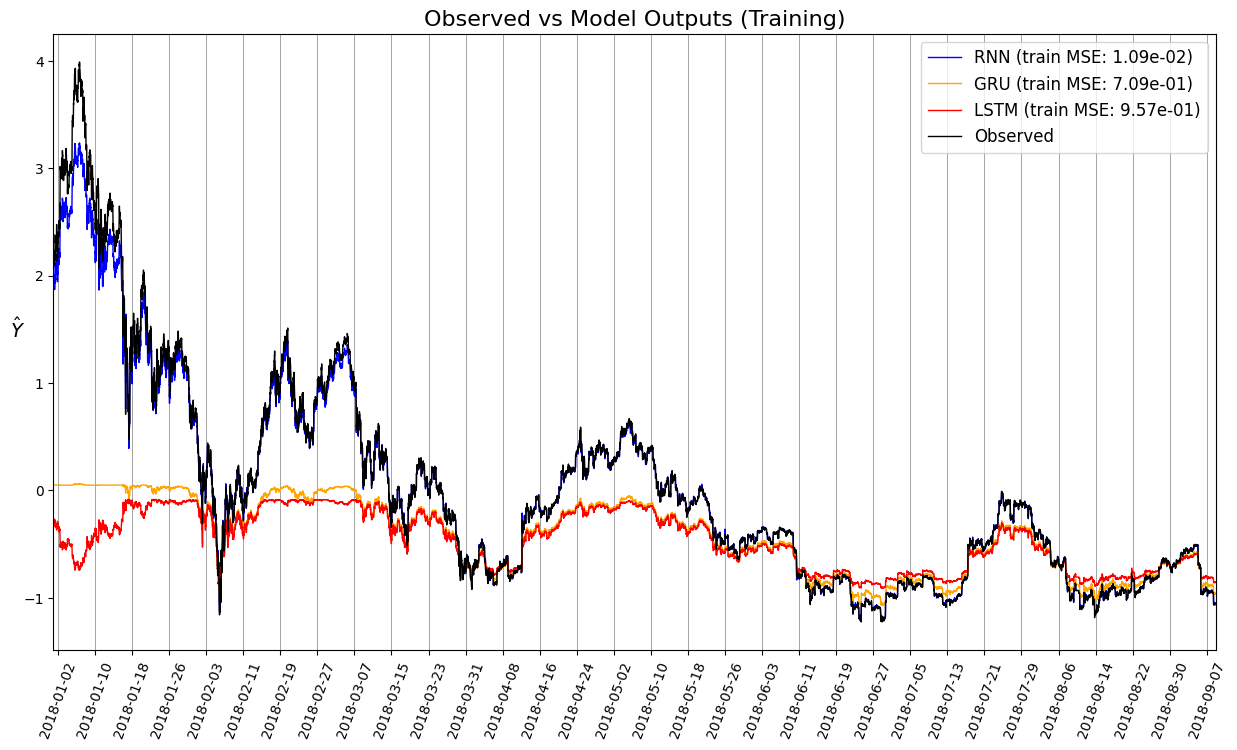

In [94]:
max_pts = 10**4
compare = params.keys() # e.g. ['rnn', 'alpharnn'] or ['lstm']
l, u = (None, None) # lower and upper indices of range to plot 
ds = max(1, len(y_train[l:u])//max_pts) # Downsampling ratio for under `max_pts`
                                        # per series.  Set `None` to disable. 

fig = plt.figure(figsize=(15,8))
x_vals = y_train_timestamps[l:u:ds]
for key in compare:
    y_vals = params[key]['pred_train'][l:u:ds]
    label = params[key]['label'] + ' (train MSE: %.2e)' % params[key]['MSE_train']
    plt.plot(x_vals, y_vals, c=params[key]['color'], label=label, lw=1)
plt.plot(x_vals, y_train[l:u:ds], c="black", label="Observed", lw=1)
start, end = x_vals.min(), x_vals.max()
xticks =  [start.date() + timedelta(days=(1+i)) for i in range(1 + (end - start).days)]
xticks = xticks[::max(1, len(xticks)//30)]
for t in xticks: plt.axvline(x=t, c='gray', linewidth=0.5, zorder=0)
plt.xticks(xticks, rotation=70)
plt.xlim(start, end)
plt.ylabel('$\hat{Y}$', rotation=0, fontsize=14)
plt.legend(loc="best", fontsize=12)
plt.title('Observed vs Model Outputs (Training)', fontsize=16);

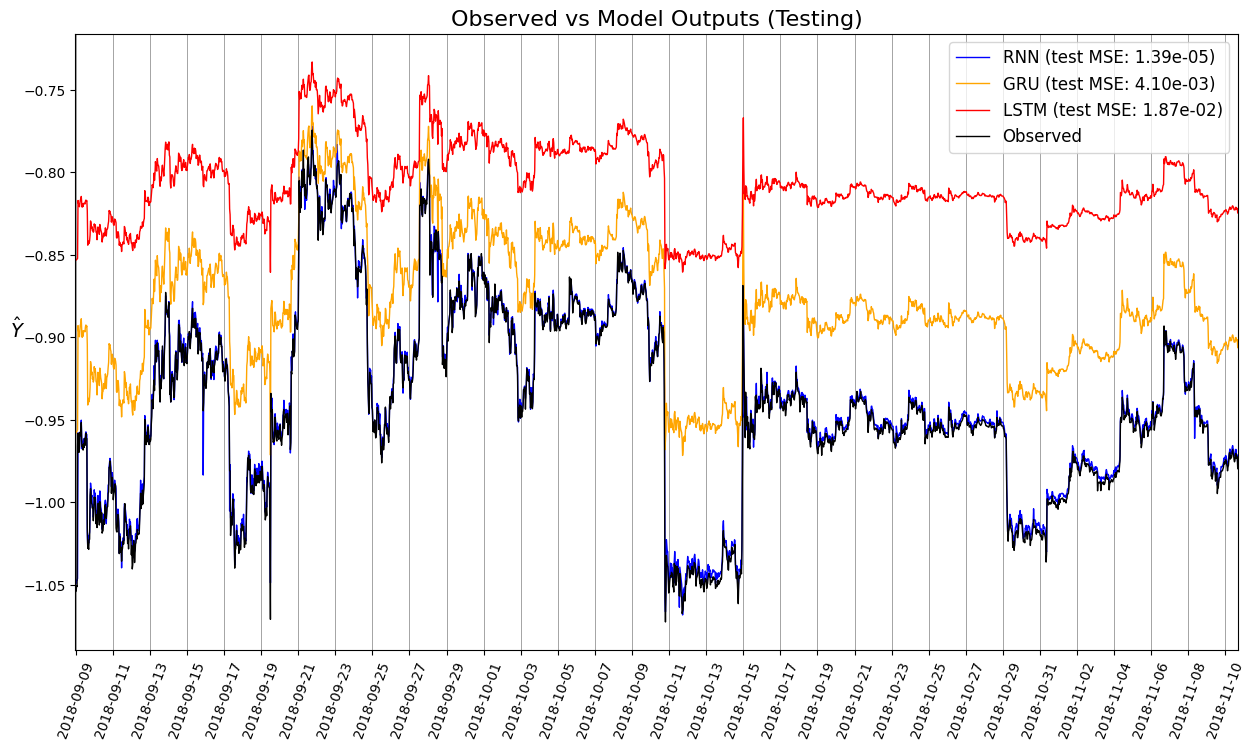

In [95]:
compare = params.keys() # e.g. ['rnn', 'alpharnn'] or ['lstm']
l, u = (None, None) # lower and upper indices of range to plot 
ds = max(1, len(y_train[l:u])//max_pts) # Downsampling ratio for under `max_pts`
                                        # per series.  Set `None` to disable.
fig = plt.figure(figsize=(15,8))
x_vals = y_test_timestamps[l:u:ds]
for key in compare:
    y_vals = params[key]['pred_test'][l:u:ds]
    label = params[key]['label'] + ' (test MSE: %.2e)' % params[key]['MSE_test']
    plt.plot(x_vals, y_vals, c=params[key]['color'], label=label, lw=1)
plt.plot(x_vals, y_test[l:u:ds], c="black", label="Observed", lw=1)
start, end = x_vals.min(), x_vals.max()
xticks =  [start.date() + timedelta(days=(1+i)) for i in range(1 + (end - start).days)]
xticks = xticks[::max(1, len(xticks)//30)]
for t in xticks: plt.axvline(x=t, c='gray', linewidth=0.5, zorder=0)
plt.xticks(xticks, rotation=70)
plt.xlim(start, end)
plt.ylabel('$\hat{Y}$', rotation=0, fontsize=14)
plt.legend(loc="best", fontsize=12)
plt.title('Observed vs Model Outputs (Testing)', fontsize=16);

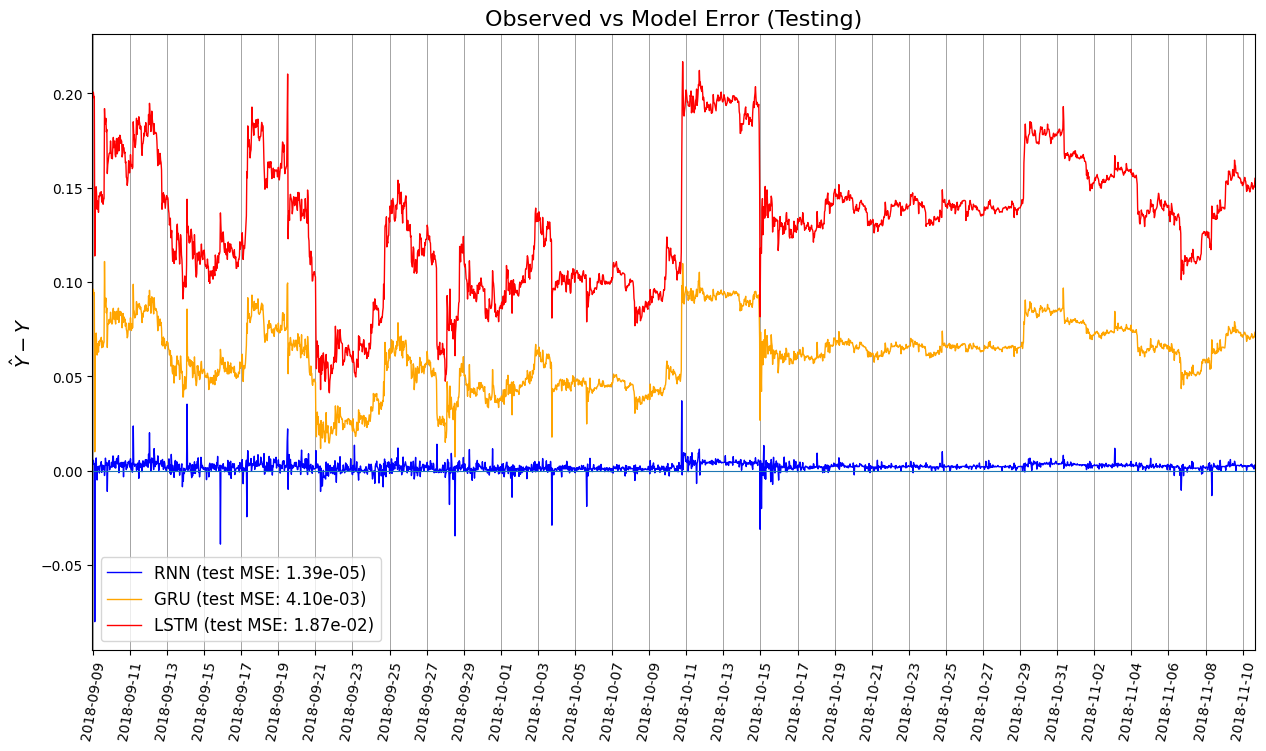

In [96]:
compare = params.keys() # e.g. ['rnn', 'alpharnn'] or ['lstm']
l, u = (None, None) # e.g. (None, 100000) lower and upper indices of range to plot 
ds = max(1, len(y_train[l:u])//max_pts) # Downsampling ratio for under `max_pts`
                                        # per series.  Set `None` to disable.
fig = plt.figure(figsize=(15,8))
x_vals = y_test_timestamps[l:u:ds]
for key in compare:
    y_vals = params[key]['pred_test'][l:u:ds] - y_test[l:u:ds]
    label = params[key]['label'] + ' (test MSE: %.2e)' % params[key]['MSE_test']
    plt.plot(x_vals, y_vals, c=params[key]['color'], label=label, lw=1)
start, end = x_vals.min(), x_vals.max()
xticks =  [start.date() + timedelta(days=(1+i)) for i in range(1 + (end - start).days)]
xticks = xticks[::max(1, len(xticks)//30)]
plt.axhline(0, linewidth=0.8)
for t in xticks: plt.axvline(x=t, c='gray', linewidth=0.5, zorder=0)
plt.xticks(xticks, rotation=80)
plt.xlim(start, end)
plt.ylabel('$\hat{Y}-Y$', fontsize=14)
plt.legend(loc="best", fontsize=12)
plt.title('Observed vs Model Error (Testing)', fontsize=16);

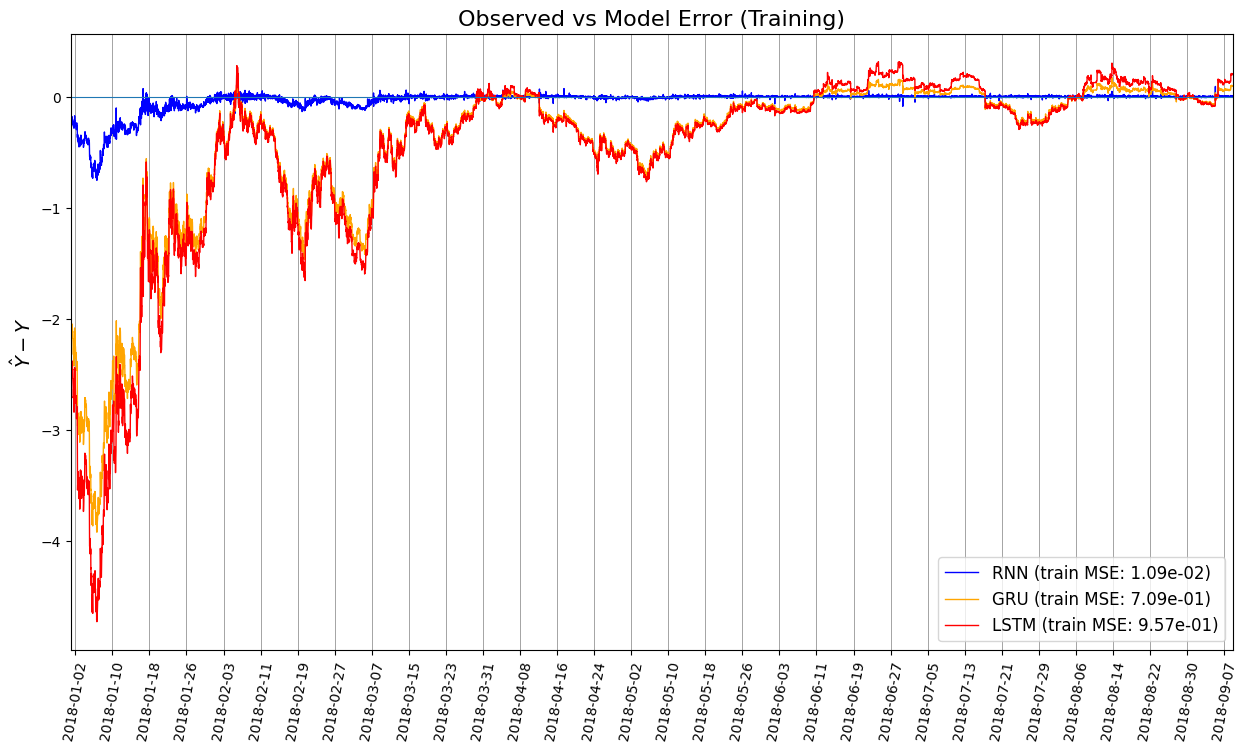

In [97]:
compare = params.keys() # e.g. ['rnn', 'alpharnn'] or ['lstm']
l, u = (None, None) # lower and upper indices of range to plot - e.g. (None, 10000)
ds = max(1, len(y_train[l:u])//max_pts) # Downsampling ratio for under `max_pts`
                                        # per series.  Set `None` to disable.
fig = plt.figure(figsize=(15,8))
x_vals = y_train_timestamps[l:u:ds]
for key in compare:
    y_vals = params[key]['pred_train'][l:u:ds] - y_train[l:u:ds]
    label = params[key]['label'] + ' (train MSE: %.2e)' % params[key]['MSE_train']
    plt.plot(x_vals, y_vals, c=params[key]['color'], label=label, lw=1)
start, end = x_vals.min(), x_vals.max()
xticks =  [start.date() + timedelta(days=(1+i)) for i in range(1 + (end - start).days)]
xticks = xticks[::max(1, len(xticks)//30)]
plt.axhline(0, linewidth=0.8)
for t in xticks: plt.axvline(x=t, c='gray', linewidth=0.5, zorder=0)
plt.xticks(xticks, rotation=80)
plt.xlim(start, end)
plt.ylabel('$\hat{Y}-Y$', fontsize=14)
plt.legend(loc="best", fontsize=12)
plt.title('Observed vs Model Error (Training)', fontsize=16);

### Model Diagnostics

A fitted time series model must be examined for underfitting with a white noise test. We analyze the model residuals (i.e. the error $u_t$) to determine whether it is white noise or whether it is auto-correlated. The latter case provides statistical evidence that more lags are needed in the RNN. Box and Pierce propose the Portmanteau statistic:

$$Q^*(m)=T\sum_{l=1}^m\hat{\tau}_l^2,$$  
as a test statistic for the null hypothesis $H_0:\tau_1=\dots=\tau_m=0$ against the alternative hypothesis $H_a:\tau_i\neq 0$ for some $i\in\{1,\dots,m\}$, where $T$ is the number of observations, $\hat{\tau}_i$ are the sample autocorrelations of the residual, and $m$ is the maximum lag used in the test. There are several heuristics in the statistics literature to determine the maximum lag such as the Schwert statistic. 

The Box-Pierce statistic follows an asymptotically chi-squared distribution with $m$ degrees of freedom.

The Ljung-Box test statistic increases the power of the test in finite samples:
$$Q(m)=T(T+2)\sum_{l=1}^m\frac{\hat{\tau}_l^2}{T-l}$$
This statistic also follows an asymptotically chi-squared distribution with $m$ degrees of freedom. The decision rule is to reject $H_0$ if $Q(m)>\chi_{\alpha}^2$ where $\chi_{\alpha}^2$ denotes the $100(1-\alpha)^{th}$ percentile of a chi-squared distribution with m degrees of freedom and is the significance level for rejecting $H_0$.

The test can be time consuming and we select a subset of the residuals. Here we simply set the maximum lag to 20. In the results below, we find that the p-values are all smaller than 0.01, indicating that we can reject the null at the 99% confidence level for any lag. This is strong evidence that the model is under-fitting and more lags are needed in our model. Unlike an auto-regressive model, increasing the number of lags in the RNN does not increase the number of weights. Thus there is no danger of over-fitting by increasing the lag, although there will be an increase in the training time.

In [98]:
# number of samples to use for computing test statistic
n = 100000

In [99]:
params.keys()

dict_keys(['rnn', 'gru', 'lstm'])

In [100]:
key = 'rnn'
predicted = params[key]['pred_test']
residual = y_test[-n:] - predicted[-n:]

In [101]:
statistic_lb = sm.stats.diagnostic.acorr_ljungbox(residual, lags=20, boxpierce=False,return_df=True)

The Box-Ljung test statistics are

In [102]:
statistic_lb

,lb_stat,lb_pvalue
1,36031.212888,0.0
2,51230.161096,0.0
3,55498.627171,0.0
4,55815.475504,0.0
5,57589.905980,0.0
6,58661.102642,0.0
7,59406.664549,0.0
8,60011.369886,0.0
9,60736.410348,0.0
10,61728.313035,0.0


The p-values are